In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/united-states-presidential-speeches/second_party_corpus.csv
/kaggle/input/united-states-presidential-speeches/corpus.csv
/kaggle/input/united-states-presidential-speeches/fifth_party_corpus.csv
/kaggle/input/united-states-presidential-speeches/fourth_party_corpus.csv
/kaggle/input/united-states-presidential-speeches/first_party_corpus.csv
/kaggle/input/united-states-presidential-speeches/presidential_speeches.csv
/kaggle/input/united-states-presidential-speeches/sixth_party_corpus.csv
/kaggle/input/united-states-presidential-speeches/third_party_corpus.csv
/kaggle/input/stopwords/stops.txt
/kaggle/input/un-general-debates/un-general-debates.csv
/kaggle/input/nips-papers-1987-2019-updated/papers.csv
/kaggle/input/nips-papers-1987-2019-updated/authors.csv


In [2]:
!nvidia-smi

Mon Feb 21 11:10:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#!CUDA_LAUNCH_BLOCKING=1
!pip install gpytorch torch pyro-ppl --upgrade

In [4]:
from gpytorch.models.gplvm.latent_variable import *
from gpytorch.models.gplvm.bayesian_gplvm import BayesianGPLVM
from matplotlib import pyplot as plt
from tqdm.notebook import trange
from gpytorch.means import ZeroMean
from gpytorch.mlls import VariationalELBO
from gpytorch.priors import NormalPrior
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.variational import VariationalStrategy
from gpytorch.variational import CholeskyVariationalDistribution,NaturalVariationalDistribution, TrilNaturalVariationalDistribution
from gpytorch.kernels import ScaleKernel, RBFKernel,MaternKernel
from gpytorch.distributions import MultivariateNormal

Model

In [5]:
import gpytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import dtype, Tensor
from torch.distributions.constraints import positive
from torch.nn.modules.module import T
from torch.utils.data import Dataset
from typing import Optional, Union, overload

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Encoder(nn.Module):
    def __init__(self, vocab_size, num_topics, hidden, dropout, batchNorm):
        super().__init__()
        if torch.cuda.is_available():
            self.cuda()

        self.num_topics = num_topics
        self.batchNorm = batchNorm
        self.drop = nn.Dropout(dropout)  # dropout
        self.fc1 = nn.Linear(vocab_size+num_topics, hidden)
        self.fc2 = nn.Linear(hidden+num_topics, hidden)
        self.fcmu = nn.Linear(hidden, num_topics, bias=True)  # fully-connected layer output mu
        self.fclv = nn.Linear(hidden, num_topics, bias=True)  # fully-connected layer output sigma
        self.act1 = nn.Softplus()
        self.act2 = nn.Softplus()
        
        self.norm1 = nn.LayerNorm(hidden, elementwise_affine=False)
        self.norm2 = nn.LayerNorm(hidden, elementwise_affine=False)
        
    def get_kl(self, q_mu, q_logsigma, p_mu=None, p_logsigma=None):
        """ Gaussian KL Divergence
        Returns KL( N(q_mu, q_logsigma) || N(p_mu, p_logsigma) ).
        """
        if p_mu is not None and p_logsigma is not None:
            sigma_q_sq = torch.exp(q_logsigma).to(device)
            sigma_p_sq = torch.exp(p_logsigma).to(device)
            kl = (sigma_q_sq + (q_mu - p_mu) ** 2) / (sigma_p_sq + 1e-6)
            kl = kl - 1 + p_logsigma - q_logsigma
            kl = 0.5 * torch.sum(kl, dim=-1).to(device)
        else:
            kl = -0.5 * torch.sum(1 + q_logsigma - q_mu.pow(2) - q_logsigma.exp(), dim=-1).to(device)
        return kl

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar).to(device)
        eps = torch.randn_like(std).to(device)
        return eps.mul_(std).add_(mu)

    def forward(self, inp, res_inp, eva=False):
        inp = torch.cat([inp, res_inp], dim=1).to(device)
        h = self.act1(self.fc1(inp))
        h = self.norm1(h) # layernorm
        inp = torch.cat([h, res_inp], dim=1).to(device)
        h = self.act2(self.fc2(inp))
        h = self.norm2(h) # layernorm
        h = self.drop(h)
        #h = torch.cat([h, res_inp], dim=1).to(device)
        # μ and Σ are two inference networks
        mu_theta = self.fcmu(h)
        #mu_theta = self.bnmu(mu_theta)
        if eva:
            return mu_theta.softmax(-1)
        sig_theta = self.fclv(h)
        #sig_theta = self.bnlv(sig_theta)
        z = self.reparameterize(mu_theta, sig_theta)
        theta = torch.softmax(z, -1).to(device)
        kld_theta = self.get_kl(mu_theta, sig_theta, res_inp, torch.zeros(self.num_topics).to(device))
        return theta, kld_theta


class Decoder(nn.Module):
    # Pre-trained embedding, alpha, rho, embedding method
    # Need to be refactored with Topic Embedding
    def __init__(self, vocab_size, num_topics, dropout,
                 useEmbedding=True, rho_size=256, pre_embedding=None, emb_type='NN',
                 trainEmbedding=True):
        super().__init__()
        # this beta can be refactorized in to BOW, a neural network that to be trained
        self.emb_type = emb_type
        self.trainEmbedding = trainEmbedding
        self.useEmbedding = useEmbedding
        self.rho_size = rho_size
        # Changes - Beta
        # < Linear NN (K->V)
        # > Embedding -> Linear NN (K->E->V)
        self.drop = nn.Dropout(dropout)
        if self.useEmbedding:
            # Call ρ Topic Embedding

            if trainEmbedding:
                self.fcrho = TopicEmbedding(rho_size, vocab_size, pre_embedding,
                                            emb_type, dropout)
                self.bnrho = nn.BatchNorm1d(rho_size, affine=False)
            # use original embedding
            else:
                self.fcrho = TopicEmbedding(rho_size, vocab_size, pre_embedding,
                                            emb_type, dropout, trans_layer, trans_head, trans_dim)
            # Call α
            self.fcalpha = nn.Linear(rho_size, num_topics, bias=False)
            self.bnalpha = nn.BatchNorm1d(num_topics, affine=False)
            # nn.Parameter(torch.randn(rho_size, num_topics))
        else:
            # Call β, Use Original NN (K->V)
            self.fcbeta = nn.Linear(num_topics, vocab_size, bias=False)
            self.bnbeta = nn.BatchNorm1d(vocab_size, affine=False)

        self.bn = nn.BatchNorm1d(vocab_size, affine=False)

        if torch.cuda.is_available():
            self.cuda()
            
    def get_beta(self, alpha):
        if self.trainEmbedding:
            if self.emb_type is 'NN':
#                 logit = self.fcrho(alpha.reshape(alpha.size(0) * alpha.size(1), self.rho_size))
#                 logit = logit.reshape(alpha.size(0), alpha.size(1), -1)
#                 beta = F.softmax(logit, dim=-1)
                n_alpha = alpha.reshape(alpha.size(0) * alpha.size(1), self.rho_size)
                rho = self.fcrho.rho.weight
                logit = torch.mm(n_alpha, rho.T)
                logit = logit.reshape(alpha.size(0), alpha.size(1), -1)
                beta = F.softmax(logit, dim=-1)
            else:
                raise ValueError('Wrong embedding type')
        elif self.useEmbedding:
            beta = self.bnalpha(self.fcalpha(self.bnrho(self.fcrho.weight()))).transpose(1, 0).to(device)
        else:
            beta = self.fcbeta.weight
        return beta


class TopicEmbedding(nn.Module):
    def __init__(self, rho_size, vocab_size, pre_embedding=None,
                 emb_type='NN', dropout=0.0,
                 n_heads=8, n_layer=4, n_dim=128, n_code=8):
        super().__init__()
        self.emb_type = emb_type
        if pre_embedding is None:
            # 1. Embedding layer
            if emb_type is 'NN':
                self.rho = nn.Linear(rho_size, vocab_size, bias=False)
            else:
                raise ValueError('Wrong Embedding Type')
        else:
            self.rho = pre_embedding.clone().float().to(device)
            
    def forward(self, inputs):
        if self.emb_type is 'NN':
            return self.rho(inputs)
        else:
            raise ValueError('Wrong Embedding Type')


class TETM(nn.Module):

    def __init__(self, vocab_size, num_topics, num_times, hidden, dropout,
                 delta, data_size, useEmbedding=False, eta_size=256, rho_size=256,
                 pre_embedding=None, emb_type='NN', trainEmbedding=False, batchNorm=True):
        super().__init__()

        self.delta = delta
        if torch.cuda.is_available():
            self.cuda()

        self.vocab_size = vocab_size
        self.num_topics = num_topics
        self.num_times = num_times
        self.useEmbedding = useEmbedding
        self.emb_type = emb_type
        self.rho_size = rho_size
        self.eta_size = eta_size

        self.encoder = Encoder(vocab_size, num_topics, hidden, dropout, batchNorm).to(device)
        self.decoder = Decoder(vocab_size, num_topics, dropout,
                               useEmbedding, rho_size, pre_embedding, emb_type,
                               trainEmbedding).to(device)
        ## define the variational parameters for the topic embeddings over time (alpha) ... alpha is K x T x L
        self.mu_q_alpha = nn.Parameter(torch.randn(num_topics, num_times, rho_size).to(device))
        self.logsigma_q_alpha = nn.Parameter(torch.randn(num_topics, num_times, rho_size).to(device))

        self.data_size = data_size
        self.gplvm = bGPLVM(self.data_size, vocab_size, self.num_topics, 100).to(device)
        self.likelihood = GaussianLikelihood(batch_shape=(num_times, vocab_size)).to(device)
        
        self.mu_q_eta = nn.Linear(self.num_topics, self.num_topics, bias=True).to(device)
        self.logsigma_q_eta = nn.Linear(self.num_topics, self.num_topics, bias=True).to(device)


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar).to(device)
        eps = torch.randn_like(std).to(device)
        return eps.mul_(std).add_(mu)

    def get_beta(self, alpha):
        beta = self.decoder.get_beta(alpha)
        return beta
    
    def get_theta(self, eta, bows, times):
        eta_td = eta[times.type('torch.LongTensor')]
        theta, kl_theta = self.encoder(bows, eta_td)
        return theta, kl_theta

    def decode(self, theta, beta):
        res = torch.mm(theta, beta)
        preds = torch.log(res + 1e-6)
        return preds

    def get_kl(self, q_mu, q_logsigma, p_mu=None, p_logsigma=None):
        """ Gaussian KL Divergence
        Returns KL( N(q_mu, q_logsigma) || N(p_mu, p_logsigma) ).
        """
        if p_mu is not None and p_logsigma is not None:
            sigma_q_sq = torch.exp(q_logsigma).to(device)
            sigma_p_sq = torch.exp(p_logsigma).to(device)
            kl = (sigma_q_sq + (q_mu - p_mu) ** 2) / (sigma_p_sq + 1e-6)
            kl = kl - 1 + p_logsigma - q_logsigma
            kl = 0.5 * torch.sum(kl, dim=-1).to(device)
        else:
            kl = -0.5 * torch.sum(1 + q_logsigma - q_mu.pow(2) - q_logsigma.exp(), dim=-1).to(device)
        return kl
        
    def get_alpha(self):  ## mean field
        # TxKxL
        alphas = torch.zeros(self.num_times, self.num_topics, self.rho_size).to(device)
        kl_alpha = []
        alphas[0] = self.reparameterize(self.mu_q_alpha[:, 0, :], self.logsigma_q_alpha[:, 0, :])
        p_mu_0 = torch.zeros(self.num_topics, self.rho_size).to(device)
        logsigma_p_0 = torch.zeros(self.num_topics, self.rho_size).to(device)
        kl_0 = self.get_kl(self.mu_q_alpha[:, 0, :], self.logsigma_q_alpha[:, 0, :], p_mu_0, logsigma_p_0)
        kl_alpha.append(kl_0)
        for t in range(1, self.num_times):
            alphas[t] = self.reparameterize(self.mu_q_alpha[:, t, :], self.logsigma_q_alpha[:, t, :])
            p_mu_t = alphas[t - 1]
            logsigma_p_t = torch.log(self.delta * torch.ones(self.num_topics, self.rho_size).to(device))
            kl_t = self.get_kl(self.mu_q_alpha[:, t, :], self.logsigma_q_alpha[:, t, :], p_mu_t, logsigma_p_t)
            kl_alpha.append(kl_t)
        kl_alpha = torch.stack(kl_alpha).sum()
        return alphas, kl_alpha.sum()

    # Compute η[t]~N(η[t-1], δ^2*I), η[0]=
    def get_eta(self, eta_inp):
        etas = torch.zeros(self.num_times, self.num_topics).to(device)
        kl_eta = []
        inp_0 = eta_inp[0]#torch.cat([eta_inp[0], torch.zeros(self.num_topics, ).to(device)], dim=0).to(device)
        mu_0, logsigma_0 = self.mu_q_eta(inp_0), self.logsigma_q_eta(inp_0)
        etas[0] = self.reparameterize(mu_0, logsigma_0)
        p_mu_0, logsigma_p_0 = torch.zeros(self.num_topics, ).to(device), torch.zeros(self.num_topics, ).to(device)
        kl_0 = self.get_kl(mu_0, logsigma_0, p_mu_0, logsigma_p_0)
        kl_eta.append(kl_0)
        for t in range(1, self.num_times):
            inp_t = eta_inp[t]#torch.cat([eta_inp[t], etas[t - 1]], dim=0)
            mu_t, logsigma_t = self.mu_q_eta(inp_t), self.logsigma_q_eta(inp_t)
            etas[t] = self.reparameterize(mu_t, logsigma_t)
            logsigma_p_t = torch.log(self.delta * torch.ones(self.num_topics,).to(device))
            kl_t = self.get_kl(mu_t, logsigma_t, etas[t - 1], logsigma_p_t)
            kl_eta.append(kl_t)
        kl_eta = torch.stack(kl_eta).sum()
        return etas, kl_eta

    def init_hidden(self):
        """Initializes the first hidden state of the RNN used as inference network for \eta.
        """
        weight = next(self.parameters())
        nlayers = self.eta_nlayers
        nhid = self.eta_size
        return (weight.new_zeros(nlayers, 1, nhid), weight.new_zeros(nlayers, 1, nhid))
    
    def get_mu(self, rnn_inp):
        mll = VariationalELBO(self.likelihood, self.gplvm, num_data=len(rnn_inp))#,combine_terms=False)
        sample = self.gplvm.sample_latent_variable()
        output = self.gplvm(sample)
        loss = mll(output, rnn_inp.T.to(device))
        # nll + kl_x + kl_u
        return self.gplvm.X.q_mu, loss#loss[0].sum()+loss[1].sum()+loss[2].sum()+loss[3].sum()

    def forward(self, bows, norm_bows, times, rnn_inp, num_docs):
        bsz = bows.size(0)
        coeff = num_docs / bsz
        #eta, kl_eta = self.get_eta(rnn_inp)
        eta_gp, kld_eta_gp = self.get_mu(rnn_inp)
        kld_eta = torch.zeros(()).to(device)
        #eta, kld_eta = self.get_eta(eta_gp.to(device))
        # get theta N(η,α^2I)
        theta, kld_theta = self.get_theta(eta_gp, norm_bows, times)
        kld_theta = kld_theta.sum() * coeff
        alpha, kl_alpha = self.get_alpha()
        assert (alpha.shape == torch.Size(
            [self.num_times, self.num_topics, self.rho_size]
        ))
        beta = self.get_beta(alpha)
        beta = beta[times.type('torch.LongTensor')]
        assert (beta.shape == torch.Size(
            [bows.shape[0], self.num_topics, self.vocab_size]
        ))
        theta = theta.unsqueeze(1)
        assert (theta.shape == torch.Size([bows.shape[0], 1, self.num_topics]
                                        ))
        pred = torch.bmm(theta, beta).squeeze(1)
        logp = torch.log(pred + 1e-6)
        nll = -(logp * bows).sum(-1)
        nll = nll.sum() * coeff
        return nll, kl_alpha, kld_eta, kld_theta ,kld_eta_gp
    
    def get_beta_result(self):
        alpha = model.mu_q_alpha.clone().contiguous()
        alpha = alpha.permute(1,0,2)
        beta = model.get_beta(alpha, torch.arange(0,ts.unique().shape[0]))
        return beta
    
    def get_eta_result(self):
        return self.gplvm.X.q_mu

    def predict(self, d_bat, norm_d_bat, t_bat, rnn_inp):
        """give out the test data set, return the corresponding perplexity"""
        self.eval()
        with torch.no_grad():
            # get eta(TxK)
            #eta = self.gplvm.X.q_mu
            eta_gp = self.gplvm.X.q_mu
            eta = self.mu_q_eta(eta_gp)
            #eta, kl_eta = self.get_eta(rnn_inp)
            assert (eta.shape == torch.Size([self.num_times, self.num_topics]))
            # get theta(DxK)
            eta_td = eta[t_bat.type('torch.LongTensor')]
            theta = self.encoder(d_bat, eta_td,eva=True)
            #theta = self.get_theta(eta, norm_d_bat, t_bat)[0]
            assert (theta.shape == torch.Size([norm_d_bat.shape[0], self.num_topics]))
            #theta = theta.unsqueeze(1)
            # get alpha(KxTxL)
            alpha = model.mu_q_alpha.clone().contiguous()
            #alpha = alpha.permute(1, 0, 2)
            assert (alpha.shape == torch.Size(
                [self.num_topics, self.num_times, self.rho_size]
            ))
            # alpha_td(KxDxL)
            #alpha_td = alpha[:,t_bat.type('torch.LongTensor'), :]
#             assert (alpha_td.shape == torch.Size(
#                 [self.num_topics, d_bat.shape[0], self.rho_size]
#             ))
            # get beta(T[D]xKxV)
            beta = self.get_beta(alpha)
            beta = beta.permute(1, 0, 2)
            beta = beta[t_bat.type('torch.LongTensor')]
            assert (beta.shape == torch.Size(
                [d_bat.shape[0], self.num_topics, self.vocab_size]
            ))
            loglik = theta.unsqueeze(2) * beta
            pred = loglik.sum(1)
            #pred = torch.bmm(theta, beta).squeeze(1)
            logp = torch.log(pred)
            sums = d_bat.sum(1).unsqueeze(1)
            loss = (-logp * d_bat).sum(-1) / sums.squeeze()
            loss = loss.nan_to_num().mean().item()
            # ppl check when doing mini-batch
            ppl = round(math.exp(loss), 1)
            return ppl


In [6]:
class bGPLVM(BayesianGPLVM):
    def __init__(self, n, data_dim, latent_dim, n_inducing, pca=False, nu=2.5):
        self.n = n
        self.batch_shape = torch.Size([data_dim])
        self.inducing_inputs = torch.randn(data_dim, n_inducing, latent_dim).to(device)
        q_u = CholeskyVariationalDistribution(n_inducing)
        q_f = VariationalStrategy(self, self.inducing_inputs, q_u, learn_inducing_locations=True)
        X_prior_mean = torch.zeros(n, latent_dim).to(device)  # shape: N x Q
        prior_x = NormalPrior(X_prior_mean, torch.ones_like(X_prior_mean).to(device))
        X_init = torch.nn.Parameter(torch.randn(n, latent_dim))
        # LatentVariable (c)
        X = VariationalLatentVariable(n, data_dim, latent_dim, X_init, prior_x)
        super().__init__(X, q_f)
        self.mean_module = ZeroMean(ard_num_dims=latent_dim)
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=latent_dim))
        init_lengthscale = 0.1
        self.covar_module.base_kernel.lengthscale = init_lengthscale

    def forward(self, X):
        mean_x = self.mean_module(X)
        covar_x = self.covar_module(X)
        dist = MultivariateNormal(mean_x, covar_x)
        return dist

    def _get_batch_idx(self, batch_size):
        valid_indices = np.arange(self.n)
        batch_indices = np.random.choice(valid_indices, size=batch_size, replace=False)
        return np.sort(batch_indices)


In [7]:
from sklearn.manifold import TSNE
import torch 
import numpy as np
import bokeh.plotting as bp

def get_df(data, wi, wj=None):
    """
    Obtain the document frequency
    :param data: document vocabulary matrix
    :param wi: word index w_i
    :param wj: word index w_j
    :return: document frequency for word w_i , w_i ∩ w_j
    """
    if wj is None:
        return torch.where(data[:, wi] > 0, 1, 0).sum(-1)
    else:
        df_wi = torch.where(data[:, wi] > 0, 1, 0)
        df_wj = torch.where(data[:, wj] > 0, 1, 0)
        return df_wj.sum(-1), (df_wi & df_wj).sum(-1)


def get_topic_coherence(beta, data):
    D = torch.tensor(len(data)) ## number of docs...data is list of documents
    TC = []
    num_topics = len(beta)
    counter = 0
    for k in range(num_topics):
        top_10 = list(torch.flip(beta[k].argsort()[-11:],[0]))
        TC_k = 0
        counter = 0
        for i, word in enumerate(top_10):
            D_wi = get_df(data, word)
            j = i + 1
            tmp = 0
            while j < len(top_10) and j > i:
                D_wj, D_wi_wj = get_df(data, word, top_10[j])
                if D_wi_wj == 0:
                    f_wi_wj = -1
                else:
                    f_wi_wj = -1 + (torch.log(D_wi)+torch.log(D_wj)-2.0*torch.log(D))/(torch.log(D_wi_wj)-torch.log(D))
                tmp += f_wi_wj
                j += 1
                counter += 1
            TC_k += tmp 
        TC.append(TC_k.detach().cpu().numpy())
    TC = np.mean(TC) / counter
    #print('Topic coherence is: {}'.format(TC))
    return TC


def visualize(docs, _lda_keys, topics, theta):
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
    # project to 2D
    tsne_lda = tsne_model.fit_transform(theta)
    colormap = []
    for name, hex in matplotlib.colors.cnames.items():
        colormap.append(hex)

    colormap = colormap[:len(theta[0, :])]
    colormap = np.array(colormap)

    title = '20 newsgroups TE embedding V viz'
    num_example = len(docs)

    plot_lda = bp.figure(plot_width=1400, plot_height=1100,
                     title=title,
                     tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

    plt.scatter(x=tsne_lda[:, 0], y=tsne_lda[:, 1],
                 color=colormap[_lda_keys][:num_example])
    plt.show()

def get_rnn_inp(data_batch,times_batch, num_times, vocab_size):
    rnn_input = torch.zeros(num_times, vocab_size).to(device)
    cnt = torch.zeros(num_times, ).to(device)
    for t in range(num_times):
        tmp = (times_batch == t).nonzero()
        docs = data_batch[tmp].squeeze().sum(0)
        rnn_input[t] += docs
        cnt[t] += tmp.shape[0]
    rnn_input = rnn_input / cnt.unsqueeze(1)
    return rnn_input
    
    
# def get_rnn_input(dataloader, num_times, vocab_size):
#     # TxV
#     rnn_input = torch.zeros(num_times, vocab_size).to(device)
#     # times count
#     cnt = torch.zeros(num_times, ).to(device)
#     # create data loader
#     for data in dataloader:
#         data_batch = cvz[data['index'].long() - 1,:].to(device)
#         times_batch = ts[data['index'].long() - 1].to(device)
#         for t in range(num_times):
#             # check times
#             tmp = (times_batch == t).nonzero()
#             # sum the vocabulary in time t
#             docs = data_batch[tmp].squeeze().sum(0)
#             # feed in the vocabulary count in time t
#             rnn_input[t] += docs
#             # sum up the count
#             cnt[t] += tmp.shape[0]
#             # check the epoch
#     rnn_input = rnn_input / cnt.unsqueeze(1)
#     return rnn_input

In [9]:
import csv
import itertools
import numpy as np
import os
import re
import pandas as pd
import pickle
import random
import string
from tqdm import trange
from scipy import sparse
from scipy.io import savemat, loadmat
from sklearn.feature_extraction.text import CountVectorizer

# Maximum / minimum document frequency
max_df = 0.5
min_df = 100  # choose desired value for min_df

# read data
# un debates
# data = pd.read_csv('../input/un-general-debates/un-general-debates.csv')
# data = data[['session', 'year', 'country', 'text']]
# data.sort_values('year', ascending=True, inplace=True)
# docs = data.text.to_numpy()  ## bows
# neurips
data = pd.read_csv('../input/nips-papers-1987-2019-updated/papers.csv')
data = data[~data.full_text.isnull()]
docs = data.full_text.values  ## bows
data.sort_values('year', ascending=True, inplace=True)
# US-Presidental Speeches
# data = pd.read_csv('../input/united-states-presidential-speeches/presidential_speeches.csv')
# data.sort_values('Date', ascending=True, inplace=True)
# data = data[~data.Transcript.isnull()]
# docs = data.Transcript.values
# data['year']= pd.to_datetime(data.Date).dt.year

# unique timestamp
times = data.year.unique()
times.sort()

# timestamp input
ts = torch.from_numpy(data.year.to_numpy()).to(device)  ## timestamp
ts = (ts==ts.unique()[:,None]).nonzero().transpose(1,0)[0].to(device)
timestamps = data.year.values
# Read stopwords
with open('../input/stopwords/stops.txt', 'r') as f:
    stops = f.read().split('\n')
    
print(f'Total document {len(docs)}')
#times_rank = (torch.tensor(ts)==torch.from_numpy(np.unique(ts))[:,None]).nonzero().T[0,:]

# Create count vectorizer
print('counting document frequency of words...')

def contains_punctuation(w):
    return any(char in string.punctuation for char in w)

def contains_numeric(w):
    return any(char.isdigit() for char in w)

# document preprocessing
init_docs = [re.findall(r'''[\w']+|[.,!?;-~{}`´_<=>:/@*()&'$%#"]|[\n]+''', doc) for doc in docs]
init_docs = [[w.lower() for w in init_docs[doc] if not contains_punctuation(w)] for doc in range(len(init_docs))]
init_docs = [[w for w in init_docs[doc] if not contains_numeric(w)] for doc in range(len(init_docs))]
init_docs = [[w for w in init_docs[doc] if len(w) > 1] for doc in range(len(init_docs))]
init_docs = [" ".join(init_docs[doc]) for doc in range(len(init_docs))]

# cvectorizer = CountVectorizer(min_df=min_df, max_df=max_df, stop_words=frozenset(stops))

# cvz = cvectorizer.fit_transform(init_docs)#.sign()
# cvz = torch.from_numpy(cvz.todense())

#print(f'documents={cvz.shape[0]};vocabulary={cvz.shape[1]};tokens={cvz.sum()}')

Total document 9677
counting document frequency of words...


In [10]:

# Read raw data
print('reading raw data...')
# docs = []
# not_found = []
# timestamps = []
# for (pid, tt) in zip(all_pids, all_timestamps):
#     path_read = 'raw/acl_abstracts/acl_data-combined/all_papers'
#     path_read = os.path.join(path_read, pid + '.txt')
#     if not os.path.isfile(path_read):
#         not_found.append(pid)
#     else:
#         with open(path_read, 'rb') as f:
#             doc = f.read().decode('utf-8', 'ignore')
#             doc = doc.lower().replace('\n', ' ').replace("’", " ").replace("'", " ").translate(str.maketrans(string.punctuation + "0123456789", ' '*len(string.punctuation + "0123456789"))).split()
#         doc = [remove_not_printable(w) for w in doc if len(w)>1]
#         if len(doc) > 1:
#             doc = " ".join(doc)
#             docs.append(doc)
#             timestamps.append(tt)

# Write as raw text
# print('writing to text file...')
# out_filename = './docs_processed.txt'
# print('writing to text file...')
# with open(out_filename, 'w') as f:
#     for line in docs:
#         f.write(line + '\n')

# Read stopwords
with open('../input/stopwords/stops.txt', 'r') as f:
    stops = f.read().split('\n')

# Create count vectorizer
print('counting document frequency of words...')
cvectorizer = CountVectorizer(min_df=min_df, max_df=max_df, stop_words=frozenset(stops))
cvz = cvectorizer.fit_transform(init_docs).sign()

# Get vocabulary
print('building the vocabulary...')
sum_counts = cvz.sum(axis=0)
v_size = sum_counts.shape[1]
sum_counts_np = np.zeros(v_size, dtype=int)
for v in range(v_size):
    sum_counts_np[v] = sum_counts[0,v]
word2id = dict([(w, cvectorizer.vocabulary_.get(w)) for w in cvectorizer.vocabulary_])
id2word = dict([(cvectorizer.vocabulary_.get(w), w) for w in cvectorizer.vocabulary_])
#del cvectorizer
print('  initial vocabulary size: {}'.format(v_size))

# Sort elements in vocabulary
idx_sort = np.argsort(sum_counts_np)
vocab_aux = [id2word[idx_sort[cc]] for cc in range(v_size)]

# Filter out stopwords (if any)
vocab_aux = [w for w in vocab_aux if w not in stops]
print('  vocabulary size after removing stopwords from list: {}'.format(len(vocab_aux)))

# Create dictionary and inverse dictionary
vocab = vocab_aux
del vocab_aux
word2id = dict([(w, j) for j, w in enumerate(vocab)])
id2word = dict([(j, w) for j, w in enumerate(vocab)])

# Create mapping of timestamps
all_times = sorted(set(timestamps))
time2id = dict([(t, i) for i, t in enumerate(all_times)])
id2time = dict([(i, t) for i, t in enumerate(all_times)])
time_list = [id2time[i] for i in range(len(all_times))]

# Split in train/test/valid
print('tokenizing documents and splitting into train/test/valid...')
num_docs = cvz.shape[0]
trSize = int(np.floor(0.8*num_docs))
tsSize = int(np.floor(0.15*num_docs))
vaSize = int(num_docs - trSize - tsSize)
#del cvz
idx_permute = np.random.permutation(num_docs).astype(int)

# Remove words not in train_data
# vocab = list(set([w for idx_d in range(trSize) for w in docs[idx_permute[idx_d]].split() if w in word2id]))
# word2id = dict([(w, j) for j, w in enumerate(vocab)])
# id2word = dict([(j, w) for j, w in enumerate(vocab)])
print('  vocabulary after removing words not in train: {}'.format(len(vocab)))

docs_tr = [[word2id[w] for w in docs[idx_permute[idx_d]].split() if w in word2id] for idx_d in range(trSize)]
timestamps_tr = [time2id[timestamps[idx_permute[idx_d]]] for idx_d in range(trSize)]
docs_ts = [[word2id[w] for w in docs[idx_permute[idx_d+trSize]].split() if w in word2id] for idx_d in range(tsSize)]
timestamps_ts = [time2id[timestamps[idx_permute[idx_d+trSize]]] for idx_d in range(tsSize)]
docs_va = [[word2id[w] for w in docs[idx_permute[idx_d+trSize+tsSize]].split() if w in word2id] for idx_d in range(vaSize)]
timestamps_va = [time2id[timestamps[idx_permute[idx_d+trSize+tsSize]]] for idx_d in range(vaSize)]

print('  number of documents (train): {} [this should be equal to {} and {}]'.format(len(docs_tr), trSize, len(timestamps_tr)))
print('  number of documents (test): {} [this should be equal to {} and {}]'.format(len(docs_ts), tsSize, len(timestamps_ts)))
print('  number of documents (valid): {} [this should be equal to {} and {}]'.format(len(docs_va), vaSize, len(timestamps_va)))

# Remove empty documents
print('removing empty documents...')

def remove_empty(in_docs, in_timestamps):
    out_docs = []
    out_timestamps = []
    for ii, doc in enumerate(in_docs):
        if(doc!=[]):
            out_docs.append(doc)
            out_timestamps.append(in_timestamps[ii])
    return out_docs, out_timestamps

def remove_by_threshold(in_docs, in_timestamps, thr):
    out_docs = []
    out_timestamps = []
    for ii, doc in enumerate(in_docs):
        if(len(doc)>thr):
            out_docs.append(doc)
            out_timestamps.append(in_timestamps[ii])
    return out_docs, out_timestamps

docs_tr, timestamps_tr = remove_empty(docs_tr, timestamps_tr)
docs_ts, timestamps_ts = remove_empty(docs_ts, timestamps_ts)
docs_va, timestamps_va = remove_empty(docs_va, timestamps_va)

# Remove test documents with length=1
docs_ts, timestamps_ts = remove_by_threshold(docs_ts, timestamps_ts, 1)

# Split test set in 2 halves
print('splitting test documents in 2 halves...')
docs_ts_h1 = [[w for i,w in enumerate(doc) if i<=len(doc)/2.0-1] for doc in docs_ts]
docs_ts_h2 = [[w for i,w in enumerate(doc) if i>len(doc)/2.0-1] for doc in docs_ts]

# Getting lists of words and doc_indices
print('creating lists of words...')

def create_list_words(in_docs):
    return [x for y in in_docs for x in y]

words_tr = create_list_words(docs_tr)
words_ts = create_list_words(docs_ts)
words_ts_h1 = create_list_words(docs_ts_h1)
words_ts_h2 = create_list_words(docs_ts_h2)
words_va = create_list_words(docs_va)

print('  len(words_tr): ', len(words_tr))
print('  len(words_ts): ', len(words_ts))
print('  len(words_ts_h1): ', len(words_ts_h1))
print('  len(words_ts_h2): ', len(words_ts_h2))
print('  len(words_va): ', len(words_va))

# Get doc indices
print('getting doc indices...')

def create_doc_indices(in_docs):
    aux = [[j for i in range(len(doc))] for j, doc in enumerate(in_docs)]
    return [int(x) for y in aux for x in y]

doc_indices_tr = create_doc_indices(docs_tr)
doc_indices_ts = create_doc_indices(docs_ts)
doc_indices_ts_h1 = create_doc_indices(docs_ts_h1)
doc_indices_ts_h2 = create_doc_indices(docs_ts_h2)
doc_indices_va = create_doc_indices(docs_va)

print('  len(np.unique(doc_indices_tr)): {} [this should be {}]'.format(len(np.unique(doc_indices_tr)), len(docs_tr)))
print('  len(np.unique(doc_indices_ts)): {} [this should be {}]'.format(len(np.unique(doc_indices_ts)), len(docs_ts)))
print('  len(np.unique(doc_indices_ts_h1)): {} [this should be {}]'.format(len(np.unique(doc_indices_ts_h1)), len(docs_ts_h1)))
print('  len(np.unique(doc_indices_ts_h2)): {} [this should be {}]'.format(len(np.unique(doc_indices_ts_h2)), len(docs_ts_h2)))
print('  len(np.unique(doc_indices_va)): {} [this should be {}]'.format(len(np.unique(doc_indices_va)), len(docs_va)))

# Number of documents in each set
n_docs_tr = len(docs_tr)
n_docs_ts = len(docs_ts)
n_docs_ts_h1 = len(docs_ts_h1)
n_docs_ts_h2 = len(docs_ts_h2)
n_docs_va = len(docs_va)

# Remove unused variables
del docs_tr
del docs_ts
del docs_ts_h1
del docs_ts_h2
del docs_va

# Create bow representation
print('creating bow representation...')

def create_bow(doc_indices, words, n_docs, vocab_size):
    return sparse.coo_matrix(([1]*len(doc_indices),(doc_indices, words)), shape=(n_docs, vocab_size)).tocsr()

bow_tr = create_bow(doc_indices_tr, words_tr, n_docs_tr, len(vocab))
bow_ts = create_bow(doc_indices_ts, words_ts, n_docs_ts, len(vocab))
bow_ts_h1 = create_bow(doc_indices_ts_h1, words_ts_h1, n_docs_ts_h1, len(vocab))
bow_ts_h2 = create_bow(doc_indices_ts_h2, words_ts_h2, n_docs_ts_h2, len(vocab))
bow_va = create_bow(doc_indices_va, words_va, n_docs_va, len(vocab))

del words_tr
del words_ts
del words_ts_h1
del words_ts_h2
del words_va
del doc_indices_tr
del doc_indices_ts
del doc_indices_ts_h1
del doc_indices_ts_h2
del doc_indices_va

# Write files for LDA C++ code
def write_lda_file(filename, timestamps_in, time_list_in, bow_in):
    idxSort = np.argsort(timestamps_in)
    
    with open(filename, "w") as f:
        for row in idxSort:
            x = bow_in.getrow(row)
            n_elems = x.count_nonzero()
            f.write(str(n_elems))
            if(n_elems != len(x.indices) or n_elems != len(x.data)):
                raise ValueError("[ERR] THIS SHOULD NOT HAPPEN")
            for ii, dd in zip(x.indices, x.data):
                f.write(' ' + str(ii) + ':' + str(dd))
            f.write('\n')
            
    with open(filename.replace("-mult", "-seq"), "w") as f:
        f.write(str(len(time_list_in)) + '\n')
        for idx_t, _ in enumerate(time_list_in):
            n_elem = len([t for t in timestamps_in if t==idx_t])
            f.write(str(n_elem) + '\n')
            

path_save = './min_df_' + str(min_df) + '/'
if not os.path.isdir(path_save):
    os.system('mkdir -p ' + path_save)

# Write files for LDA C++ code
print('saving LDA files for C++ code...')
write_lda_file(path_save + 'dtm_tr-mult.dat', timestamps_tr, time_list, bow_tr)
write_lda_file(path_save + 'dtm_ts-mult.dat', timestamps_ts, time_list, bow_ts)
write_lda_file(path_save + 'dtm_ts_h1-mult.dat', timestamps_ts, time_list, bow_ts_h1)
write_lda_file(path_save + 'dtm_ts_h2-mult.dat', timestamps_ts, time_list, bow_ts_h2)
write_lda_file(path_save + 'dtm_va-mult.dat', timestamps_va, time_list, bow_va)

# Also write the vocabulary and timestamps
with open(path_save + 'vocab.txt', "w") as f:
    for v in vocab:
        f.write(v + '\n')

with open(path_save + 'timestamps.txt', "w") as f:
    for t in time_list:
        f.write(str(t) + '\n')

with open(path_save + 'vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)
del vocab

with open(path_save + 'timestamps.pkl', 'wb') as f:
    pickle.dump(time_list, f)

# Save timestamps alone
savemat(path_save + 'bow_tr_timestamps', {'timestamps': timestamps_tr}, do_compression=True)
savemat(path_save + 'bow_ts_timestamps', {'timestamps': timestamps_ts}, do_compression=True)
savemat(path_save + 'bow_va_timestamps', {'timestamps': timestamps_va}, do_compression=True)

# Split bow intro token/value pairs
print('splitting bow intro token/value pairs and saving to disk...')

def split_bow(bow_in, n_docs):
    indices = [[w for w in bow_in[doc,:].indices] for doc in range(n_docs)]
    counts = [[c for c in bow_in[doc,:].data] for doc in range(n_docs)]
    return indices, counts

bow_tr_tokens, bow_tr_counts = split_bow(bow_tr, n_docs_tr)
savemat(path_save + 'bow_tr_tokens', {'tokens': bow_tr_tokens}, do_compression=True)
savemat(path_save + 'bow_tr_counts', {'counts': bow_tr_counts}, do_compression=True)
del bow_tr
del bow_tr_tokens
del bow_tr_counts

bow_ts_tokens, bow_ts_counts = split_bow(bow_ts, n_docs_ts)
savemat(path_save + 'bow_ts_tokens', {'tokens': bow_ts_tokens}, do_compression=True)
savemat(path_save + 'bow_ts_counts', {'counts': bow_ts_counts}, do_compression=True)
del bow_ts
del bow_ts_tokens
del bow_ts_counts

bow_ts_h1_tokens, bow_ts_h1_counts = split_bow(bow_ts_h1, n_docs_ts_h1)
savemat(path_save + 'bow_ts_h1_tokens', {'tokens': bow_ts_h1_tokens}, do_compression=True)
savemat(path_save + 'bow_ts_h1_counts', {'counts': bow_ts_h1_counts}, do_compression=True)
del bow_ts_h1
del bow_ts_h1_tokens
del bow_ts_h1_counts

bow_ts_h2_tokens, bow_ts_h2_counts = split_bow(bow_ts_h2, n_docs_ts_h2)
savemat(path_save + 'bow_ts_h2_tokens', {'tokens': bow_ts_h2_tokens}, do_compression=True)
savemat(path_save + 'bow_ts_h2_counts', {'counts': bow_ts_h2_counts}, do_compression=True)
del bow_ts_h2
del bow_ts_h2_tokens
del bow_ts_h2_counts

bow_va_tokens, bow_va_counts = split_bow(bow_va, n_docs_va)
savemat(path_save + 'bow_va_tokens', {'tokens': bow_va_tokens}, do_compression=True)
savemat(path_save + 'bow_va_counts', {'counts': bow_va_counts}, do_compression=True)
del bow_va
del bow_va_tokens
del bow_va_counts

print('Data ready !!')
print('*************')

reading raw data...
counting document frequency of words...


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'll', 'mon', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


building the vocabulary...
  initial vocabulary size: 9179
  vocabulary size after removing stopwords from list: 9179
tokenizing documents and splitting into train/test/valid...
  vocabulary after removing words not in train: 9179
  number of documents (train): 7741 [this should be equal to 7741 and 7741]
  number of documents (test): 1451 [this should be equal to 1451 and 1451]
  number of documents (valid): 485 [this should be equal to 485 and 485]
removing empty documents...
splitting test documents in 2 halves...
creating lists of words...
  len(words_tr):  7169169
  len(words_ts):  1327053
  len(words_ts_h1):  663169
  len(words_ts_h2):  663884
  len(words_va):  443616
getting doc indices...
  len(np.unique(doc_indices_tr)): 7696 [this should be 7696]
  len(np.unique(doc_indices_ts)): 1442 [this should be 1442]
  len(np.unique(doc_indices_ts_h1)): 1442 [this should be 1442]
  len(np.unique(doc_indices_ts_h2)): 1442 [this should be 1442]
  len(np.unique(doc_indices_va)): 483 [this 

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Data ready !!
*************


In [11]:
from sklearn.manifold import TSNE
import torch 
import numpy as np
import bokeh.plotting as bp

from bokeh.plotting import save
from bokeh.models import HoverTool
import matplotlib.pyplot as plt 
import matplotlib 

tiny = 1e-6

def _reparameterize(mu, logvar, num_samples):
    """Applies the reparameterization trick to return samples from a given q"""
    std = torch.exp(0.5 * logvar) 
    bsz, zdim = logvar.size()
    eps = torch.randn(num_samples, bsz, zdim).to(mu.device)
    mu = mu.unsqueeze(0)
    std = std.unsqueeze(0)
    res = eps.mul_(std).add_(mu)
    return res

def log_gaussian(z, mu=None, logvar=None):
    sz = z.size()
    d = z.size(2)
    bsz = z.size(1)
    if mu is None or logvar is None:
        mu = torch.zeros(bsz, d).to(z.device)
        logvar = torch.zeros(bsz, d).to(z.device)
    mu = mu.unsqueeze(0)
    logvar = logvar.unsqueeze(0)
    var = logvar.exp()
    log_density = ((z - mu)**2 / (var+tiny)).sum(2) # b
    log_det = logvar.sum(2) # b
    log_density = log_density + log_det + d*np.log(2*np.pi)
    return -0.5*log_density

def logsumexp(x, dim=0):
    d = torch.max(x, dim)[0]   
    if x.dim() == 1:
        return torch.log(torch.exp(x - d).sum(dim)) + d
    else:
        return torch.log(torch.exp(x - d.unsqueeze(dim).expand_as(x)).sum(dim) + tiny) + d

def flatten_docs(docs): #to get words and doc_indices
    words = [x for y in docs for x in y]
    doc_indices = [[j for _ in doc] for j, doc in enumerate(docs)]
    doc_indices = [x for y in doc_indices for x in y]
    return words, doc_indices
    
def onehot(data, min_length):
    return list(np.bincount(data, minlength=min_length))

def nearest_neighbors(word, embeddings, vocab, num_words):
    vectors = embeddings.cpu().numpy() 
    index = vocab.index(word)
    query = embeddings[index].cpu().numpy() 
    ranks = vectors.dot(query).squeeze()
    denom = query.T.dot(query).squeeze()
    denom = denom * np.sum(vectors**2, 1)
    denom = np.sqrt(denom)
    ranks = ranks / denom
    mostSimilar = []
    [mostSimilar.append(idx) for idx in ranks.argsort()[::-1]]
    nearest_neighbors = mostSimilar[:num_words]
    nearest_neighbors = [vocab[comp] for comp in nearest_neighbors]
    return nearest_neighbors

def visualize(docs, _lda_keys, topics, theta):
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
    # project to 2D
    tsne_lda = tsne_model.fit_transform(theta)
    colormap = []
    for name, hex in matplotlib.colors.cnames.items():
        colormap.append(hex)

    colormap = colormap[:len(theta[0, :])]
    colormap = np.array(colormap)

    title = '20 newsgroups TE embedding V viz'
    num_example = len(docs)

    plot_lda = bp.figure(plot_width=1400, plot_height=1100,
                     title=title,
                     tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

    plt.scatter(x=tsne_lda[:, 0], y=tsne_lda[:, 1],
                 color=colormap[_lda_keys][:num_example])
    plt.show()

import os
import pickle

import numpy as np
import scipy.io
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def _fetch(path, name):
    if name == 'train':
        token_file = os.path.join(path, 'bow_tr_tokens')
        count_file = os.path.join(path, 'bow_tr_counts')
    elif name == 'valid':
        token_file = os.path.join(path, 'bow_va_tokens')
        count_file = os.path.join(path, 'bow_va_counts')
    else:
        token_file = os.path.join(path, 'bow_ts_tokens')
        count_file = os.path.join(path, 'bow_ts_counts')
    tokens = scipy.io.loadmat(token_file)['tokens'].squeeze()
    counts = scipy.io.loadmat(count_file)['counts'].squeeze()
    if name == 'test':
        token_1_file = os.path.join(path, 'bow_ts_h1_tokens')
        count_1_file = os.path.join(path, 'bow_ts_h1_counts')
        token_2_file = os.path.join(path, 'bow_ts_h2_tokens')
        count_2_file = os.path.join(path, 'bow_ts_h2_counts')
        tokens_1 = scipy.io.loadmat(token_1_file)['tokens'].squeeze()
        counts_1 = scipy.io.loadmat(count_1_file)['counts'].squeeze()
        tokens_2 = scipy.io.loadmat(token_2_file)['tokens'].squeeze()
        counts_2 = scipy.io.loadmat(count_2_file)['counts'].squeeze()
        return {'tokens': tokens, 'counts': counts, 'tokens_1': tokens_1, 'counts_1': counts_1, 'tokens_2': tokens_2,
                'counts_2': counts_2}
    return {'tokens': tokens, 'counts': counts}


def _fetch_temporal(path, name):
    if name == 'train':
        token_file = os.path.join(path, 'bow_tr_tokens')
        count_file = os.path.join(path, 'bow_tr_counts')
        time_file = os.path.join(path, 'bow_tr_timestamps')
    elif name == 'valid':
        token_file = os.path.join(path, 'bow_va_tokens')
        count_file = os.path.join(path, 'bow_va_counts')
        time_file = os.path.join(path, 'bow_va_timestamps')
    else:
        token_file = os.path.join(path, 'bow_ts_tokens')
        count_file = os.path.join(path, 'bow_ts_counts')
        time_file = os.path.join(path, 'bow_ts_timestamps')
    tokens = scipy.io.loadmat(token_file)['tokens'].squeeze()
    counts = scipy.io.loadmat(count_file)['counts'].squeeze()
    times = scipy.io.loadmat(time_file)['timestamps'].squeeze()
    if name == 'test':
        token_1_file = os.path.join(path, 'bow_ts_h1_tokens')
        count_1_file = os.path.join(path, 'bow_ts_h1_counts')
        token_2_file = os.path.join(path, 'bow_ts_h2_tokens')
        count_2_file = os.path.join(path, 'bow_ts_h2_counts')
        tokens_1 = scipy.io.loadmat(token_1_file)['tokens'].squeeze()
        counts_1 = scipy.io.loadmat(count_1_file)['counts'].squeeze()
        tokens_2 = scipy.io.loadmat(token_2_file)['tokens'].squeeze()
        counts_2 = scipy.io.loadmat(count_2_file)['counts'].squeeze()
        return {'tokens': tokens, 'counts': counts, 'times': times,
                'tokens_1': tokens_1, 'counts_1': counts_1,
                'tokens_2': tokens_2, 'counts_2': counts_2}
    return {'tokens': tokens, 'counts': counts, 'times': times}


def get_data(path, temporal=False):
    ### load vocabulary
    with open(os.path.join(path, 'vocab.pkl'), 'rb') as f:
        vocab = pickle.load(f)

    if not temporal:
        train = _fetch(path, 'train')
        valid = _fetch(path, 'valid')
        test = _fetch(path, 'test')
    else:
        train = _fetch_temporal(path, 'train')
        valid = _fetch_temporal(path, 'valid')
        test = _fetch_temporal(path, 'test')

    return vocab, train, valid, test


def get_batch(tokens, counts, ind, vocab_size, temporal=False, times=None):
    """fetch input data by batch."""
    batch_size = len(ind)
    data_batch = np.zeros((batch_size, vocab_size))
    if temporal:
        times_batch = np.zeros((batch_size,))
    for i, doc_id in enumerate(ind):
        doc = tokens[doc_id]
        count = counts[doc_id]
        if temporal:
            timestamp = times[doc_id]
            times_batch[i] = timestamp
        L = count.shape[1]
        if len(doc) == 1:
            doc = [doc.squeeze()]
            count = [count.squeeze()]
        else:
            doc = doc.squeeze()
            count = count.squeeze()
        if doc_id != -1:
            for j, word in enumerate(doc):
                data_batch[i, word] = count[j]
    data_batch = torch.from_numpy(data_batch).float().to(device)
    if temporal:
        times_batch = torch.from_numpy(times_batch).to(device)
        return data_batch, times_batch
    return data_batch

def get_rnn_input(tokens, counts, times, num_times, vocab_size, num_docs):
    #(data_batch,times_batch, num_times, vocab_size):
    ind = torch.randperm(num_docs).to(device)
    data_batch, times_batch = get_batch(tokens, counts, ind, vocab_size, temporal=True, times=times)
    rnn_input = torch.zeros(num_times, vocab_size).to(device)
    cnt = torch.zeros(num_times, ).to(device)
    for t in range(num_times):
        tmp = (times_batch == t).nonzero()
        docs = data_batch[tmp].squeeze().sum(0)
        rnn_input[t] += docs
        cnt[t] += tmp.shape[0]
    rnn_input = rnn_input / cnt.unsqueeze(1)
    return rnn_input

# def get_rnn_input(tokens, counts, times, num_times, vocab_size, num_docs):
#     indices = torch.randperm(num_docs)
#     indices = torch.split(indices, 1000)
#     rnn_input = torch.zeros(num_times, vocab_size).to(device)
#     cnt = torch.zeros(num_times, ).to(device)
#     for idx, ind in enumerate(indices):
#         data_batch, times_batch = get_batch(tokens, counts, ind, vocab_size, temporal=True, times=times)
#         for t in range(num_times):
#             tmp = (times_batch == t).nonzero()
#             docs = data_batch[tmp].squeeze().sum(0)
#             rnn_input[t] += docs
#             cnt[t] += len(tmp)
#         if idx % 20 == 0:
#             print('idx: {}/{}'.format(idx, len(indices)))
#     rnn_input = rnn_input / cnt.unsqueeze(1)
#     return rnn_input


In [12]:
len(times),num_docs_train,train_size

NameError: name 'num_docs_train' is not defined

In [20]:
print('Getting vocabulary ...')
data_file = os.path.join('./', 'min_df_{}'.format(100))
vocab, train, valid, test = get_data(data_file, temporal=True)
vocab_size = len(vocab)

# 1. training data
print('Getting training data ...')
train_tokens = train['tokens']
train_counts = train['counts']
train_times = train['times']
num_times = train_times.max()-train_times.min()+1#len(np.unique(train_times))
num_docs_train = len(train_tokens)

batch_size=1024
test_ratio = 0.8
train_size = int(np.floor(test_ratio * len(train_tokens)))
test_size = int(np.floor(0.15*len(train_tokens)))
#test_size = test_size-(test_size%batch_size)
valid_size = len(train_tokens)-train_size-test_size


# 2. dev set
print('Getting validation data ...')
valid_tokens = valid['tokens']
valid_counts = valid['counts']
valid_times = valid['times']
num_docs_valid = len(valid_tokens)
valid_rnn_inp = get_rnn_input(
    valid_tokens, valid_counts, valid_times, num_times, vocab_size, valid_size).nan_to_num()

# 3. test data
print('Getting testing data ...')
test_tokens = test['tokens']
test_counts = test['counts']
test_times = test['times']
num_docs_test = len(test_tokens)
test_rnn_inp = get_rnn_input(
    test_tokens, test_counts, test_times, num_times, vocab_size, test_size).nan_to_num()

train_rnn_inp = get_rnn_input(
    train_tokens, train_counts, train_times, num_times, vocab_size, train_size).nan_to_num()

Getting vocabulary ...
Getting training data ...
Getting validation data ...
Getting testing data ...


In [21]:
train_cvz, train_ts = get_batch(
            train_tokens, train_counts, torch.tensor(range(train_size)).to(device), vocab_size, temporal=True, times=train_times)
valid_cvz, valid_ts = get_batch(
            valid_tokens, valid_counts, torch.tensor(range(valid_size)).to(device), vocab_size, temporal=True, times=valid_times)
test_cvz, test_ts = get_batch(
            test_tokens, test_counts, torch.tensor(range(test_size)).to(device), vocab_size, temporal=True, times=test_times)

In [22]:
# batch_size=1024
# test_ratio = 0.8
# train_size = int(np.floor(test_ratio * len(cvz)))
# test_size = int(np.floor(0.15*len(cvz)))
# #test_size = test_size-(test_size%batch_size)
# valid_size = len(cvz)-train_size-test_size

# print(train_size, test_size, valid_size)

# cvz = cvz.float().to(device)
# ts = ts.to(device)

# shuf_ind = torch.randperm(cvz.shape[0])
# cvz = cvz[shuf_ind]
# ts = ts[shuf_ind]

# train_cvz, test_cvz, valid_cvz = torch.split(cvz, [train_size, test_size, valid_size])
# train_ts,  test_ts,  valid_ts  = torch.split(ts,  [train_size, test_size, valid_size])
# # shuffle
# indexes = torch.randperm(train_cvz.shape[0])
# train_cvz = train_cvz[indexes]
# train_ts = train_ts[indexes]

In [45]:
from torch.distributions.constraints import positive
import torch
import math

def evaluate(model):
    model.eval()
    alpha = model.mu_q_alpha.clone().contiguous()    # KxTxL
    alpha = alpha.permute(1, 0, 2)
    beta = model.get_beta(alpha, torch.arange(0, len(times)))
    beta = beta[:,:,:-3]
    cnt = 0
    tc = 0
    for time in range(0, beta.shape[0]):
        beta_t = beta[time,:,:]
        cnt+=1
        tc+=get_topic_coherence(beta_t, cvz)
    tc/=cnt
    print(f'tc: {tc}')



torch.set_default_tensor_type('torch.FloatTensor')
# get index first
# train_rnn_inp = get_rnn_inp(train_cvz.to(device), train_ts.to(device), len(times), train_cvz.shape[1])
# test_rnn_inp = get_rnn_inp(test_cvz.to(device), test_ts.to(device), len(times), test_cvz.shape[1])
# valid_rnn_inp = get_rnn_inp(valid_cvz.to(device), valid_ts.to(device), len(times), valid_cvz.shape[1])
# define model
model = TETM(vocab_size=cvz.shape[1],
             num_topics=30,
             num_times=len(times),
             hidden=800,
             dropout=0.0,
             delta=0.005,
             emb_type='NN',
             useEmbedding=True,
             trainEmbedding=True,
             rho_size=300,
             eta_size=128,
             data_size=train_rnn_inp.shape[0]
            )

#print_top_words(beta[:,:,:-3],vocab)
def _diversity_helper(beta, num_tops):
    list_w = torch.zeros((int(beta.shape[0]), num_tops))
    for k in range(int(beta.shape[0])):
        gamma = beta[k, :]
        top_words = gamma.argsort()[-num_tops:]
        list_w[k, :] = top_words
    list_w = list_w.reshape(-1)
    n_unique = len(list_w.unique())
    diversity = n_unique / (beta.shape[0] * num_tops)
    return diversity


# https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
# print model parameters
# count_parameters(model)
print(model)

num_epochs=1000
bar = trange(num_epochs)

# dataloader loop
# TODO save the loss/batch-loss
# - reconstruction loss
recon_loss_trace = []
# - kl-loss
kl_loss_trace = []
# - transformer loss
trans_loss_trace = []
# - combined loss, can be done with post-processing
combined_loss_trace = []
# - validation perplexity
val_ppl_trace = []

num_batches = int(math.ceil(train_cvz.shape[0] / batch_size))
optim = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-6)
for epoch in bar:
    batch_recon_loss = []
    batch_kl_loss = []
    batch_trans_loss = []
    for i in range(num_batches):
        model.train()
        model.zero_grad()
        optim.zero_grad()

        if (i + 1) * batch_size > len(train_cvz):
            batch_docs = train_cvz[i * batch_size:, :]
            time_batch = train_ts[i * batch_size:]
        else:    
            batch_docs = train_cvz[i * batch_size:(i + 1) * batch_size, :]
            time_batch = train_ts[i * batch_size:(i + 1) * batch_size]
        batch_docs = batch_docs.nan_to_num()
        # normalize batch
        sums = batch_docs.sum(1).unsqueeze(1)
        normalized_data_batch = batch_docs #/ sums
        # Calculate loss of transformer model
        recon_loss, kl_alpha, kl_eta, kl_theta,kld_eta_gp = model(batch_docs, normalized_data_batch, time_batch, 
                                                       train_rnn_inp,len(train_cvz))
        # scale the product
        bsz = batch_docs.size(0)
        #coeff = len(cvz) / bsz
        kl_loss = recon_loss + kl_alpha + kl_theta + kl_eta - kld_eta_gp
        kl_loss = kl_loss.sum()
        # optimizer
        batch_loss = kl_loss # + recon_loss
        bar.set_postfix(recon='{:.2e}'.format(recon_loss),
                        alpha='{:.2e}'.format(kl_alpha),
                        theta='{:.2e}'.format(kl_theta.sum()),
                        eta='{:.2e}'.format(kl_eta.sum()))

        # gradient step
        batch_loss.backward()
        optim.step()
        batch_loss.item()
#         batch_recon_loss.append(recon_loss.item())
        batch_kl_loss.append(kl_loss.item())
    # store the average loss
#     recon_loss_trace.append(batch_recon_loss)
    kl_loss_trace.append(batch_kl_loss)

 #   if epoch % 100 == 0 and epoch > 0:
        # topic coherence
#        evaluate(model)
    if epoch % 200 == 0:
        # KxTxL
        alpha = model.mu_q_alpha.clone().contiguous()
        alpha = alpha.permute(1,0,2)
        #alpha = model.get_alpha()[0]
        beta = model.get_beta(alpha)
        print(beta.shape)

        cnt = 0
        tc = 0
        beta = beta[:,:,:-3]
        for time in range(0,beta.shape[0]):
            beta_t = beta[time,:,:]
            cnt+=1
            tc_k=get_topic_coherence(beta_t, train_cvz)
            print(tc_k)
            tc+=tc_k

        tc/=cnt
        print(f'tc: {tc}')

    model.eval()
    sums = valid_cvz.sum(1).unsqueeze(1)
    valid_cvz = valid_cvz.nan_to_num()
    normalized_valid_batch = valid_cvz #/ sums
    ppl = model.predict(valid_cvz, normalized_valid_batch, valid_ts, valid_rnn_inp.nan_to_num())
    print(f'Validation perplexity: {ppl}')
    val_ppl_trace.append(ppl)
    # KxTxL
    alpha = model.mu_q_alpha.clone().contiguous()
    alpha = alpha.permute(1,0,2)
    #alpha = model.get_alpha()[0]
    beta = model.get_beta(alpha)
    td = 0
    for t in range(beta.shape[0]):
        d=_diversity_helper(beta[t],25)
        td+=d
    print(f'TD: {td/beta.shape[0]}')

# test_ppl = 0
# test_cnt = 0
# for data in test_loader:
#     d_batch, t_batch = cvz[data['index'] - 1, :], ts[data['index'] - 1]
#     test_ppl += model.predict(d_batch.nan_to_num(), t_batch.nan_to_num(), train_rnn_inp.nan_to_num())
#     test_cnt += 1
# # perplexity
# test_ppl /= test_cnt
# print(f'Test perplpexity: {test_ppl}')

TETM(
  (encoder): Encoder(
    (drop): Dropout(p=0.0, inplace=False)
    (fc1): Linear(in_features=9209, out_features=800, bias=True)
    (fc2): Linear(in_features=830, out_features=800, bias=True)
    (fcmu): Linear(in_features=800, out_features=30, bias=True)
    (fclv): Linear(in_features=800, out_features=30, bias=True)
    (act1): Softplus(beta=1, threshold=20)
    (act2): Softplus(beta=1, threshold=20)
    (norm1): LayerNorm((800,), eps=1e-05, elementwise_affine=False)
    (norm2): LayerNorm((800,), eps=1e-05, elementwise_affine=False)
  )
  (decoder): Decoder(
    (drop): Dropout(p=0.0, inplace=False)
    (fcrho): TopicEmbedding(
      (rho): Linear(in_features=300, out_features=9179, bias=False)
    )
    (bnrho): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (fcalpha): Linear(in_features=300, out_features=30, bias=False)
    (bnalpha): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (bn): BatchNorm1d

  0%|          | 0/1000 [00:02<?, ?it/s, alpha=1.46e+08, eta=0.00e+00, recon=5.37e+07, theta=1.14e+06]

torch.Size([33, 30, 9179])
-0.008693922107869928
-0.0037317503582347525
0.008500643209977583
0.006417816877365113
-0.005664286830208518
-0.004910268566825173
0.008606057817285712
-0.010209291631525213
0.00916498140855269
-0.011536529931155119
-0.0017344251275062561
0.005813667449084195
0.016365497762506658
0.003837007555094632
0.01016399318521673
0.01053066145290028
0.011928593028675426
0.007677050070329146
0.014061669869856401
0.013656220652840355
0.014682389389384877
0.014506524259393866
0.013542069088328968
0.019461230798201126
0.017039016160097988
0.014132393490184436
0.014584888111461292
0.016585643724961713
0.0158577561378479
0.019811019030484288
0.020926703106273304
0.023781895637512207
0.02762690457430753
tc: 0.009478236948327256
Validation perplexity: 7508.4


  0%|          | 1/1000 [00:24<6:49:17, 24.58s/it, alpha=1.46e+08, eta=0.00e+00, recon=5.11e+07, theta=1.23e+06]

TD: 0.8077575757575758


  0%|          | 1/1000 [00:27<6:49:17, 24.58s/it, alpha=1.40e+08, eta=0.00e+00, recon=5.27e+07, theta=1.17e+06]

Validation perplexity: 6310.6


  0%|          | 2/1000 [00:28<3:22:26, 12.17s/it, alpha=1.40e+08, eta=0.00e+00, recon=5.01e+07, theta=1.05e+06]

TD: 0.7551111111111111


  0%|          | 2/1000 [00:30<3:22:26, 12.17s/it, alpha=1.36e+08, eta=0.00e+00, recon=4.97e+07, theta=5.20e+05]

Validation perplexity: 5118.1


  0%|          | 3/1000 [00:31<2:16:34,  8.22s/it, alpha=1.35e+08, eta=0.00e+00, recon=4.84e+07, theta=4.89e+05]

TD: 0.7225858585858588


  0%|          | 3/1000 [00:34<2:16:34,  8.22s/it, alpha=1.30e+08, eta=0.00e+00, recon=4.71e+07, theta=5.28e+05]

Validation perplexity: 4722.5


  0%|          | 4/1000 [00:35<1:45:18,  6.34s/it, alpha=1.30e+08, eta=0.00e+00, recon=4.79e+07, theta=5.39e+05]

TD: 0.7021414141414142


  0%|          | 4/1000 [00:37<1:45:18,  6.34s/it, alpha=1.26e+08, eta=0.00e+00, recon=4.65e+07, theta=4.38e+05]

Validation perplexity: 4463.1


  0%|          | 5/1000 [00:38<1:28:06,  5.31s/it, alpha=1.26e+08, eta=0.00e+00, recon=4.78e+07, theta=4.33e+05]

TD: 0.7022222222222223


  0%|          | 5/1000 [00:41<1:28:06,  5.31s/it, alpha=1.21e+08, eta=0.00e+00, recon=4.49e+07, theta=4.10e+05]

Validation perplexity: 4350.1


  1%|          | 6/1000 [00:42<1:17:56,  4.70s/it, alpha=1.20e+08, eta=0.00e+00, recon=4.76e+07, theta=3.79e+05]

TD: 0.6998383838383838


  1%|          | 6/1000 [00:45<1:17:56,  4.70s/it, alpha=1.17e+08, eta=0.00e+00, recon=4.44e+07, theta=3.87e+05]

Validation perplexity: 4204.5


  1%|          | 7/1000 [00:45<1:12:30,  4.38s/it, alpha=1.17e+08, eta=0.00e+00, recon=4.74e+07, theta=3.45e+05]

TD: 0.7022222222222223


  1%|          | 7/1000 [00:48<1:12:30,  4.38s/it, alpha=1.13e+08, eta=0.00e+00, recon=4.44e+07, theta=2.97e+05]

Validation perplexity: 4123.4


  1%|          | 8/1000 [00:49<1:07:39,  4.09s/it, alpha=1.12e+08, eta=0.00e+00, recon=4.73e+07, theta=2.66e+05]

TD: 0.7004848484848487


  1%|          | 8/1000 [00:52<1:07:39,  4.09s/it, alpha=1.09e+08, eta=0.00e+00, recon=4.40e+07, theta=2.46e+05]

Validation perplexity: 4034.4


  1%|          | 9/1000 [00:52<1:04:24,  3.90s/it, alpha=1.08e+08, eta=0.00e+00, recon=4.73e+07, theta=2.29e+05]

TD: 0.6972121212121214


  1%|          | 9/1000 [00:55<1:04:24,  3.90s/it, alpha=1.05e+08, eta=0.00e+00, recon=4.34e+07, theta=2.67e+05]

Validation perplexity: 3947.5


  1%|          | 10/1000 [00:56<1:02:20,  3.78s/it, alpha=1.05e+08, eta=0.00e+00, recon=4.72e+07, theta=2.29e+05]

TD: 0.6918383838383839


  1%|          | 10/1000 [00:59<1:02:20,  3.78s/it, alpha=1.02e+08, eta=0.00e+00, recon=4.33e+07, theta=2.45e+05]

Validation perplexity: 3868.5


  1%|          | 11/1000 [00:59<1:00:43,  3.68s/it, alpha=1.01e+08, eta=0.00e+00, recon=4.71e+07, theta=2.00e+05]

TD: 0.6867070707070707


  1%|          | 11/1000 [01:02<1:00:43,  3.68s/it, alpha=9.85e+07, eta=0.00e+00, recon=4.31e+07, theta=2.68e+05]

Validation perplexity: 3846.4


  1%|          | 12/1000 [01:03<59:35,  3.62s/it, alpha=9.82e+07, eta=0.00e+00, recon=4.70e+07, theta=1.80e+05]  

TD: 0.6829494949494949


  1%|          | 12/1000 [01:06<59:35,  3.62s/it, alpha=9.50e+07, eta=0.00e+00, recon=4.26e+07, theta=3.21e+05]

Validation perplexity: 3757.6


  1%|▏         | 13/1000 [01:06<58:57,  3.58s/it, alpha=9.46e+07, eta=0.00e+00, recon=4.70e+07, theta=1.89e+05]

TD: 0.6796767676767678


  1%|▏         | 13/1000 [01:09<58:57,  3.58s/it, alpha=9.22e+07, eta=0.00e+00, recon=4.27e+07, theta=3.46e+05]

Validation perplexity: 3762.2


  1%|▏         | 14/1000 [01:10<58:20,  3.55s/it, alpha=9.20e+07, eta=0.00e+00, recon=4.69e+07, theta=1.57e+05]

TD: 0.67810101010101


  1%|▏         | 14/1000 [01:12<58:20,  3.55s/it, alpha=8.96e+07, eta=0.00e+00, recon=4.28e+07, theta=3.17e+05]

Validation perplexity: 3677.8


  2%|▏         | 15/1000 [01:13<57:55,  3.53s/it, alpha=8.84e+07, eta=0.00e+00, recon=4.69e+07, theta=1.75e+05]

TD: 0.6729696969696969


  2%|▏         | 15/1000 [01:16<57:55,  3.53s/it, alpha=8.67e+07, eta=0.00e+00, recon=4.26e+07, theta=2.78e+05]

Validation perplexity: 3650.6


  2%|▏         | 16/1000 [01:17<58:11,  3.55s/it, alpha=8.60e+07, eta=0.00e+00, recon=4.68e+07, theta=1.61e+05]

TD: 0.666020202020202


  2%|▏         | 16/1000 [01:20<58:11,  3.55s/it, alpha=8.39e+07, eta=0.00e+00, recon=4.21e+07, theta=3.28e+05]

Validation perplexity: 3573.9


  2%|▏         | 17/1000 [01:20<57:46,  3.53s/it, alpha=8.34e+07, eta=0.00e+00, recon=4.68e+07, theta=1.64e+05]

TD: 0.6595555555555557


  2%|▏         | 17/1000 [01:23<57:46,  3.53s/it, alpha=8.14e+07, eta=0.00e+00, recon=4.20e+07, theta=3.26e+05]

Validation perplexity: 3532.5


  2%|▏         | 18/1000 [01:24<57:30,  3.51s/it, alpha=8.10e+07, eta=0.00e+00, recon=4.67e+07, theta=1.72e+05]

TD: 0.6526060606060606


  2%|▏         | 18/1000 [01:27<57:30,  3.51s/it, alpha=7.85e+07, eta=0.00e+00, recon=4.18e+07, theta=3.18e+05]

Validation perplexity: 3475.5


  2%|▏         | 19/1000 [01:27<57:31,  3.52s/it, alpha=7.86e+07, eta=0.00e+00, recon=4.66e+07, theta=1.57e+05]

TD: 0.6482828282828285


  2%|▏         | 19/1000 [01:30<57:31,  3.52s/it, alpha=7.65e+07, eta=0.00e+00, recon=4.17e+07, theta=3.40e+05]

Validation perplexity: 3418.0


  2%|▏         | 20/1000 [01:31<57:15,  3.51s/it, alpha=7.60e+07, eta=0.00e+00, recon=4.66e+07, theta=1.73e+05]

TD: 0.6432323232323233


  2%|▏         | 20/1000 [01:34<57:15,  3.51s/it, alpha=7.39e+07, eta=0.00e+00, recon=4.24e+07, theta=3.41e+05]

Validation perplexity: 3401.7


  2%|▏         | 21/1000 [01:34<57:04,  3.50s/it, alpha=7.43e+07, eta=0.00e+00, recon=4.65e+07, theta=1.68e+05]

TD: 0.6413737373737374


  2%|▏         | 21/1000 [01:37<57:04,  3.50s/it, alpha=7.22e+07, eta=0.00e+00, recon=4.16e+07, theta=2.75e+05]

Validation perplexity: 3370.9


  2%|▏         | 22/1000 [01:38<57:21,  3.52s/it, alpha=7.17e+07, eta=0.00e+00, recon=4.65e+07, theta=1.88e+05]

TD: 0.6361616161616162


  2%|▏         | 22/1000 [01:41<57:21,  3.52s/it, alpha=6.97e+07, eta=0.00e+00, recon=4.13e+07, theta=3.07e+05]

Validation perplexity: 3300.5


  2%|▏         | 23/1000 [01:41<57:12,  3.51s/it, alpha=7.00e+07, eta=0.00e+00, recon=4.64e+07, theta=1.90e+05]

TD: 0.6316363636363636


  2%|▏         | 23/1000 [01:44<57:12,  3.51s/it, alpha=6.82e+07, eta=0.00e+00, recon=4.11e+07, theta=4.90e+05]

Validation perplexity: 3257.3


  2%|▏         | 24/1000 [01:45<56:57,  3.50s/it, alpha=6.79e+07, eta=0.00e+00, recon=4.63e+07, theta=2.10e+05]

TD: 0.6248484848484849


  2%|▏         | 24/1000 [01:48<56:57,  3.50s/it, alpha=6.64e+07, eta=0.00e+00, recon=4.14e+07, theta=3.33e+05]

Validation perplexity: 3253.0


  2%|▎         | 25/1000 [01:48<57:20,  3.53s/it, alpha=6.62e+07, eta=0.00e+00, recon=4.63e+07, theta=2.04e+05]

TD: 0.6176565656565657


  2%|▎         | 25/1000 [01:51<57:20,  3.53s/it, alpha=6.45e+07, eta=0.00e+00, recon=4.17e+07, theta=3.14e+05]

Validation perplexity: 3208.6


  3%|▎         | 26/1000 [01:52<56:59,  3.51s/it, alpha=6.43e+07, eta=0.00e+00, recon=4.62e+07, theta=2.05e+05]

TD: 0.610020202020202


  3%|▎         | 26/1000 [01:55<56:59,  3.51s/it, alpha=6.29e+07, eta=0.00e+00, recon=4.14e+07, theta=3.21e+05]

Validation perplexity: 3164.4


  3%|▎         | 27/1000 [01:55<56:46,  3.50s/it, alpha=6.26e+07, eta=0.00e+00, recon=4.62e+07, theta=2.13e+05]

TD: 0.6044848484848484


  3%|▎         | 27/1000 [01:58<56:46,  3.50s/it, alpha=6.12e+07, eta=0.00e+00, recon=4.15e+07, theta=3.12e+05]

Validation perplexity: 3148.6


  3%|▎         | 28/1000 [01:59<57:00,  3.52s/it, alpha=6.10e+07, eta=0.00e+00, recon=4.61e+07, theta=1.83e+05]

TD: 0.5993131313131315


  3%|▎         | 28/1000 [02:02<57:00,  3.52s/it, alpha=5.96e+07, eta=0.00e+00, recon=4.12e+07, theta=2.29e+05]

Validation perplexity: 3138.9


  3%|▎         | 29/1000 [02:02<56:46,  3.51s/it, alpha=5.91e+07, eta=0.00e+00, recon=4.61e+07, theta=1.71e+05]

TD: 0.593939393939394


  3%|▎         | 29/1000 [02:05<56:46,  3.51s/it, alpha=5.80e+07, eta=0.00e+00, recon=4.12e+07, theta=2.67e+05]

Validation perplexity: 3070.4


  3%|▎         | 30/1000 [02:06<56:30,  3.50s/it, alpha=5.80e+07, eta=0.00e+00, recon=4.61e+07, theta=2.38e+05]

TD: 0.5897373737373738


  3%|▎         | 30/1000 [02:09<56:30,  3.50s/it, alpha=5.66e+07, eta=0.00e+00, recon=4.02e+07, theta=3.47e+05]

Validation perplexity: 3057.0


  3%|▎         | 31/1000 [02:09<56:20,  3.49s/it, alpha=5.65e+07, eta=0.00e+00, recon=4.60e+07, theta=1.88e+05]

TD: 0.5842424242424243


  3%|▎         | 31/1000 [02:12<56:20,  3.49s/it, alpha=5.52e+07, eta=0.00e+00, recon=3.99e+07, theta=3.78e+05]

Validation perplexity: 3056.7


  3%|▎         | 32/1000 [02:13<56:19,  3.49s/it, alpha=5.51e+07, eta=0.00e+00, recon=4.60e+07, theta=1.50e+05]

TD: 0.5782626262626263


  3%|▎         | 32/1000 [02:16<56:19,  3.49s/it, alpha=5.39e+07, eta=0.00e+00, recon=3.99e+07, theta=2.89e+05]

Validation perplexity: 3048.3


  3%|▎         | 33/1000 [02:16<56:09,  3.48s/it, alpha=5.37e+07, eta=0.00e+00, recon=4.60e+07, theta=1.40e+05]

TD: 0.5718383838383838


  3%|▎         | 33/1000 [02:19<56:09,  3.48s/it, alpha=5.26e+07, eta=0.00e+00, recon=3.97e+07, theta=2.94e+05]

Validation perplexity: 3010.7


  3%|▎         | 34/1000 [02:20<56:22,  3.50s/it, alpha=5.26e+07, eta=0.00e+00, recon=4.59e+07, theta=1.48e+05]

TD: 0.5665050505050507


  3%|▎         | 34/1000 [02:23<56:22,  3.50s/it, alpha=5.15e+07, eta=0.00e+00, recon=3.95e+07, theta=3.17e+05]

Validation perplexity: 2996.5


  4%|▎         | 35/1000 [02:23<56:17,  3.50s/it, alpha=5.13e+07, eta=0.00e+00, recon=4.59e+07, theta=1.55e+05]

TD: 0.5599595959595959


  4%|▎         | 35/1000 [02:26<56:17,  3.50s/it, alpha=5.02e+07, eta=0.00e+00, recon=3.92e+07, theta=3.40e+05]

Validation perplexity: 2974.8


  4%|▎         | 36/1000 [02:27<56:07,  3.49s/it, alpha=5.01e+07, eta=0.00e+00, recon=4.59e+07, theta=1.49e+05]

TD: 0.5572121212121212


  4%|▎         | 36/1000 [02:30<56:07,  3.49s/it, alpha=4.91e+07, eta=0.00e+00, recon=3.91e+07, theta=3.72e+05]

Validation perplexity: 2961.4


  4%|▎         | 37/1000 [02:30<55:57,  3.49s/it, alpha=4.89e+07, eta=0.00e+00, recon=4.58e+07, theta=1.38e+05]

TD: 0.5559999999999999


  4%|▎         | 37/1000 [02:33<55:57,  3.49s/it, alpha=4.79e+07, eta=0.00e+00, recon=3.90e+07, theta=3.42e+05]

Validation perplexity: 2948.2


  4%|▍         | 38/1000 [02:34<56:00,  3.49s/it, alpha=4.77e+07, eta=0.00e+00, recon=4.58e+07, theta=1.30e+05]

TD: 0.5519595959595962


  4%|▍         | 38/1000 [02:37<56:00,  3.49s/it, alpha=4.70e+07, eta=0.00e+00, recon=3.92e+07, theta=3.54e+05]

Validation perplexity: 2952.0


  4%|▍         | 39/1000 [02:37<55:50,  3.49s/it, alpha=4.68e+07, eta=0.00e+00, recon=4.58e+07, theta=1.25e+05]

TD: 0.5492929292929293


  4%|▍         | 39/1000 [02:40<55:50,  3.49s/it, alpha=4.59e+07, eta=0.00e+00, recon=3.89e+07, theta=3.66e+05]

Validation perplexity: 2932.0


  4%|▍         | 40/1000 [02:41<55:42,  3.48s/it, alpha=4.58e+07, eta=0.00e+00, recon=4.58e+07, theta=1.34e+05]

TD: 0.5467878787878787


  4%|▍         | 40/1000 [02:43<55:42,  3.48s/it, alpha=4.49e+07, eta=0.00e+00, recon=3.92e+07, theta=3.43e+05]

Validation perplexity: 2922.2


  4%|▍         | 41/1000 [02:44<55:45,  3.49s/it, alpha=4.48e+07, eta=0.00e+00, recon=4.58e+07, theta=1.34e+05]

TD: 0.5417777777777778


  4%|▍         | 41/1000 [02:47<55:45,  3.49s/it, alpha=4.42e+07, eta=0.00e+00, recon=3.94e+07, theta=3.18e+05]

Validation perplexity: 2905.3


  4%|▍         | 42/1000 [02:48<55:34,  3.48s/it, alpha=4.38e+07, eta=0.00e+00, recon=4.58e+07, theta=1.38e+05]

TD: 0.5383838383838385


  4%|▍         | 42/1000 [02:50<55:34,  3.48s/it, alpha=4.30e+07, eta=0.00e+00, recon=3.98e+07, theta=3.49e+05]

Validation perplexity: 2903.6


  4%|▍         | 43/1000 [02:51<55:42,  3.49s/it, alpha=4.28e+07, eta=0.00e+00, recon=4.57e+07, theta=1.42e+05]

TD: 0.5352727272727272


  4%|▍         | 43/1000 [02:54<55:42,  3.49s/it, alpha=4.21e+07, eta=0.00e+00, recon=3.95e+07, theta=3.10e+05]

Validation perplexity: 2896.2


  4%|▍         | 44/1000 [02:55<56:01,  3.52s/it, alpha=4.18e+07, eta=0.00e+00, recon=4.57e+07, theta=1.71e+05]

TD: 0.5301414141414144


  4%|▍         | 44/1000 [02:58<56:01,  3.52s/it, alpha=4.12e+07, eta=0.00e+00, recon=3.91e+07, theta=3.44e+05]

Validation perplexity: 2885.3


  4%|▍         | 45/1000 [02:58<55:46,  3.50s/it, alpha=4.10e+07, eta=0.00e+00, recon=4.57e+07, theta=1.79e+05]

TD: 0.5279595959595959


  4%|▍         | 45/1000 [03:01<55:46,  3.50s/it, alpha=4.03e+07, eta=0.00e+00, recon=3.90e+07, theta=3.74e+05]

Validation perplexity: 2884.5


  5%|▍         | 46/1000 [03:02<55:34,  3.50s/it, alpha=4.03e+07, eta=0.00e+00, recon=4.57e+07, theta=1.30e+05]

TD: 0.5243636363636364


  5%|▍         | 46/1000 [03:04<55:34,  3.50s/it, alpha=3.96e+07, eta=0.00e+00, recon=3.88e+07, theta=3.86e+05]

Validation perplexity: 2856.3


  5%|▍         | 47/1000 [03:05<55:45,  3.51s/it, alpha=3.94e+07, eta=0.00e+00, recon=4.57e+07, theta=1.40e+05]

TD: 0.5229494949494948


  5%|▍         | 47/1000 [03:08<55:45,  3.51s/it, alpha=3.87e+07, eta=0.00e+00, recon=3.93e+07, theta=3.12e+05]

Validation perplexity: 2823.3


  5%|▍         | 48/1000 [03:09<55:30,  3.50s/it, alpha=3.87e+07, eta=0.00e+00, recon=4.56e+07, theta=1.59e+05]

TD: 0.5184646464646465


  5%|▍         | 48/1000 [03:11<55:30,  3.50s/it, alpha=3.81e+07, eta=0.00e+00, recon=3.87e+07, theta=2.94e+05]

Validation perplexity: 2801.4


  5%|▍         | 49/1000 [03:12<55:20,  3.49s/it, alpha=3.79e+07, eta=0.00e+00, recon=4.55e+07, theta=1.64e+05]

TD: 0.5187474747474746


  5%|▍         | 49/1000 [03:15<55:20,  3.49s/it, alpha=3.73e+07, eta=0.00e+00, recon=3.86e+07, theta=3.70e+05]

Validation perplexity: 2778.7


  5%|▌         | 50/1000 [03:16<55:25,  3.50s/it, alpha=3.72e+07, eta=0.00e+00, recon=4.55e+07, theta=1.91e+05]

TD: 0.5189898989898989


  5%|▌         | 50/1000 [03:19<55:25,  3.50s/it, alpha=3.65e+07, eta=0.00e+00, recon=3.84e+07, theta=3.93e+05]

Validation perplexity: 2769.6


  5%|▌         | 51/1000 [03:19<55:23,  3.50s/it, alpha=3.65e+07, eta=0.00e+00, recon=4.55e+07, theta=1.49e+05]

TD: 0.5125656565656567


  5%|▌         | 51/1000 [03:22<55:23,  3.50s/it, alpha=3.58e+07, eta=0.00e+00, recon=3.91e+07, theta=3.65e+05]

Validation perplexity: 2759.1


  5%|▌         | 52/1000 [03:23<55:17,  3.50s/it, alpha=3.58e+07, eta=0.00e+00, recon=4.55e+07, theta=1.39e+05]

TD: 0.5133333333333333


  5%|▌         | 52/1000 [03:26<55:17,  3.50s/it, alpha=3.52e+07, eta=0.00e+00, recon=3.86e+07, theta=3.24e+05]

Validation perplexity: 2742.9


  5%|▌         | 53/1000 [03:26<55:28,  3.52s/it, alpha=3.51e+07, eta=0.00e+00, recon=4.54e+07, theta=1.54e+05]

TD: 0.5124040404040404


  5%|▌         | 53/1000 [03:29<55:28,  3.52s/it, alpha=3.45e+07, eta=0.00e+00, recon=3.85e+07, theta=3.13e+05]

Validation perplexity: 2720.3


  5%|▌         | 54/1000 [03:30<55:22,  3.51s/it, alpha=3.44e+07, eta=0.00e+00, recon=4.54e+07, theta=1.47e+05]

TD: 0.5094141414141414


  5%|▌         | 54/1000 [03:33<55:22,  3.51s/it, alpha=3.40e+07, eta=0.00e+00, recon=3.81e+07, theta=3.43e+05]

Validation perplexity: 2702.2


  6%|▌         | 55/1000 [03:33<55:07,  3.50s/it, alpha=3.38e+07, eta=0.00e+00, recon=4.53e+07, theta=1.51e+05]

TD: 0.503919191919192


  6%|▌         | 55/1000 [03:36<55:07,  3.50s/it, alpha=3.34e+07, eta=0.00e+00, recon=3.80e+07, theta=3.94e+05]

Validation perplexity: 2683.3


  6%|▌         | 56/1000 [03:37<55:02,  3.50s/it, alpha=3.31e+07, eta=0.00e+00, recon=4.53e+07, theta=1.51e+05]

TD: 0.5040404040404041


  6%|▌         | 56/1000 [03:40<55:02,  3.50s/it, alpha=3.28e+07, eta=0.00e+00, recon=3.82e+07, theta=3.84e+05]

Validation perplexity: 2675.2


  6%|▌         | 57/1000 [03:40<55:00,  3.50s/it, alpha=3.27e+07, eta=0.00e+00, recon=4.52e+07, theta=1.36e+05]

TD: 0.5075959595959595


  6%|▌         | 57/1000 [03:43<55:00,  3.50s/it, alpha=3.23e+07, eta=0.00e+00, recon=3.80e+07, theta=3.97e+05]

Validation perplexity: 2664.9


  6%|▌         | 58/1000 [03:44<54:50,  3.49s/it, alpha=3.22e+07, eta=0.00e+00, recon=4.52e+07, theta=1.38e+05]

TD: 0.5085252525252526


  6%|▌         | 58/1000 [03:46<54:50,  3.49s/it, alpha=3.16e+07, eta=0.00e+00, recon=3.78e+07, theta=3.54e+05]

Validation perplexity: 2644.8


  6%|▌         | 59/1000 [03:47<54:41,  3.49s/it, alpha=3.15e+07, eta=0.00e+00, recon=4.52e+07, theta=1.49e+05]

TD: 0.5096565656565656


  6%|▌         | 59/1000 [03:50<54:41,  3.49s/it, alpha=3.11e+07, eta=0.00e+00, recon=3.77e+07, theta=3.85e+05]

Validation perplexity: 2625.7


  6%|▌         | 60/1000 [03:51<54:54,  3.51s/it, alpha=3.09e+07, eta=0.00e+00, recon=4.52e+07, theta=1.52e+05]

TD: 0.5054949494949496


  6%|▌         | 60/1000 [03:54<54:54,  3.51s/it, alpha=3.06e+07, eta=0.00e+00, recon=3.80e+07, theta=3.85e+05]

Validation perplexity: 2630.2


  6%|▌         | 61/1000 [03:54<54:44,  3.50s/it, alpha=3.05e+07, eta=0.00e+00, recon=4.52e+07, theta=1.32e+05]

TD: 0.49834343434343426


  6%|▌         | 61/1000 [03:57<54:44,  3.50s/it, alpha=3.01e+07, eta=0.00e+00, recon=3.80e+07, theta=3.46e+05]

Validation perplexity: 2624.8


  6%|▌         | 62/1000 [03:58<54:53,  3.51s/it, alpha=2.99e+07, eta=0.00e+00, recon=4.51e+07, theta=1.31e+05]

TD: 0.5014949494949494


  6%|▌         | 62/1000 [04:01<54:53,  3.51s/it, alpha=2.95e+07, eta=0.00e+00, recon=3.79e+07, theta=4.08e+05]

Validation perplexity: 2624.6


  6%|▋         | 63/1000 [04:01<54:46,  3.51s/it, alpha=2.94e+07, eta=0.00e+00, recon=4.51e+07, theta=1.54e+05]

TD: 0.5077575757575756


  6%|▋         | 63/1000 [04:04<54:46,  3.51s/it, alpha=2.91e+07, eta=0.00e+00, recon=3.78e+07, theta=3.86e+05]

Validation perplexity: 2636.8


  6%|▋         | 64/1000 [04:05<54:32,  3.50s/it, alpha=2.91e+07, eta=0.00e+00, recon=4.52e+07, theta=1.49e+05]

TD: 0.5114747474747476


  6%|▋         | 64/1000 [04:07<54:32,  3.50s/it, alpha=2.87e+07, eta=0.00e+00, recon=3.78e+07, theta=3.65e+05]

Validation perplexity: 2595.8


  6%|▋         | 65/1000 [04:08<54:22,  3.49s/it, alpha=2.85e+07, eta=0.00e+00, recon=4.51e+07, theta=1.45e+05]

TD: 0.5049696969696971


  6%|▋         | 65/1000 [04:11<54:22,  3.49s/it, alpha=2.81e+07, eta=0.00e+00, recon=3.75e+07, theta=3.61e+05]

Validation perplexity: 2569.6


  7%|▋         | 66/1000 [04:12<54:35,  3.51s/it, alpha=2.81e+07, eta=0.00e+00, recon=4.50e+07, theta=1.53e+05]

TD: 0.5013333333333333


  7%|▋         | 66/1000 [04:15<54:35,  3.51s/it, alpha=2.77e+07, eta=0.00e+00, recon=3.75e+07, theta=3.60e+05]

Validation perplexity: 2546.1


  7%|▋         | 67/1000 [04:15<54:23,  3.50s/it, alpha=2.76e+07, eta=0.00e+00, recon=4.50e+07, theta=1.71e+05]

TD: 0.5012929292929293


  7%|▋         | 67/1000 [04:18<54:23,  3.50s/it, alpha=2.72e+07, eta=0.00e+00, recon=3.75e+07, theta=3.89e+05]

Validation perplexity: 2544.2


  7%|▋         | 68/1000 [04:19<54:12,  3.49s/it, alpha=2.71e+07, eta=0.00e+00, recon=4.50e+07, theta=1.64e+05]

TD: 0.5017373737373738


  7%|▋         | 68/1000 [04:21<54:12,  3.49s/it, alpha=2.68e+07, eta=0.00e+00, recon=3.74e+07, theta=3.68e+05]

Validation perplexity: 2544.4


  7%|▋         | 69/1000 [04:22<54:24,  3.51s/it, alpha=2.68e+07, eta=0.00e+00, recon=4.49e+07, theta=1.47e+05]

TD: 0.503030303030303


  7%|▋         | 69/1000 [04:25<54:24,  3.51s/it, alpha=2.64e+07, eta=0.00e+00, recon=3.72e+07, theta=4.18e+05]

Validation perplexity: 2524.9


  7%|▋         | 70/1000 [04:26<54:13,  3.50s/it, alpha=2.63e+07, eta=0.00e+00, recon=4.49e+07, theta=1.60e+05]

TD: 0.506060606060606


  7%|▋         | 70/1000 [04:29<54:13,  3.50s/it, alpha=2.59e+07, eta=0.00e+00, recon=3.71e+07, theta=4.07e+05]

Validation perplexity: 2510.0


  7%|▋         | 71/1000 [04:29<54:26,  3.52s/it, alpha=2.60e+07, eta=0.00e+00, recon=4.49e+07, theta=1.51e+05]

TD: 0.509979797979798


  7%|▋         | 71/1000 [04:32<54:26,  3.52s/it, alpha=2.55e+07, eta=0.00e+00, recon=3.70e+07, theta=3.69e+05]

Validation perplexity: 2504.7


  7%|▋         | 72/1000 [04:33<54:30,  3.52s/it, alpha=2.56e+07, eta=0.00e+00, recon=4.48e+07, theta=1.52e+05]

TD: 0.5103838383838384


  7%|▋         | 72/1000 [04:36<54:30,  3.52s/it, alpha=2.53e+07, eta=0.00e+00, recon=3.70e+07, theta=3.94e+05]

Validation perplexity: 2494.9


  7%|▋         | 73/1000 [04:36<54:21,  3.52s/it, alpha=2.51e+07, eta=0.00e+00, recon=4.48e+07, theta=1.53e+05]

TD: 0.5085252525252526


  7%|▋         | 73/1000 [04:39<54:21,  3.52s/it, alpha=2.49e+07, eta=0.00e+00, recon=3.72e+07, theta=3.87e+05]

Validation perplexity: 2485.1


  7%|▋         | 74/1000 [04:40<54:11,  3.51s/it, alpha=2.48e+07, eta=0.00e+00, recon=4.47e+07, theta=1.46e+05]

TD: 0.5095757575757576


  7%|▋         | 74/1000 [04:43<54:11,  3.51s/it, alpha=2.45e+07, eta=0.00e+00, recon=3.72e+07, theta=3.92e+05]

Validation perplexity: 2468.0


  8%|▊         | 75/1000 [04:43<54:01,  3.50s/it, alpha=2.45e+07, eta=0.00e+00, recon=4.47e+07, theta=1.53e+05]

TD: 0.5103838383838385


  8%|▊         | 75/1000 [04:46<54:01,  3.50s/it, alpha=2.41e+07, eta=0.00e+00, recon=3.71e+07, theta=3.52e+05]

Validation perplexity: 2454.7


  8%|▊         | 76/1000 [04:47<54:00,  3.51s/it, alpha=2.40e+07, eta=0.00e+00, recon=4.47e+07, theta=1.65e+05]

TD: 0.5092929292929292


  8%|▊         | 76/1000 [04:50<54:00,  3.51s/it, alpha=2.37e+07, eta=0.00e+00, recon=3.70e+07, theta=3.41e+05]

Validation perplexity: 2448.4


  8%|▊         | 77/1000 [04:50<53:47,  3.50s/it, alpha=2.37e+07, eta=0.00e+00, recon=4.47e+07, theta=1.73e+05]

TD: 0.5140202020202018


  8%|▊         | 77/1000 [04:53<53:47,  3.50s/it, alpha=2.35e+07, eta=0.00e+00, recon=3.72e+07, theta=3.97e+05]

Validation perplexity: 2453.8


  8%|▊         | 78/1000 [04:54<53:37,  3.49s/it, alpha=2.34e+07, eta=0.00e+00, recon=4.47e+07, theta=1.60e+05]

TD: 0.5139797979797982


  8%|▊         | 78/1000 [04:57<53:37,  3.49s/it, alpha=2.31e+07, eta=0.00e+00, recon=3.72e+07, theta=3.99e+05]

Validation perplexity: 2440.4


  8%|▊         | 79/1000 [04:57<53:38,  3.49s/it, alpha=2.31e+07, eta=0.00e+00, recon=4.46e+07, theta=1.51e+05]

TD: 0.5113131313131313


  8%|▊         | 79/1000 [05:00<53:38,  3.49s/it, alpha=2.27e+07, eta=0.00e+00, recon=3.72e+07, theta=3.67e+05]

Validation perplexity: 2440.3


  8%|▊         | 80/1000 [05:01<53:49,  3.51s/it, alpha=2.26e+07, eta=0.00e+00, recon=4.46e+07, theta=1.46e+05]

TD: 0.5137777777777776


  8%|▊         | 80/1000 [05:04<53:49,  3.51s/it, alpha=2.25e+07, eta=0.00e+00, recon=3.73e+07, theta=3.61e+05]

Validation perplexity: 2421.0


  8%|▊         | 81/1000 [05:04<53:40,  3.50s/it, alpha=2.24e+07, eta=0.00e+00, recon=4.46e+07, theta=1.64e+05]

TD: 0.517979797979798


  8%|▊         | 81/1000 [05:07<53:40,  3.50s/it, alpha=2.20e+07, eta=0.00e+00, recon=3.72e+07, theta=4.19e+05]

Validation perplexity: 2402.3


  8%|▊         | 82/1000 [05:08<53:36,  3.50s/it, alpha=2.21e+07, eta=0.00e+00, recon=4.45e+07, theta=2.01e+05]

TD: 0.5211313131313131


  8%|▊         | 82/1000 [05:11<53:36,  3.50s/it, alpha=2.18e+07, eta=0.00e+00, recon=3.71e+07, theta=3.76e+05]

Validation perplexity: 2387.5


  8%|▊         | 83/1000 [05:11<53:24,  3.49s/it, alpha=2.18e+07, eta=0.00e+00, recon=4.45e+07, theta=1.71e+05]

TD: 0.5221414141414141


  8%|▊         | 83/1000 [05:14<53:24,  3.49s/it, alpha=2.15e+07, eta=0.00e+00, recon=3.70e+07, theta=3.60e+05]

Validation perplexity: 2384.6


  8%|▊         | 84/1000 [05:15<53:15,  3.49s/it, alpha=2.15e+07, eta=0.00e+00, recon=4.45e+07, theta=1.66e+05]

TD: 0.5215757575757575


  8%|▊         | 84/1000 [05:18<53:15,  3.49s/it, alpha=2.13e+07, eta=0.00e+00, recon=3.72e+07, theta=3.67e+05]

Validation perplexity: 2374.8


  8%|▊         | 85/1000 [05:18<53:17,  3.49s/it, alpha=2.12e+07, eta=0.00e+00, recon=4.45e+07, theta=1.66e+05]

TD: 0.5213737373737375


  8%|▊         | 85/1000 [05:21<53:17,  3.49s/it, alpha=2.09e+07, eta=0.00e+00, recon=3.67e+07, theta=3.81e+05]

Validation perplexity: 2368.1


  9%|▊         | 86/1000 [05:22<53:07,  3.49s/it, alpha=2.10e+07, eta=0.00e+00, recon=4.44e+07, theta=1.65e+05]

TD: 0.5233131313131312


  9%|▊         | 86/1000 [05:25<53:07,  3.49s/it, alpha=2.06e+07, eta=0.00e+00, recon=3.67e+07, theta=3.67e+05]

Validation perplexity: 2367.8


  9%|▊         | 87/1000 [05:25<52:59,  3.48s/it, alpha=2.07e+07, eta=0.00e+00, recon=4.45e+07, theta=1.51e+05]

TD: 0.5234747474747475


  9%|▊         | 87/1000 [05:28<52:59,  3.48s/it, alpha=2.04e+07, eta=0.00e+00, recon=3.67e+07, theta=3.79e+05]

Validation perplexity: 2362.9


  9%|▉         | 88/1000 [05:29<53:06,  3.49s/it, alpha=2.03e+07, eta=0.00e+00, recon=4.44e+07, theta=1.58e+05]

TD: 0.5250101010101013


  9%|▉         | 88/1000 [05:31<53:06,  3.49s/it, alpha=2.01e+07, eta=0.00e+00, recon=3.68e+07, theta=3.63e+05]

Validation perplexity: 2338.3


  9%|▉         | 89/1000 [05:32<53:12,  3.50s/it, alpha=2.02e+07, eta=0.00e+00, recon=4.43e+07, theta=1.78e+05]

TD: 0.5240404040404041


  9%|▉         | 89/1000 [05:35<53:12,  3.50s/it, alpha=1.99e+07, eta=0.00e+00, recon=3.67e+07, theta=3.69e+05]

Validation perplexity: 2328.1


  9%|▉         | 90/1000 [05:36<53:21,  3.52s/it, alpha=1.98e+07, eta=0.00e+00, recon=4.43e+07, theta=1.74e+05]

TD: 0.5288080808080808


  9%|▉         | 90/1000 [05:39<53:21,  3.52s/it, alpha=1.96e+07, eta=0.00e+00, recon=3.70e+07, theta=4.07e+05]

Validation perplexity: 2306.4


  9%|▉         | 91/1000 [05:39<53:21,  3.52s/it, alpha=1.95e+07, eta=0.00e+00, recon=4.42e+07, theta=1.67e+05]

TD: 0.5330505050505049


  9%|▉         | 91/1000 [05:42<53:21,  3.52s/it, alpha=1.93e+07, eta=0.00e+00, recon=3.68e+07, theta=3.52e+05]

Validation perplexity: 2299.3


  9%|▉         | 92/1000 [05:43<53:03,  3.51s/it, alpha=1.93e+07, eta=0.00e+00, recon=4.42e+07, theta=1.68e+05]

TD: 0.535111111111111


  9%|▉         | 92/1000 [05:46<53:03,  3.51s/it, alpha=1.91e+07, eta=0.00e+00, recon=3.67e+07, theta=3.60e+05]

Validation perplexity: 2303.6


  9%|▉         | 93/1000 [05:46<52:49,  3.49s/it, alpha=1.91e+07, eta=0.00e+00, recon=4.42e+07, theta=1.62e+05]

TD: 0.5343434343434342


  9%|▉         | 93/1000 [05:49<52:49,  3.49s/it, alpha=1.89e+07, eta=0.00e+00, recon=3.65e+07, theta=3.58e+05]

Validation perplexity: 2313.7


  9%|▉         | 94/1000 [05:50<52:58,  3.51s/it, alpha=1.88e+07, eta=0.00e+00, recon=4.42e+07, theta=1.57e+05]

TD: 0.5386262626262626


  9%|▉         | 94/1000 [05:53<52:58,  3.51s/it, alpha=1.87e+07, eta=0.00e+00, recon=3.65e+07, theta=3.69e+05]

Validation perplexity: 2286.8


 10%|▉         | 95/1000 [05:53<52:49,  3.50s/it, alpha=1.86e+07, eta=0.00e+00, recon=4.42e+07, theta=1.62e+05]

TD: 0.537050505050505


 10%|▉         | 95/1000 [05:56<52:49,  3.50s/it, alpha=1.84e+07, eta=0.00e+00, recon=3.64e+07, theta=3.64e+05]

Validation perplexity: 2261.4


 10%|▉         | 96/1000 [05:57<52:36,  3.49s/it, alpha=1.84e+07, eta=0.00e+00, recon=4.41e+07, theta=1.73e+05]

TD: 0.539959595959596


 10%|▉         | 96/1000 [06:00<52:36,  3.49s/it, alpha=1.81e+07, eta=0.00e+00, recon=3.65e+07, theta=3.70e+05]

Validation perplexity: 2270.0


 10%|▉         | 97/1000 [06:00<52:26,  3.48s/it, alpha=1.81e+07, eta=0.00e+00, recon=4.41e+07, theta=1.73e+05]

TD: 0.5461414141414143


 10%|▉         | 97/1000 [06:03<52:26,  3.48s/it, alpha=1.79e+07, eta=0.00e+00, recon=3.66e+07, theta=3.71e+05]

Validation perplexity: 2268.0


 10%|▉         | 98/1000 [06:04<52:26,  3.49s/it, alpha=1.79e+07, eta=0.00e+00, recon=4.41e+07, theta=1.61e+05]

TD: 0.5496161616161617


 10%|▉         | 98/1000 [06:07<52:26,  3.49s/it, alpha=1.77e+07, eta=0.00e+00, recon=3.66e+07, theta=3.83e+05]

Validation perplexity: 2256.4


 10%|▉         | 99/1000 [06:07<52:45,  3.51s/it, alpha=1.77e+07, eta=0.00e+00, recon=4.40e+07, theta=1.67e+05]

TD: 0.5475151515151515


 10%|▉         | 99/1000 [06:10<52:45,  3.51s/it, alpha=1.75e+07, eta=0.00e+00, recon=3.65e+07, theta=3.55e+05]

Validation perplexity: 2245.7


 10%|█         | 100/1000 [06:11<52:32,  3.50s/it, alpha=1.75e+07, eta=0.00e+00, recon=4.40e+07, theta=1.64e+05]

TD: 0.5460202020202019


 10%|█         | 100/1000 [06:14<52:32,  3.50s/it, alpha=1.72e+07, eta=0.00e+00, recon=3.64e+07, theta=3.64e+05]

Validation perplexity: 2237.5


 10%|█         | 101/1000 [06:14<52:28,  3.50s/it, alpha=1.73e+07, eta=0.00e+00, recon=4.40e+07, theta=1.58e+05]

TD: 0.5511919191919192


 10%|█         | 101/1000 [06:17<52:28,  3.50s/it, alpha=1.71e+07, eta=0.00e+00, recon=3.65e+07, theta=3.60e+05]

Validation perplexity: 2222.5


 10%|█         | 102/1000 [06:18<52:15,  3.49s/it, alpha=1.71e+07, eta=0.00e+00, recon=4.40e+07, theta=1.73e+05]

TD: 0.5520000000000002


 10%|█         | 102/1000 [06:21<52:15,  3.49s/it, alpha=1.69e+07, eta=0.00e+00, recon=3.65e+07, theta=3.27e+05]

Validation perplexity: 2220.5


 10%|█         | 103/1000 [06:21<52:06,  3.49s/it, alpha=1.69e+07, eta=0.00e+00, recon=4.40e+07, theta=1.66e+05]

TD: 0.5564848484848485


 10%|█         | 103/1000 [06:24<52:06,  3.49s/it, alpha=1.67e+07, eta=0.00e+00, recon=3.64e+07, theta=3.57e+05]

Validation perplexity: 2217.1


 10%|█         | 104/1000 [06:25<52:07,  3.49s/it, alpha=1.67e+07, eta=0.00e+00, recon=4.40e+07, theta=1.58e+05]

TD: 0.5593131313131312


 10%|█         | 104/1000 [06:28<52:07,  3.49s/it, alpha=1.64e+07, eta=0.00e+00, recon=3.64e+07, theta=3.62e+05]

Validation perplexity: 2204.9


 10%|█         | 105/1000 [06:28<51:59,  3.49s/it, alpha=1.65e+07, eta=0.00e+00, recon=4.39e+07, theta=1.66e+05]

TD: 0.5599191919191918


 10%|█         | 105/1000 [06:31<51:59,  3.49s/it, alpha=1.63e+07, eta=0.00e+00, recon=3.63e+07, theta=3.48e+05]

Validation perplexity: 2218.3


 11%|█         | 106/1000 [06:32<51:51,  3.48s/it, alpha=1.62e+07, eta=0.00e+00, recon=4.40e+07, theta=1.76e+05]

TD: 0.56


 11%|█         | 106/1000 [06:34<51:51,  3.48s/it, alpha=1.61e+07, eta=0.00e+00, recon=3.64e+07, theta=3.46e+05]

Validation perplexity: 2223.2


 11%|█         | 107/1000 [06:35<51:56,  3.49s/it, alpha=1.61e+07, eta=0.00e+00, recon=4.40e+07, theta=1.63e+05]

TD: 0.5606464646464647


 11%|█         | 107/1000 [06:38<51:56,  3.49s/it, alpha=1.59e+07, eta=0.00e+00, recon=3.63e+07, theta=3.54e+05]

Validation perplexity: 2214.0


 11%|█         | 108/1000 [06:39<52:10,  3.51s/it, alpha=1.59e+07, eta=0.00e+00, recon=4.39e+07, theta=1.61e+05]

TD: 0.5646868686868686


 11%|█         | 108/1000 [06:42<52:10,  3.51s/it, alpha=1.57e+07, eta=0.00e+00, recon=3.62e+07, theta=3.59e+05]

Validation perplexity: 2207.7


 11%|█         | 109/1000 [06:42<51:53,  3.49s/it, alpha=1.57e+07, eta=0.00e+00, recon=4.39e+07, theta=1.63e+05]

TD: 0.5664242424242423


 11%|█         | 109/1000 [06:45<51:53,  3.49s/it, alpha=1.56e+07, eta=0.00e+00, recon=3.64e+07, theta=3.53e+05]

Validation perplexity: 2182.1


 11%|█         | 110/1000 [06:46<51:56,  3.50s/it, alpha=1.55e+07, eta=0.00e+00, recon=4.38e+07, theta=1.80e+05]

TD: 0.5657373737373738


 11%|█         | 110/1000 [06:48<51:56,  3.50s/it, alpha=1.55e+07, eta=0.00e+00, recon=3.64e+07, theta=3.50e+05]

Validation perplexity: 2176.8


 11%|█         | 111/1000 [06:49<51:44,  3.49s/it, alpha=1.53e+07, eta=0.00e+00, recon=4.38e+07, theta=1.60e+05]

TD: 0.5699393939393941


 11%|█         | 111/1000 [06:52<51:44,  3.49s/it, alpha=1.52e+07, eta=0.00e+00, recon=3.64e+07, theta=3.49e+05]

Validation perplexity: 2174.8


 11%|█         | 112/1000 [06:53<51:35,  3.49s/it, alpha=1.52e+07, eta=0.00e+00, recon=4.38e+07, theta=1.58e+05]

TD: 0.5721616161616161


 11%|█         | 112/1000 [06:55<51:35,  3.49s/it, alpha=1.50e+07, eta=0.00e+00, recon=3.63e+07, theta=3.45e+05]

Validation perplexity: 2166.1


 11%|█▏        | 113/1000 [06:56<51:45,  3.50s/it, alpha=1.50e+07, eta=0.00e+00, recon=4.37e+07, theta=1.72e+05]

TD: 0.5728888888888889


 11%|█▏        | 113/1000 [06:59<51:45,  3.50s/it, alpha=1.48e+07, eta=0.00e+00, recon=3.63e+07, theta=3.79e+05]

Validation perplexity: 2166.4


 11%|█▏        | 114/1000 [07:00<51:33,  3.49s/it, alpha=1.48e+07, eta=0.00e+00, recon=4.37e+07, theta=1.66e+05]

TD: 0.5728888888888889


 11%|█▏        | 114/1000 [07:02<51:33,  3.49s/it, alpha=1.47e+07, eta=0.00e+00, recon=3.62e+07, theta=3.53e+05]

Validation perplexity: 2162.3


 12%|█▏        | 115/1000 [07:03<51:26,  3.49s/it, alpha=1.47e+07, eta=0.00e+00, recon=4.37e+07, theta=1.66e+05]

TD: 0.575030303030303


 12%|█▏        | 115/1000 [07:06<51:26,  3.49s/it, alpha=1.46e+07, eta=0.00e+00, recon=3.64e+07, theta=3.41e+05]

Validation perplexity: 2170.7


 12%|█▏        | 116/1000 [07:07<51:28,  3.49s/it, alpha=1.45e+07, eta=0.00e+00, recon=4.37e+07, theta=1.80e+05]

TD: 0.5752727272727274


 12%|█▏        | 116/1000 [07:09<51:28,  3.49s/it, alpha=1.44e+07, eta=0.00e+00, recon=3.61e+07, theta=3.27e+05]

Validation perplexity: 2152.9


 12%|█▏        | 117/1000 [07:10<51:48,  3.52s/it, alpha=1.44e+07, eta=0.00e+00, recon=4.37e+07, theta=1.63e+05]

TD: 0.575959595959596


 12%|█▏        | 117/1000 [07:13<51:48,  3.52s/it, alpha=1.42e+07, eta=0.00e+00, recon=3.61e+07, theta=3.53e+05]

Validation perplexity: 2167.2


 12%|█▏        | 118/1000 [07:14<51:33,  3.51s/it, alpha=1.42e+07, eta=0.00e+00, recon=4.37e+07, theta=1.68e+05]

TD: 0.5756363636363636


 12%|█▏        | 118/1000 [07:16<51:33,  3.51s/it, alpha=1.41e+07, eta=0.00e+00, recon=3.61e+07, theta=3.62e+05]

Validation perplexity: 2152.1


 12%|█▏        | 119/1000 [07:17<51:20,  3.50s/it, alpha=1.40e+07, eta=0.00e+00, recon=4.36e+07, theta=1.66e+05]

TD: 0.5810505050505049


 12%|█▏        | 119/1000 [07:20<51:20,  3.50s/it, alpha=1.39e+07, eta=0.00e+00, recon=3.61e+07, theta=3.30e+05]

Validation perplexity: 2151.3


 12%|█▏        | 120/1000 [07:21<51:19,  3.50s/it, alpha=1.39e+07, eta=0.00e+00, recon=4.37e+07, theta=1.62e+05]

TD: 0.5831515151515152


 12%|█▏        | 120/1000 [07:23<51:19,  3.50s/it, alpha=1.37e+07, eta=0.00e+00, recon=3.60e+07, theta=3.42e+05]

Validation perplexity: 2144.7


 12%|█▏        | 121/1000 [07:24<51:10,  3.49s/it, alpha=1.38e+07, eta=0.00e+00, recon=4.36e+07, theta=1.66e+05]

TD: 0.5832323232323232


 12%|█▏        | 121/1000 [07:27<51:10,  3.49s/it, alpha=1.36e+07, eta=0.00e+00, recon=3.61e+07, theta=3.38e+05]

Validation perplexity: 2140.3


 12%|█▏        | 122/1000 [07:28<51:05,  3.49s/it, alpha=1.36e+07, eta=0.00e+00, recon=4.36e+07, theta=1.66e+05]

TD: 0.5832727272727273


 12%|█▏        | 122/1000 [07:30<51:05,  3.49s/it, alpha=1.35e+07, eta=0.00e+00, recon=3.60e+07, theta=3.39e+05]

Validation perplexity: 2137.7


 12%|█▏        | 123/1000 [07:31<51:01,  3.49s/it, alpha=1.35e+07, eta=0.00e+00, recon=4.36e+07, theta=1.66e+05]

TD: 0.5846060606060608


 12%|█▏        | 123/1000 [07:34<51:01,  3.49s/it, alpha=1.33e+07, eta=0.00e+00, recon=3.60e+07, theta=3.47e+05]

Validation perplexity: 2121.0


 12%|█▏        | 124/1000 [07:35<50:50,  3.48s/it, alpha=1.33e+07, eta=0.00e+00, recon=4.35e+07, theta=1.65e+05]

TD: 0.5818989898989899


 12%|█▏        | 124/1000 [07:37<50:50,  3.48s/it, alpha=1.32e+07, eta=0.00e+00, recon=3.59e+07, theta=3.66e+05]

Validation perplexity: 2125.9


 12%|█▎        | 125/1000 [07:38<50:46,  3.48s/it, alpha=1.32e+07, eta=0.00e+00, recon=4.36e+07, theta=1.72e+05]

TD: 0.5846868686868687


 12%|█▎        | 125/1000 [07:41<50:46,  3.48s/it, alpha=1.31e+07, eta=0.00e+00, recon=3.61e+07, theta=3.45e+05]

Validation perplexity: 2119.5


 13%|█▎        | 126/1000 [07:42<50:56,  3.50s/it, alpha=1.30e+07, eta=0.00e+00, recon=4.35e+07, theta=1.68e+05]

TD: 0.5858585858585861


 13%|█▎        | 126/1000 [07:44<50:56,  3.50s/it, alpha=1.29e+07, eta=0.00e+00, recon=3.60e+07, theta=3.24e+05]

Validation perplexity: 2118.9


 13%|█▎        | 127/1000 [07:45<51:06,  3.51s/it, alpha=1.29e+07, eta=0.00e+00, recon=4.35e+07, theta=1.75e+05]

TD: 0.5922828282828281


 13%|█▎        | 127/1000 [07:48<51:06,  3.51s/it, alpha=1.28e+07, eta=0.00e+00, recon=3.59e+07, theta=3.62e+05]

Validation perplexity: 2130.5


 13%|█▎        | 128/1000 [07:49<50:50,  3.50s/it, alpha=1.28e+07, eta=0.00e+00, recon=4.35e+07, theta=1.68e+05]

TD: 0.5912727272727274


 13%|█▎        | 128/1000 [07:51<50:50,  3.50s/it, alpha=1.26e+07, eta=0.00e+00, recon=3.59e+07, theta=3.37e+05]

Validation perplexity: 2128.3


 13%|█▎        | 129/1000 [07:52<51:09,  3.52s/it, alpha=1.26e+07, eta=0.00e+00, recon=4.35e+07, theta=1.65e+05]

TD: 0.5917575757575756


 13%|█▎        | 129/1000 [07:55<51:09,  3.52s/it, alpha=1.25e+07, eta=0.00e+00, recon=3.62e+07, theta=3.52e+05]

Validation perplexity: 2116.4


 13%|█▎        | 130/1000 [07:56<50:51,  3.51s/it, alpha=1.25e+07, eta=0.00e+00, recon=4.35e+07, theta=1.70e+05]

TD: 0.5885252525252525


 13%|█▎        | 130/1000 [07:58<50:51,  3.51s/it, alpha=1.24e+07, eta=0.00e+00, recon=3.61e+07, theta=3.16e+05]

Validation perplexity: 2107.6


 13%|█▎        | 131/1000 [07:59<50:37,  3.50s/it, alpha=1.24e+07, eta=0.00e+00, recon=4.35e+07, theta=1.58e+05]

TD: 0.5901818181818184


 13%|█▎        | 131/1000 [08:02<50:37,  3.50s/it, alpha=1.23e+07, eta=0.00e+00, recon=3.61e+07, theta=3.17e+05]

Validation perplexity: 2106.1


 13%|█▎        | 132/1000 [08:03<50:44,  3.51s/it, alpha=1.22e+07, eta=0.00e+00, recon=4.34e+07, theta=1.76e+05]

TD: 0.5925252525252522


 13%|█▎        | 132/1000 [08:05<50:44,  3.51s/it, alpha=1.22e+07, eta=0.00e+00, recon=3.59e+07, theta=3.38e+05]

Validation perplexity: 2105.8


 13%|█▎        | 133/1000 [08:06<50:31,  3.50s/it, alpha=1.22e+07, eta=0.00e+00, recon=4.35e+07, theta=1.75e+05]

TD: 0.5905050505050504


 13%|█▎        | 133/1000 [08:09<50:31,  3.50s/it, alpha=1.20e+07, eta=0.00e+00, recon=3.57e+07, theta=3.23e+05]

Validation perplexity: 2096.4


 13%|█▎        | 134/1000 [08:10<50:20,  3.49s/it, alpha=1.20e+07, eta=0.00e+00, recon=4.34e+07, theta=1.60e+05]

TD: 0.5928080808080808


 13%|█▎        | 134/1000 [08:12<50:20,  3.49s/it, alpha=1.19e+07, eta=0.00e+00, recon=3.57e+07, theta=3.32e+05]

Validation perplexity: 2096.1


 14%|█▎        | 135/1000 [08:13<50:27,  3.50s/it, alpha=1.19e+07, eta=0.00e+00, recon=4.34e+07, theta=1.72e+05]

TD: 0.5918383838383838


 14%|█▎        | 135/1000 [08:16<50:27,  3.50s/it, alpha=1.18e+07, eta=0.00e+00, recon=3.57e+07, theta=3.56e+05]

Validation perplexity: 2094.3


 14%|█▎        | 136/1000 [08:17<50:32,  3.51s/it, alpha=1.18e+07, eta=0.00e+00, recon=4.34e+07, theta=1.66e+05]

TD: 0.5938585858585856


 14%|█▎        | 136/1000 [08:19<50:32,  3.51s/it, alpha=1.16e+07, eta=0.00e+00, recon=3.58e+07, theta=3.37e+05]

Validation perplexity: 2084.9


 14%|█▎        | 137/1000 [08:20<50:16,  3.50s/it, alpha=1.17e+07, eta=0.00e+00, recon=4.34e+07, theta=1.67e+05]

TD: 0.5964040404040403


 14%|█▎        | 137/1000 [08:23<50:16,  3.50s/it, alpha=1.16e+07, eta=0.00e+00, recon=3.57e+07, theta=3.17e+05]

Validation perplexity: 2077.4


 14%|█▍        | 138/1000 [08:24<50:15,  3.50s/it, alpha=1.15e+07, eta=0.00e+00, recon=4.34e+07, theta=1.72e+05]

TD: 0.5976969696969696


 14%|█▍        | 138/1000 [08:26<50:15,  3.50s/it, alpha=1.14e+07, eta=0.00e+00, recon=3.56e+07, theta=3.49e+05]

Validation perplexity: 2080.4


 14%|█▍        | 139/1000 [08:27<50:15,  3.50s/it, alpha=1.14e+07, eta=0.00e+00, recon=4.33e+07, theta=1.66e+05]

TD: 0.5997979797979798


 14%|█▍        | 139/1000 [08:30<50:15,  3.50s/it, alpha=1.14e+07, eta=0.00e+00, recon=3.57e+07, theta=3.46e+05]

Validation perplexity: 2078.9


 14%|█▍        | 140/1000 [08:31<50:05,  3.49s/it, alpha=1.13e+07, eta=0.00e+00, recon=4.33e+07, theta=1.72e+05]

TD: 0.6019393939393939


 14%|█▍        | 140/1000 [08:33<50:05,  3.49s/it, alpha=1.13e+07, eta=0.00e+00, recon=3.59e+07, theta=3.37e+05]

Validation perplexity: 2081.5


 14%|█▍        | 141/1000 [08:34<49:58,  3.49s/it, alpha=1.12e+07, eta=0.00e+00, recon=4.33e+07, theta=1.74e+05]

TD: 0.6032727272727273


 14%|█▍        | 141/1000 [08:37<49:58,  3.49s/it, alpha=1.11e+07, eta=0.00e+00, recon=3.60e+07, theta=3.40e+05]

Validation perplexity: 2075.7


 14%|█▍        | 142/1000 [08:38<50:00,  3.50s/it, alpha=1.12e+07, eta=0.00e+00, recon=4.33e+07, theta=1.72e+05]

TD: 0.6050909090909091


 14%|█▍        | 142/1000 [08:40<50:00,  3.50s/it, alpha=1.10e+07, eta=0.00e+00, recon=3.59e+07, theta=3.35e+05]

Validation perplexity: 2074.6


 14%|█▍        | 143/1000 [08:41<49:48,  3.49s/it, alpha=1.10e+07, eta=0.00e+00, recon=4.33e+07, theta=1.69e+05]

TD: 0.6013737373737374


 14%|█▍        | 143/1000 [08:44<49:48,  3.49s/it, alpha=1.09e+07, eta=0.00e+00, recon=3.56e+07, theta=3.17e+05]

Validation perplexity: 2081.2


 14%|█▍        | 144/1000 [08:45<49:42,  3.48s/it, alpha=1.09e+07, eta=0.00e+00, recon=4.33e+07, theta=1.73e+05]

TD: 0.6026666666666665


 14%|█▍        | 144/1000 [08:47<49:42,  3.48s/it, alpha=1.08e+07, eta=0.00e+00, recon=3.58e+07, theta=3.19e+05]

Validation perplexity: 2070.6


 14%|█▍        | 145/1000 [08:48<50:06,  3.52s/it, alpha=1.08e+07, eta=0.00e+00, recon=4.33e+07, theta=1.67e+05]

TD: 0.603151515151515


 14%|█▍        | 145/1000 [08:51<50:06,  3.52s/it, alpha=1.07e+07, eta=0.00e+00, recon=3.58e+07, theta=3.36e+05]

Validation perplexity: 2069.5


 15%|█▍        | 146/1000 [08:52<49:50,  3.50s/it, alpha=1.07e+07, eta=0.00e+00, recon=4.33e+07, theta=1.69e+05]

TD: 0.6030707070707071


 15%|█▍        | 146/1000 [08:54<49:50,  3.50s/it, alpha=1.06e+07, eta=0.00e+00, recon=3.56e+07, theta=3.26e+05]

Validation perplexity: 2079.3


 15%|█▍        | 147/1000 [08:55<49:36,  3.49s/it, alpha=1.06e+07, eta=0.00e+00, recon=4.33e+07, theta=1.72e+05]

TD: 0.6050909090909091


 15%|█▍        | 147/1000 [08:58<49:36,  3.49s/it, alpha=1.05e+07, eta=0.00e+00, recon=3.56e+07, theta=3.31e+05]

Validation perplexity: 2074.6


 15%|█▍        | 148/1000 [08:59<49:42,  3.50s/it, alpha=1.05e+07, eta=0.00e+00, recon=4.33e+07, theta=1.69e+05]

TD: 0.6064242424242424


 15%|█▍        | 148/1000 [09:01<49:42,  3.50s/it, alpha=1.03e+07, eta=0.00e+00, recon=3.56e+07, theta=3.55e+05]

Validation perplexity: 2069.7


 15%|█▍        | 149/1000 [09:02<49:30,  3.49s/it, alpha=1.04e+07, eta=0.00e+00, recon=4.32e+07, theta=1.73e+05]

TD: 0.6064646464646465


 15%|█▍        | 149/1000 [09:05<49:30,  3.49s/it, alpha=1.03e+07, eta=0.00e+00, recon=3.57e+07, theta=3.43e+05]

Validation perplexity: 2062.9


 15%|█▌        | 150/1000 [09:06<49:20,  3.48s/it, alpha=1.03e+07, eta=0.00e+00, recon=4.33e+07, theta=1.66e+05]

TD: 0.605858585858586


 15%|█▌        | 150/1000 [09:08<49:20,  3.48s/it, alpha=1.02e+07, eta=0.00e+00, recon=3.57e+07, theta=3.43e+05]

Validation perplexity: 2064.6


 15%|█▌        | 151/1000 [09:09<49:26,  3.49s/it, alpha=1.02e+07, eta=0.00e+00, recon=4.32e+07, theta=1.77e+05]

TD: 0.6072323232323235


 15%|█▌        | 151/1000 [09:12<49:26,  3.49s/it, alpha=1.01e+07, eta=0.00e+00, recon=3.57e+07, theta=3.61e+05]

Validation perplexity: 2063.4


 15%|█▌        | 152/1000 [09:13<49:17,  3.49s/it, alpha=1.01e+07, eta=0.00e+00, recon=4.32e+07, theta=1.72e+05]

TD: 0.6075151515151517


 15%|█▌        | 152/1000 [09:15<49:17,  3.49s/it, alpha=1.00e+07, eta=0.00e+00, recon=3.56e+07, theta=3.48e+05]

Validation perplexity: 2061.4


 15%|█▌        | 153/1000 [09:16<49:09,  3.48s/it, alpha=1.00e+07, eta=0.00e+00, recon=4.32e+07, theta=1.68e+05]

TD: 0.6063030303030302


 15%|█▌        | 153/1000 [09:19<49:09,  3.48s/it, alpha=9.95e+06, eta=0.00e+00, recon=3.55e+07, theta=3.40e+05]

Validation perplexity: 2053.8


 15%|█▌        | 154/1000 [09:20<49:25,  3.51s/it, alpha=9.93e+06, eta=0.00e+00, recon=4.32e+07, theta=1.73e+05]

TD: 0.6103030303030305


 15%|█▌        | 154/1000 [09:22<49:25,  3.51s/it, alpha=9.83e+06, eta=0.00e+00, recon=3.56e+07, theta=3.47e+05]

Validation perplexity: 2058.2


 16%|█▌        | 155/1000 [09:23<49:28,  3.51s/it, alpha=9.84e+06, eta=0.00e+00, recon=4.32e+07, theta=1.73e+05]

TD: 0.6105050505050506


 16%|█▌        | 155/1000 [09:26<49:28,  3.51s/it, alpha=9.76e+06, eta=0.00e+00, recon=3.57e+07, theta=3.12e+05]

Validation perplexity: 2059.8


 16%|█▌        | 156/1000 [09:27<49:15,  3.50s/it, alpha=9.70e+06, eta=0.00e+00, recon=4.32e+07, theta=1.78e+05]

TD: 0.6178585858585859


 16%|█▌        | 156/1000 [09:29<49:15,  3.50s/it, alpha=9.65e+06, eta=0.00e+00, recon=3.58e+07, theta=3.22e+05]

Validation perplexity: 2051.1


 16%|█▌        | 157/1000 [09:30<49:19,  3.51s/it, alpha=9.67e+06, eta=0.00e+00, recon=4.32e+07, theta=1.66e+05]

TD: 0.6153131313131311


 16%|█▌        | 157/1000 [09:33<49:19,  3.51s/it, alpha=9.57e+06, eta=0.00e+00, recon=3.56e+07, theta=3.36e+05]

Validation perplexity: 2056.2


 16%|█▌        | 158/1000 [09:34<49:09,  3.50s/it, alpha=9.57e+06, eta=0.00e+00, recon=4.32e+07, theta=1.72e+05]

TD: 0.6108686868686867


 16%|█▌        | 158/1000 [09:36<49:09,  3.50s/it, alpha=9.51e+06, eta=0.00e+00, recon=3.56e+07, theta=3.35e+05]

Validation perplexity: 2049.3


 16%|█▌        | 159/1000 [09:37<48:58,  3.49s/it, alpha=9.46e+06, eta=0.00e+00, recon=4.32e+07, theta=1.70e+05]

TD: 0.6112323232323232


 16%|█▌        | 159/1000 [09:40<48:58,  3.49s/it, alpha=9.37e+06, eta=0.00e+00, recon=3.56e+07, theta=3.17e+05]

Validation perplexity: 2051.0


 16%|█▌        | 160/1000 [09:41<48:54,  3.49s/it, alpha=9.39e+06, eta=0.00e+00, recon=4.32e+07, theta=1.76e+05]

TD: 0.615030303030303


 16%|█▌        | 160/1000 [09:43<48:54,  3.49s/it, alpha=9.30e+06, eta=0.00e+00, recon=3.55e+07, theta=3.32e+05]

Validation perplexity: 2045.0


 16%|█▌        | 161/1000 [09:44<48:51,  3.49s/it, alpha=9.30e+06, eta=0.00e+00, recon=4.31e+07, theta=1.71e+05]

TD: 0.6160808080808079


 16%|█▌        | 161/1000 [09:47<48:51,  3.49s/it, alpha=9.22e+06, eta=0.00e+00, recon=3.56e+07, theta=3.40e+05]

Validation perplexity: 2043.3


 16%|█▌        | 162/1000 [09:48<48:40,  3.49s/it, alpha=9.24e+06, eta=0.00e+00, recon=4.31e+07, theta=1.72e+05]

TD: 0.6184242424242424


 16%|█▌        | 162/1000 [09:50<48:40,  3.49s/it, alpha=9.17e+06, eta=0.00e+00, recon=3.55e+07, theta=3.19e+05]

Validation perplexity: 2037.7


 16%|█▋        | 163/1000 [09:51<48:33,  3.48s/it, alpha=9.18e+06, eta=0.00e+00, recon=4.31e+07, theta=1.75e+05]

TD: 0.61789898989899


 16%|█▋        | 163/1000 [09:54<48:33,  3.48s/it, alpha=9.08e+06, eta=0.00e+00, recon=3.56e+07, theta=3.17e+05]

Validation perplexity: 2044.1


 16%|█▋        | 164/1000 [09:55<49:23,  3.54s/it, alpha=9.04e+06, eta=0.00e+00, recon=4.31e+07, theta=1.77e+05]

TD: 0.613090909090909


 16%|█▋        | 164/1000 [09:57<49:23,  3.54s/it, alpha=9.01e+06, eta=0.00e+00, recon=3.55e+07, theta=3.29e+05]

Validation perplexity: 2049.6


 16%|█▋        | 165/1000 [09:58<49:01,  3.52s/it, alpha=8.99e+06, eta=0.00e+00, recon=4.31e+07, theta=1.75e+05]

TD: 0.617979797979798


 16%|█▋        | 165/1000 [10:01<49:01,  3.52s/it, alpha=8.95e+06, eta=0.00e+00, recon=3.56e+07, theta=3.41e+05]

Validation perplexity: 2051.7


 17%|█▋        | 166/1000 [10:02<48:44,  3.51s/it, alpha=8.90e+06, eta=0.00e+00, recon=4.31e+07, theta=1.74e+05]

TD: 0.6189898989898991


 17%|█▋        | 166/1000 [10:04<48:44,  3.51s/it, alpha=8.80e+06, eta=0.00e+00, recon=3.56e+07, theta=3.16e+05]

Validation perplexity: 2049.2


 17%|█▋        | 167/1000 [10:05<48:38,  3.50s/it, alpha=8.82e+06, eta=0.00e+00, recon=4.31e+07, theta=1.75e+05]

TD: 0.6184242424242424


 17%|█▋        | 167/1000 [10:08<48:38,  3.50s/it, alpha=8.79e+06, eta=0.00e+00, recon=3.57e+07, theta=3.19e+05]

Validation perplexity: 2039.0


 17%|█▋        | 168/1000 [10:09<48:27,  3.50s/it, alpha=8.74e+06, eta=0.00e+00, recon=4.31e+07, theta=1.76e+05]

TD: 0.6204040404040402


 17%|█▋        | 168/1000 [10:11<48:27,  3.50s/it, alpha=8.70e+06, eta=0.00e+00, recon=3.55e+07, theta=3.40e+05]

Validation perplexity: 2043.3


 17%|█▋        | 169/1000 [10:12<48:19,  3.49s/it, alpha=8.69e+06, eta=0.00e+00, recon=4.31e+07, theta=1.74e+05]

TD: 0.6216161616161616


 17%|█▋        | 169/1000 [10:15<48:19,  3.49s/it, alpha=8.62e+06, eta=0.00e+00, recon=3.56e+07, theta=3.30e+05]

Validation perplexity: 2046.2


 17%|█▋        | 170/1000 [10:16<48:29,  3.51s/it, alpha=8.59e+06, eta=0.00e+00, recon=4.31e+07, theta=1.71e+05]

TD: 0.6193535353535354


 17%|█▋        | 170/1000 [10:18<48:29,  3.51s/it, alpha=8.50e+06, eta=0.00e+00, recon=3.54e+07, theta=3.18e+05]

Validation perplexity: 2034.2


 17%|█▋        | 171/1000 [10:19<48:17,  3.49s/it, alpha=8.53e+06, eta=0.00e+00, recon=4.31e+07, theta=1.78e+05]

TD: 0.620848484848485


 17%|█▋        | 171/1000 [10:22<48:17,  3.49s/it, alpha=8.48e+06, eta=0.00e+00, recon=3.54e+07, theta=3.21e+05]

Validation perplexity: 2038.2


 17%|█▋        | 172/1000 [10:23<48:07,  3.49s/it, alpha=8.46e+06, eta=0.00e+00, recon=4.31e+07, theta=1.76e+05]

TD: 0.6246464646464646


 17%|█▋        | 172/1000 [10:26<48:07,  3.49s/it, alpha=8.38e+06, eta=0.00e+00, recon=3.54e+07, theta=3.48e+05]

Validation perplexity: 2035.9


 17%|█▋        | 173/1000 [10:26<48:52,  3.55s/it, alpha=8.37e+06, eta=0.00e+00, recon=4.30e+07, theta=1.70e+05]

TD: 0.623030303030303


 17%|█▋        | 173/1000 [10:29<48:52,  3.55s/it, alpha=8.35e+06, eta=0.00e+00, recon=3.55e+07, theta=3.21e+05]

Validation perplexity: 2035.5


 17%|█▋        | 174/1000 [10:30<48:31,  3.52s/it, alpha=8.31e+06, eta=0.00e+00, recon=4.30e+07, theta=1.77e+05]

TD: 0.6232727272727274


 17%|█▋        | 174/1000 [10:32<48:31,  3.52s/it, alpha=8.27e+06, eta=0.00e+00, recon=3.55e+07, theta=3.28e+05]

Validation perplexity: 2035.1


 18%|█▊        | 175/1000 [10:33<48:11,  3.51s/it, alpha=8.24e+06, eta=0.00e+00, recon=4.30e+07, theta=1.72e+05]

TD: 0.6284848484848485


 18%|█▊        | 175/1000 [10:36<48:11,  3.51s/it, alpha=8.19e+06, eta=0.00e+00, recon=3.54e+07, theta=3.42e+05]

Validation perplexity: 2033.9


 18%|█▊        | 176/1000 [10:37<48:20,  3.52s/it, alpha=8.20e+06, eta=0.00e+00, recon=4.30e+07, theta=1.75e+05]

TD: 0.624040404040404


 18%|█▊        | 176/1000 [10:40<48:20,  3.52s/it, alpha=8.12e+06, eta=0.00e+00, recon=3.53e+07, theta=3.39e+05]

Validation perplexity: 2030.6


 18%|█▊        | 177/1000 [10:40<48:05,  3.51s/it, alpha=8.10e+06, eta=0.00e+00, recon=4.30e+07, theta=1.76e+05]

TD: 0.6209292929292929


 18%|█▊        | 177/1000 [10:43<48:05,  3.51s/it, alpha=8.06e+06, eta=0.00e+00, recon=3.53e+07, theta=3.38e+05]

Validation perplexity: 2026.2


 18%|█▊        | 178/1000 [10:44<47:52,  3.49s/it, alpha=8.06e+06, eta=0.00e+00, recon=4.30e+07, theta=1.73e+05]

TD: 0.623030303030303


 18%|█▊        | 178/1000 [10:46<47:52,  3.49s/it, alpha=8.02e+06, eta=0.00e+00, recon=3.55e+07, theta=3.18e+05]

Validation perplexity: 2030.5


 18%|█▊        | 179/1000 [10:47<47:59,  3.51s/it, alpha=7.97e+06, eta=0.00e+00, recon=4.30e+07, theta=1.75e+05]

TD: 0.623232323232323


 18%|█▊        | 179/1000 [10:50<47:59,  3.51s/it, alpha=7.93e+06, eta=0.00e+00, recon=3.55e+07, theta=3.15e+05]

Validation perplexity: 2035.1


 18%|█▊        | 180/1000 [10:51<47:46,  3.50s/it, alpha=7.92e+06, eta=0.00e+00, recon=4.30e+07, theta=1.77e+05]

TD: 0.6275959595959597


 18%|█▊        | 180/1000 [10:53<47:46,  3.50s/it, alpha=7.86e+06, eta=0.00e+00, recon=3.55e+07, theta=3.13e+05]

Validation perplexity: 2022.9


 18%|█▊        | 181/1000 [10:54<47:37,  3.49s/it, alpha=7.84e+06, eta=0.00e+00, recon=4.30e+07, theta=1.73e+05]

TD: 0.6290505050505052


 18%|█▊        | 181/1000 [10:57<47:37,  3.49s/it, alpha=7.80e+06, eta=0.00e+00, recon=3.54e+07, theta=3.27e+05]

Validation perplexity: 2024.9


 18%|█▊        | 182/1000 [10:58<47:59,  3.52s/it, alpha=7.78e+06, eta=0.00e+00, recon=4.30e+07, theta=1.79e+05]

TD: 0.62820202020202


 18%|█▊        | 182/1000 [11:01<47:59,  3.52s/it, alpha=7.72e+06, eta=0.00e+00, recon=3.54e+07, theta=3.46e+05]

Validation perplexity: 2026.9


 18%|█▊        | 183/1000 [11:01<47:47,  3.51s/it, alpha=7.73e+06, eta=0.00e+00, recon=4.30e+07, theta=1.73e+05]

TD: 0.6264242424242425


 18%|█▊        | 183/1000 [11:04<47:47,  3.51s/it, alpha=7.66e+06, eta=0.00e+00, recon=3.54e+07, theta=3.27e+05]

Validation perplexity: 2025.3


 18%|█▊        | 184/1000 [11:05<47:35,  3.50s/it, alpha=7.63e+06, eta=0.00e+00, recon=4.30e+07, theta=1.73e+05]

TD: 0.6284848484848483


 18%|█▊        | 184/1000 [11:07<47:35,  3.50s/it, alpha=7.60e+06, eta=0.00e+00, recon=3.54e+07, theta=3.15e+05]

Validation perplexity: 2025.8


 18%|█▊        | 185/1000 [11:08<47:25,  3.49s/it, alpha=7.61e+06, eta=0.00e+00, recon=4.29e+07, theta=1.81e+05]

TD: 0.6284040404040404


 18%|█▊        | 185/1000 [11:11<47:25,  3.49s/it, alpha=7.52e+06, eta=0.00e+00, recon=3.53e+07, theta=3.06e+05]

Validation perplexity: 2021.8


 19%|█▊        | 186/1000 [11:12<47:24,  3.49s/it, alpha=7.54e+06, eta=0.00e+00, recon=4.30e+07, theta=1.76e+05]

TD: 0.6267070707070708


 19%|█▊        | 186/1000 [11:14<47:24,  3.49s/it, alpha=7.51e+06, eta=0.00e+00, recon=3.53e+07, theta=3.24e+05]

Validation perplexity: 2025.2


 19%|█▊        | 187/1000 [11:15<47:17,  3.49s/it, alpha=7.46e+06, eta=0.00e+00, recon=4.29e+07, theta=1.77e+05]

TD: 0.6248484848484849


 19%|█▊        | 187/1000 [11:18<47:17,  3.49s/it, alpha=7.43e+06, eta=0.00e+00, recon=3.53e+07, theta=3.27e+05]

Validation perplexity: 2030.0


 19%|█▉        | 188/1000 [11:19<47:11,  3.49s/it, alpha=7.40e+06, eta=0.00e+00, recon=4.29e+07, theta=1.74e+05]

TD: 0.6292525252525252


 19%|█▉        | 188/1000 [11:21<47:11,  3.49s/it, alpha=7.36e+06, eta=0.00e+00, recon=3.54e+07, theta=3.21e+05]

Validation perplexity: 2023.5


 19%|█▉        | 189/1000 [11:22<47:12,  3.49s/it, alpha=7.36e+06, eta=0.00e+00, recon=4.29e+07, theta=1.77e+05]

TD: 0.6326060606060607


 19%|█▉        | 189/1000 [11:25<47:12,  3.49s/it, alpha=7.30e+06, eta=0.00e+00, recon=3.52e+07, theta=3.19e+05]

Validation perplexity: 2019.3


 19%|█▉        | 190/1000 [11:26<47:04,  3.49s/it, alpha=7.30e+06, eta=0.00e+00, recon=4.29e+07, theta=1.74e+05]

TD: 0.6293333333333333


 19%|█▉        | 190/1000 [11:28<47:04,  3.49s/it, alpha=7.25e+06, eta=0.00e+00, recon=3.53e+07, theta=3.18e+05]

Validation perplexity: 2019.3


 19%|█▉        | 191/1000 [11:29<46:58,  3.48s/it, alpha=7.25e+06, eta=0.00e+00, recon=4.29e+07, theta=1.84e+05]

TD: 0.6275151515151516


 19%|█▉        | 191/1000 [11:32<46:58,  3.48s/it, alpha=7.19e+06, eta=0.00e+00, recon=3.54e+07, theta=3.26e+05]

Validation perplexity: 2022.1


 19%|█▉        | 192/1000 [11:33<47:20,  3.52s/it, alpha=7.16e+06, eta=0.00e+00, recon=4.29e+07, theta=1.73e+05]

TD: 0.6292525252525251


 19%|█▉        | 192/1000 [11:35<47:20,  3.52s/it, alpha=7.13e+06, eta=0.00e+00, recon=3.53e+07, theta=3.14e+05]

Validation perplexity: 2031.1


 19%|█▉        | 193/1000 [11:36<47:05,  3.50s/it, alpha=7.09e+06, eta=0.00e+00, recon=4.29e+07, theta=1.76e+05]

TD: 0.6276767676767676


 19%|█▉        | 193/1000 [11:39<47:05,  3.50s/it, alpha=7.10e+06, eta=0.00e+00, recon=3.53e+07, theta=3.01e+05]

Validation perplexity: 2027.7


 19%|█▉        | 194/1000 [11:40<46:54,  3.49s/it, alpha=7.08e+06, eta=0.00e+00, recon=4.29e+07, theta=1.73e+05]

TD: 0.6328080808080809


 19%|█▉        | 194/1000 [11:42<46:54,  3.49s/it, alpha=7.05e+06, eta=0.00e+00, recon=3.53e+07, theta=3.20e+05]

Validation perplexity: 2020.7


 20%|█▉        | 195/1000 [11:43<46:59,  3.50s/it, alpha=7.02e+06, eta=0.00e+00, recon=4.29e+07, theta=1.77e+05]

TD: 0.6353131313131315


 20%|█▉        | 195/1000 [11:46<46:59,  3.50s/it, alpha=6.99e+06, eta=0.00e+00, recon=3.52e+07, theta=3.16e+05]

Validation perplexity: 2027.0


 20%|█▉        | 196/1000 [11:47<46:49,  3.49s/it, alpha=6.95e+06, eta=0.00e+00, recon=4.29e+07, theta=1.77e+05]

TD: 0.6297373737373737


 20%|█▉        | 196/1000 [11:49<46:49,  3.49s/it, alpha=6.93e+06, eta=0.00e+00, recon=3.53e+07, theta=2.97e+05]

Validation perplexity: 2022.0


 20%|█▉        | 197/1000 [11:50<46:39,  3.49s/it, alpha=6.90e+06, eta=0.00e+00, recon=4.29e+07, theta=1.77e+05]

TD: 0.6291313131313131


 20%|█▉        | 197/1000 [11:53<46:39,  3.49s/it, alpha=6.85e+06, eta=0.00e+00, recon=3.53e+07, theta=3.05e+05]

Validation perplexity: 2013.6


 20%|█▉        | 198/1000 [11:54<46:52,  3.51s/it, alpha=6.86e+06, eta=0.00e+00, recon=4.29e+07, theta=1.78e+05]

TD: 0.6356363636363636


 20%|█▉        | 198/1000 [11:56<46:52,  3.51s/it, alpha=6.81e+06, eta=0.00e+00, recon=3.54e+07, theta=3.17e+05]

Validation perplexity: 2015.7


 20%|█▉        | 199/1000 [11:57<46:43,  3.50s/it, alpha=6.78e+06, eta=0.00e+00, recon=4.29e+07, theta=1.70e+05]

TD: 0.6323232323232322


 20%|█▉        | 199/1000 [12:00<46:43,  3.50s/it, alpha=6.76e+06, eta=0.00e+00, recon=3.52e+07, theta=3.11e+05]

Validation perplexity: 2029.1


 20%|██        | 200/1000 [12:01<46:34,  3.49s/it, alpha=6.74e+06, eta=0.00e+00, recon=4.28e+07, theta=1.81e+05]

TD: 0.6301818181818183


 20%|██        | 200/1000 [12:03<46:34,  3.49s/it, alpha=6.70e+06, eta=0.00e+00, recon=3.54e+07, theta=3.00e+05]

torch.Size([33, 30, 9179])
0.0552471551028165
0.050906068628484555
0.06276306239041415
0.07255741466175426
0.07128320607272061
0.08033144690773704
0.08496189984408292
0.08281077471646396
0.10044841766357422
0.10553707642988726
0.10706473263827238
0.09958666888150301
0.09932636781172319
0.11295169483531606
0.11612818457863548
0.11256115653298118
0.1101406530900435
0.12013911333951083
0.13616858395663176
0.12386517958207564
0.123438176241788
0.1288078481500799
0.14170290340076794
0.13888153596357866
0.13740141608498313
0.14710932644930752
0.15353551344438032
0.1492018612948331
0.13467627438631924
0.13577922474254261
0.149006496776234
0.15646963986483486
0.14983626278963955
tc: 0.1136553132501187
Validation perplexity: 2026.8


 20%|██        | 201/1000 [12:25<2:07:51,  9.60s/it, alpha=6.69e+06, eta=0.00e+00, recon=4.29e+07, theta=1.76e+05]

TD: 0.6332929292929294


 20%|██        | 201/1000 [12:27<2:07:51,  9.60s/it, alpha=6.66e+06, eta=0.00e+00, recon=3.53e+07, theta=2.93e+05]

Validation perplexity: 2012.6


 20%|██        | 202/1000 [12:28<1:43:34,  7.79s/it, alpha=6.63e+06, eta=0.00e+00, recon=4.28e+07, theta=1.77e+05]

TD: 0.6350303030303032


 20%|██        | 202/1000 [12:31<1:43:34,  7.79s/it, alpha=6.59e+06, eta=0.00e+00, recon=3.52e+07, theta=3.33e+05]

Validation perplexity: 2015.3


 20%|██        | 203/1000 [12:32<1:26:12,  6.49s/it, alpha=6.61e+06, eta=0.00e+00, recon=4.29e+07, theta=1.76e+05]

TD: 0.6299393939393939


 20%|██        | 203/1000 [12:34<1:26:12,  6.49s/it, alpha=6.57e+06, eta=0.00e+00, recon=3.52e+07, theta=3.23e+05]

Validation perplexity: 2021.3


 20%|██        | 204/1000 [12:35<1:14:18,  5.60s/it, alpha=6.55e+06, eta=0.00e+00, recon=4.28e+07, theta=1.79e+05]

TD: 0.6316363636363637


 20%|██        | 204/1000 [12:38<1:14:18,  5.60s/it, alpha=6.48e+06, eta=0.00e+00, recon=3.52e+07, theta=3.12e+05]

Validation perplexity: 2019.9


 20%|██        | 205/1000 [12:39<1:06:14,  5.00s/it, alpha=6.51e+06, eta=0.00e+00, recon=4.28e+07, theta=1.79e+05]

TD: 0.6377373737373738


 20%|██        | 205/1000 [12:41<1:06:14,  5.00s/it, alpha=6.44e+06, eta=0.00e+00, recon=3.52e+07, theta=3.08e+05]

Validation perplexity: 2017.5


 21%|██        | 206/1000 [12:42<1:00:04,  4.54s/it, alpha=6.44e+06, eta=0.00e+00, recon=4.28e+07, theta=1.77e+05]

TD: 0.635959595959596


 21%|██        | 206/1000 [12:45<1:00:04,  4.54s/it, alpha=6.42e+06, eta=0.00e+00, recon=3.51e+07, theta=3.09e+05]

Validation perplexity: 2016.9


 21%|██        | 207/1000 [12:46<55:45,  4.22s/it, alpha=6.39e+06, eta=0.00e+00, recon=4.28e+07, theta=1.80e+05]  

TD: 0.6363232323232325


 21%|██        | 207/1000 [12:48<55:45,  4.22s/it, alpha=6.33e+06, eta=0.00e+00, recon=3.51e+07, theta=3.16e+05]

Validation perplexity: 2012.9


 21%|██        | 208/1000 [12:49<52:55,  4.01s/it, alpha=6.36e+06, eta=0.00e+00, recon=4.28e+07, theta=1.74e+05]

TD: 0.6348686868686869


 21%|██        | 208/1000 [12:52<52:55,  4.01s/it, alpha=6.32e+06, eta=0.00e+00, recon=3.52e+07, theta=3.13e+05]

Validation perplexity: 2018.0


 21%|██        | 209/1000 [12:53<50:43,  3.85s/it, alpha=6.30e+06, eta=0.00e+00, recon=4.28e+07, theta=1.81e+05]

TD: 0.6336161616161616


 21%|██        | 209/1000 [12:55<50:43,  3.85s/it, alpha=6.25e+06, eta=0.00e+00, recon=3.51e+07, theta=3.12e+05]

Validation perplexity: 2018.9


 21%|██        | 210/1000 [12:56<49:10,  3.73s/it, alpha=6.27e+06, eta=0.00e+00, recon=4.28e+07, theta=1.76e+05]

TD: 0.6376161616161617


 21%|██        | 210/1000 [12:59<49:10,  3.73s/it, alpha=6.22e+06, eta=0.00e+00, recon=3.52e+07, theta=3.08e+05]

Validation perplexity: 2015.3


 21%|██        | 211/1000 [13:00<48:13,  3.67s/it, alpha=6.22e+06, eta=0.00e+00, recon=4.28e+07, theta=1.78e+05]

TD: 0.6391111111111112


 21%|██        | 211/1000 [13:02<48:13,  3.67s/it, alpha=6.17e+06, eta=0.00e+00, recon=3.52e+07, theta=2.95e+05]

Validation perplexity: 2013.3


 21%|██        | 212/1000 [13:03<47:21,  3.61s/it, alpha=6.17e+06, eta=0.00e+00, recon=4.28e+07, theta=1.78e+05]

TD: 0.6391919191919191


 21%|██        | 212/1000 [13:06<47:21,  3.61s/it, alpha=6.14e+06, eta=0.00e+00, recon=3.52e+07, theta=2.98e+05]

Validation perplexity: 2014.5


 21%|██▏       | 213/1000 [13:07<46:45,  3.57s/it, alpha=6.11e+06, eta=0.00e+00, recon=4.28e+07, theta=1.77e+05]

TD: 0.6379393939393939


 21%|██▏       | 213/1000 [13:09<46:45,  3.57s/it, alpha=6.08e+06, eta=0.00e+00, recon=3.52e+07, theta=3.03e+05]

Validation perplexity: 2020.2


 21%|██▏       | 214/1000 [13:10<46:50,  3.58s/it, alpha=6.06e+06, eta=0.00e+00, recon=4.28e+07, theta=1.76e+05]

TD: 0.638989898989899


 21%|██▏       | 214/1000 [13:13<46:50,  3.58s/it, alpha=6.01e+06, eta=0.00e+00, recon=3.52e+07, theta=3.07e+05]

Validation perplexity: 2022.6


 22%|██▏       | 215/1000 [13:14<46:22,  3.55s/it, alpha=6.03e+06, eta=0.00e+00, recon=4.28e+07, theta=1.81e+05]

TD: 0.6370101010101012


 22%|██▏       | 215/1000 [13:16<46:22,  3.55s/it, alpha=5.97e+06, eta=0.00e+00, recon=3.53e+07, theta=2.97e+05]

Validation perplexity: 2013.7


 22%|██▏       | 216/1000 [13:17<46:04,  3.53s/it, alpha=5.98e+06, eta=0.00e+00, recon=4.28e+07, theta=1.80e+05]

TD: 0.6335757575757576


 22%|██▏       | 216/1000 [13:20<46:04,  3.53s/it, alpha=5.93e+06, eta=0.00e+00, recon=3.51e+07, theta=2.95e+05]

Validation perplexity: 2010.5


 22%|██▏       | 217/1000 [13:21<45:46,  3.51s/it, alpha=5.94e+06, eta=0.00e+00, recon=4.28e+07, theta=1.78e+05]

TD: 0.6380606060606059


 22%|██▏       | 217/1000 [13:23<45:46,  3.51s/it, alpha=5.89e+06, eta=0.00e+00, recon=3.50e+07, theta=3.07e+05]

Validation perplexity: 2017.5


 22%|██▏       | 218/1000 [13:24<45:44,  3.51s/it, alpha=5.90e+06, eta=0.00e+00, recon=4.28e+07, theta=1.75e+05]

TD: 0.6379797979797979


 22%|██▏       | 218/1000 [13:27<45:44,  3.51s/it, alpha=5.88e+06, eta=0.00e+00, recon=3.51e+07, theta=3.04e+05]

Validation perplexity: 2016.0


 22%|██▏       | 219/1000 [13:28<45:31,  3.50s/it, alpha=5.87e+06, eta=0.00e+00, recon=4.28e+07, theta=1.78e+05]

TD: 0.6367676767676769


 22%|██▏       | 219/1000 [13:30<45:31,  3.50s/it, alpha=5.82e+06, eta=0.00e+00, recon=3.51e+07, theta=2.94e+05]

Validation perplexity: 2013.3


 22%|██▏       | 220/1000 [13:31<45:21,  3.49s/it, alpha=5.81e+06, eta=0.00e+00, recon=4.27e+07, theta=1.79e+05]

TD: 0.6352323232323233


 22%|██▏       | 220/1000 [13:34<45:21,  3.49s/it, alpha=5.77e+06, eta=0.00e+00, recon=3.51e+07, theta=2.97e+05]

Validation perplexity: 2013.8


 22%|██▏       | 221/1000 [13:35<45:29,  3.50s/it, alpha=5.78e+06, eta=0.00e+00, recon=4.28e+07, theta=1.77e+05]

TD: 0.640040404040404


 22%|██▏       | 221/1000 [13:37<45:29,  3.50s/it, alpha=5.73e+06, eta=0.00e+00, recon=3.51e+07, theta=3.04e+05]

Validation perplexity: 2015.4


 22%|██▏       | 222/1000 [13:38<45:19,  3.50s/it, alpha=5.73e+06, eta=0.00e+00, recon=4.27e+07, theta=1.82e+05]

TD: 0.6421414141414141


 22%|██▏       | 222/1000 [13:41<45:19,  3.50s/it, alpha=5.69e+06, eta=0.00e+00, recon=3.51e+07, theta=2.99e+05]

Validation perplexity: 2010.4


 22%|██▏       | 223/1000 [13:42<45:32,  3.52s/it, alpha=5.69e+06, eta=0.00e+00, recon=4.28e+07, theta=1.74e+05]

TD: 0.6345050505050501


 22%|██▏       | 223/1000 [13:44<45:32,  3.52s/it, alpha=5.65e+06, eta=0.00e+00, recon=3.51e+07, theta=2.97e+05]

Validation perplexity: 2014.1


 22%|██▏       | 224/1000 [13:45<45:35,  3.52s/it, alpha=5.64e+06, eta=0.00e+00, recon=4.28e+07, theta=1.81e+05]

TD: 0.6378585858585859


 22%|██▏       | 224/1000 [13:48<45:35,  3.52s/it, alpha=5.63e+06, eta=0.00e+00, recon=3.51e+07, theta=2.99e+05]

Validation perplexity: 2014.8


 22%|██▎       | 225/1000 [13:49<45:19,  3.51s/it, alpha=5.59e+06, eta=0.00e+00, recon=4.27e+07, theta=1.79e+05]

TD: 0.6360808080808081


 22%|██▎       | 225/1000 [13:51<45:19,  3.51s/it, alpha=5.57e+06, eta=0.00e+00, recon=3.52e+07, theta=3.03e+05]

Validation perplexity: 2019.7


 23%|██▎       | 226/1000 [13:52<45:07,  3.50s/it, alpha=5.56e+06, eta=0.00e+00, recon=4.27e+07, theta=1.80e+05]

TD: 0.6393939393939393


 23%|██▎       | 226/1000 [13:55<45:07,  3.50s/it, alpha=5.53e+06, eta=0.00e+00, recon=3.53e+07, theta=2.97e+05]

Validation perplexity: 2015.5


 23%|██▎       | 227/1000 [13:56<45:09,  3.50s/it, alpha=5.53e+06, eta=0.00e+00, recon=4.27e+07, theta=1.79e+05]

TD: 0.6424242424242423


 23%|██▎       | 227/1000 [13:58<45:09,  3.50s/it, alpha=5.50e+06, eta=0.00e+00, recon=3.53e+07, theta=2.93e+05]

Validation perplexity: 2016.5


 23%|██▎       | 228/1000 [13:59<45:01,  3.50s/it, alpha=5.50e+06, eta=0.00e+00, recon=4.28e+07, theta=1.79e+05]

TD: 0.6413737373737375


 23%|██▎       | 228/1000 [14:02<45:01,  3.50s/it, alpha=5.42e+06, eta=0.00e+00, recon=3.52e+07, theta=2.89e+05]

Validation perplexity: 2016.3


 23%|██▎       | 229/1000 [14:03<44:52,  3.49s/it, alpha=5.43e+06, eta=0.00e+00, recon=4.27e+07, theta=1.76e+05]

TD: 0.6382626262626261


 23%|██▎       | 229/1000 [14:05<44:52,  3.49s/it, alpha=5.42e+06, eta=0.00e+00, recon=3.51e+07, theta=3.10e+05]

Validation perplexity: 2011.4


 23%|██▎       | 230/1000 [14:06<44:55,  3.50s/it, alpha=5.39e+06, eta=0.00e+00, recon=4.27e+07, theta=1.81e+05]

TD: 0.6376969696969698


 23%|██▎       | 230/1000 [14:09<44:55,  3.50s/it, alpha=5.37e+06, eta=0.00e+00, recon=3.51e+07, theta=3.14e+05]

Validation perplexity: 2007.4


 23%|██▎       | 231/1000 [14:10<44:46,  3.49s/it, alpha=5.37e+06, eta=0.00e+00, recon=4.27e+07, theta=1.76e+05]

TD: 0.641010101010101


 23%|██▎       | 231/1000 [14:12<44:46,  3.49s/it, alpha=5.34e+06, eta=0.00e+00, recon=3.52e+07, theta=2.96e+05]

Validation perplexity: 2015.8


 23%|██▎       | 232/1000 [14:13<44:53,  3.51s/it, alpha=5.34e+06, eta=0.00e+00, recon=4.27e+07, theta=1.79e+05]

TD: 0.6407676767676768


 23%|██▎       | 232/1000 [14:16<44:53,  3.51s/it, alpha=5.29e+06, eta=0.00e+00, recon=3.52e+07, theta=2.93e+05]

Validation perplexity: 2007.5


 23%|██▎       | 233/1000 [14:17<44:50,  3.51s/it, alpha=5.31e+06, eta=0.00e+00, recon=4.27e+07, theta=1.80e+05]

TD: 0.637777777777778


 23%|██▎       | 233/1000 [14:19<44:50,  3.51s/it, alpha=5.25e+06, eta=0.00e+00, recon=3.53e+07, theta=2.86e+05]

Validation perplexity: 2006.5


 23%|██▎       | 234/1000 [14:20<44:39,  3.50s/it, alpha=5.24e+06, eta=0.00e+00, recon=4.27e+07, theta=1.83e+05]

TD: 0.642060606060606


 23%|██▎       | 234/1000 [14:23<44:39,  3.50s/it, alpha=5.22e+06, eta=0.00e+00, recon=3.52e+07, theta=3.04e+05]

Validation perplexity: 2005.3


 24%|██▎       | 235/1000 [14:24<44:28,  3.49s/it, alpha=5.23e+06, eta=0.00e+00, recon=4.27e+07, theta=1.82e+05]

TD: 0.641010101010101


 24%|██▎       | 235/1000 [14:26<44:28,  3.49s/it, alpha=5.19e+06, eta=0.00e+00, recon=3.53e+07, theta=2.94e+05]

Validation perplexity: 2005.0


 24%|██▎       | 236/1000 [14:27<44:34,  3.50s/it, alpha=5.19e+06, eta=0.00e+00, recon=4.27e+07, theta=1.76e+05]

TD: 0.6388282828282829


 24%|██▎       | 236/1000 [14:30<44:34,  3.50s/it, alpha=5.15e+06, eta=0.00e+00, recon=3.51e+07, theta=2.98e+05]

Validation perplexity: 2015.2


 24%|██▎       | 237/1000 [14:31<44:24,  3.49s/it, alpha=5.16e+06, eta=0.00e+00, recon=4.27e+07, theta=1.84e+05]

TD: 0.641131313131313


 24%|██▎       | 237/1000 [14:33<44:24,  3.49s/it, alpha=5.10e+06, eta=0.00e+00, recon=3.51e+07, theta=2.81e+05]

Validation perplexity: 2010.9


 24%|██▍       | 238/1000 [14:34<44:16,  3.49s/it, alpha=5.10e+06, eta=0.00e+00, recon=4.27e+07, theta=1.77e+05]

TD: 0.6424646464646465


 24%|██▍       | 238/1000 [14:37<44:16,  3.49s/it, alpha=5.09e+06, eta=0.00e+00, recon=3.51e+07, theta=2.81e+05]

Validation perplexity: 2008.5


 24%|██▍       | 239/1000 [14:38<44:12,  3.49s/it, alpha=5.07e+06, eta=0.00e+00, recon=4.27e+07, theta=1.81e+05]

TD: 0.6423434343434342


 24%|██▍       | 239/1000 [14:40<44:12,  3.49s/it, alpha=5.04e+06, eta=0.00e+00, recon=3.51e+07, theta=2.78e+05]

Validation perplexity: 2005.8


 24%|██▍       | 240/1000 [14:41<44:19,  3.50s/it, alpha=5.05e+06, eta=0.00e+00, recon=4.27e+07, theta=1.79e+05]

TD: 0.644


 24%|██▍       | 240/1000 [14:44<44:19,  3.50s/it, alpha=4.99e+06, eta=0.00e+00, recon=3.52e+07, theta=3.20e+05]

Validation perplexity: 2017.5


 24%|██▍       | 241/1000 [14:45<44:35,  3.53s/it, alpha=5.00e+06, eta=0.00e+00, recon=4.27e+07, theta=1.81e+05]

TD: 0.6417777777777778


 24%|██▍       | 241/1000 [14:47<44:35,  3.53s/it, alpha=4.99e+06, eta=0.00e+00, recon=3.51e+07, theta=2.91e+05]

Validation perplexity: 2009.9


 24%|██▍       | 242/1000 [14:48<44:24,  3.52s/it, alpha=4.97e+06, eta=0.00e+00, recon=4.27e+07, theta=1.75e+05]

TD: 0.6414949494949495


 24%|██▍       | 242/1000 [14:51<44:24,  3.52s/it, alpha=4.93e+06, eta=0.00e+00, recon=3.52e+07, theta=2.91e+05]

Validation perplexity: 2007.6


 24%|██▍       | 243/1000 [14:52<44:23,  3.52s/it, alpha=4.94e+06, eta=0.00e+00, recon=4.27e+07, theta=1.77e+05]

TD: 0.646262626262626


 24%|██▍       | 243/1000 [14:54<44:23,  3.52s/it, alpha=4.91e+06, eta=0.00e+00, recon=3.52e+07, theta=2.94e+05]

Validation perplexity: 2008.3


 24%|██▍       | 244/1000 [14:55<44:08,  3.50s/it, alpha=4.91e+06, eta=0.00e+00, recon=4.26e+07, theta=1.84e+05]

TD: 0.6408080808080808


 24%|██▍       | 244/1000 [14:58<44:08,  3.50s/it, alpha=4.88e+06, eta=0.00e+00, recon=3.50e+07, theta=3.16e+05]

Validation perplexity: 2012.8


 24%|██▍       | 245/1000 [14:59<44:00,  3.50s/it, alpha=4.88e+06, eta=0.00e+00, recon=4.27e+07, theta=1.79e+05]

TD: 0.6402020202020202


 24%|██▍       | 245/1000 [15:01<44:00,  3.50s/it, alpha=4.86e+06, eta=0.00e+00, recon=3.51e+07, theta=3.01e+05]

Validation perplexity: 2006.0


 25%|██▍       | 246/1000 [15:02<44:04,  3.51s/it, alpha=4.84e+06, eta=0.00e+00, recon=4.26e+07, theta=1.78e+05]

TD: 0.6458989898989899


 25%|██▍       | 246/1000 [15:05<44:04,  3.51s/it, alpha=4.82e+06, eta=0.00e+00, recon=3.50e+07, theta=2.94e+05]

Validation perplexity: 2011.3


 25%|██▍       | 247/1000 [15:06<43:52,  3.50s/it, alpha=4.82e+06, eta=0.00e+00, recon=4.27e+07, theta=1.82e+05]

TD: 0.640767676767677


 25%|██▍       | 247/1000 [15:08<43:52,  3.50s/it, alpha=4.77e+06, eta=0.00e+00, recon=3.50e+07, theta=2.93e+05]

Validation perplexity: 2007.3


 25%|██▍       | 248/1000 [15:09<43:53,  3.50s/it, alpha=4.80e+06, eta=0.00e+00, recon=4.26e+07, theta=1.77e+05]

TD: 0.6424242424242425


 25%|██▍       | 248/1000 [15:12<43:53,  3.50s/it, alpha=4.76e+06, eta=0.00e+00, recon=3.50e+07, theta=2.88e+05]

Validation perplexity: 2006.6


 25%|██▍       | 249/1000 [15:13<44:00,  3.52s/it, alpha=4.76e+06, eta=0.00e+00, recon=4.26e+07, theta=1.83e+05]

TD: 0.644080808080808


 25%|██▍       | 249/1000 [15:15<44:00,  3.52s/it, alpha=4.71e+06, eta=0.00e+00, recon=3.51e+07, theta=2.92e+05]

Validation perplexity: 2015.5


 25%|██▌       | 250/1000 [15:16<44:00,  3.52s/it, alpha=4.72e+06, eta=0.00e+00, recon=4.26e+07, theta=1.79e+05]

TD: 0.6446060606060605


 25%|██▌       | 250/1000 [15:19<44:00,  3.52s/it, alpha=4.70e+06, eta=0.00e+00, recon=3.50e+07, theta=2.88e+05]

Validation perplexity: 2009.8


 25%|██▌       | 251/1000 [15:20<43:52,  3.51s/it, alpha=4.68e+06, eta=0.00e+00, recon=4.26e+07, theta=1.82e+05]

TD: 0.6433939393939394


 25%|██▌       | 251/1000 [15:22<43:52,  3.51s/it, alpha=4.67e+06, eta=0.00e+00, recon=3.50e+07, theta=2.91e+05]

Validation perplexity: 2012.4


 25%|██▌       | 252/1000 [15:23<43:49,  3.52s/it, alpha=4.65e+06, eta=0.00e+00, recon=4.26e+07, theta=1.83e+05]

TD: 0.6437575757575758


 25%|██▌       | 252/1000 [15:26<43:49,  3.52s/it, alpha=4.62e+06, eta=0.00e+00, recon=3.50e+07, theta=3.20e+05]

Validation perplexity: 2010.8


 25%|██▌       | 253/1000 [15:27<43:35,  3.50s/it, alpha=4.63e+06, eta=0.00e+00, recon=4.26e+07, theta=1.80e+05]

TD: 0.6424646464646464


 25%|██▌       | 253/1000 [15:29<43:35,  3.50s/it, alpha=4.59e+06, eta=0.00e+00, recon=3.50e+07, theta=3.07e+05]

Validation perplexity: 2016.7


 25%|██▌       | 254/1000 [15:30<43:24,  3.49s/it, alpha=4.59e+06, eta=0.00e+00, recon=4.26e+07, theta=1.82e+05]

TD: 0.6412929292929294


 25%|██▌       | 254/1000 [15:33<43:24,  3.49s/it, alpha=4.57e+06, eta=0.00e+00, recon=3.50e+07, theta=2.93e+05]

Validation perplexity: 2006.7


 26%|██▌       | 255/1000 [15:34<43:22,  3.49s/it, alpha=4.57e+06, eta=0.00e+00, recon=4.26e+07, theta=1.79e+05]

TD: 0.6411313131313129


 26%|██▌       | 255/1000 [15:36<43:22,  3.49s/it, alpha=4.55e+06, eta=0.00e+00, recon=3.50e+07, theta=2.73e+05]

Validation perplexity: 2009.8


 26%|██▌       | 256/1000 [15:37<43:13,  3.49s/it, alpha=4.54e+06, eta=0.00e+00, recon=4.26e+07, theta=1.80e+05]

TD: 0.645939393939394


 26%|██▌       | 256/1000 [15:40<43:13,  3.49s/it, alpha=4.50e+06, eta=0.00e+00, recon=3.50e+07, theta=2.96e+05]

Validation perplexity: 2008.3


 26%|██▌       | 257/1000 [15:41<43:07,  3.48s/it, alpha=4.52e+06, eta=0.00e+00, recon=4.26e+07, theta=1.83e+05]

TD: 0.646020202020202


 26%|██▌       | 257/1000 [15:43<43:07,  3.48s/it, alpha=4.48e+06, eta=0.00e+00, recon=3.50e+07, theta=2.86e+05]

Validation perplexity: 2009.6


 26%|██▌       | 258/1000 [15:44<43:13,  3.49s/it, alpha=4.46e+06, eta=0.00e+00, recon=4.26e+07, theta=1.79e+05]

TD: 0.6454545454545455


 26%|██▌       | 258/1000 [15:47<43:13,  3.49s/it, alpha=4.45e+06, eta=0.00e+00, recon=3.49e+07, theta=2.96e+05]

Validation perplexity: 2011.7


 26%|██▌       | 259/1000 [15:48<43:04,  3.49s/it, alpha=4.44e+06, eta=0.00e+00, recon=4.26e+07, theta=1.82e+05]

TD: 0.6436767676767676


 26%|██▌       | 259/1000 [15:50<43:04,  3.49s/it, alpha=4.42e+06, eta=0.00e+00, recon=3.49e+07, theta=2.96e+05]

Validation perplexity: 2013.3


 26%|██▌       | 260/1000 [15:51<43:09,  3.50s/it, alpha=4.42e+06, eta=0.00e+00, recon=4.26e+07, theta=1.79e+05]

TD: 0.6468686868686871


 26%|██▌       | 260/1000 [15:54<43:09,  3.50s/it, alpha=4.40e+06, eta=0.00e+00, recon=3.49e+07, theta=2.78e+05]

Validation perplexity: 2006.6


 26%|██▌       | 261/1000 [15:55<42:58,  3.49s/it, alpha=4.37e+06, eta=0.00e+00, recon=4.26e+07, theta=1.82e+05]

TD: 0.6423838383838384


 26%|██▌       | 261/1000 [15:57<42:58,  3.49s/it, alpha=4.39e+06, eta=0.00e+00, recon=3.49e+07, theta=3.00e+05]

Validation perplexity: 2003.2


 26%|██▌       | 262/1000 [15:58<43:02,  3.50s/it, alpha=4.35e+06, eta=0.00e+00, recon=4.26e+07, theta=1.78e+05]

TD: 0.6404848484848485


 26%|██▌       | 262/1000 [16:01<43:02,  3.50s/it, alpha=4.33e+06, eta=0.00e+00, recon=3.51e+07, theta=2.92e+05]

Validation perplexity: 2006.9


 26%|██▋       | 263/1000 [16:02<42:53,  3.49s/it, alpha=4.31e+06, eta=0.00e+00, recon=4.26e+07, theta=1.84e+05]

TD: 0.6452929292929293


 26%|██▋       | 263/1000 [16:04<42:53,  3.49s/it, alpha=4.31e+06, eta=0.00e+00, recon=3.50e+07, theta=2.89e+05]

Validation perplexity: 2008.8


 26%|██▋       | 264/1000 [16:05<42:46,  3.49s/it, alpha=4.33e+06, eta=0.00e+00, recon=4.26e+07, theta=1.82e+05]

TD: 0.6454141414141413


 26%|██▋       | 264/1000 [16:08<42:46,  3.49s/it, alpha=4.28e+06, eta=0.00e+00, recon=3.51e+07, theta=2.70e+05]

Validation perplexity: 2006.4


 26%|██▋       | 265/1000 [16:09<42:56,  3.51s/it, alpha=4.29e+06, eta=0.00e+00, recon=4.26e+07, theta=1.85e+05]

TD: 0.6466262626262628


 26%|██▋       | 265/1000 [16:11<42:56,  3.51s/it, alpha=4.26e+06, eta=0.00e+00, recon=3.50e+07, theta=2.86e+05]

Validation perplexity: 2009.8


 27%|██▋       | 266/1000 [16:12<42:44,  3.49s/it, alpha=4.24e+06, eta=0.00e+00, recon=4.26e+07, theta=1.82e+05]

TD: 0.6463030303030302


 27%|██▋       | 266/1000 [16:15<42:44,  3.49s/it, alpha=4.23e+06, eta=0.00e+00, recon=3.50e+07, theta=2.87e+05]

Validation perplexity: 2011.8


 27%|██▋       | 267/1000 [16:16<42:37,  3.49s/it, alpha=4.22e+06, eta=0.00e+00, recon=4.26e+07, theta=1.79e+05]

TD: 0.6465050505050505


 27%|██▋       | 267/1000 [16:18<42:37,  3.49s/it, alpha=4.20e+06, eta=0.00e+00, recon=3.49e+07, theta=3.09e+05]

Validation perplexity: 2011.0


 27%|██▋       | 268/1000 [16:19<42:42,  3.50s/it, alpha=4.18e+06, eta=0.00e+00, recon=4.26e+07, theta=1.83e+05]

TD: 0.6461414141414141


 27%|██▋       | 268/1000 [16:22<42:42,  3.50s/it, alpha=4.16e+06, eta=0.00e+00, recon=3.50e+07, theta=2.81e+05]

Validation perplexity: 2003.4


 27%|██▋       | 269/1000 [16:23<42:45,  3.51s/it, alpha=4.16e+06, eta=0.00e+00, recon=4.26e+07, theta=1.78e+05]

TD: 0.6451717171717172


 27%|██▋       | 269/1000 [16:25<42:45,  3.51s/it, alpha=4.13e+06, eta=0.00e+00, recon=3.50e+07, theta=2.76e+05]

Validation perplexity: 2007.5


 27%|██▋       | 270/1000 [16:26<42:33,  3.50s/it, alpha=4.13e+06, eta=0.00e+00, recon=4.25e+07, theta=1.87e+05]

TD: 0.6460606060606059


 27%|██▋       | 270/1000 [16:29<42:33,  3.50s/it, alpha=4.11e+06, eta=0.00e+00, recon=3.50e+07, theta=2.90e+05]

Validation perplexity: 2007.3


 27%|██▋       | 271/1000 [16:30<42:30,  3.50s/it, alpha=4.12e+06, eta=0.00e+00, recon=4.26e+07, theta=1.81e+05]

TD: 0.6455353535353536


 27%|██▋       | 271/1000 [16:32<42:30,  3.50s/it, alpha=4.09e+06, eta=0.00e+00, recon=3.49e+07, theta=3.02e+05]

Validation perplexity: 2011.8


 27%|██▋       | 272/1000 [16:33<42:21,  3.49s/it, alpha=4.09e+06, eta=0.00e+00, recon=4.26e+07, theta=1.84e+05]

TD: 0.6469494949494947


 27%|██▋       | 272/1000 [16:36<42:21,  3.49s/it, alpha=4.07e+06, eta=0.00e+00, recon=3.50e+07, theta=2.94e+05]

Validation perplexity: 1999.7


 27%|██▋       | 273/1000 [16:37<42:11,  3.48s/it, alpha=4.06e+06, eta=0.00e+00, recon=4.25e+07, theta=1.76e+05]

TD: 0.6464646464646465


 27%|██▋       | 273/1000 [16:39<42:11,  3.48s/it, alpha=4.04e+06, eta=0.00e+00, recon=3.51e+07, theta=2.93e+05]

Validation perplexity: 2007.8


 27%|██▋       | 274/1000 [16:40<42:16,  3.49s/it, alpha=4.05e+06, eta=0.00e+00, recon=4.25e+07, theta=1.86e+05]

TD: 0.6441616161616162


 27%|██▋       | 274/1000 [16:43<42:16,  3.49s/it, alpha=4.02e+06, eta=0.00e+00, recon=3.51e+07, theta=2.86e+05]

Validation perplexity: 2006.6


 28%|██▊       | 275/1000 [16:43<42:07,  3.49s/it, alpha=4.01e+06, eta=0.00e+00, recon=4.25e+07, theta=1.81e+05]

TD: 0.6471515151515151


 28%|██▊       | 275/1000 [16:46<42:07,  3.49s/it, alpha=3.99e+06, eta=0.00e+00, recon=3.50e+07, theta=2.77e+05]

Validation perplexity: 2008.0


 28%|██▊       | 276/1000 [16:47<41:59,  3.48s/it, alpha=3.99e+06, eta=0.00e+00, recon=4.25e+07, theta=1.87e+05]

TD: 0.6524444444444446


 28%|██▊       | 276/1000 [16:50<41:59,  3.48s/it, alpha=3.97e+06, eta=0.00e+00, recon=3.49e+07, theta=2.87e+05]

Validation perplexity: 2003.5


 28%|██▊       | 277/1000 [16:50<42:04,  3.49s/it, alpha=3.95e+06, eta=0.00e+00, recon=4.25e+07, theta=1.81e+05]

TD: 0.6468282828282829


 28%|██▊       | 277/1000 [16:53<42:04,  3.49s/it, alpha=3.95e+06, eta=0.00e+00, recon=3.49e+07, theta=2.87e+05]

Validation perplexity: 2009.0


 28%|██▊       | 278/1000 [16:54<42:12,  3.51s/it, alpha=3.94e+06, eta=0.00e+00, recon=4.25e+07, theta=1.84e+05]

TD: 0.6458989898989899


 28%|██▊       | 278/1000 [16:57<42:12,  3.51s/it, alpha=3.93e+06, eta=0.00e+00, recon=3.49e+07, theta=2.80e+05]

Validation perplexity: 2004.3


 28%|██▊       | 279/1000 [16:57<42:01,  3.50s/it, alpha=3.92e+06, eta=0.00e+00, recon=4.25e+07, theta=1.77e+05]

TD: 0.6479191919191919


 28%|██▊       | 279/1000 [17:00<42:01,  3.50s/it, alpha=3.90e+06, eta=0.00e+00, recon=3.50e+07, theta=2.76e+05]

Validation perplexity: 2008.9


 28%|██▊       | 280/1000 [17:01<42:05,  3.51s/it, alpha=3.89e+06, eta=0.00e+00, recon=4.25e+07, theta=1.87e+05]

TD: 0.6465858585858587


 28%|██▊       | 280/1000 [17:04<42:05,  3.51s/it, alpha=3.88e+06, eta=0.00e+00, recon=3.49e+07, theta=2.83e+05]

Validation perplexity: 2003.0


 28%|██▊       | 281/1000 [17:04<41:54,  3.50s/it, alpha=3.87e+06, eta=0.00e+00, recon=4.25e+07, theta=1.83e+05]

TD: 0.6469494949494948


 28%|██▊       | 281/1000 [17:07<41:54,  3.50s/it, alpha=3.85e+06, eta=0.00e+00, recon=3.50e+07, theta=2.91e+05]

Validation perplexity: 2012.2


 28%|██▊       | 282/1000 [17:08<41:47,  3.49s/it, alpha=3.83e+06, eta=0.00e+00, recon=4.25e+07, theta=1.83e+05]

TD: 0.6489696969696969


 28%|██▊       | 282/1000 [17:11<41:47,  3.49s/it, alpha=3.83e+06, eta=0.00e+00, recon=3.50e+07, theta=2.71e+05]

Validation perplexity: 2007.5


 28%|██▊       | 283/1000 [17:11<41:44,  3.49s/it, alpha=3.82e+06, eta=0.00e+00, recon=4.25e+07, theta=1.82e+05]

TD: 0.6491717171717172


 28%|██▊       | 283/1000 [17:14<41:44,  3.49s/it, alpha=3.80e+06, eta=0.00e+00, recon=3.49e+07, theta=2.87e+05]

Validation perplexity: 2010.3


 28%|██▊       | 284/1000 [17:15<41:51,  3.51s/it, alpha=3.78e+06, eta=0.00e+00, recon=4.25e+07, theta=1.79e+05]

TD: 0.648080808080808


 28%|██▊       | 284/1000 [17:18<41:51,  3.51s/it, alpha=3.78e+06, eta=0.00e+00, recon=3.49e+07, theta=2.76e+05]

Validation perplexity: 2009.8


 28%|██▊       | 285/1000 [17:18<41:39,  3.50s/it, alpha=3.76e+06, eta=0.00e+00, recon=4.25e+07, theta=1.82e+05]

TD: 0.6458585858585856


 28%|██▊       | 285/1000 [17:21<41:39,  3.50s/it, alpha=3.74e+06, eta=0.00e+00, recon=3.49e+07, theta=2.87e+05]

Validation perplexity: 2013.1


 29%|██▊       | 286/1000 [17:22<41:30,  3.49s/it, alpha=3.75e+06, eta=0.00e+00, recon=4.25e+07, theta=1.85e+05]

TD: 0.6448888888888887


 29%|██▊       | 286/1000 [17:25<41:30,  3.49s/it, alpha=3.73e+06, eta=0.00e+00, recon=3.49e+07, theta=2.85e+05]

Validation perplexity: 2010.7


 29%|██▊       | 287/1000 [17:26<41:47,  3.52s/it, alpha=3.73e+06, eta=0.00e+00, recon=4.25e+07, theta=1.83e+05]

TD: 0.648161616161616


 29%|██▊       | 287/1000 [17:28<41:47,  3.52s/it, alpha=3.70e+06, eta=0.00e+00, recon=3.49e+07, theta=2.76e+05]

Validation perplexity: 2009.0


 29%|██▉       | 288/1000 [17:29<41:36,  3.51s/it, alpha=3.70e+06, eta=0.00e+00, recon=4.25e+07, theta=1.81e+05]

TD: 0.6486060606060605


 29%|██▉       | 288/1000 [17:32<41:36,  3.51s/it, alpha=3.68e+06, eta=0.00e+00, recon=3.50e+07, theta=2.64e+05]

Validation perplexity: 2009.1


 29%|██▉       | 289/1000 [17:32<41:23,  3.49s/it, alpha=3.69e+06, eta=0.00e+00, recon=4.25e+07, theta=1.84e+05]

TD: 0.6505858585858584


 29%|██▉       | 289/1000 [17:35<41:23,  3.49s/it, alpha=3.65e+06, eta=0.00e+00, recon=3.50e+07, theta=2.87e+05]

Validation perplexity: 2012.8


 29%|██▉       | 290/1000 [17:36<41:22,  3.50s/it, alpha=3.66e+06, eta=0.00e+00, recon=4.25e+07, theta=1.85e+05]

TD: 0.6496161616161615


 29%|██▉       | 290/1000 [17:39<41:22,  3.50s/it, alpha=3.65e+06, eta=0.00e+00, recon=3.49e+07, theta=3.01e+05]

Validation perplexity: 2004.7


 29%|██▉       | 291/1000 [17:39<41:16,  3.49s/it, alpha=3.64e+06, eta=0.00e+00, recon=4.25e+07, theta=1.79e+05]

TD: 0.645979797979798


 29%|██▉       | 291/1000 [17:42<41:16,  3.49s/it, alpha=3.62e+06, eta=0.00e+00, recon=3.49e+07, theta=2.89e+05]

Validation perplexity: 2006.1


 29%|██▉       | 292/1000 [17:43<41:08,  3.49s/it, alpha=3.61e+06, eta=0.00e+00, recon=4.25e+07, theta=1.83e+05]

TD: 0.6448484848484847


 29%|██▉       | 292/1000 [17:46<41:08,  3.49s/it, alpha=3.59e+06, eta=0.00e+00, recon=3.49e+07, theta=2.67e+05]

Validation perplexity: 2011.7


 29%|██▉       | 293/1000 [17:46<41:08,  3.49s/it, alpha=3.60e+06, eta=0.00e+00, recon=4.25e+07, theta=1.80e+05]

TD: 0.6465858585858587


 29%|██▉       | 293/1000 [17:49<41:08,  3.49s/it, alpha=3.57e+06, eta=0.00e+00, recon=3.49e+07, theta=2.68e+05]

Validation perplexity: 2012.5


 29%|██▉       | 294/1000 [17:50<41:00,  3.49s/it, alpha=3.58e+06, eta=0.00e+00, recon=4.25e+07, theta=1.87e+05]

TD: 0.6492929292929295


 29%|██▉       | 294/1000 [17:53<41:00,  3.49s/it, alpha=3.56e+06, eta=0.00e+00, recon=3.49e+07, theta=2.84e+05]

Validation perplexity: 2002.7


 30%|██▉       | 295/1000 [17:53<40:52,  3.48s/it, alpha=3.55e+06, eta=0.00e+00, recon=4.25e+07, theta=1.79e+05]

TD: 0.6494141414141413


 30%|██▉       | 295/1000 [17:56<40:52,  3.48s/it, alpha=3.53e+06, eta=0.00e+00, recon=3.49e+07, theta=2.87e+05]

Validation perplexity: 2004.9


 30%|██▉       | 296/1000 [17:57<40:57,  3.49s/it, alpha=3.54e+06, eta=0.00e+00, recon=4.25e+07, theta=1.82e+05]

TD: 0.6484848484848487


 30%|██▉       | 296/1000 [18:00<40:57,  3.49s/it, alpha=3.50e+06, eta=0.00e+00, recon=3.50e+07, theta=2.79e+05]

Validation perplexity: 2004.5


 30%|██▉       | 297/1000 [18:00<41:07,  3.51s/it, alpha=3.51e+06, eta=0.00e+00, recon=4.25e+07, theta=1.81e+05]

TD: 0.6468686868686869


 30%|██▉       | 297/1000 [18:03<41:07,  3.51s/it, alpha=3.49e+06, eta=0.00e+00, recon=3.49e+07, theta=2.92e+05]

Validation perplexity: 2010.6


 30%|██▉       | 298/1000 [18:04<40:56,  3.50s/it, alpha=3.49e+06, eta=0.00e+00, recon=4.25e+07, theta=1.87e+05]

TD: 0.6494949494949493


 30%|██▉       | 298/1000 [18:07<40:56,  3.50s/it, alpha=3.47e+06, eta=0.00e+00, recon=3.49e+07, theta=2.77e+05]

Validation perplexity: 2005.1


 30%|██▉       | 299/1000 [18:07<40:56,  3.50s/it, alpha=3.47e+06, eta=0.00e+00, recon=4.25e+07, theta=1.78e+05]

TD: 0.6467878787878788


 30%|██▉       | 299/1000 [18:10<40:56,  3.50s/it, alpha=3.44e+06, eta=0.00e+00, recon=3.48e+07, theta=2.87e+05]

Validation perplexity: 2007.2


 30%|███       | 300/1000 [18:11<40:45,  3.49s/it, alpha=3.46e+06, eta=0.00e+00, recon=4.25e+07, theta=1.86e+05]

TD: 0.6449292929292928


 30%|███       | 300/1000 [18:14<40:45,  3.49s/it, alpha=3.44e+06, eta=0.00e+00, recon=3.49e+07, theta=2.85e+05]

Validation perplexity: 2000.5


 30%|███       | 301/1000 [18:14<40:38,  3.49s/it, alpha=3.43e+06, eta=0.00e+00, recon=4.25e+07, theta=1.78e+05]

TD: 0.6501010101010102


 30%|███       | 301/1000 [18:17<40:38,  3.49s/it, alpha=3.42e+06, eta=0.00e+00, recon=3.50e+07, theta=2.82e+05]

Validation perplexity: 2004.9


 30%|███       | 302/1000 [18:18<40:45,  3.50s/it, alpha=3.41e+06, eta=0.00e+00, recon=4.24e+07, theta=1.85e+05]

TD: 0.6480404040404041


 30%|███       | 302/1000 [18:21<40:45,  3.50s/it, alpha=3.39e+06, eta=0.00e+00, recon=3.50e+07, theta=2.72e+05]

Validation perplexity: 2008.9


 30%|███       | 303/1000 [18:21<40:40,  3.50s/it, alpha=3.39e+06, eta=0.00e+00, recon=4.24e+07, theta=1.82e+05]

TD: 0.6482424242424241


 30%|███       | 303/1000 [18:24<40:40,  3.50s/it, alpha=3.36e+06, eta=0.00e+00, recon=3.50e+07, theta=2.61e+05]

Validation perplexity: 2008.4


 30%|███       | 304/1000 [18:25<40:30,  3.49s/it, alpha=3.36e+06, eta=0.00e+00, recon=4.24e+07, theta=1.84e+05]

TD: 0.646989898989899


 30%|███       | 304/1000 [18:28<40:30,  3.49s/it, alpha=3.34e+06, eta=0.00e+00, recon=3.49e+07, theta=2.73e+05]

Validation perplexity: 2005.9


 30%|███       | 305/1000 [18:28<40:24,  3.49s/it, alpha=3.36e+06, eta=0.00e+00, recon=4.24e+07, theta=1.83e+05]

TD: 0.6465858585858585


 30%|███       | 305/1000 [18:31<40:24,  3.49s/it, alpha=3.32e+06, eta=0.00e+00, recon=3.49e+07, theta=2.67e+05]

Validation perplexity: 2007.1


 31%|███       | 306/1000 [18:32<40:37,  3.51s/it, alpha=3.32e+06, eta=0.00e+00, recon=4.24e+07, theta=1.82e+05]

TD: 0.6456161616161618


 31%|███       | 306/1000 [18:35<40:37,  3.51s/it, alpha=3.32e+06, eta=0.00e+00, recon=3.49e+07, theta=2.79e+05]

Validation perplexity: 2009.3


 31%|███       | 307/1000 [18:35<40:27,  3.50s/it, alpha=3.30e+06, eta=0.00e+00, recon=4.24e+07, theta=1.84e+05]

TD: 0.6469494949494948


 31%|███       | 307/1000 [18:38<40:27,  3.50s/it, alpha=3.28e+06, eta=0.00e+00, recon=3.50e+07, theta=2.86e+05]

Validation perplexity: 2009.0


 31%|███       | 308/1000 [18:39<40:17,  3.49s/it, alpha=3.29e+06, eta=0.00e+00, recon=4.24e+07, theta=1.87e+05]

TD: 0.6404848484848484


 31%|███       | 308/1000 [18:42<40:17,  3.49s/it, alpha=3.27e+06, eta=0.00e+00, recon=3.50e+07, theta=2.69e+05]

Validation perplexity: 2005.2


 31%|███       | 309/1000 [18:42<40:15,  3.50s/it, alpha=3.27e+06, eta=0.00e+00, recon=4.24e+07, theta=1.82e+05]

TD: 0.6470303030303032


 31%|███       | 309/1000 [18:45<40:15,  3.50s/it, alpha=3.25e+06, eta=0.00e+00, recon=3.49e+07, theta=2.61e+05]

Validation perplexity: 2005.4


 31%|███       | 310/1000 [18:46<40:06,  3.49s/it, alpha=3.27e+06, eta=0.00e+00, recon=4.24e+07, theta=1.86e+05]

TD: 0.6480808080808079


 31%|███       | 310/1000 [18:49<40:06,  3.49s/it, alpha=3.24e+06, eta=0.00e+00, recon=3.49e+07, theta=2.89e+05]

Validation perplexity: 2013.3


 31%|███       | 311/1000 [18:49<40:01,  3.49s/it, alpha=3.24e+06, eta=0.00e+00, recon=4.24e+07, theta=1.83e+05]

TD: 0.6443232323232324


 31%|███       | 311/1000 [18:52<40:01,  3.49s/it, alpha=3.22e+06, eta=0.00e+00, recon=3.48e+07, theta=2.87e+05]

Validation perplexity: 2015.7


 31%|███       | 312/1000 [18:53<40:01,  3.49s/it, alpha=3.21e+06, eta=0.00e+00, recon=4.24e+07, theta=1.82e+05]

TD: 0.6471515151515153


 31%|███       | 312/1000 [18:56<40:01,  3.49s/it, alpha=3.18e+06, eta=0.00e+00, recon=3.49e+07, theta=2.72e+05]

Validation perplexity: 2010.5


 31%|███▏      | 313/1000 [18:56<39:53,  3.48s/it, alpha=3.19e+06, eta=0.00e+00, recon=4.24e+07, theta=1.82e+05]

TD: 0.6481212121212122


 31%|███▏      | 313/1000 [18:59<39:53,  3.48s/it, alpha=3.19e+06, eta=0.00e+00, recon=3.50e+07, theta=2.59e+05]

Validation perplexity: 2007.7


 31%|███▏      | 314/1000 [19:00<39:47,  3.48s/it, alpha=3.17e+06, eta=0.00e+00, recon=4.24e+07, theta=1.88e+05]

TD: 0.6472323232323233


 31%|███▏      | 314/1000 [19:03<39:47,  3.48s/it, alpha=3.17e+06, eta=0.00e+00, recon=3.49e+07, theta=2.65e+05]

Validation perplexity: 2002.2


 32%|███▏      | 315/1000 [19:03<40:23,  3.54s/it, alpha=3.17e+06, eta=0.00e+00, recon=4.24e+07, theta=1.76e+05]

TD: 0.6435151515151516


 32%|███▏      | 315/1000 [19:06<40:23,  3.54s/it, alpha=3.14e+06, eta=0.00e+00, recon=3.48e+07, theta=2.71e+05]

Validation perplexity: 2018.5


 32%|███▏      | 316/1000 [19:07<40:07,  3.52s/it, alpha=3.14e+06, eta=0.00e+00, recon=4.24e+07, theta=1.88e+05]

TD: 0.6431515151515151


 32%|███▏      | 316/1000 [19:10<40:07,  3.52s/it, alpha=3.12e+06, eta=0.00e+00, recon=3.50e+07, theta=2.65e+05]

Validation perplexity: 2008.5


 32%|███▏      | 317/1000 [19:10<39:55,  3.51s/it, alpha=3.12e+06, eta=0.00e+00, recon=4.24e+07, theta=1.81e+05]

TD: 0.6463838383838383


 32%|███▏      | 317/1000 [19:13<39:55,  3.51s/it, alpha=3.10e+06, eta=0.00e+00, recon=3.49e+07, theta=2.74e+05]

Validation perplexity: 2010.1


 32%|███▏      | 318/1000 [19:14<39:51,  3.51s/it, alpha=3.11e+06, eta=0.00e+00, recon=4.24e+07, theta=1.90e+05]

TD: 0.6465050505050506


 32%|███▏      | 318/1000 [19:17<39:51,  3.51s/it, alpha=3.10e+06, eta=0.00e+00, recon=3.49e+07, theta=2.65e+05]

Validation perplexity: 2011.9


 32%|███▏      | 319/1000 [19:17<39:40,  3.50s/it, alpha=3.09e+06, eta=0.00e+00, recon=4.24e+07, theta=1.82e+05]

TD: 0.6452929292929294


 32%|███▏      | 319/1000 [19:20<39:40,  3.50s/it, alpha=3.07e+06, eta=0.00e+00, recon=3.48e+07, theta=2.82e+05]

Validation perplexity: 2009.1


 32%|███▏      | 320/1000 [19:21<39:32,  3.49s/it, alpha=3.06e+06, eta=0.00e+00, recon=4.24e+07, theta=1.86e+05]

TD: 0.6471515151515151


 32%|███▏      | 320/1000 [19:24<39:32,  3.49s/it, alpha=3.05e+06, eta=0.00e+00, recon=3.49e+07, theta=2.78e+05]

Validation perplexity: 2009.3


 32%|███▏      | 321/1000 [19:24<39:37,  3.50s/it, alpha=3.06e+06, eta=0.00e+00, recon=4.24e+07, theta=1.81e+05]

TD: 0.6444040404040404


 32%|███▏      | 321/1000 [19:27<39:37,  3.50s/it, alpha=3.03e+06, eta=0.00e+00, recon=3.49e+07, theta=2.68e+05]

Validation perplexity: 2011.2


 32%|███▏      | 322/1000 [19:28<39:29,  3.49s/it, alpha=3.03e+06, eta=0.00e+00, recon=4.24e+07, theta=1.85e+05]

TD: 0.6454545454545454


 32%|███▏      | 322/1000 [19:31<39:29,  3.49s/it, alpha=3.01e+06, eta=0.00e+00, recon=3.49e+07, theta=2.62e+05]

Validation perplexity: 2009.3


 32%|███▏      | 323/1000 [19:31<39:20,  3.49s/it, alpha=3.02e+06, eta=0.00e+00, recon=4.24e+07, theta=1.83e+05]

TD: 0.6484040404040403


 32%|███▏      | 323/1000 [19:34<39:20,  3.49s/it, alpha=3.00e+06, eta=0.00e+00, recon=3.48e+07, theta=2.65e+05]

Validation perplexity: 2007.6


 32%|███▏      | 324/1000 [19:35<39:54,  3.54s/it, alpha=2.99e+06, eta=0.00e+00, recon=4.24e+07, theta=1.83e+05]

TD: 0.648161616161616


 32%|███▏      | 324/1000 [19:38<39:54,  3.54s/it, alpha=2.98e+06, eta=0.00e+00, recon=3.49e+07, theta=2.77e+05]

Validation perplexity: 2012.1


 32%|███▎      | 325/1000 [19:39<39:44,  3.53s/it, alpha=2.99e+06, eta=0.00e+00, recon=4.24e+07, theta=1.87e+05]

TD: 0.6435151515151515


 32%|███▎      | 325/1000 [19:41<39:44,  3.53s/it, alpha=2.97e+06, eta=0.00e+00, recon=3.49e+07, theta=2.49e+05]

Validation perplexity: 2008.8


 33%|███▎      | 326/1000 [19:42<39:27,  3.51s/it, alpha=2.96e+06, eta=0.00e+00, recon=4.24e+07, theta=1.82e+05]

TD: 0.6428686868686868


 33%|███▎      | 326/1000 [19:45<39:27,  3.51s/it, alpha=2.95e+06, eta=0.00e+00, recon=3.49e+07, theta=2.71e+05]

Validation perplexity: 2014.3


 33%|███▎      | 327/1000 [19:45<39:13,  3.50s/it, alpha=2.94e+06, eta=0.00e+00, recon=4.24e+07, theta=1.86e+05]

TD: 0.6489292929292929


 33%|███▎      | 327/1000 [19:48<39:13,  3.50s/it, alpha=2.93e+06, eta=0.00e+00, recon=3.49e+07, theta=2.73e+05]

Validation perplexity: 2008.0


 33%|███▎      | 328/1000 [19:49<39:28,  3.52s/it, alpha=2.94e+06, eta=0.00e+00, recon=4.24e+07, theta=1.81e+05]

TD: 0.6459393939393939


 33%|███▎      | 328/1000 [19:52<39:28,  3.52s/it, alpha=2.91e+06, eta=0.00e+00, recon=3.49e+07, theta=2.74e+05]

Validation perplexity: 2012.8


 33%|███▎      | 329/1000 [19:53<39:12,  3.51s/it, alpha=2.93e+06, eta=0.00e+00, recon=4.24e+07, theta=1.88e+05]

TD: 0.6436363636363636


 33%|███▎      | 329/1000 [19:55<39:12,  3.51s/it, alpha=2.89e+06, eta=0.00e+00, recon=3.48e+07, theta=2.54e+05]

Validation perplexity: 2012.0


 33%|███▎      | 330/1000 [19:56<39:01,  3.50s/it, alpha=2.90e+06, eta=0.00e+00, recon=4.24e+07, theta=1.82e+05]

TD: 0.6442020202020202


 33%|███▎      | 330/1000 [19:59<39:01,  3.50s/it, alpha=2.90e+06, eta=0.00e+00, recon=3.48e+07, theta=2.57e+05]

Validation perplexity: 2008.8


 33%|███▎      | 331/1000 [19:59<39:02,  3.50s/it, alpha=2.89e+06, eta=0.00e+00, recon=4.24e+07, theta=1.81e+05]

TD: 0.6460606060606062


 33%|███▎      | 331/1000 [20:02<39:02,  3.50s/it, alpha=2.88e+06, eta=0.00e+00, recon=3.48e+07, theta=2.78e+05]

Validation perplexity: 2014.3


 33%|███▎      | 332/1000 [20:03<38:54,  3.49s/it, alpha=2.87e+06, eta=0.00e+00, recon=4.24e+07, theta=1.85e+05]

TD: 0.6447676767676765


 33%|███▎      | 332/1000 [20:06<38:54,  3.49s/it, alpha=2.85e+06, eta=0.00e+00, recon=3.48e+07, theta=2.72e+05]

Validation perplexity: 2007.1


 33%|███▎      | 333/1000 [20:07<39:03,  3.51s/it, alpha=2.86e+06, eta=0.00e+00, recon=4.24e+07, theta=1.83e+05]

TD: 0.6425050505050507


 33%|███▎      | 333/1000 [20:09<39:03,  3.51s/it, alpha=2.84e+06, eta=0.00e+00, recon=3.48e+07, theta=2.72e+05]

Validation perplexity: 2010.6


 33%|███▎      | 334/1000 [20:10<39:23,  3.55s/it, alpha=2.84e+06, eta=0.00e+00, recon=4.24e+07, theta=1.85e+05]

TD: 0.6501010101010102


 33%|███▎      | 334/1000 [20:13<39:23,  3.55s/it, alpha=2.83e+06, eta=0.00e+00, recon=3.48e+07, theta=2.59e+05]

Validation perplexity: 2009.9


 34%|███▎      | 335/1000 [20:14<39:04,  3.53s/it, alpha=2.82e+06, eta=0.00e+00, recon=4.24e+07, theta=1.83e+05]

TD: 0.647151515151515


 34%|███▎      | 335/1000 [20:16<39:04,  3.53s/it, alpha=2.82e+06, eta=0.00e+00, recon=3.48e+07, theta=2.53e+05]

Validation perplexity: 2008.8


 34%|███▎      | 336/1000 [20:17<38:50,  3.51s/it, alpha=2.80e+06, eta=0.00e+00, recon=4.24e+07, theta=1.84e+05]

TD: 0.6432323232323233


 34%|███▎      | 336/1000 [20:20<38:50,  3.51s/it, alpha=2.79e+06, eta=0.00e+00, recon=3.48e+07, theta=2.53e+05]

Validation perplexity: 2012.7


 34%|███▎      | 337/1000 [20:21<38:47,  3.51s/it, alpha=2.79e+06, eta=0.00e+00, recon=4.24e+07, theta=1.86e+05]

TD: 0.6465858585858586


 34%|███▎      | 337/1000 [20:23<38:47,  3.51s/it, alpha=2.78e+06, eta=0.00e+00, recon=3.48e+07, theta=2.76e+05]

Validation perplexity: 2014.8


 34%|███▍      | 338/1000 [20:24<38:35,  3.50s/it, alpha=2.78e+06, eta=0.00e+00, recon=4.24e+07, theta=1.86e+05]

TD: 0.6458585858585858


 34%|███▍      | 338/1000 [20:27<38:35,  3.50s/it, alpha=2.77e+06, eta=0.00e+00, recon=3.48e+07, theta=2.72e+05]

Validation perplexity: 2017.1


 34%|███▍      | 339/1000 [20:28<38:27,  3.49s/it, alpha=2.77e+06, eta=0.00e+00, recon=4.24e+07, theta=1.92e+05]

TD: 0.6419797979797977


 34%|███▍      | 339/1000 [20:30<38:27,  3.49s/it, alpha=2.75e+06, eta=0.00e+00, recon=3.48e+07, theta=2.62e+05]

Validation perplexity: 2008.4


 34%|███▍      | 340/1000 [20:31<38:25,  3.49s/it, alpha=2.75e+06, eta=0.00e+00, recon=4.24e+07, theta=1.77e+05]

TD: 0.6434343434343434


 34%|███▍      | 340/1000 [20:34<38:25,  3.49s/it, alpha=2.75e+06, eta=0.00e+00, recon=3.49e+07, theta=2.63e+05]

Validation perplexity: 2015.6


 34%|███▍      | 341/1000 [20:35<38:17,  3.49s/it, alpha=2.73e+06, eta=0.00e+00, recon=4.24e+07, theta=1.85e+05]

TD: 0.646868686868687


 34%|███▍      | 341/1000 [20:37<38:17,  3.49s/it, alpha=2.73e+06, eta=0.00e+00, recon=3.49e+07, theta=2.65e+05]

Validation perplexity: 2017.3


 34%|███▍      | 342/1000 [20:38<38:17,  3.49s/it, alpha=2.72e+06, eta=0.00e+00, recon=4.24e+07, theta=1.86e+05]

TD: 0.6511111111111111


 34%|███▍      | 342/1000 [20:41<38:17,  3.49s/it, alpha=2.70e+06, eta=0.00e+00, recon=3.49e+07, theta=2.57e+05]

Validation perplexity: 2017.4


 34%|███▍      | 343/1000 [20:42<38:31,  3.52s/it, alpha=2.70e+06, eta=0.00e+00, recon=4.24e+07, theta=1.86e+05]

TD: 0.6478787878787878


 34%|███▍      | 343/1000 [20:44<38:31,  3.52s/it, alpha=2.68e+06, eta=0.00e+00, recon=3.49e+07, theta=2.63e+05]

Validation perplexity: 2018.2


 34%|███▍      | 344/1000 [20:45<38:17,  3.50s/it, alpha=2.69e+06, eta=0.00e+00, recon=4.24e+07, theta=1.86e+05]

TD: 0.6456969696969698


 34%|███▍      | 344/1000 [20:48<38:17,  3.50s/it, alpha=2.68e+06, eta=0.00e+00, recon=3.48e+07, theta=2.71e+05]

Validation perplexity: 2012.6


 34%|███▍      | 345/1000 [20:49<38:08,  3.49s/it, alpha=2.67e+06, eta=0.00e+00, recon=4.24e+07, theta=1.82e+05]

TD: 0.6434747474747474


 34%|███▍      | 345/1000 [20:51<38:08,  3.49s/it, alpha=2.66e+06, eta=0.00e+00, recon=3.48e+07, theta=2.69e+05]

Validation perplexity: 2015.6


 35%|███▍      | 346/1000 [20:52<38:18,  3.52s/it, alpha=2.65e+06, eta=0.00e+00, recon=4.24e+07, theta=1.85e+05]

TD: 0.6471515151515151


 35%|███▍      | 346/1000 [20:55<38:18,  3.52s/it, alpha=2.64e+06, eta=0.00e+00, recon=3.47e+07, theta=2.61e+05]

Validation perplexity: 2008.5


 35%|███▍      | 347/1000 [20:56<38:08,  3.50s/it, alpha=2.63e+06, eta=0.00e+00, recon=4.23e+07, theta=1.85e+05]

TD: 0.6484444444444444


 35%|███▍      | 347/1000 [20:58<38:08,  3.50s/it, alpha=2.63e+06, eta=0.00e+00, recon=3.48e+07, theta=2.68e+05]

Validation perplexity: 2010.5


 35%|███▍      | 348/1000 [20:59<38:00,  3.50s/it, alpha=2.64e+06, eta=0.00e+00, recon=4.23e+07, theta=1.82e+05]

TD: 0.6475151515151515


 35%|███▍      | 348/1000 [21:02<38:00,  3.50s/it, alpha=2.63e+06, eta=0.00e+00, recon=3.47e+07, theta=2.61e+05]

Validation perplexity: 2015.7


 35%|███▍      | 349/1000 [21:03<37:50,  3.49s/it, alpha=2.61e+06, eta=0.00e+00, recon=4.23e+07, theta=1.86e+05]

TD: 0.646909090909091


 35%|███▍      | 349/1000 [21:05<37:50,  3.49s/it, alpha=2.61e+06, eta=0.00e+00, recon=3.48e+07, theta=2.57e+05]

Validation perplexity: 2009.4


 35%|███▌      | 350/1000 [21:06<37:52,  3.50s/it, alpha=2.60e+06, eta=0.00e+00, recon=4.23e+07, theta=1.85e+05]

TD: 0.6469090909090907


 35%|███▌      | 350/1000 [21:09<37:52,  3.50s/it, alpha=2.59e+06, eta=0.00e+00, recon=3.48e+07, theta=2.69e+05]

Validation perplexity: 2007.7


 35%|███▌      | 351/1000 [21:10<37:44,  3.49s/it, alpha=2.59e+06, eta=0.00e+00, recon=4.23e+07, theta=1.81e+05]

TD: 0.6477979797979798


 35%|███▌      | 351/1000 [21:12<37:44,  3.49s/it, alpha=2.58e+06, eta=0.00e+00, recon=3.48e+07, theta=2.61e+05]

Validation perplexity: 2014.6


 35%|███▌      | 352/1000 [21:13<37:57,  3.51s/it, alpha=2.56e+06, eta=0.00e+00, recon=4.23e+07, theta=1.89e+05]

TD: 0.6423838383838382


 35%|███▌      | 352/1000 [21:16<37:57,  3.51s/it, alpha=2.56e+06, eta=0.00e+00, recon=3.48e+07, theta=2.60e+05]

Validation perplexity: 2010.3


 35%|███▌      | 353/1000 [21:17<37:56,  3.52s/it, alpha=2.56e+06, eta=0.00e+00, recon=4.23e+07, theta=1.85e+05]

TD: 0.6426262626262627


 35%|███▌      | 353/1000 [21:19<37:56,  3.52s/it, alpha=2.55e+06, eta=0.00e+00, recon=3.48e+07, theta=2.70e+05]

Validation perplexity: 2008.8


 35%|███▌      | 354/1000 [21:20<37:43,  3.50s/it, alpha=2.55e+06, eta=0.00e+00, recon=4.23e+07, theta=1.84e+05]

TD: 0.647030303030303


 35%|███▌      | 354/1000 [21:23<37:43,  3.50s/it, alpha=2.55e+06, eta=0.00e+00, recon=3.47e+07, theta=2.59e+05]

Validation perplexity: 2008.0


 36%|███▌      | 355/1000 [21:24<37:33,  3.49s/it, alpha=2.54e+06, eta=0.00e+00, recon=4.23e+07, theta=1.82e+05]

TD: 0.6475959595959595


 36%|███▌      | 355/1000 [21:26<37:33,  3.49s/it, alpha=2.52e+06, eta=0.00e+00, recon=3.47e+07, theta=2.61e+05]

Validation perplexity: 2020.2


 36%|███▌      | 356/1000 [21:27<37:37,  3.51s/it, alpha=2.52e+06, eta=0.00e+00, recon=4.23e+07, theta=1.92e+05]

TD: 0.6441616161616162


 36%|███▌      | 356/1000 [21:30<37:37,  3.51s/it, alpha=2.50e+06, eta=0.00e+00, recon=3.47e+07, theta=2.56e+05]

Validation perplexity: 2008.7


 36%|███▌      | 357/1000 [21:31<37:27,  3.49s/it, alpha=2.50e+06, eta=0.00e+00, recon=4.23e+07, theta=1.80e+05]

TD: 0.6448484848484849


 36%|███▌      | 357/1000 [21:33<37:27,  3.49s/it, alpha=2.49e+06, eta=0.00e+00, recon=3.48e+07, theta=2.55e+05]

Validation perplexity: 2016.7


 36%|███▌      | 358/1000 [21:34<37:19,  3.49s/it, alpha=2.50e+06, eta=0.00e+00, recon=4.23e+07, theta=1.88e+05]

TD: 0.6426666666666664


 36%|███▌      | 358/1000 [21:37<37:19,  3.49s/it, alpha=2.48e+06, eta=0.00e+00, recon=3.47e+07, theta=2.53e+05]

Validation perplexity: 2006.2


 36%|███▌      | 359/1000 [21:38<37:19,  3.49s/it, alpha=2.48e+06, eta=0.00e+00, recon=4.23e+07, theta=1.78e+05]

TD: 0.6434343434343434


 36%|███▌      | 359/1000 [21:40<37:19,  3.49s/it, alpha=2.47e+06, eta=0.00e+00, recon=3.48e+07, theta=2.76e+05]

Validation perplexity: 2015.6


 36%|███▌      | 360/1000 [21:41<37:13,  3.49s/it, alpha=2.47e+06, eta=0.00e+00, recon=4.23e+07, theta=1.91e+05]

TD: 0.644969696969697


 36%|███▌      | 360/1000 [21:44<37:13,  3.49s/it, alpha=2.45e+06, eta=0.00e+00, recon=3.48e+07, theta=2.65e+05]

Validation perplexity: 2009.7


 36%|███▌      | 361/1000 [21:45<37:20,  3.51s/it, alpha=2.45e+06, eta=0.00e+00, recon=4.23e+07, theta=1.85e+05]

TD: 0.6461010101010101


 36%|███▌      | 361/1000 [21:47<37:20,  3.51s/it, alpha=2.44e+06, eta=0.00e+00, recon=3.48e+07, theta=2.55e+05]

Validation perplexity: 2014.7


 36%|███▌      | 362/1000 [21:48<37:19,  3.51s/it, alpha=2.44e+06, eta=0.00e+00, recon=4.23e+07, theta=1.86e+05]

TD: 0.6420202020202019


 36%|███▌      | 362/1000 [21:51<37:19,  3.51s/it, alpha=2.42e+06, eta=0.00e+00, recon=3.48e+07, theta=2.43e+05]

Validation perplexity: 2012.6


 36%|███▋      | 363/1000 [21:52<37:08,  3.50s/it, alpha=2.43e+06, eta=0.00e+00, recon=4.23e+07, theta=1.82e+05]

TD: 0.6421414141414141


 36%|███▋      | 363/1000 [21:54<37:08,  3.50s/it, alpha=2.42e+06, eta=0.00e+00, recon=3.47e+07, theta=2.73e+05]

Validation perplexity: 2021.3


 36%|███▋      | 364/1000 [21:55<36:59,  3.49s/it, alpha=2.42e+06, eta=0.00e+00, recon=4.23e+07, theta=1.84e+05]

TD: 0.6418181818181816


 36%|███▋      | 364/1000 [21:58<36:59,  3.49s/it, alpha=2.40e+06, eta=0.00e+00, recon=3.47e+07, theta=2.67e+05]

Validation perplexity: 2014.6


 36%|███▋      | 365/1000 [21:59<36:58,  3.49s/it, alpha=2.41e+06, eta=0.00e+00, recon=4.23e+07, theta=1.87e+05]

TD: 0.6416565656565656


 36%|███▋      | 365/1000 [22:01<36:58,  3.49s/it, alpha=2.39e+06, eta=0.00e+00, recon=3.49e+07, theta=2.47e+05]

Validation perplexity: 2010.3


 37%|███▋      | 366/1000 [22:02<36:50,  3.49s/it, alpha=2.38e+06, eta=0.00e+00, recon=4.23e+07, theta=1.82e+05]

TD: 0.6424646464646464


 37%|███▋      | 366/1000 [22:05<36:50,  3.49s/it, alpha=2.38e+06, eta=0.00e+00, recon=3.48e+07, theta=2.56e+05]

Validation perplexity: 2019.6


 37%|███▋      | 367/1000 [22:05<36:43,  3.48s/it, alpha=2.38e+06, eta=0.00e+00, recon=4.23e+07, theta=1.89e+05]

TD: 0.6458585858585859


 37%|███▋      | 367/1000 [22:08<36:43,  3.48s/it, alpha=2.37e+06, eta=0.00e+00, recon=3.48e+07, theta=2.42e+05]

Validation perplexity: 2019.1


 37%|███▋      | 368/1000 [22:09<36:51,  3.50s/it, alpha=2.37e+06, eta=0.00e+00, recon=4.23e+07, theta=1.85e+05]

TD: 0.6421818181818183


 37%|███▋      | 368/1000 [22:12<36:51,  3.50s/it, alpha=2.37e+06, eta=0.00e+00, recon=3.47e+07, theta=2.41e+05]

Validation perplexity: 2017.0


 37%|███▋      | 369/1000 [22:13<36:44,  3.49s/it, alpha=2.35e+06, eta=0.00e+00, recon=4.23e+07, theta=1.83e+05]

TD: 0.6442020202020203


 37%|███▋      | 369/1000 [22:15<36:44,  3.49s/it, alpha=2.34e+06, eta=0.00e+00, recon=3.47e+07, theta=2.50e+05]

Validation perplexity: 2019.6


 37%|███▋      | 370/1000 [22:16<36:52,  3.51s/it, alpha=2.35e+06, eta=0.00e+00, recon=4.23e+07, theta=1.89e+05]

TD: 0.6401212121212122


 37%|███▋      | 370/1000 [22:19<36:52,  3.51s/it, alpha=2.33e+06, eta=0.00e+00, recon=3.47e+07, theta=2.60e+05]

Validation perplexity: 2015.9


 37%|███▋      | 371/1000 [22:20<36:42,  3.50s/it, alpha=2.33e+06, eta=0.00e+00, recon=4.23e+07, theta=1.84e+05]

TD: 0.6409292929292928


 37%|███▋      | 371/1000 [22:22<36:42,  3.50s/it, alpha=2.32e+06, eta=0.00e+00, recon=3.47e+07, theta=2.64e+05]

Validation perplexity: 2016.6


 37%|███▋      | 372/1000 [22:23<36:49,  3.52s/it, alpha=2.32e+06, eta=0.00e+00, recon=4.23e+07, theta=1.85e+05]

TD: 0.6412929292929294


 37%|███▋      | 372/1000 [22:26<36:49,  3.52s/it, alpha=2.31e+06, eta=0.00e+00, recon=3.48e+07, theta=2.53e+05]

Validation perplexity: 2012.6


 37%|███▋      | 373/1000 [22:27<36:37,  3.51s/it, alpha=2.30e+06, eta=0.00e+00, recon=4.23e+07, theta=1.86e+05]

TD: 0.6429898989898991


 37%|███▋      | 373/1000 [22:29<36:37,  3.51s/it, alpha=2.29e+06, eta=0.00e+00, recon=3.47e+07, theta=2.53e+05]

Validation perplexity: 2010.3


 37%|███▋      | 374/1000 [22:30<36:27,  3.50s/it, alpha=2.29e+06, eta=0.00e+00, recon=4.23e+07, theta=1.84e+05]

TD: 0.6441212121212119


 37%|███▋      | 374/1000 [22:33<36:27,  3.50s/it, alpha=2.29e+06, eta=0.00e+00, recon=3.48e+07, theta=2.59e+05]

Validation perplexity: 2015.9


 38%|███▊      | 375/1000 [22:34<36:30,  3.50s/it, alpha=2.27e+06, eta=0.00e+00, recon=4.23e+07, theta=1.89e+05]

TD: 0.645131313131313


 38%|███▊      | 375/1000 [22:36<36:30,  3.50s/it, alpha=2.28e+06, eta=0.00e+00, recon=3.47e+07, theta=2.83e+05]

Validation perplexity: 2015.7


 38%|███▊      | 376/1000 [22:37<36:22,  3.50s/it, alpha=2.27e+06, eta=0.00e+00, recon=4.23e+07, theta=1.84e+05]

TD: 0.6446060606060606


 38%|███▊      | 376/1000 [22:40<36:22,  3.50s/it, alpha=2.27e+06, eta=0.00e+00, recon=3.47e+07, theta=2.59e+05]

Validation perplexity: 2016.8


 38%|███▊      | 377/1000 [22:41<36:16,  3.49s/it, alpha=2.26e+06, eta=0.00e+00, recon=4.23e+07, theta=1.85e+05]

TD: 0.642020202020202


 38%|███▊      | 377/1000 [22:43<36:16,  3.49s/it, alpha=2.25e+06, eta=0.00e+00, recon=3.47e+07, theta=2.51e+05]

Validation perplexity: 2015.7


 38%|███▊      | 378/1000 [22:44<36:16,  3.50s/it, alpha=2.25e+06, eta=0.00e+00, recon=4.23e+07, theta=1.87e+05]

TD: 0.6419797979797979


 38%|███▊      | 378/1000 [22:47<36:16,  3.50s/it, alpha=2.23e+06, eta=0.00e+00, recon=3.47e+07, theta=2.46e+05]

Validation perplexity: 2013.6


 38%|███▊      | 379/1000 [22:48<36:24,  3.52s/it, alpha=2.25e+06, eta=0.00e+00, recon=4.23e+07, theta=1.87e+05]

TD: 0.640080808080808


 38%|███▊      | 379/1000 [22:50<36:24,  3.52s/it, alpha=2.22e+06, eta=0.00e+00, recon=3.47e+07, theta=2.53e+05]

Validation perplexity: 2015.1


 38%|███▊      | 380/1000 [22:51<36:20,  3.52s/it, alpha=2.22e+06, eta=0.00e+00, recon=4.23e+07, theta=1.85e+05]

TD: 0.6409696969696969


 38%|███▊      | 380/1000 [22:54<36:20,  3.52s/it, alpha=2.22e+06, eta=0.00e+00, recon=3.47e+07, theta=2.49e+05]

Validation perplexity: 2015.8


 38%|███▊      | 381/1000 [22:55<36:21,  3.52s/it, alpha=2.21e+06, eta=0.00e+00, recon=4.23e+07, theta=1.85e+05]

TD: 0.6427474747474748


 38%|███▊      | 381/1000 [22:57<36:21,  3.52s/it, alpha=2.21e+06, eta=0.00e+00, recon=3.48e+07, theta=2.54e+05]

Validation perplexity: 2017.8


 38%|███▊      | 382/1000 [22:58<36:09,  3.51s/it, alpha=2.20e+06, eta=0.00e+00, recon=4.22e+07, theta=1.87e+05]

TD: 0.6415757575757575


 38%|███▊      | 382/1000 [23:01<36:09,  3.51s/it, alpha=2.20e+06, eta=0.00e+00, recon=3.47e+07, theta=2.50e+05]

Validation perplexity: 2014.7


 38%|███▊      | 383/1000 [23:02<35:58,  3.50s/it, alpha=2.20e+06, eta=0.00e+00, recon=4.23e+07, theta=1.85e+05]

TD: 0.6429090909090909


 38%|███▊      | 383/1000 [23:04<35:58,  3.50s/it, alpha=2.18e+06, eta=0.00e+00, recon=3.47e+07, theta=2.52e+05]

Validation perplexity: 2017.6


 38%|███▊      | 384/1000 [23:05<35:54,  3.50s/it, alpha=2.18e+06, eta=0.00e+00, recon=4.22e+07, theta=1.87e+05]

TD: 0.6437575757575758


 38%|███▊      | 384/1000 [23:08<35:54,  3.50s/it, alpha=2.17e+06, eta=0.00e+00, recon=3.47e+07, theta=2.52e+05]

Validation perplexity: 2021.3


 38%|███▊      | 385/1000 [23:09<35:52,  3.50s/it, alpha=2.17e+06, eta=0.00e+00, recon=4.22e+07, theta=1.86e+05]

TD: 0.6425050505050506


 38%|███▊      | 385/1000 [23:11<35:52,  3.50s/it, alpha=2.16e+06, eta=0.00e+00, recon=3.48e+07, theta=2.35e+05]

Validation perplexity: 2016.0


 39%|███▊      | 386/1000 [23:12<35:47,  3.50s/it, alpha=2.16e+06, eta=0.00e+00, recon=4.22e+07, theta=1.83e+05]

TD: 0.6446464646464649


 39%|███▊      | 386/1000 [23:15<35:47,  3.50s/it, alpha=2.15e+06, eta=0.00e+00, recon=3.48e+07, theta=2.46e+05]

Validation perplexity: 2020.5


 39%|███▊      | 387/1000 [23:16<35:45,  3.50s/it, alpha=2.15e+06, eta=0.00e+00, recon=4.22e+07, theta=1.92e+05]

TD: 0.6416969696969699


 39%|███▊      | 387/1000 [23:18<35:45,  3.50s/it, alpha=2.13e+06, eta=0.00e+00, recon=3.48e+07, theta=2.64e+05]

Validation perplexity: 2016.3


 39%|███▉      | 388/1000 [23:19<35:38,  3.49s/it, alpha=2.14e+06, eta=0.00e+00, recon=4.23e+07, theta=1.87e+05]

TD: 0.6461010101010101


 39%|███▉      | 388/1000 [23:22<35:38,  3.49s/it, alpha=2.13e+06, eta=0.00e+00, recon=3.48e+07, theta=2.72e+05]

Validation perplexity: 2017.9


 39%|███▉      | 389/1000 [23:23<35:43,  3.51s/it, alpha=2.12e+06, eta=0.00e+00, recon=4.22e+07, theta=1.84e+05]

TD: 0.6438787878787878


 39%|███▉      | 389/1000 [23:25<35:43,  3.51s/it, alpha=2.12e+06, eta=0.00e+00, recon=3.47e+07, theta=2.56e+05]

Validation perplexity: 2023.8


 39%|███▉      | 390/1000 [23:26<35:44,  3.52s/it, alpha=2.12e+06, eta=0.00e+00, recon=4.22e+07, theta=1.88e+05]

TD: 0.6425050505050505


 39%|███▉      | 390/1000 [23:29<35:44,  3.52s/it, alpha=2.11e+06, eta=0.00e+00, recon=3.47e+07, theta=2.51e+05]

Validation perplexity: 2020.9


 39%|███▉      | 391/1000 [23:30<35:33,  3.50s/it, alpha=2.10e+06, eta=0.00e+00, recon=4.23e+07, theta=1.88e+05]

TD: 0.6401616161616162


 39%|███▉      | 391/1000 [23:32<35:33,  3.50s/it, alpha=2.10e+06, eta=0.00e+00, recon=3.47e+07, theta=2.61e+05]

Validation perplexity: 2016.3


 39%|███▉      | 392/1000 [23:33<35:25,  3.50s/it, alpha=2.09e+06, eta=0.00e+00, recon=4.22e+07, theta=1.87e+05]

TD: 0.6414949494949493


 39%|███▉      | 392/1000 [23:36<35:25,  3.50s/it, alpha=2.09e+06, eta=0.00e+00, recon=3.48e+07, theta=2.66e+05]

Validation perplexity: 2015.5


 39%|███▉      | 393/1000 [23:37<35:18,  3.49s/it, alpha=2.09e+06, eta=0.00e+00, recon=4.22e+07, theta=1.84e+05]

TD: 0.6435151515151514


 39%|███▉      | 393/1000 [23:39<35:18,  3.49s/it, alpha=2.08e+06, eta=0.00e+00, recon=3.48e+07, theta=2.58e+05]

Validation perplexity: 2022.1


 39%|███▉      | 394/1000 [23:40<35:19,  3.50s/it, alpha=2.07e+06, eta=0.00e+00, recon=4.22e+07, theta=1.87e+05]

TD: 0.643919191919192


 39%|███▉      | 394/1000 [23:43<35:19,  3.50s/it, alpha=2.07e+06, eta=0.00e+00, recon=3.48e+07, theta=2.39e+05]

Validation perplexity: 2022.6


 40%|███▉      | 395/1000 [23:44<35:11,  3.49s/it, alpha=2.06e+06, eta=0.00e+00, recon=4.22e+07, theta=1.82e+05]

TD: 0.6434343434343434


 40%|███▉      | 395/1000 [23:46<35:11,  3.49s/it, alpha=2.05e+06, eta=0.00e+00, recon=3.48e+07, theta=2.53e+05]

Validation perplexity: 2023.1


 40%|███▉      | 396/1000 [23:47<35:04,  3.48s/it, alpha=2.05e+06, eta=0.00e+00, recon=4.22e+07, theta=1.92e+05]

TD: 0.6432323232323234


 40%|███▉      | 396/1000 [23:50<35:04,  3.48s/it, alpha=2.06e+06, eta=0.00e+00, recon=3.49e+07, theta=2.53e+05]

Validation perplexity: 2015.7


 40%|███▉      | 397/1000 [23:51<35:09,  3.50s/it, alpha=2.04e+06, eta=0.00e+00, recon=4.22e+07, theta=1.85e+05]

TD: 0.641858585858586


 40%|███▉      | 397/1000 [23:53<35:09,  3.50s/it, alpha=2.03e+06, eta=0.00e+00, recon=3.47e+07, theta=2.58e+05]

Validation perplexity: 2020.6


 40%|███▉      | 398/1000 [23:54<35:14,  3.51s/it, alpha=2.03e+06, eta=0.00e+00, recon=4.22e+07, theta=1.86e+05]

TD: 0.6409696969696967


 40%|███▉      | 398/1000 [23:57<35:14,  3.51s/it, alpha=2.03e+06, eta=0.00e+00, recon=3.47e+07, theta=2.53e+05]

Validation perplexity: 2021.8


 40%|███▉      | 399/1000 [23:58<35:03,  3.50s/it, alpha=2.03e+06, eta=0.00e+00, recon=4.22e+07, theta=1.86e+05]

TD: 0.6365656565656567


 40%|███▉      | 399/1000 [24:00<35:03,  3.50s/it, alpha=2.02e+06, eta=0.00e+00, recon=3.47e+07, theta=2.60e+05]

Validation perplexity: 2021.4


 40%|████      | 400/1000 [24:01<35:06,  3.51s/it, alpha=2.02e+06, eta=0.00e+00, recon=4.22e+07, theta=1.87e+05]

TD: 0.6403232323232321


 40%|████      | 400/1000 [24:04<35:06,  3.51s/it, alpha=2.02e+06, eta=0.00e+00, recon=3.48e+07, theta=2.49e+05]

torch.Size([33, 30, 9179])
0.04367315118963068
0.03598566488786177
0.045123685490001335
0.05270360599864613
0.07433378913185813
0.08360489064996893
0.09113272753628818
0.0957661195234819
0.09853575446388939
0.1055557597767223
0.11344206549904563
0.1136713981628418
0.1033521132035689
0.11881316791881215
0.11212229295210405
0.11563853350552646
0.11762697046453302
0.12412953810258345
0.1368239229375666
0.12436656084927646
0.12981029857288706
0.13035710074684836
0.1428809946233576
0.13621522730047053
0.1338420867919922
0.1519184806130149
0.14755200472745028
0.1496935931119052
0.1360113577409224
0.13756759816950018
0.15223549929532137
0.15728810050270775
0.15275653492320668
tc: 0.11407668452617552
Validation perplexity: 2016.3


 40%|████      | 401/1000 [24:25<1:36:03,  9.62s/it, alpha=2.01e+06, eta=0.00e+00, recon=4.22e+07, theta=1.87e+05]

TD: 0.6417777777777777


 40%|████      | 401/1000 [24:28<1:36:03,  9.62s/it, alpha=2.01e+06, eta=0.00e+00, recon=3.47e+07, theta=2.46e+05]

Validation perplexity: 2016.9


 40%|████      | 402/1000 [24:29<1:17:48,  7.81s/it, alpha=1.99e+06, eta=0.00e+00, recon=4.22e+07, theta=1.88e+05]

TD: 0.6425050505050505


 40%|████      | 402/1000 [24:31<1:17:48,  7.81s/it, alpha=1.99e+06, eta=0.00e+00, recon=3.47e+07, theta=2.46e+05]

Validation perplexity: 2020.6


 40%|████      | 403/1000 [24:32<1:04:54,  6.52s/it, alpha=1.99e+06, eta=0.00e+00, recon=4.22e+07, theta=1.89e+05]

TD: 0.639959595959596


 40%|████      | 403/1000 [24:35<1:04:54,  6.52s/it, alpha=1.99e+06, eta=0.00e+00, recon=3.47e+07, theta=2.44e+05]

Validation perplexity: 2017.5


 40%|████      | 404/1000 [24:36<55:42,  5.61s/it, alpha=1.98e+06, eta=0.00e+00, recon=4.22e+07, theta=1.83e+05]  

TD: 0.6377373737373736


 40%|████      | 404/1000 [24:38<55:42,  5.61s/it, alpha=1.97e+06, eta=0.00e+00, recon=3.47e+07, theta=2.59e+05]

Validation perplexity: 2022.8


 40%|████      | 405/1000 [24:39<49:18,  4.97s/it, alpha=1.97e+06, eta=0.00e+00, recon=4.22e+07, theta=1.87e+05]

TD: 0.6387474747474746


 40%|████      | 405/1000 [24:42<49:18,  4.97s/it, alpha=1.96e+06, eta=0.00e+00, recon=3.48e+07, theta=2.55e+05]

Validation perplexity: 2027.0


 41%|████      | 406/1000 [24:43<44:47,  4.52s/it, alpha=1.96e+06, eta=0.00e+00, recon=4.22e+07, theta=1.89e+05]

TD: 0.6412121212121212


 41%|████      | 406/1000 [24:45<44:47,  4.52s/it, alpha=1.95e+06, eta=0.00e+00, recon=3.48e+07, theta=2.45e+05]

Validation perplexity: 2023.2


 41%|████      | 407/1000 [24:46<41:45,  4.22s/it, alpha=1.95e+06, eta=0.00e+00, recon=4.22e+07, theta=1.83e+05]

TD: 0.6427474747474747


 41%|████      | 407/1000 [24:49<41:45,  4.22s/it, alpha=1.94e+06, eta=0.00e+00, recon=3.49e+07, theta=2.48e+05]

Validation perplexity: 2031.0


 41%|████      | 408/1000 [24:50<39:27,  4.00s/it, alpha=1.94e+06, eta=0.00e+00, recon=4.22e+07, theta=1.92e+05]

TD: 0.6399191919191921


 41%|████      | 408/1000 [24:52<39:27,  4.00s/it, alpha=1.93e+06, eta=0.00e+00, recon=3.47e+07, theta=2.42e+05]

Validation perplexity: 2017.5


 41%|████      | 409/1000 [24:53<37:50,  3.84s/it, alpha=1.93e+06, eta=0.00e+00, recon=4.22e+07, theta=1.83e+05]

TD: 0.6422222222222222


 41%|████      | 409/1000 [24:56<37:50,  3.84s/it, alpha=1.92e+06, eta=0.00e+00, recon=3.47e+07, theta=2.50e+05]

Validation perplexity: 2022.7


 41%|████      | 410/1000 [24:57<36:53,  3.75s/it, alpha=1.92e+06, eta=0.00e+00, recon=4.22e+07, theta=1.88e+05]

TD: 0.6364848484848484


 41%|████      | 410/1000 [24:59<36:53,  3.75s/it, alpha=1.91e+06, eta=0.00e+00, recon=3.46e+07, theta=2.56e+05]

Validation perplexity: 2024.6


 41%|████      | 411/1000 [25:00<36:20,  3.70s/it, alpha=1.92e+06, eta=0.00e+00, recon=4.22e+07, theta=1.86e+05]

TD: 0.6414141414141413


 41%|████      | 411/1000 [25:03<36:20,  3.70s/it, alpha=1.90e+06, eta=0.00e+00, recon=3.47e+07, theta=2.56e+05]

Validation perplexity: 2029.9


 41%|████      | 412/1000 [25:04<35:39,  3.64s/it, alpha=1.90e+06, eta=0.00e+00, recon=4.22e+07, theta=1.88e+05]

TD: 0.6420606060606059


 41%|████      | 412/1000 [25:06<35:39,  3.64s/it, alpha=1.89e+06, eta=0.00e+00, recon=3.46e+07, theta=2.53e+05]

Validation perplexity: 2021.6


 41%|████▏     | 413/1000 [25:07<35:18,  3.61s/it, alpha=1.89e+06, eta=0.00e+00, recon=4.22e+07, theta=1.83e+05]

TD: 0.6405252525252525


 41%|████▏     | 413/1000 [25:10<35:18,  3.61s/it, alpha=1.88e+06, eta=0.00e+00, recon=3.47e+07, theta=2.44e+05]

Validation perplexity: 2020.8


 41%|████▏     | 414/1000 [25:11<34:50,  3.57s/it, alpha=1.88e+06, eta=0.00e+00, recon=4.22e+07, theta=1.86e+05]

TD: 0.6391515151515154


 41%|████▏     | 414/1000 [25:13<34:50,  3.57s/it, alpha=1.89e+06, eta=0.00e+00, recon=3.46e+07, theta=2.54e+05]

Validation perplexity: 2022.7


 42%|████▏     | 415/1000 [25:14<34:29,  3.54s/it, alpha=1.88e+06, eta=0.00e+00, recon=4.22e+07, theta=1.90e+05]

TD: 0.6405252525252525


 42%|████▏     | 415/1000 [25:17<34:29,  3.54s/it, alpha=1.87e+06, eta=0.00e+00, recon=3.46e+07, theta=2.47e+05]

Validation perplexity: 2026.2


 42%|████▏     | 416/1000 [25:18<34:25,  3.54s/it, alpha=1.87e+06, eta=0.00e+00, recon=4.22e+07, theta=1.90e+05]

TD: 0.6401616161616159


 42%|████▏     | 416/1000 [25:20<34:25,  3.54s/it, alpha=1.85e+06, eta=0.00e+00, recon=3.46e+07, theta=2.51e+05]

Validation perplexity: 2025.3


 42%|████▏     | 417/1000 [25:21<34:10,  3.52s/it, alpha=1.85e+06, eta=0.00e+00, recon=4.22e+07, theta=1.85e+05]

TD: 0.6352323232323233


 42%|████▏     | 417/1000 [25:24<34:10,  3.52s/it, alpha=1.85e+06, eta=0.00e+00, recon=3.46e+07, theta=2.50e+05]

Validation perplexity: 2021.6


 42%|████▏     | 418/1000 [25:25<33:57,  3.50s/it, alpha=1.84e+06, eta=0.00e+00, recon=4.22e+07, theta=1.86e+05]

TD: 0.6398787878787878


 42%|████▏     | 418/1000 [25:27<33:57,  3.50s/it, alpha=1.84e+06, eta=0.00e+00, recon=3.46e+07, theta=2.50e+05]

Validation perplexity: 2023.0


 42%|████▏     | 419/1000 [25:28<33:54,  3.50s/it, alpha=1.85e+06, eta=0.00e+00, recon=4.22e+07, theta=1.86e+05]

TD: 0.6412121212121211


 42%|████▏     | 419/1000 [25:31<33:54,  3.50s/it, alpha=1.83e+06, eta=0.00e+00, recon=3.47e+07, theta=2.53e+05]

Validation perplexity: 2019.6


 42%|████▏     | 420/1000 [25:32<33:47,  3.50s/it, alpha=1.84e+06, eta=0.00e+00, recon=4.22e+07, theta=1.86e+05]

TD: 0.637939393939394


 42%|████▏     | 420/1000 [25:34<33:47,  3.50s/it, alpha=1.83e+06, eta=0.00e+00, recon=3.47e+07, theta=2.44e+05]

Validation perplexity: 2028.8


 42%|████▏     | 421/1000 [25:35<33:55,  3.52s/it, alpha=1.82e+06, eta=0.00e+00, recon=4.22e+07, theta=1.90e+05]

TD: 0.6408484848484849


 42%|████▏     | 421/1000 [25:38<33:55,  3.52s/it, alpha=1.81e+06, eta=0.00e+00, recon=3.46e+07, theta=2.50e+05]

Validation perplexity: 2034.2


 42%|████▏     | 422/1000 [25:39<33:53,  3.52s/it, alpha=1.82e+06, eta=0.00e+00, recon=4.22e+07, theta=1.91e+05]

TD: 0.6404040404040404


 42%|████▏     | 422/1000 [25:41<33:53,  3.52s/it, alpha=1.80e+06, eta=0.00e+00, recon=3.47e+07, theta=2.40e+05]

Validation perplexity: 2020.3


 42%|████▏     | 423/1000 [25:42<33:42,  3.51s/it, alpha=1.81e+06, eta=0.00e+00, recon=4.22e+07, theta=1.85e+05]

TD: 0.6376161616161617


 42%|████▏     | 423/1000 [25:45<33:42,  3.51s/it, alpha=1.80e+06, eta=0.00e+00, recon=3.46e+07, theta=2.58e+05]

Validation perplexity: 2022.5


 42%|████▏     | 424/1000 [25:46<33:32,  3.49s/it, alpha=1.79e+06, eta=0.00e+00, recon=4.22e+07, theta=1.86e+05]

TD: 0.6374141414141414


 42%|████▏     | 424/1000 [25:48<33:32,  3.49s/it, alpha=1.79e+06, eta=0.00e+00, recon=3.46e+07, theta=2.55e+05]

Validation perplexity: 2025.7


 42%|████▎     | 425/1000 [25:49<33:34,  3.50s/it, alpha=1.79e+06, eta=0.00e+00, recon=4.22e+07, theta=1.88e+05]

TD: 0.6384646464646465


 42%|████▎     | 425/1000 [25:52<33:34,  3.50s/it, alpha=1.78e+06, eta=0.00e+00, recon=3.47e+07, theta=2.57e+05]

Validation perplexity: 2024.7


 43%|████▎     | 426/1000 [25:53<33:25,  3.49s/it, alpha=1.77e+06, eta=0.00e+00, recon=4.22e+07, theta=1.87e+05]

TD: 0.6404848484848484


 43%|████▎     | 426/1000 [25:55<33:25,  3.49s/it, alpha=1.78e+06, eta=0.00e+00, recon=3.47e+07, theta=2.69e+05]

Validation perplexity: 2026.5


 43%|████▎     | 427/1000 [25:56<33:18,  3.49s/it, alpha=1.77e+06, eta=0.00e+00, recon=4.22e+07, theta=1.87e+05]

TD: 0.6389494949494949


 43%|████▎     | 427/1000 [25:59<33:18,  3.49s/it, alpha=1.77e+06, eta=0.00e+00, recon=3.47e+07, theta=2.57e+05]

Validation perplexity: 2029.0


 43%|████▎     | 428/1000 [26:00<33:11,  3.48s/it, alpha=1.77e+06, eta=0.00e+00, recon=4.22e+07, theta=1.87e+05]

TD: 0.6345858585858587


 43%|████▎     | 428/1000 [26:02<33:11,  3.48s/it, alpha=1.76e+06, eta=0.00e+00, recon=3.47e+07, theta=2.45e+05]

Validation perplexity: 2019.6


 43%|████▎     | 429/1000 [26:03<33:15,  3.50s/it, alpha=1.75e+06, eta=0.00e+00, recon=4.22e+07, theta=1.84e+05]

TD: 0.6381010101010103


 43%|████▎     | 429/1000 [26:06<33:15,  3.50s/it, alpha=1.75e+06, eta=0.00e+00, recon=3.47e+07, theta=2.41e+05]

Validation perplexity: 2024.8


 43%|████▎     | 430/1000 [26:07<33:24,  3.52s/it, alpha=1.75e+06, eta=0.00e+00, recon=4.22e+07, theta=1.88e+05]

TD: 0.6397575757575759


 43%|████▎     | 430/1000 [26:09<33:24,  3.52s/it, alpha=1.74e+06, eta=0.00e+00, recon=3.47e+07, theta=2.47e+05]

Validation perplexity: 2024.6


 43%|████▎     | 431/1000 [26:10<33:13,  3.50s/it, alpha=1.74e+06, eta=0.00e+00, recon=4.22e+07, theta=1.88e+05]

TD: 0.6400808080808081


 43%|████▎     | 431/1000 [26:13<33:13,  3.50s/it, alpha=1.73e+06, eta=0.00e+00, recon=3.47e+07, theta=2.43e+05]

Validation perplexity: 2023.0


 43%|████▎     | 432/1000 [26:14<33:17,  3.52s/it, alpha=1.74e+06, eta=0.00e+00, recon=4.22e+07, theta=1.86e+05]

TD: 0.6414545454545454


 43%|████▎     | 432/1000 [26:16<33:17,  3.52s/it, alpha=1.73e+06, eta=0.00e+00, recon=3.46e+07, theta=2.37e+05]

Validation perplexity: 2024.4


 43%|████▎     | 433/1000 [26:17<33:06,  3.50s/it, alpha=1.73e+06, eta=0.00e+00, recon=4.21e+07, theta=1.87e+05]

TD: 0.64189898989899


 43%|████▎     | 433/1000 [26:20<33:06,  3.50s/it, alpha=1.71e+06, eta=0.00e+00, recon=3.47e+07, theta=2.54e+05]

Validation perplexity: 2024.4


 43%|████▎     | 434/1000 [26:21<32:57,  3.49s/it, alpha=1.72e+06, eta=0.00e+00, recon=4.21e+07, theta=1.87e+05]

TD: 0.6388282828282829


 43%|████▎     | 434/1000 [26:23<32:57,  3.49s/it, alpha=1.71e+06, eta=0.00e+00, recon=3.47e+07, theta=2.46e+05]

Validation perplexity: 2026.3


 44%|████▎     | 435/1000 [26:24<32:58,  3.50s/it, alpha=1.70e+06, eta=0.00e+00, recon=4.21e+07, theta=1.88e+05]

TD: 0.6376565656565657


 44%|████▎     | 435/1000 [26:27<32:58,  3.50s/it, alpha=1.70e+06, eta=0.00e+00, recon=3.47e+07, theta=2.40e+05]

Validation perplexity: 2027.5


 44%|████▎     | 436/1000 [26:28<32:50,  3.49s/it, alpha=1.70e+06, eta=0.00e+00, recon=4.21e+07, theta=1.90e+05]

TD: 0.640929292929293


 44%|████▎     | 436/1000 [26:30<32:50,  3.49s/it, alpha=1.69e+06, eta=0.00e+00, recon=3.47e+07, theta=2.43e+05]

Validation perplexity: 2025.8


 44%|████▎     | 437/1000 [26:31<32:43,  3.49s/it, alpha=1.69e+06, eta=0.00e+00, recon=4.22e+07, theta=1.84e+05]

TD: 0.6409292929292929


 44%|████▎     | 437/1000 [26:34<32:43,  3.49s/it, alpha=1.69e+06, eta=0.00e+00, recon=3.47e+07, theta=2.46e+05]

Validation perplexity: 2025.3


 44%|████▍     | 438/1000 [26:35<32:41,  3.49s/it, alpha=1.68e+06, eta=0.00e+00, recon=4.21e+07, theta=1.88e+05]

TD: 0.6381010101010101


 44%|████▍     | 438/1000 [26:37<32:41,  3.49s/it, alpha=1.67e+06, eta=0.00e+00, recon=3.46e+07, theta=2.49e+05]

Validation perplexity: 2027.5


 44%|████▍     | 439/1000 [26:38<32:52,  3.52s/it, alpha=1.68e+06, eta=0.00e+00, recon=4.21e+07, theta=1.93e+05]

TD: 0.6422626262626263


 44%|████▍     | 439/1000 [26:41<32:52,  3.52s/it, alpha=1.67e+06, eta=0.00e+00, recon=3.46e+07, theta=2.49e+05]

Validation perplexity: 2025.7


 44%|████▍     | 440/1000 [26:42<32:41,  3.50s/it, alpha=1.67e+06, eta=0.00e+00, recon=4.21e+07, theta=1.86e+05]

TD: 0.6421010101010101


 44%|████▍     | 440/1000 [26:44<32:41,  3.50s/it, alpha=1.66e+06, eta=0.00e+00, recon=3.46e+07, theta=2.42e+05]

Validation perplexity: 2029.0


 44%|████▍     | 441/1000 [26:45<32:40,  3.51s/it, alpha=1.66e+06, eta=0.00e+00, recon=4.21e+07, theta=1.85e+05]

TD: 0.6386262626262624


 44%|████▍     | 441/1000 [26:48<32:40,  3.51s/it, alpha=1.65e+06, eta=0.00e+00, recon=3.46e+07, theta=2.42e+05]

Validation perplexity: 2028.7


 44%|████▍     | 442/1000 [26:49<32:32,  3.50s/it, alpha=1.65e+06, eta=0.00e+00, recon=4.21e+07, theta=1.89e+05]

TD: 0.6355959595959595


 44%|████▍     | 442/1000 [26:51<32:32,  3.50s/it, alpha=1.65e+06, eta=0.00e+00, recon=3.46e+07, theta=2.42e+05]

Validation perplexity: 2028.3


 44%|████▍     | 443/1000 [26:52<32:23,  3.49s/it, alpha=1.65e+06, eta=0.00e+00, recon=4.21e+07, theta=1.89e+05]

TD: 0.6406464646464646


 44%|████▍     | 443/1000 [26:55<32:23,  3.49s/it, alpha=1.65e+06, eta=0.00e+00, recon=3.46e+07, theta=2.45e+05]

Validation perplexity: 2027.6


 44%|████▍     | 444/1000 [26:56<32:22,  3.49s/it, alpha=1.64e+06, eta=0.00e+00, recon=4.21e+07, theta=1.88e+05]

TD: 0.640888888888889


 44%|████▍     | 444/1000 [26:58<32:22,  3.49s/it, alpha=1.63e+06, eta=0.00e+00, recon=3.47e+07, theta=2.49e+05]

Validation perplexity: 2030.2


 44%|████▍     | 445/1000 [26:59<32:15,  3.49s/it, alpha=1.63e+06, eta=0.00e+00, recon=4.21e+07, theta=1.89e+05]

TD: 0.6355151515151514


 44%|████▍     | 445/1000 [27:02<32:15,  3.49s/it, alpha=1.62e+06, eta=0.00e+00, recon=3.47e+07, theta=2.48e+05]

Validation perplexity: 2025.3


 45%|████▍     | 446/1000 [27:03<32:08,  3.48s/it, alpha=1.63e+06, eta=0.00e+00, recon=4.21e+07, theta=1.87e+05]

TD: 0.6388686868686867


 45%|████▍     | 446/1000 [27:05<32:08,  3.48s/it, alpha=1.61e+06, eta=0.00e+00, recon=3.46e+07, theta=2.57e+05]

Validation perplexity: 2032.1


 45%|████▍     | 447/1000 [27:06<32:14,  3.50s/it, alpha=1.62e+06, eta=0.00e+00, recon=4.21e+07, theta=1.87e+05]

TD: 0.6396767676767676


 45%|████▍     | 447/1000 [27:09<32:14,  3.50s/it, alpha=1.61e+06, eta=0.00e+00, recon=3.46e+07, theta=2.45e+05]

Validation perplexity: 2034.8


 45%|████▍     | 448/1000 [27:10<32:21,  3.52s/it, alpha=1.62e+06, eta=0.00e+00, recon=4.21e+07, theta=1.92e+05]

TD: 0.6379797979797979


 45%|████▍     | 448/1000 [27:12<32:21,  3.52s/it, alpha=1.61e+06, eta=0.00e+00, recon=3.47e+07, theta=2.40e+05]

Validation perplexity: 2028.2


 45%|████▍     | 449/1000 [27:13<32:09,  3.50s/it, alpha=1.60e+06, eta=0.00e+00, recon=4.21e+07, theta=1.85e+05]

TD: 0.6388686868686868


 45%|████▍     | 449/1000 [27:16<32:09,  3.50s/it, alpha=1.60e+06, eta=0.00e+00, recon=3.46e+07, theta=2.35e+05]

Validation perplexity: 2029.0


 45%|████▌     | 450/1000 [27:17<32:02,  3.50s/it, alpha=1.60e+06, eta=0.00e+00, recon=4.21e+07, theta=1.87e+05]

TD: 0.6382626262626264


 45%|████▌     | 450/1000 [27:19<32:02,  3.50s/it, alpha=1.59e+06, eta=0.00e+00, recon=3.46e+07, theta=2.28e+05]

Validation perplexity: 2033.2


 45%|████▌     | 451/1000 [27:20<32:04,  3.50s/it, alpha=1.58e+06, eta=0.00e+00, recon=4.21e+07, theta=1.92e+05]

TD: 0.6401212121212121


 45%|████▌     | 451/1000 [27:23<32:04,  3.50s/it, alpha=1.58e+06, eta=0.00e+00, recon=3.46e+07, theta=2.53e+05]

Validation perplexity: 2029.2


 45%|████▌     | 452/1000 [27:24<31:55,  3.50s/it, alpha=1.59e+06, eta=0.00e+00, recon=4.21e+07, theta=1.89e+05]

TD: 0.6388686868686868


 45%|████▌     | 452/1000 [27:26<31:55,  3.50s/it, alpha=1.57e+06, eta=0.00e+00, recon=3.46e+07, theta=2.58e+05]

Validation perplexity: 2031.3


 45%|████▌     | 453/1000 [27:27<31:49,  3.49s/it, alpha=1.58e+06, eta=0.00e+00, recon=4.21e+07, theta=1.88e+05]

TD: 0.6367272727272727


 45%|████▌     | 453/1000 [27:30<31:49,  3.49s/it, alpha=1.57e+06, eta=0.00e+00, recon=3.46e+07, theta=2.49e+05]

Validation perplexity: 2029.0


 45%|████▌     | 454/1000 [27:31<31:55,  3.51s/it, alpha=1.57e+06, eta=0.00e+00, recon=4.21e+07, theta=1.89e+05]

TD: 0.6390303030303031


 45%|████▌     | 454/1000 [27:33<31:55,  3.51s/it, alpha=1.57e+06, eta=0.00e+00, recon=3.46e+07, theta=2.53e+05]

Validation perplexity: 2030.3


 46%|████▌     | 455/1000 [27:34<31:45,  3.50s/it, alpha=1.56e+06, eta=0.00e+00, recon=4.21e+07, theta=1.88e+05]

TD: 0.6387070707070706


 46%|████▌     | 455/1000 [27:37<31:45,  3.50s/it, alpha=1.56e+06, eta=0.00e+00, recon=3.47e+07, theta=2.48e+05]

Validation perplexity: 2028.6


 46%|████▌     | 456/1000 [27:38<31:39,  3.49s/it, alpha=1.55e+06, eta=0.00e+00, recon=4.21e+07, theta=1.89e+05]

TD: 0.6358383838383839


 46%|████▌     | 456/1000 [27:40<31:39,  3.49s/it, alpha=1.56e+06, eta=0.00e+00, recon=3.46e+07, theta=2.48e+05]

Validation perplexity: 2034.8


 46%|████▌     | 457/1000 [27:41<31:57,  3.53s/it, alpha=1.54e+06, eta=0.00e+00, recon=4.21e+07, theta=1.90e+05]

TD: 0.6367676767676769


 46%|████▌     | 457/1000 [27:44<31:57,  3.53s/it, alpha=1.54e+06, eta=0.00e+00, recon=3.46e+07, theta=2.47e+05]

Validation perplexity: 2035.0


 46%|████▌     | 458/1000 [27:45<31:44,  3.51s/it, alpha=1.54e+06, eta=0.00e+00, recon=4.21e+07, theta=1.88e+05]

TD: 0.6381010101010103


 46%|████▌     | 458/1000 [27:47<31:44,  3.51s/it, alpha=1.54e+06, eta=0.00e+00, recon=3.46e+07, theta=2.44e+05]

Validation perplexity: 2034.4


 46%|████▌     | 459/1000 [27:48<31:35,  3.50s/it, alpha=1.53e+06, eta=0.00e+00, recon=4.21e+07, theta=1.87e+05]

TD: 0.6364848484848487


 46%|████▌     | 459/1000 [27:51<31:35,  3.50s/it, alpha=1.53e+06, eta=0.00e+00, recon=3.46e+07, theta=2.46e+05]

Validation perplexity: 2034.3


 46%|████▌     | 460/1000 [27:52<31:37,  3.51s/it, alpha=1.53e+06, eta=0.00e+00, recon=4.21e+07, theta=1.87e+05]

TD: 0.6369696969696971


 46%|████▌     | 460/1000 [27:54<31:37,  3.51s/it, alpha=1.53e+06, eta=0.00e+00, recon=3.46e+07, theta=2.59e+05]

Validation perplexity: 2037.0


 46%|████▌     | 461/1000 [27:55<31:26,  3.50s/it, alpha=1.53e+06, eta=0.00e+00, recon=4.21e+07, theta=1.92e+05]

TD: 0.637979797979798


 46%|████▌     | 461/1000 [27:58<31:26,  3.50s/it, alpha=1.52e+06, eta=0.00e+00, recon=3.47e+07, theta=2.48e+05]

Validation perplexity: 2025.7


 46%|████▌     | 462/1000 [27:59<31:18,  3.49s/it, alpha=1.51e+06, eta=0.00e+00, recon=4.21e+07, theta=1.88e+05]

TD: 0.6371313131313131


 46%|████▌     | 462/1000 [28:01<31:18,  3.49s/it, alpha=1.51e+06, eta=0.00e+00, recon=3.47e+07, theta=2.35e+05]

Validation perplexity: 2030.4


 46%|████▋     | 463/1000 [28:02<31:15,  3.49s/it, alpha=1.50e+06, eta=0.00e+00, recon=4.21e+07, theta=1.85e+05]

TD: 0.6391919191919192


 46%|████▋     | 463/1000 [28:05<31:15,  3.49s/it, alpha=1.50e+06, eta=0.00e+00, recon=3.46e+07, theta=2.39e+05]

Validation perplexity: 2037.8


 46%|████▋     | 464/1000 [28:06<31:08,  3.49s/it, alpha=1.50e+06, eta=0.00e+00, recon=4.21e+07, theta=1.91e+05]

TD: 0.6408484848484849


 46%|████▋     | 464/1000 [28:08<31:08,  3.49s/it, alpha=1.49e+06, eta=0.00e+00, recon=3.46e+07, theta=2.38e+05]

Validation perplexity: 2033.4


 46%|████▋     | 465/1000 [28:09<31:11,  3.50s/it, alpha=1.50e+06, eta=0.00e+00, recon=4.21e+07, theta=1.86e+05]

TD: 0.6377777777777778


 46%|████▋     | 465/1000 [28:12<31:11,  3.50s/it, alpha=1.49e+06, eta=0.00e+00, recon=3.46e+07, theta=2.42e+05]

Validation perplexity: 2032.1


 47%|████▋     | 466/1000 [28:13<31:33,  3.55s/it, alpha=1.48e+06, eta=0.00e+00, recon=4.21e+07, theta=1.88e+05]

TD: 0.6358787878787878


 47%|████▋     | 466/1000 [28:15<31:33,  3.55s/it, alpha=1.48e+06, eta=0.00e+00, recon=3.46e+07, theta=2.44e+05]

Validation perplexity: 2033.5


 47%|████▋     | 467/1000 [28:16<31:22,  3.53s/it, alpha=1.48e+06, eta=0.00e+00, recon=4.21e+07, theta=1.90e+05]

TD: 0.6379393939393939


 47%|████▋     | 467/1000 [28:19<31:22,  3.53s/it, alpha=1.48e+06, eta=0.00e+00, recon=3.47e+07, theta=2.40e+05]

Validation perplexity: 2037.5


 47%|████▋     | 468/1000 [28:20<31:08,  3.51s/it, alpha=1.47e+06, eta=0.00e+00, recon=4.21e+07, theta=1.92e+05]

TD: 0.6389898989898991


 47%|████▋     | 468/1000 [28:22<31:08,  3.51s/it, alpha=1.47e+06, eta=0.00e+00, recon=3.47e+07, theta=2.43e+05]

Validation perplexity: 2031.4


 47%|████▋     | 469/1000 [28:23<31:07,  3.52s/it, alpha=1.46e+06, eta=0.00e+00, recon=4.21e+07, theta=1.85e+05]

TD: 0.638020202020202


 47%|████▋     | 469/1000 [28:26<31:07,  3.52s/it, alpha=1.46e+06, eta=0.00e+00, recon=3.47e+07, theta=2.48e+05]

Validation perplexity: 2035.7


 47%|████▋     | 470/1000 [28:27<30:59,  3.51s/it, alpha=1.46e+06, eta=0.00e+00, recon=4.21e+07, theta=1.88e+05]

TD: 0.6358383838383838


 47%|████▋     | 470/1000 [28:29<30:59,  3.51s/it, alpha=1.46e+06, eta=0.00e+00, recon=3.47e+07, theta=2.43e+05]

Validation perplexity: 2034.4


 47%|████▋     | 471/1000 [28:30<30:49,  3.50s/it, alpha=1.46e+06, eta=0.00e+00, recon=4.21e+07, theta=1.90e+05]

TD: 0.6354747474747473


 47%|████▋     | 471/1000 [28:33<30:49,  3.50s/it, alpha=1.46e+06, eta=0.00e+00, recon=3.47e+07, theta=2.28e+05]

Validation perplexity: 2032.5


 47%|████▋     | 472/1000 [28:34<30:47,  3.50s/it, alpha=1.45e+06, eta=0.00e+00, recon=4.21e+07, theta=1.87e+05]

TD: 0.6373737373737373


 47%|████▋     | 472/1000 [28:36<30:47,  3.50s/it, alpha=1.45e+06, eta=0.00e+00, recon=3.46e+07, theta=2.42e+05]

Validation perplexity: 2034.4


 47%|████▋     | 473/1000 [28:37<30:43,  3.50s/it, alpha=1.45e+06, eta=0.00e+00, recon=4.21e+07, theta=1.92e+05]

TD: 0.6403232323232321


 47%|████▋     | 473/1000 [28:40<30:43,  3.50s/it, alpha=1.44e+06, eta=0.00e+00, recon=3.46e+07, theta=2.41e+05]

Validation perplexity: 2031.7


 47%|████▋     | 474/1000 [28:41<30:35,  3.49s/it, alpha=1.44e+06, eta=0.00e+00, recon=4.21e+07, theta=1.88e+05]

TD: 0.6387070707070708


 47%|████▋     | 474/1000 [28:43<30:35,  3.49s/it, alpha=1.42e+06, eta=0.00e+00, recon=3.46e+07, theta=2.34e+05]

Validation perplexity: 2035.0


 48%|████▊     | 475/1000 [28:44<30:39,  3.50s/it, alpha=1.43e+06, eta=0.00e+00, recon=4.21e+07, theta=1.89e+05]

TD: 0.6367676767676769


 48%|████▊     | 475/1000 [28:47<30:39,  3.50s/it, alpha=1.42e+06, eta=0.00e+00, recon=3.46e+07, theta=2.56e+05]

Validation perplexity: 2035.9


 48%|████▊     | 476/1000 [28:48<30:51,  3.53s/it, alpha=1.43e+06, eta=0.00e+00, recon=4.21e+07, theta=1.87e+05]

TD: 0.6338585858585858


 48%|████▊     | 476/1000 [28:50<30:51,  3.53s/it, alpha=1.42e+06, eta=0.00e+00, recon=3.46e+07, theta=2.46e+05]

Validation perplexity: 2037.8


 48%|████▊     | 477/1000 [28:51<30:38,  3.52s/it, alpha=1.42e+06, eta=0.00e+00, recon=4.21e+07, theta=1.91e+05]

TD: 0.6362828282828282


 48%|████▊     | 477/1000 [28:54<30:38,  3.52s/it, alpha=1.41e+06, eta=0.00e+00, recon=3.46e+07, theta=2.36e+05]

Validation perplexity: 2032.0


 48%|████▊     | 478/1000 [28:55<30:28,  3.50s/it, alpha=1.42e+06, eta=0.00e+00, recon=4.21e+07, theta=1.88e+05]

TD: 0.6386666666666667


 48%|████▊     | 478/1000 [28:57<30:28,  3.50s/it, alpha=1.41e+06, eta=0.00e+00, recon=3.46e+07, theta=2.46e+05]

Validation perplexity: 2032.5


 48%|████▊     | 479/1000 [28:58<30:26,  3.51s/it, alpha=1.40e+06, eta=0.00e+00, recon=4.21e+07, theta=1.88e+05]

TD: 0.6398787878787879


 48%|████▊     | 479/1000 [29:01<30:26,  3.51s/it, alpha=1.41e+06, eta=0.00e+00, recon=3.47e+07, theta=2.40e+05]

Validation perplexity: 2040.3


 48%|████▊     | 480/1000 [29:02<30:18,  3.50s/it, alpha=1.40e+06, eta=0.00e+00, recon=4.21e+07, theta=1.89e+05]

TD: 0.6391515151515152


 48%|████▊     | 480/1000 [29:04<30:18,  3.50s/it, alpha=1.39e+06, eta=0.00e+00, recon=3.46e+07, theta=2.38e+05]

Validation perplexity: 2040.7


 48%|████▊     | 481/1000 [29:05<30:09,  3.49s/it, alpha=1.40e+06, eta=0.00e+00, recon=4.21e+07, theta=1.89e+05]

TD: 0.6356767676767676


 48%|████▊     | 481/1000 [29:08<30:09,  3.49s/it, alpha=1.38e+06, eta=0.00e+00, recon=3.47e+07, theta=2.33e+05]

Validation perplexity: 2041.1


 48%|████▊     | 482/1000 [29:09<30:11,  3.50s/it, alpha=1.39e+06, eta=0.00e+00, recon=4.21e+07, theta=1.89e+05]

TD: 0.6352323232323233


 48%|████▊     | 482/1000 [29:11<30:11,  3.50s/it, alpha=1.38e+06, eta=0.00e+00, recon=3.46e+07, theta=2.54e+05]

Validation perplexity: 2030.1


 48%|████▊     | 483/1000 [29:12<30:03,  3.49s/it, alpha=1.39e+06, eta=0.00e+00, recon=4.21e+07, theta=1.86e+05]

TD: 0.6360808080808082


 48%|████▊     | 483/1000 [29:15<30:03,  3.49s/it, alpha=1.38e+06, eta=0.00e+00, recon=3.46e+07, theta=2.54e+05]

Validation perplexity: 2035.1


 48%|████▊     | 484/1000 [29:16<29:57,  3.48s/it, alpha=1.38e+06, eta=0.00e+00, recon=4.21e+07, theta=1.91e+05]

TD: 0.6384646464646465


 48%|████▊     | 484/1000 [29:19<29:57,  3.48s/it, alpha=1.38e+06, eta=0.00e+00, recon=3.46e+07, theta=2.32e+05]

Validation perplexity: 2037.2


 48%|████▊     | 485/1000 [29:19<30:15,  3.52s/it, alpha=1.38e+06, eta=0.00e+00, recon=4.21e+07, theta=1.91e+05]

TD: 0.6350707070707071


 48%|████▊     | 485/1000 [29:22<30:15,  3.52s/it, alpha=1.36e+06, eta=0.00e+00, recon=3.45e+07, theta=2.38e+05]

Validation perplexity: 2039.7


 49%|████▊     | 486/1000 [29:23<30:04,  3.51s/it, alpha=1.37e+06, eta=0.00e+00, recon=4.21e+07, theta=1.84e+05]

TD: 0.6351111111111113


 49%|████▊     | 486/1000 [29:25<30:04,  3.51s/it, alpha=1.36e+06, eta=0.00e+00, recon=3.46e+07, theta=2.48e+05]

Validation perplexity: 2042.5


 49%|████▊     | 487/1000 [29:26<29:56,  3.50s/it, alpha=1.36e+06, eta=0.00e+00, recon=4.20e+07, theta=1.91e+05]

TD: 0.6363232323232322


 49%|████▊     | 487/1000 [29:29<29:56,  3.50s/it, alpha=1.35e+06, eta=0.00e+00, recon=3.46e+07, theta=2.39e+05]

Validation perplexity: 2032.3


 49%|████▉     | 488/1000 [29:30<29:58,  3.51s/it, alpha=1.36e+06, eta=0.00e+00, recon=4.21e+07, theta=1.90e+05]

TD: 0.6375353535353536


 49%|████▉     | 488/1000 [29:32<29:58,  3.51s/it, alpha=1.35e+06, eta=0.00e+00, recon=3.46e+07, theta=2.48e+05]

Validation perplexity: 2030.5


 49%|████▉     | 489/1000 [29:33<29:49,  3.50s/it, alpha=1.35e+06, eta=0.00e+00, recon=4.21e+07, theta=1.88e+05]

TD: 0.6362020202020202


 49%|████▉     | 489/1000 [29:36<29:49,  3.50s/it, alpha=1.35e+06, eta=0.00e+00, recon=3.46e+07, theta=2.42e+05]

Validation perplexity: 2035.5


 49%|████▉     | 490/1000 [29:37<29:44,  3.50s/it, alpha=1.34e+06, eta=0.00e+00, recon=4.20e+07, theta=1.87e+05]

TD: 0.6363636363636365


 49%|████▉     | 490/1000 [29:39<29:44,  3.50s/it, alpha=1.33e+06, eta=0.00e+00, recon=3.46e+07, theta=2.34e+05]

Validation perplexity: 2042.1


 49%|████▉     | 491/1000 [29:40<29:46,  3.51s/it, alpha=1.34e+06, eta=0.00e+00, recon=4.20e+07, theta=1.93e+05]

TD: 0.6347474747474748


 49%|████▉     | 491/1000 [29:43<29:46,  3.51s/it, alpha=1.33e+06, eta=0.00e+00, recon=3.46e+07, theta=2.44e+05]

Validation perplexity: 2038.2


 49%|████▉     | 492/1000 [29:44<29:38,  3.50s/it, alpha=1.34e+06, eta=0.00e+00, recon=4.21e+07, theta=1.89e+05]

TD: 0.637979797979798


 49%|████▉     | 492/1000 [29:46<29:38,  3.50s/it, alpha=1.33e+06, eta=0.00e+00, recon=3.45e+07, theta=2.54e+05]

Validation perplexity: 2034.7


 49%|████▉     | 493/1000 [29:47<29:33,  3.50s/it, alpha=1.32e+06, eta=0.00e+00, recon=4.20e+07, theta=1.87e+05]

TD: 0.6361616161616162


 49%|████▉     | 493/1000 [29:50<29:33,  3.50s/it, alpha=1.32e+06, eta=0.00e+00, recon=3.46e+07, theta=2.36e+05]

Validation perplexity: 2037.3


 49%|████▉     | 494/1000 [29:51<29:53,  3.55s/it, alpha=1.32e+06, eta=0.00e+00, recon=4.20e+07, theta=1.90e+05]

TD: 0.6356363636363636


 49%|████▉     | 494/1000 [29:54<29:53,  3.55s/it, alpha=1.31e+06, eta=0.00e+00, recon=3.46e+07, theta=2.40e+05]

Validation perplexity: 2036.0


 50%|████▉     | 495/1000 [29:54<29:44,  3.53s/it, alpha=1.32e+06, eta=0.00e+00, recon=4.20e+07, theta=1.90e+05]

TD: 0.6345454545454545


 50%|████▉     | 495/1000 [29:57<29:44,  3.53s/it, alpha=1.31e+06, eta=0.00e+00, recon=3.46e+07, theta=2.40e+05]

Validation perplexity: 2040.6


 50%|████▉     | 496/1000 [29:58<29:33,  3.52s/it, alpha=1.31e+06, eta=0.00e+00, recon=4.20e+07, theta=1.88e+05]

TD: 0.6287272727272726


 50%|████▉     | 496/1000 [30:01<29:33,  3.52s/it, alpha=1.31e+06, eta=0.00e+00, recon=3.46e+07, theta=2.36e+05]

Validation perplexity: 2039.3


 50%|████▉     | 497/1000 [30:01<29:25,  3.51s/it, alpha=1.30e+06, eta=0.00e+00, recon=4.20e+07, theta=1.88e+05]

TD: 0.6372525252525255


 50%|████▉     | 497/1000 [30:04<29:25,  3.51s/it, alpha=1.30e+06, eta=0.00e+00, recon=3.46e+07, theta=2.38e+05]

Validation perplexity: 2042.4


 50%|████▉     | 498/1000 [30:05<29:22,  3.51s/it, alpha=1.30e+06, eta=0.00e+00, recon=4.20e+07, theta=1.90e+05]

TD: 0.6368484848484848


 50%|████▉     | 498/1000 [30:08<29:22,  3.51s/it, alpha=1.30e+06, eta=0.00e+00, recon=3.46e+07, theta=2.50e+05]

Validation perplexity: 2043.4


 50%|████▉     | 499/1000 [30:08<29:14,  3.50s/it, alpha=1.29e+06, eta=0.00e+00, recon=4.20e+07, theta=1.94e+05]

TD: 0.6371313131313132


 50%|████▉     | 499/1000 [30:11<29:14,  3.50s/it, alpha=1.29e+06, eta=0.00e+00, recon=3.46e+07, theta=2.47e+05]

Validation perplexity: 2041.6


 50%|█████     | 500/1000 [30:12<29:06,  3.49s/it, alpha=1.29e+06, eta=0.00e+00, recon=4.20e+07, theta=1.89e+05]

TD: 0.6351515151515151


 50%|█████     | 500/1000 [30:15<29:06,  3.49s/it, alpha=1.29e+06, eta=0.00e+00, recon=3.46e+07, theta=2.34e+05]

Validation perplexity: 2037.2


 50%|█████     | 501/1000 [30:15<29:04,  3.50s/it, alpha=1.29e+06, eta=0.00e+00, recon=4.20e+07, theta=1.89e+05]

TD: 0.634949494949495


 50%|█████     | 501/1000 [30:18<29:04,  3.50s/it, alpha=1.28e+06, eta=0.00e+00, recon=3.47e+07, theta=2.42e+05]

Validation perplexity: 2036.5


 50%|█████     | 502/1000 [30:19<28:58,  3.49s/it, alpha=1.28e+06, eta=0.00e+00, recon=4.20e+07, theta=1.90e+05]

TD: 0.6341818181818181


 50%|█████     | 502/1000 [30:22<28:58,  3.49s/it, alpha=1.28e+06, eta=0.00e+00, recon=3.46e+07, theta=2.46e+05]

Validation perplexity: 2043.4


 50%|█████     | 503/1000 [30:22<28:51,  3.48s/it, alpha=1.26e+06, eta=0.00e+00, recon=4.20e+07, theta=1.91e+05]

TD: 0.6319191919191919


 50%|█████     | 503/1000 [30:25<28:51,  3.48s/it, alpha=1.27e+06, eta=0.00e+00, recon=3.45e+07, theta=2.47e+05]

Validation perplexity: 2044.4


 50%|█████     | 504/1000 [30:26<29:07,  3.52s/it, alpha=1.27e+06, eta=0.00e+00, recon=4.20e+07, theta=1.86e+05]

TD: 0.6342626262626263


 50%|█████     | 504/1000 [30:29<29:07,  3.52s/it, alpha=1.27e+06, eta=0.00e+00, recon=3.45e+07, theta=2.45e+05]

Validation perplexity: 2045.8


 50%|█████     | 505/1000 [30:29<28:56,  3.51s/it, alpha=1.26e+06, eta=0.00e+00, recon=4.20e+07, theta=1.95e+05]

TD: 0.6344242424242426


 50%|█████     | 505/1000 [30:32<28:56,  3.51s/it, alpha=1.26e+06, eta=0.00e+00, recon=3.45e+07, theta=2.37e+05]

Validation perplexity: 2046.9


 51%|█████     | 506/1000 [30:33<28:47,  3.50s/it, alpha=1.26e+06, eta=0.00e+00, recon=4.20e+07, theta=1.92e+05]

TD: 0.6334141414141414


 51%|█████     | 506/1000 [30:36<28:47,  3.50s/it, alpha=1.26e+06, eta=0.00e+00, recon=3.46e+07, theta=2.29e+05]

Validation perplexity: 2041.9


 51%|█████     | 507/1000 [30:36<28:45,  3.50s/it, alpha=1.25e+06, eta=0.00e+00, recon=4.20e+07, theta=1.86e+05]

TD: 0.632888888888889


 51%|█████     | 507/1000 [30:39<28:45,  3.50s/it, alpha=1.25e+06, eta=0.00e+00, recon=3.45e+07, theta=2.50e+05]

Validation perplexity: 2044.7


 51%|█████     | 508/1000 [30:40<28:38,  3.49s/it, alpha=1.25e+06, eta=0.00e+00, recon=4.20e+07, theta=1.89e+05]

TD: 0.6391515151515152


 51%|█████     | 508/1000 [30:43<28:38,  3.49s/it, alpha=1.24e+06, eta=0.00e+00, recon=3.45e+07, theta=2.50e+05]

Validation perplexity: 2043.9


 51%|█████     | 509/1000 [30:43<28:31,  3.49s/it, alpha=1.24e+06, eta=0.00e+00, recon=4.20e+07, theta=1.94e+05]

TD: 0.6334545454545456


 51%|█████     | 509/1000 [30:46<28:31,  3.49s/it, alpha=1.24e+06, eta=0.00e+00, recon=3.46e+07, theta=2.42e+05]

Validation perplexity: 2040.3


 51%|█████     | 510/1000 [30:47<28:32,  3.50s/it, alpha=1.24e+06, eta=0.00e+00, recon=4.20e+07, theta=1.87e+05]

TD: 0.632040404040404


 51%|█████     | 510/1000 [30:50<28:32,  3.50s/it, alpha=1.23e+06, eta=0.00e+00, recon=3.46e+07, theta=2.48e+05]

Validation perplexity: 2049.8


 51%|█████     | 511/1000 [30:50<28:25,  3.49s/it, alpha=1.24e+06, eta=0.00e+00, recon=4.20e+07, theta=1.91e+05]

TD: 0.6326868686868689


 51%|█████     | 511/1000 [30:53<28:25,  3.49s/it, alpha=1.23e+06, eta=0.00e+00, recon=3.46e+07, theta=2.43e+05]

Validation perplexity: 2045.0


 51%|█████     | 512/1000 [30:54<28:19,  3.48s/it, alpha=1.22e+06, eta=0.00e+00, recon=4.20e+07, theta=1.93e+05]

TD: 0.6355959595959596


 51%|█████     | 512/1000 [30:57<28:19,  3.48s/it, alpha=1.22e+06, eta=0.00e+00, recon=3.45e+07, theta=2.55e+05]

Validation perplexity: 2044.0


 51%|█████▏    | 513/1000 [30:57<28:44,  3.54s/it, alpha=1.22e+06, eta=0.00e+00, recon=4.20e+07, theta=1.92e+05]

TD: 0.6334949494949493


 51%|█████▏    | 513/1000 [31:00<28:44,  3.54s/it, alpha=1.22e+06, eta=0.00e+00, recon=3.46e+07, theta=2.43e+05]

Validation perplexity: 2042.9


 51%|█████▏    | 514/1000 [31:01<28:32,  3.52s/it, alpha=1.22e+06, eta=0.00e+00, recon=4.20e+07, theta=1.86e+05]

TD: 0.6335353535353536


 51%|█████▏    | 514/1000 [31:04<28:32,  3.52s/it, alpha=1.21e+06, eta=0.00e+00, recon=3.46e+07, theta=2.36e+05]

Validation perplexity: 2045.5


 52%|█████▏    | 515/1000 [31:04<28:21,  3.51s/it, alpha=1.21e+06, eta=0.00e+00, recon=4.20e+07, theta=1.87e+05]

TD: 0.6328484848484849


 52%|█████▏    | 515/1000 [31:07<28:21,  3.51s/it, alpha=1.21e+06, eta=0.00e+00, recon=3.45e+07, theta=2.36e+05]

Validation perplexity: 2052.4


 52%|█████▏    | 516/1000 [31:08<28:24,  3.52s/it, alpha=1.20e+06, eta=0.00e+00, recon=4.20e+07, theta=1.92e+05]

TD: 0.6352727272727272


 52%|█████▏    | 516/1000 [31:11<28:24,  3.52s/it, alpha=1.20e+06, eta=0.00e+00, recon=3.46e+07, theta=2.39e+05]

Validation perplexity: 2045.6


 52%|█████▏    | 517/1000 [31:11<28:17,  3.52s/it, alpha=1.21e+06, eta=0.00e+00, recon=4.20e+07, theta=1.87e+05]

TD: 0.6370909090909089


 52%|█████▏    | 517/1000 [31:14<28:17,  3.52s/it, alpha=1.20e+06, eta=0.00e+00, recon=3.46e+07, theta=2.46e+05]

Validation perplexity: 2040.1


 52%|█████▏    | 518/1000 [31:15<28:07,  3.50s/it, alpha=1.20e+06, eta=0.00e+00, recon=4.20e+07, theta=1.90e+05]

TD: 0.6336969696969699


 52%|█████▏    | 518/1000 [31:18<28:07,  3.50s/it, alpha=1.20e+06, eta=0.00e+00, recon=3.46e+07, theta=2.34e+05]

Validation perplexity: 2043.7


 52%|█████▏    | 519/1000 [31:18<28:00,  3.49s/it, alpha=1.20e+06, eta=0.00e+00, recon=4.20e+07, theta=1.89e+05]

TD: 0.6363636363636364


 52%|█████▏    | 519/1000 [31:21<28:00,  3.49s/it, alpha=1.19e+06, eta=0.00e+00, recon=3.46e+07, theta=2.19e+05]

Validation perplexity: 2046.6


 52%|█████▏    | 520/1000 [31:22<27:58,  3.50s/it, alpha=1.19e+06, eta=0.00e+00, recon=4.20e+07, theta=1.90e+05]

TD: 0.6357171717171717


 52%|█████▏    | 520/1000 [31:25<27:58,  3.50s/it, alpha=1.18e+06, eta=0.00e+00, recon=3.46e+07, theta=2.24e+05]

Validation perplexity: 2043.8


 52%|█████▏    | 521/1000 [31:25<27:51,  3.49s/it, alpha=1.18e+06, eta=0.00e+00, recon=4.20e+07, theta=1.86e+05]

TD: 0.6331313131313131


 52%|█████▏    | 521/1000 [31:28<27:51,  3.49s/it, alpha=1.19e+06, eta=0.00e+00, recon=3.45e+07, theta=2.43e+05]

Validation perplexity: 2050.1


 52%|█████▏    | 522/1000 [31:29<27:53,  3.50s/it, alpha=1.18e+06, eta=0.00e+00, recon=4.20e+07, theta=1.96e+05]

TD: 0.6323636363636363


 52%|█████▏    | 522/1000 [31:32<27:53,  3.50s/it, alpha=1.18e+06, eta=0.00e+00, recon=3.46e+07, theta=2.36e+05]

Validation perplexity: 2043.8


 52%|█████▏    | 523/1000 [31:33<28:04,  3.53s/it, alpha=1.17e+06, eta=0.00e+00, recon=4.20e+07, theta=1.86e+05]

TD: 0.6345454545454546


 52%|█████▏    | 523/1000 [31:35<28:04,  3.53s/it, alpha=1.17e+06, eta=0.00e+00, recon=3.46e+07, theta=2.46e+05]

Validation perplexity: 2046.5


 52%|█████▏    | 524/1000 [31:36<27:51,  3.51s/it, alpha=1.17e+06, eta=0.00e+00, recon=4.20e+07, theta=1.88e+05]

TD: 0.6327272727272726


 52%|█████▏    | 524/1000 [31:39<27:51,  3.51s/it, alpha=1.17e+06, eta=0.00e+00, recon=3.46e+07, theta=2.25e+05]

Validation perplexity: 2047.4


 52%|█████▎    | 525/1000 [31:39<27:45,  3.51s/it, alpha=1.16e+06, eta=0.00e+00, recon=4.20e+07, theta=1.92e+05]

TD: 0.6331717171717172


 52%|█████▎    | 525/1000 [31:42<27:45,  3.51s/it, alpha=1.16e+06, eta=0.00e+00, recon=3.47e+07, theta=2.36e+05]

Validation perplexity: 2047.2


 53%|█████▎    | 526/1000 [31:43<27:42,  3.51s/it, alpha=1.16e+06, eta=0.00e+00, recon=4.20e+07, theta=1.95e+05]

TD: 0.6350707070707072


 53%|█████▎    | 526/1000 [31:46<27:42,  3.51s/it, alpha=1.16e+06, eta=0.00e+00, recon=3.46e+07, theta=2.47e+05]

Validation perplexity: 2048.5


 53%|█████▎    | 527/1000 [31:46<27:33,  3.50s/it, alpha=1.16e+06, eta=0.00e+00, recon=4.20e+07, theta=1.84e+05]

TD: 0.634828282828283


 53%|█████▎    | 527/1000 [31:49<27:33,  3.50s/it, alpha=1.15e+06, eta=0.00e+00, recon=3.46e+07, theta=2.36e+05]

Validation perplexity: 2044.5


 53%|█████▎    | 528/1000 [31:50<27:26,  3.49s/it, alpha=1.15e+06, eta=0.00e+00, recon=4.20e+07, theta=1.88e+05]

TD: 0.6315151515151514


 53%|█████▎    | 528/1000 [31:53<27:26,  3.49s/it, alpha=1.15e+06, eta=0.00e+00, recon=3.46e+07, theta=2.40e+05]

Validation perplexity: 2054.0


 53%|█████▎    | 529/1000 [31:53<27:24,  3.49s/it, alpha=1.14e+06, eta=0.00e+00, recon=4.20e+07, theta=1.96e+05]

TD: 0.6331717171717173


 53%|█████▎    | 529/1000 [31:56<27:24,  3.49s/it, alpha=1.14e+06, eta=0.00e+00, recon=3.47e+07, theta=2.36e+05]

Validation perplexity: 2045.1


 53%|█████▎    | 530/1000 [31:57<27:19,  3.49s/it, alpha=1.14e+06, eta=0.00e+00, recon=4.20e+07, theta=1.90e+05]

TD: 0.634060606060606


 53%|█████▎    | 530/1000 [32:00<27:19,  3.49s/it, alpha=1.14e+06, eta=0.00e+00, recon=3.46e+07, theta=2.33e+05]

Validation perplexity: 2044.9


 53%|█████▎    | 531/1000 [32:00<27:13,  3.48s/it, alpha=1.14e+06, eta=0.00e+00, recon=4.20e+07, theta=1.85e+05]

TD: 0.6317979797979799


 53%|█████▎    | 531/1000 [32:03<27:13,  3.48s/it, alpha=1.13e+06, eta=0.00e+00, recon=3.46e+07, theta=2.41e+05]

Validation perplexity: 2054.0


 53%|█████▎    | 532/1000 [32:04<27:28,  3.52s/it, alpha=1.13e+06, eta=0.00e+00, recon=4.20e+07, theta=1.97e+05]

TD: 0.6324040404040405


 53%|█████▎    | 532/1000 [32:07<27:28,  3.52s/it, alpha=1.13e+06, eta=0.00e+00, recon=3.46e+07, theta=2.39e+05]

Validation perplexity: 2050.4


 53%|█████▎    | 533/1000 [32:07<27:18,  3.51s/it, alpha=1.13e+06, eta=0.00e+00, recon=4.20e+07, theta=1.88e+05]

TD: 0.6353131313131313


 53%|█████▎    | 533/1000 [32:10<27:18,  3.51s/it, alpha=1.13e+06, eta=0.00e+00, recon=3.46e+07, theta=2.38e+05]

Validation perplexity: 2044.3


 53%|█████▎    | 534/1000 [32:11<27:09,  3.50s/it, alpha=1.13e+06, eta=0.00e+00, recon=4.20e+07, theta=1.85e+05]

TD: 0.6342222222222222


 53%|█████▎    | 534/1000 [32:14<27:09,  3.50s/it, alpha=1.12e+06, eta=0.00e+00, recon=3.45e+07, theta=2.32e+05]

Validation perplexity: 2053.0


 54%|█████▎    | 535/1000 [32:14<27:09,  3.50s/it, alpha=1.12e+06, eta=0.00e+00, recon=4.20e+07, theta=1.94e+05]

TD: 0.6340202020202018


 54%|█████▎    | 535/1000 [32:17<27:09,  3.50s/it, alpha=1.12e+06, eta=0.00e+00, recon=3.45e+07, theta=2.43e+05]

Validation perplexity: 2052.2


 54%|█████▎    | 536/1000 [32:18<27:02,  3.50s/it, alpha=1.11e+06, eta=0.00e+00, recon=4.20e+07, theta=1.93e+05]

TD: 0.633090909090909


 54%|█████▎    | 536/1000 [32:21<27:02,  3.50s/it, alpha=1.12e+06, eta=0.00e+00, recon=3.46e+07, theta=2.50e+05]

Validation perplexity: 2043.6


 54%|█████▎    | 537/1000 [32:21<26:55,  3.49s/it, alpha=1.11e+06, eta=0.00e+00, recon=4.20e+07, theta=1.87e+05]

TD: 0.6324848484848486


 54%|█████▎    | 537/1000 [32:24<26:55,  3.49s/it, alpha=1.11e+06, eta=0.00e+00, recon=3.46e+07, theta=2.43e+05]

Validation perplexity: 2043.2


 54%|█████▍    | 538/1000 [32:25<26:58,  3.50s/it, alpha=1.11e+06, eta=0.00e+00, recon=4.20e+07, theta=1.88e+05]

TD: 0.6296969696969696


 54%|█████▍    | 538/1000 [32:28<26:58,  3.50s/it, alpha=1.10e+06, eta=0.00e+00, recon=3.46e+07, theta=2.47e+05]

Validation perplexity: 2052.7


 54%|█████▍    | 539/1000 [32:28<26:53,  3.50s/it, alpha=1.11e+06, eta=0.00e+00, recon=4.20e+07, theta=1.93e+05]

TD: 0.6357979797979798


 54%|█████▍    | 539/1000 [32:31<26:53,  3.50s/it, alpha=1.10e+06, eta=0.00e+00, recon=3.47e+07, theta=2.35e+05]

Validation perplexity: 2058.3


 54%|█████▍    | 540/1000 [32:32<26:45,  3.49s/it, alpha=1.10e+06, eta=0.00e+00, recon=4.20e+07, theta=1.96e+05]

TD: 0.6370101010101009


 54%|█████▍    | 540/1000 [32:35<26:45,  3.49s/it, alpha=1.10e+06, eta=0.00e+00, recon=3.47e+07, theta=2.22e+05]

Validation perplexity: 2050.1


 54%|█████▍    | 541/1000 [32:35<26:50,  3.51s/it, alpha=1.10e+06, eta=0.00e+00, recon=4.20e+07, theta=1.89e+05]

TD: 0.6337373737373736


 54%|█████▍    | 541/1000 [32:38<26:50,  3.51s/it, alpha=1.09e+06, eta=0.00e+00, recon=3.46e+07, theta=2.31e+05]

Validation perplexity: 2051.4


 54%|█████▍    | 542/1000 [32:39<26:54,  3.52s/it, alpha=1.09e+06, eta=0.00e+00, recon=4.20e+07, theta=1.88e+05]

TD: 0.6312323232323234


 54%|█████▍    | 542/1000 [32:42<26:54,  3.52s/it, alpha=1.09e+06, eta=0.00e+00, recon=3.46e+07, theta=2.45e+05]

Validation perplexity: 2053.1


 54%|█████▍    | 543/1000 [32:43<26:43,  3.51s/it, alpha=1.08e+06, eta=0.00e+00, recon=4.20e+07, theta=1.91e+05]

TD: 0.6311515151515152


 54%|█████▍    | 543/1000 [32:45<26:43,  3.51s/it, alpha=1.09e+06, eta=0.00e+00, recon=3.46e+07, theta=2.36e+05]

Validation perplexity: 2051.4


 54%|█████▍    | 544/1000 [32:46<26:35,  3.50s/it, alpha=1.08e+06, eta=0.00e+00, recon=4.20e+07, theta=1.90e+05]

TD: 0.6331313131313132


 54%|█████▍    | 544/1000 [32:49<26:35,  3.50s/it, alpha=1.08e+06, eta=0.00e+00, recon=3.46e+07, theta=2.25e+05]

Validation perplexity: 2052.5


 55%|█████▍    | 545/1000 [32:50<26:37,  3.51s/it, alpha=1.08e+06, eta=0.00e+00, recon=4.20e+07, theta=1.91e+05]

TD: 0.6307474747474747


 55%|█████▍    | 545/1000 [32:52<26:37,  3.51s/it, alpha=1.07e+06, eta=0.00e+00, recon=3.45e+07, theta=2.39e+05]

Validation perplexity: 2051.3


 55%|█████▍    | 546/1000 [32:53<26:29,  3.50s/it, alpha=1.08e+06, eta=0.00e+00, recon=4.20e+07, theta=1.91e+05]

TD: 0.6326464646464647


 55%|█████▍    | 546/1000 [32:56<26:29,  3.50s/it, alpha=1.07e+06, eta=0.00e+00, recon=3.45e+07, theta=2.39e+05]

Validation perplexity: 2059.0


 55%|█████▍    | 547/1000 [32:56<26:21,  3.49s/it, alpha=1.07e+06, eta=0.00e+00, recon=4.20e+07, theta=1.98e+05]

TD: 0.6296565656565658


 55%|█████▍    | 547/1000 [32:59<26:21,  3.49s/it, alpha=1.07e+06, eta=0.00e+00, recon=3.45e+07, theta=2.33e+05]

Validation perplexity: 2047.5


 55%|█████▍    | 548/1000 [33:00<26:24,  3.51s/it, alpha=1.07e+06, eta=0.00e+00, recon=4.20e+07, theta=1.86e+05]

TD: 0.6355555555555555


 55%|█████▍    | 548/1000 [33:03<26:24,  3.51s/it, alpha=1.06e+06, eta=0.00e+00, recon=3.46e+07, theta=2.40e+05]

Validation perplexity: 2052.2


 55%|█████▍    | 549/1000 [33:03<26:16,  3.50s/it, alpha=1.07e+06, eta=0.00e+00, recon=4.20e+07, theta=1.88e+05]

TD: 0.6317979797979799


 55%|█████▍    | 549/1000 [33:06<26:16,  3.50s/it, alpha=1.06e+06, eta=0.00e+00, recon=3.46e+07, theta=2.24e+05]

Validation perplexity: 2057.3


 55%|█████▌    | 550/1000 [33:07<26:22,  3.52s/it, alpha=1.06e+06, eta=0.00e+00, recon=4.20e+07, theta=1.96e+05]

TD: 0.6392323232323232


 55%|█████▌    | 550/1000 [33:10<26:22,  3.52s/it, alpha=1.06e+06, eta=0.00e+00, recon=3.46e+07, theta=2.81e+05]

Validation perplexity: 2049.9


 55%|█████▌    | 551/1000 [33:11<26:17,  3.51s/it, alpha=1.05e+06, eta=0.00e+00, recon=4.20e+07, theta=1.91e+05]

TD: 0.6329292929292926


 55%|█████▌    | 551/1000 [33:13<26:17,  3.51s/it, alpha=1.05e+06, eta=0.00e+00, recon=3.46e+07, theta=2.51e+05]

Validation perplexity: 2052.7


 55%|█████▌    | 552/1000 [33:14<26:10,  3.50s/it, alpha=1.05e+06, eta=0.00e+00, recon=4.20e+07, theta=1.91e+05]

TD: 0.6294545454545455


 55%|█████▌    | 552/1000 [33:17<26:10,  3.50s/it, alpha=1.04e+06, eta=0.00e+00, recon=3.46e+07, theta=2.28e+05]

Validation perplexity: 2047.3


 55%|█████▌    | 553/1000 [33:18<26:03,  3.50s/it, alpha=1.04e+06, eta=0.00e+00, recon=4.20e+07, theta=1.91e+05]

TD: 0.6290909090909091


 55%|█████▌    | 553/1000 [33:20<26:03,  3.50s/it, alpha=1.04e+06, eta=0.00e+00, recon=3.46e+07, theta=2.33e+05]

Validation perplexity: 2056.5


 55%|█████▌    | 554/1000 [33:21<26:01,  3.50s/it, alpha=1.04e+06, eta=0.00e+00, recon=4.20e+07, theta=1.94e+05]

TD: 0.6326464646464647


 55%|█████▌    | 554/1000 [33:24<26:01,  3.50s/it, alpha=1.04e+06, eta=0.00e+00, recon=3.45e+07, theta=2.49e+05]

Validation perplexity: 2047.0


 56%|█████▌    | 555/1000 [33:25<25:55,  3.49s/it, alpha=1.04e+06, eta=0.00e+00, recon=4.20e+07, theta=1.85e+05]

TD: 0.6333333333333334


 56%|█████▌    | 555/1000 [33:27<25:55,  3.49s/it, alpha=1.03e+06, eta=0.00e+00, recon=3.45e+07, theta=2.42e+05]

Validation perplexity: 2059.0


 56%|█████▌    | 556/1000 [33:28<25:48,  3.49s/it, alpha=1.04e+06, eta=0.00e+00, recon=4.19e+07, theta=1.91e+05]

TD: 0.6313535353535354


 56%|█████▌    | 556/1000 [33:31<25:48,  3.49s/it, alpha=1.03e+06, eta=0.00e+00, recon=3.45e+07, theta=2.42e+05]

Validation perplexity: 2054.1


 56%|█████▌    | 557/1000 [33:31<25:48,  3.49s/it, alpha=1.03e+06, eta=0.00e+00, recon=4.19e+07, theta=1.94e+05]

TD: 0.6325252525252524


 56%|█████▌    | 557/1000 [33:34<25:48,  3.49s/it, alpha=1.03e+06, eta=0.00e+00, recon=3.46e+07, theta=2.36e+05]

Validation perplexity: 2054.0


 56%|█████▌    | 558/1000 [33:35<25:40,  3.49s/it, alpha=1.03e+06, eta=0.00e+00, recon=4.20e+07, theta=1.91e+05]

TD: 0.6332929292929294


 56%|█████▌    | 558/1000 [33:38<25:40,  3.49s/it, alpha=1.03e+06, eta=0.00e+00, recon=3.46e+07, theta=2.27e+05]

Validation perplexity: 2051.9


 56%|█████▌    | 559/1000 [33:39<25:48,  3.51s/it, alpha=1.02e+06, eta=0.00e+00, recon=4.19e+07, theta=1.87e+05]

TD: 0.6306262626262625


 56%|█████▌    | 559/1000 [33:41<25:48,  3.51s/it, alpha=1.02e+06, eta=0.00e+00, recon=3.46e+07, theta=2.35e+05]

Validation perplexity: 2054.4


 56%|█████▌    | 560/1000 [33:42<25:51,  3.53s/it, alpha=1.02e+06, eta=0.00e+00, recon=4.19e+07, theta=1.92e+05]

TD: 0.6305454545454547


 56%|█████▌    | 560/1000 [33:45<25:51,  3.53s/it, alpha=1.02e+06, eta=0.00e+00, recon=3.46e+07, theta=2.43e+05]

Validation perplexity: 2063.7


 56%|█████▌    | 561/1000 [33:46<25:41,  3.51s/it, alpha=1.02e+06, eta=0.00e+00, recon=4.19e+07, theta=1.96e+05]

TD: 0.630909090909091


 56%|█████▌    | 561/1000 [33:48<25:41,  3.51s/it, alpha=1.01e+06, eta=0.00e+00, recon=3.46e+07, theta=2.69e+05]

Validation perplexity: 2048.0


 56%|█████▌    | 562/1000 [33:49<25:34,  3.50s/it, alpha=1.02e+06, eta=0.00e+00, recon=4.19e+07, theta=1.84e+05]

TD: 0.6315555555555558


 56%|█████▌    | 562/1000 [33:52<25:34,  3.50s/it, alpha=1.01e+06, eta=0.00e+00, recon=3.45e+07, theta=2.52e+05]

Validation perplexity: 2058.4


 56%|█████▋    | 563/1000 [33:53<25:27,  3.49s/it, alpha=1.01e+06, eta=0.00e+00, recon=4.19e+07, theta=1.95e+05]

TD: 0.6343838383838383


 56%|█████▋    | 563/1000 [33:55<25:27,  3.49s/it, alpha=1.01e+06, eta=0.00e+00, recon=3.46e+07, theta=2.23e+05]

Validation perplexity: 2052.5


 56%|█████▋    | 564/1000 [33:56<25:31,  3.51s/it, alpha=1.00e+06, eta=0.00e+00, recon=4.19e+07, theta=1.94e+05]

TD: 0.6318383838383838


 56%|█████▋    | 564/1000 [33:59<25:31,  3.51s/it, alpha=1.00e+06, eta=0.00e+00, recon=3.46e+07, theta=2.25e+05]

Validation perplexity: 2056.5


 56%|█████▋    | 565/1000 [34:00<25:23,  3.50s/it, alpha=1.00e+06, eta=0.00e+00, recon=4.19e+07, theta=1.90e+05]

TD: 0.6336161616161616


 56%|█████▋    | 565/1000 [34:02<25:23,  3.50s/it, alpha=1.00e+06, eta=0.00e+00, recon=3.45e+07, theta=2.36e+05]

Validation perplexity: 2054.2


 57%|█████▋    | 566/1000 [34:03<25:16,  3.49s/it, alpha=1.00e+06, eta=0.00e+00, recon=4.19e+07, theta=1.88e+05]

TD: 0.6347070707070709


 57%|█████▋    | 566/1000 [34:06<25:16,  3.49s/it, alpha=1.00e+06, eta=0.00e+00, recon=3.45e+07, theta=2.45e+05]

Validation perplexity: 2060.8


 57%|█████▋    | 567/1000 [34:07<25:16,  3.50s/it, alpha=9.94e+05, eta=0.00e+00, recon=4.19e+07, theta=1.93e+05]

TD: 0.6303030303030305


 57%|█████▋    | 567/1000 [34:09<25:16,  3.50s/it, alpha=9.93e+05, eta=0.00e+00, recon=3.45e+07, theta=2.38e+05]

Validation perplexity: 2060.3


 57%|█████▋    | 568/1000 [34:10<25:09,  3.49s/it, alpha=9.91e+05, eta=0.00e+00, recon=4.19e+07, theta=1.94e+05]

TD: 0.6309494949494948


 57%|█████▋    | 568/1000 [34:13<25:09,  3.49s/it, alpha=9.90e+05, eta=0.00e+00, recon=3.45e+07, theta=2.18e+05]

Validation perplexity: 2053.7


 57%|█████▋    | 569/1000 [34:14<25:12,  3.51s/it, alpha=9.92e+05, eta=0.00e+00, recon=4.19e+07, theta=1.87e+05]

TD: 0.6347878787878788


 57%|█████▋    | 569/1000 [34:16<25:12,  3.51s/it, alpha=9.87e+05, eta=0.00e+00, recon=3.45e+07, theta=2.29e+05]

Validation perplexity: 2055.1


 57%|█████▋    | 570/1000 [34:17<25:10,  3.51s/it, alpha=9.79e+05, eta=0.00e+00, recon=4.19e+07, theta=1.91e+05]

TD: 0.6325252525252526


 57%|█████▋    | 570/1000 [34:20<25:10,  3.51s/it, alpha=9.80e+05, eta=0.00e+00, recon=3.45e+07, theta=2.28e+05]

Validation perplexity: 2064.8


 57%|█████▋    | 571/1000 [34:21<25:01,  3.50s/it, alpha=9.83e+05, eta=0.00e+00, recon=4.19e+07, theta=1.94e+05]

TD: 0.6311919191919191


 57%|█████▋    | 571/1000 [34:23<25:01,  3.50s/it, alpha=9.78e+05, eta=0.00e+00, recon=3.45e+07, theta=2.31e+05]

Validation perplexity: 2055.8


 57%|█████▋    | 572/1000 [34:24<24:56,  3.50s/it, alpha=9.76e+05, eta=0.00e+00, recon=4.19e+07, theta=1.89e+05]

TD: 0.6298585858585859


 57%|█████▋    | 572/1000 [34:27<24:56,  3.50s/it, alpha=9.72e+05, eta=0.00e+00, recon=3.45e+07, theta=2.41e+05]

Validation perplexity: 2058.9


 57%|█████▋    | 573/1000 [34:28<24:54,  3.50s/it, alpha=9.72e+05, eta=0.00e+00, recon=4.19e+07, theta=1.90e+05]

TD: 0.6329292929292928


 57%|█████▋    | 573/1000 [34:30<24:54,  3.50s/it, alpha=9.70e+05, eta=0.00e+00, recon=3.45e+07, theta=2.24e+05]

Validation perplexity: 2059.0


 57%|█████▋    | 574/1000 [34:31<24:48,  3.49s/it, alpha=9.72e+05, eta=0.00e+00, recon=4.19e+07, theta=1.89e+05]

TD: 0.6309090909090909


 57%|█████▋    | 574/1000 [34:34<24:48,  3.49s/it, alpha=9.64e+05, eta=0.00e+00, recon=3.46e+07, theta=2.37e+05]

Validation perplexity: 2062.3


 57%|█████▊    | 575/1000 [34:35<24:42,  3.49s/it, alpha=9.65e+05, eta=0.00e+00, recon=4.19e+07, theta=1.92e+05]

TD: 0.6337373737373738


 57%|█████▊    | 575/1000 [34:37<24:42,  3.49s/it, alpha=9.65e+05, eta=0.00e+00, recon=3.45e+07, theta=2.34e+05]

Validation perplexity: 2064.7


 58%|█████▊    | 576/1000 [34:38<24:40,  3.49s/it, alpha=9.64e+05, eta=0.00e+00, recon=4.19e+07, theta=1.93e+05]

TD: 0.629090909090909


 58%|█████▊    | 576/1000 [34:41<24:40,  3.49s/it, alpha=9.63e+05, eta=0.00e+00, recon=3.45e+07, theta=2.24e+05]

Validation perplexity: 2060.4


 58%|█████▊    | 577/1000 [34:41<24:34,  3.49s/it, alpha=9.63e+05, eta=0.00e+00, recon=4.19e+07, theta=1.94e+05]

TD: 0.6300202020202019


 58%|█████▊    | 577/1000 [34:44<24:34,  3.49s/it, alpha=9.57e+05, eta=0.00e+00, recon=3.45e+07, theta=2.34e+05]

Validation perplexity: 2058.2


 58%|█████▊    | 578/1000 [34:45<24:42,  3.51s/it, alpha=9.48e+05, eta=0.00e+00, recon=4.19e+07, theta=1.91e+05]

TD: 0.6287676767676766


 58%|█████▊    | 578/1000 [34:48<24:42,  3.51s/it, alpha=9.53e+05, eta=0.00e+00, recon=3.46e+07, theta=2.45e+05]

Validation perplexity: 2063.9


 58%|█████▊    | 579/1000 [34:49<24:42,  3.52s/it, alpha=9.50e+05, eta=0.00e+00, recon=4.19e+07, theta=1.91e+05]

TD: 0.6320808080808079


 58%|█████▊    | 579/1000 [34:51<24:42,  3.52s/it, alpha=9.48e+05, eta=0.00e+00, recon=3.46e+07, theta=2.48e+05]

Validation perplexity: 2063.3


 58%|█████▊    | 580/1000 [34:52<24:35,  3.51s/it, alpha=9.49e+05, eta=0.00e+00, recon=4.19e+07, theta=1.90e+05]

TD: 0.6315959595959598


 58%|█████▊    | 580/1000 [34:55<24:35,  3.51s/it, alpha=9.47e+05, eta=0.00e+00, recon=3.46e+07, theta=2.21e+05]

Validation perplexity: 2062.9


 58%|█████▊    | 581/1000 [34:56<24:25,  3.50s/it, alpha=9.48e+05, eta=0.00e+00, recon=4.19e+07, theta=1.92e+05]

TD: 0.6327272727272726


 58%|█████▊    | 581/1000 [34:58<24:25,  3.50s/it, alpha=9.45e+05, eta=0.00e+00, recon=3.46e+07, theta=2.16e+05]

Validation perplexity: 2061.0


 58%|█████▊    | 582/1000 [34:59<24:27,  3.51s/it, alpha=9.41e+05, eta=0.00e+00, recon=4.19e+07, theta=1.89e+05]

TD: 0.6271515151515152


 58%|█████▊    | 582/1000 [35:02<24:27,  3.51s/it, alpha=9.39e+05, eta=0.00e+00, recon=3.45e+07, theta=2.44e+05]

Validation perplexity: 2066.8


 58%|█████▊    | 583/1000 [35:03<24:20,  3.50s/it, alpha=9.39e+05, eta=0.00e+00, recon=4.19e+07, theta=1.96e+05]

TD: 0.6297373737373737


 58%|█████▊    | 583/1000 [35:05<24:20,  3.50s/it, alpha=9.35e+05, eta=0.00e+00, recon=3.45e+07, theta=2.27e+05]

Validation perplexity: 2061.9


 58%|█████▊    | 584/1000 [35:06<24:12,  3.49s/it, alpha=9.35e+05, eta=0.00e+00, recon=4.19e+07, theta=1.90e+05]

TD: 0.6295757575757575


 58%|█████▊    | 584/1000 [35:09<24:12,  3.49s/it, alpha=9.34e+05, eta=0.00e+00, recon=3.46e+07, theta=2.46e+05]

Validation perplexity: 2055.5


 58%|█████▊    | 585/1000 [35:10<24:07,  3.49s/it, alpha=9.35e+05, eta=0.00e+00, recon=4.19e+07, theta=1.87e+05]

TD: 0.6288484848484849


 58%|█████▊    | 585/1000 [35:12<24:07,  3.49s/it, alpha=9.30e+05, eta=0.00e+00, recon=3.45e+07, theta=2.38e+05]

Validation perplexity: 2065.6


 59%|█████▊    | 586/1000 [35:13<24:09,  3.50s/it, alpha=9.29e+05, eta=0.00e+00, recon=4.19e+07, theta=1.96e+05]

TD: 0.6298181818181818


 59%|█████▊    | 586/1000 [35:16<24:09,  3.50s/it, alpha=9.27e+05, eta=0.00e+00, recon=3.46e+07, theta=2.17e+05]

Validation perplexity: 2058.7


 59%|█████▊    | 587/1000 [35:17<24:13,  3.52s/it, alpha=9.31e+05, eta=0.00e+00, recon=4.19e+07, theta=1.92e+05]

TD: 0.6301010101010103


 59%|█████▊    | 587/1000 [35:19<24:13,  3.52s/it, alpha=9.24e+05, eta=0.00e+00, recon=3.45e+07, theta=2.29e+05]

Validation perplexity: 2062.1


 59%|█████▉    | 588/1000 [35:20<24:04,  3.51s/it, alpha=9.21e+05, eta=0.00e+00, recon=4.19e+07, theta=1.91e+05]

TD: 0.634020202020202


 59%|█████▉    | 588/1000 [35:23<24:04,  3.51s/it, alpha=9.21e+05, eta=0.00e+00, recon=3.46e+07, theta=2.35e+05]

Validation perplexity: 2059.1


 59%|█████▉    | 589/1000 [35:24<24:04,  3.51s/it, alpha=9.17e+05, eta=0.00e+00, recon=4.19e+07, theta=1.87e+05]

TD: 0.6341010101010102


 59%|█████▉    | 589/1000 [35:26<24:04,  3.51s/it, alpha=9.15e+05, eta=0.00e+00, recon=3.45e+07, theta=2.19e+05]

Validation perplexity: 2063.7


 59%|█████▉    | 590/1000 [35:27<23:55,  3.50s/it, alpha=9.18e+05, eta=0.00e+00, recon=4.19e+07, theta=1.91e+05]

TD: 0.6303030303030305


 59%|█████▉    | 590/1000 [35:30<23:55,  3.50s/it, alpha=9.11e+05, eta=0.00e+00, recon=3.45e+07, theta=2.16e+05]

Validation perplexity: 2065.6


 59%|█████▉    | 591/1000 [35:31<23:48,  3.49s/it, alpha=9.14e+05, eta=0.00e+00, recon=4.19e+07, theta=1.95e+05]

TD: 0.6305050505050506


 59%|█████▉    | 591/1000 [35:33<23:48,  3.49s/it, alpha=9.10e+05, eta=0.00e+00, recon=3.45e+07, theta=2.37e+05]

Validation perplexity: 2059.9


 59%|█████▉    | 592/1000 [35:34<23:53,  3.51s/it, alpha=9.13e+05, eta=0.00e+00, recon=4.19e+07, theta=1.91e+05]

TD: 0.6313939393939396


 59%|█████▉    | 592/1000 [35:37<23:53,  3.51s/it, alpha=9.11e+05, eta=0.00e+00, recon=3.45e+07, theta=2.58e+05]

Validation perplexity: 2061.9


 59%|█████▉    | 593/1000 [35:38<23:45,  3.50s/it, alpha=9.05e+05, eta=0.00e+00, recon=4.19e+07, theta=1.90e+05]

TD: 0.628969696969697


 59%|█████▉    | 593/1000 [35:40<23:45,  3.50s/it, alpha=9.04e+05, eta=0.00e+00, recon=3.45e+07, theta=2.34e+05]

Validation perplexity: 2067.9


 59%|█████▉    | 594/1000 [35:41<23:37,  3.49s/it, alpha=9.05e+05, eta=0.00e+00, recon=4.19e+07, theta=1.92e+05]

TD: 0.6276363636363635


 59%|█████▉    | 594/1000 [35:44<23:37,  3.49s/it, alpha=9.02e+05, eta=0.00e+00, recon=3.45e+07, theta=2.23e+05]

Validation perplexity: 2068.6


 60%|█████▉    | 595/1000 [35:45<23:35,  3.50s/it, alpha=8.99e+05, eta=0.00e+00, recon=4.19e+07, theta=1.92e+05]

TD: 0.6302222222222221


 60%|█████▉    | 595/1000 [35:47<23:35,  3.50s/it, alpha=9.02e+05, eta=0.00e+00, recon=3.45e+07, theta=2.28e+05]

Validation perplexity: 2062.9


 60%|█████▉    | 596/1000 [35:48<23:39,  3.51s/it, alpha=8.96e+05, eta=0.00e+00, recon=4.19e+07, theta=1.91e+05]

TD: 0.6300202020202023


 60%|█████▉    | 596/1000 [35:51<23:39,  3.51s/it, alpha=8.96e+05, eta=0.00e+00, recon=3.46e+07, theta=2.30e+05]

Validation perplexity: 2058.1


 60%|█████▉    | 597/1000 [35:52<23:30,  3.50s/it, alpha=8.95e+05, eta=0.00e+00, recon=4.19e+07, theta=1.88e+05]

TD: 0.6287676767676769


 60%|█████▉    | 597/1000 [35:54<23:30,  3.50s/it, alpha=8.89e+05, eta=0.00e+00, recon=3.45e+07, theta=2.39e+05]

Validation perplexity: 2066.1


 60%|█████▉    | 598/1000 [35:55<23:27,  3.50s/it, alpha=8.94e+05, eta=0.00e+00, recon=4.19e+07, theta=1.90e+05]

TD: 0.627919191919192


 60%|█████▉    | 598/1000 [35:58<23:27,  3.50s/it, alpha=8.86e+05, eta=0.00e+00, recon=3.45e+07, theta=2.27e+05]

Validation perplexity: 2073.0


 60%|█████▉    | 599/1000 [35:59<23:20,  3.49s/it, alpha=8.88e+05, eta=0.00e+00, recon=4.19e+07, theta=1.95e+05]

TD: 0.6319191919191921


 60%|█████▉    | 599/1000 [36:01<23:20,  3.49s/it, alpha=8.87e+05, eta=0.00e+00, recon=3.45e+07, theta=2.24e+05]

Validation perplexity: 2072.3


 60%|██████    | 600/1000 [36:02<23:14,  3.49s/it, alpha=8.82e+05, eta=0.00e+00, recon=4.19e+07, theta=1.97e+05]

TD: 0.6334949494949496


 60%|██████    | 600/1000 [36:05<23:14,  3.49s/it, alpha=8.83e+05, eta=0.00e+00, recon=3.45e+07, theta=2.37e+05]

torch.Size([33, 30, 9179])
0.04474834962324663
0.033602393757213245
0.045704737576571376
0.0621644063429399
0.07801277854225852
0.07421802173961292
0.08148031234741211
0.0845361276106401
0.09285547950051047
0.08974900679154829
0.10601372285322709
0.11027895320545543
0.1048619877208363
0.11539735794067382
0.13273231332952326
0.12352424968372691
0.12314670736139471
0.12057239359075372
0.1342682404951616
0.12454667524857954
0.1217003042047674
0.13029716665094548
0.14174150987104936
0.13657536073164506
0.1387350689281117
0.15069319985129617
0.1470863168889826
0.145090744712136
0.13504438400268554
0.13744866631247782
0.14808897538618607
0.1601914492520419
0.14749405600807883
tc: 0.11280610357762696
Validation perplexity: 2053.2


 60%|██████    | 601/1000 [36:26<1:04:00,  9.63s/it, alpha=8.83e+05, eta=0.00e+00, recon=4.19e+07, theta=1.85e+05]

TD: 0.6281212121212121


 60%|██████    | 601/1000 [36:29<1:04:00,  9.63s/it, alpha=8.82e+05, eta=0.00e+00, recon=3.45e+07, theta=2.26e+05]

Validation perplexity: 2063.7


 60%|██████    | 602/1000 [36:30<51:43,  7.80s/it, alpha=8.78e+05, eta=0.00e+00, recon=4.19e+07, theta=1.89e+05]  

TD: 0.6271515151515149


 60%|██████    | 602/1000 [36:32<51:43,  7.80s/it, alpha=8.78e+05, eta=0.00e+00, recon=3.45e+07, theta=2.27e+05]

Validation perplexity: 2073.0


 60%|██████    | 603/1000 [36:33<43:00,  6.50s/it, alpha=8.77e+05, eta=0.00e+00, recon=4.19e+07, theta=1.97e+05]

TD: 0.6289292929292929


 60%|██████    | 603/1000 [36:36<43:00,  6.50s/it, alpha=8.73e+05, eta=0.00e+00, recon=3.45e+07, theta=2.37e+05]

Validation perplexity: 2074.3


 60%|██████    | 604/1000 [36:36<36:54,  5.59s/it, alpha=8.72e+05, eta=0.00e+00, recon=4.19e+07, theta=1.92e+05]

TD: 0.6286464646464647


 60%|██████    | 604/1000 [36:39<36:54,  5.59s/it, alpha=8.71e+05, eta=0.00e+00, recon=3.45e+07, theta=2.37e+05]

Validation perplexity: 2064.1


 60%|██████    | 605/1000 [36:40<32:44,  4.97s/it, alpha=8.70e+05, eta=0.00e+00, recon=4.19e+07, theta=1.91e+05]

TD: 0.6343434343434343


 60%|██████    | 605/1000 [36:43<32:44,  4.97s/it, alpha=8.65e+05, eta=0.00e+00, recon=3.45e+07, theta=2.34e+05]

Validation perplexity: 2067.5


 61%|██████    | 606/1000 [36:43<29:41,  4.52s/it, alpha=8.67e+05, eta=0.00e+00, recon=4.19e+07, theta=1.92e+05]

TD: 0.6313535353535351


 61%|██████    | 606/1000 [36:46<29:41,  4.52s/it, alpha=8.64e+05, eta=0.00e+00, recon=3.45e+07, theta=2.24e+05]

Validation perplexity: 2070.6


 61%|██████    | 607/1000 [36:47<27:32,  4.21s/it, alpha=8.65e+05, eta=0.00e+00, recon=4.19e+07, theta=1.93e+05]

TD: 0.6305858585858585


 61%|██████    | 607/1000 [36:50<27:32,  4.21s/it, alpha=8.64e+05, eta=0.00e+00, recon=3.45e+07, theta=2.27e+05]

Validation perplexity: 2065.6


 61%|██████    | 608/1000 [36:51<26:16,  4.02s/it, alpha=8.61e+05, eta=0.00e+00, recon=4.19e+07, theta=1.88e+05]

TD: 0.6263030303030303


 61%|██████    | 608/1000 [36:53<26:16,  4.02s/it, alpha=8.59e+05, eta=0.00e+00, recon=3.46e+07, theta=2.24e+05]

Validation perplexity: 2066.1


 61%|██████    | 609/1000 [36:54<25:10,  3.86s/it, alpha=8.61e+05, eta=0.00e+00, recon=4.19e+07, theta=1.94e+05]

TD: 0.6345454545454545


 61%|██████    | 609/1000 [36:57<25:10,  3.86s/it, alpha=8.55e+05, eta=0.00e+00, recon=3.45e+07, theta=2.32e+05]

Validation perplexity: 2073.6


 61%|██████    | 610/1000 [36:58<24:20,  3.74s/it, alpha=8.58e+05, eta=0.00e+00, recon=4.19e+07, theta=1.96e+05]

TD: 0.632161616161616


 61%|██████    | 610/1000 [37:00<24:20,  3.74s/it, alpha=8.53e+05, eta=0.00e+00, recon=3.46e+07, theta=2.26e+05]

Validation perplexity: 2071.9


 61%|██████    | 611/1000 [37:01<23:48,  3.67s/it, alpha=8.52e+05, eta=0.00e+00, recon=4.19e+07, theta=1.87e+05]

TD: 0.6284040404040403


 61%|██████    | 611/1000 [37:04<23:48,  3.67s/it, alpha=8.50e+05, eta=0.00e+00, recon=3.45e+07, theta=2.26e+05]

Validation perplexity: 2071.5


 61%|██████    | 612/1000 [37:04<23:21,  3.61s/it, alpha=8.48e+05, eta=0.00e+00, recon=4.19e+07, theta=1.89e+05]

TD: 0.6294545454545452


 61%|██████    | 612/1000 [37:07<23:21,  3.61s/it, alpha=8.50e+05, eta=0.00e+00, recon=3.45e+07, theta=2.21e+05]

Validation perplexity: 2069.5


 61%|██████▏   | 613/1000 [37:08<23:01,  3.57s/it, alpha=8.47e+05, eta=0.00e+00, recon=4.19e+07, theta=1.98e+05]

TD: 0.6328080808080808


 61%|██████▏   | 613/1000 [37:11<23:01,  3.57s/it, alpha=8.47e+05, eta=0.00e+00, recon=3.45e+07, theta=2.33e+05]

Validation perplexity: 2068.5


 61%|██████▏   | 614/1000 [37:11<22:52,  3.56s/it, alpha=8.46e+05, eta=0.00e+00, recon=4.19e+07, theta=1.93e+05]

TD: 0.6312727272727273


 61%|██████▏   | 614/1000 [37:14<22:52,  3.56s/it, alpha=8.42e+05, eta=0.00e+00, recon=3.45e+07, theta=2.24e+05]

Validation perplexity: 2067.4


 62%|██████▏   | 615/1000 [37:15<22:39,  3.53s/it, alpha=8.39e+05, eta=0.00e+00, recon=4.19e+07, theta=1.87e+05]

TD: 0.6304242424242422


 62%|██████▏   | 615/1000 [37:18<22:39,  3.53s/it, alpha=8.41e+05, eta=0.00e+00, recon=3.45e+07, theta=2.31e+05]

Validation perplexity: 2066.0


 62%|██████▏   | 616/1000 [37:18<22:29,  3.51s/it, alpha=8.38e+05, eta=0.00e+00, recon=4.19e+07, theta=1.89e+05]

TD: 0.6294949494949496


 62%|██████▏   | 616/1000 [37:21<22:29,  3.51s/it, alpha=8.37e+05, eta=0.00e+00, recon=3.45e+07, theta=2.26e+05]

Validation perplexity: 2076.9


 62%|██████▏   | 617/1000 [37:22<22:28,  3.52s/it, alpha=8.36e+05, eta=0.00e+00, recon=4.18e+07, theta=2.01e+05]

TD: 0.6307070707070707


 62%|██████▏   | 617/1000 [37:25<22:28,  3.52s/it, alpha=8.30e+05, eta=0.00e+00, recon=3.45e+07, theta=2.26e+05]

Validation perplexity: 2068.4


 62%|██████▏   | 618/1000 [37:26<22:29,  3.53s/it, alpha=8.36e+05, eta=0.00e+00, recon=4.18e+07, theta=1.92e+05]

TD: 0.6304242424242423


 62%|██████▏   | 618/1000 [37:28<22:29,  3.53s/it, alpha=8.31e+05, eta=0.00e+00, recon=3.46e+07, theta=2.39e+05]

Validation perplexity: 2062.3


 62%|██████▏   | 619/1000 [37:29<22:20,  3.52s/it, alpha=8.31e+05, eta=0.00e+00, recon=4.18e+07, theta=1.85e+05]

TD: 0.6269494949494949


 62%|██████▏   | 619/1000 [37:32<22:20,  3.52s/it, alpha=8.30e+05, eta=0.00e+00, recon=3.46e+07, theta=2.22e+05]

Validation perplexity: 2075.4


 62%|██████▏   | 620/1000 [37:32<22:10,  3.50s/it, alpha=8.31e+05, eta=0.00e+00, recon=4.18e+07, theta=1.97e+05]

TD: 0.6315959595959597


 62%|██████▏   | 620/1000 [37:35<22:10,  3.50s/it, alpha=8.23e+05, eta=0.00e+00, recon=3.46e+07, theta=2.05e+05]

Validation perplexity: 2065.0


 62%|██████▏   | 621/1000 [37:36<22:10,  3.51s/it, alpha=8.25e+05, eta=0.00e+00, recon=4.18e+07, theta=1.91e+05]

TD: 0.629090909090909


 62%|██████▏   | 621/1000 [37:39<22:10,  3.51s/it, alpha=8.18e+05, eta=0.00e+00, recon=3.45e+07, theta=2.40e+05]

Validation perplexity: 2071.3


 62%|██████▏   | 622/1000 [37:39<22:05,  3.51s/it, alpha=8.25e+05, eta=0.00e+00, recon=4.19e+07, theta=1.92e+05]

TD: 0.6294545454545455


 62%|██████▏   | 622/1000 [37:42<22:05,  3.51s/it, alpha=8.22e+05, eta=0.00e+00, recon=3.45e+07, theta=2.25e+05]

Validation perplexity: 2080.2


 62%|██████▏   | 623/1000 [37:43<21:57,  3.49s/it, alpha=8.21e+05, eta=0.00e+00, recon=4.18e+07, theta=1.98e+05]

TD: 0.6296161616161616


 62%|██████▏   | 623/1000 [37:46<21:57,  3.49s/it, alpha=8.17e+05, eta=0.00e+00, recon=3.46e+07, theta=2.14e+05]

Validation perplexity: 2064.9


 62%|██████▏   | 624/1000 [37:46<21:54,  3.49s/it, alpha=8.17e+05, eta=0.00e+00, recon=4.18e+07, theta=1.89e+05]

TD: 0.6297777777777779


 62%|██████▏   | 624/1000 [37:49<21:54,  3.49s/it, alpha=8.17e+05, eta=0.00e+00, recon=3.46e+07, theta=2.31e+05]

Validation perplexity: 2075.2


 62%|██████▎   | 625/1000 [37:50<21:50,  3.50s/it, alpha=8.18e+05, eta=0.00e+00, recon=4.18e+07, theta=1.94e+05]

TD: 0.6253737373737372


 62%|██████▎   | 625/1000 [37:53<21:50,  3.50s/it, alpha=8.14e+05, eta=0.00e+00, recon=3.46e+07, theta=2.25e+05]

Validation perplexity: 2071.9


 63%|██████▎   | 626/1000 [37:53<21:44,  3.49s/it, alpha=8.11e+05, eta=0.00e+00, recon=4.19e+07, theta=1.92e+05]

TD: 0.6294141414141415


 63%|██████▎   | 626/1000 [37:56<21:44,  3.49s/it, alpha=8.07e+05, eta=0.00e+00, recon=3.46e+07, theta=2.49e+05]

Validation perplexity: 2070.5


 63%|██████▎   | 627/1000 [37:57<21:52,  3.52s/it, alpha=8.08e+05, eta=0.00e+00, recon=4.18e+07, theta=1.88e+05]

TD: 0.6326464646464647


 63%|██████▎   | 627/1000 [38:00<21:52,  3.52s/it, alpha=8.08e+05, eta=0.00e+00, recon=3.46e+07, theta=2.29e+05]

Validation perplexity: 2083.0


 63%|██████▎   | 628/1000 [38:00<21:44,  3.51s/it, alpha=8.07e+05, eta=0.00e+00, recon=4.18e+07, theta=2.00e+05]

TD: 0.6326464646464646


 63%|██████▎   | 628/1000 [38:03<21:44,  3.51s/it, alpha=8.00e+05, eta=0.00e+00, recon=3.46e+07, theta=2.13e+05]

Validation perplexity: 2069.3


 63%|██████▎   | 629/1000 [38:04<21:37,  3.50s/it, alpha=8.06e+05, eta=0.00e+00, recon=4.19e+07, theta=1.91e+05]

TD: 0.6298585858585861


 63%|██████▎   | 629/1000 [38:07<21:37,  3.50s/it, alpha=8.03e+05, eta=0.00e+00, recon=3.46e+07, theta=2.38e+05]

Validation perplexity: 2072.1


 63%|██████▎   | 630/1000 [38:07<21:35,  3.50s/it, alpha=8.04e+05, eta=0.00e+00, recon=4.18e+07, theta=1.91e+05]

TD: 0.6284848484848485


 63%|██████▎   | 630/1000 [38:10<21:35,  3.50s/it, alpha=8.00e+05, eta=0.00e+00, recon=3.45e+07, theta=2.32e+05]

Validation perplexity: 2075.4


 63%|██████▎   | 631/1000 [38:11<21:29,  3.49s/it, alpha=7.99e+05, eta=0.00e+00, recon=4.18e+07, theta=1.92e+05]

TD: 0.628969696969697


 63%|██████▎   | 631/1000 [38:14<21:29,  3.49s/it, alpha=7.95e+05, eta=0.00e+00, recon=3.46e+07, theta=2.18e+05]

Validation perplexity: 2075.9


 63%|██████▎   | 632/1000 [38:14<21:22,  3.49s/it, alpha=7.95e+05, eta=0.00e+00, recon=4.18e+07, theta=1.93e+05]

TD: 0.6343434343434343


 63%|██████▎   | 632/1000 [38:17<21:22,  3.49s/it, alpha=7.95e+05, eta=0.00e+00, recon=3.46e+07, theta=2.23e+05]

Validation perplexity: 2081.4


 63%|██████▎   | 633/1000 [38:18<21:21,  3.49s/it, alpha=7.97e+05, eta=0.00e+00, recon=4.18e+07, theta=1.94e+05]

TD: 0.631959595959596


 63%|██████▎   | 633/1000 [38:21<21:21,  3.49s/it, alpha=7.92e+05, eta=0.00e+00, recon=3.45e+07, theta=2.23e+05]

Validation perplexity: 2071.1


 63%|██████▎   | 634/1000 [38:21<21:15,  3.49s/it, alpha=7.90e+05, eta=0.00e+00, recon=4.18e+07, theta=1.90e+05]

TD: 0.6288080808080808


 63%|██████▎   | 634/1000 [38:24<21:15,  3.49s/it, alpha=7.86e+05, eta=0.00e+00, recon=3.45e+07, theta=2.27e+05]

Validation perplexity: 2078.0


 64%|██████▎   | 635/1000 [38:25<21:10,  3.48s/it, alpha=7.91e+05, eta=0.00e+00, recon=4.18e+07, theta=1.94e+05]

TD: 0.6275959595959595


 64%|██████▎   | 635/1000 [38:28<21:10,  3.48s/it, alpha=7.88e+05, eta=0.00e+00, recon=3.45e+07, theta=2.23e+05]

Validation perplexity: 2073.7


 64%|██████▎   | 636/1000 [38:29<21:47,  3.59s/it, alpha=7.88e+05, eta=0.00e+00, recon=4.18e+07, theta=1.96e+05]

TD: 0.6302626262626261


 64%|██████▎   | 636/1000 [38:31<21:47,  3.59s/it, alpha=7.81e+05, eta=0.00e+00, recon=3.45e+07, theta=2.39e+05]

Validation perplexity: 2074.7


 64%|██████▎   | 637/1000 [38:32<21:33,  3.56s/it, alpha=7.87e+05, eta=0.00e+00, recon=4.18e+07, theta=1.90e+05]

TD: 0.6299393939393938


 64%|██████▎   | 637/1000 [38:35<21:33,  3.56s/it, alpha=7.79e+05, eta=0.00e+00, recon=3.45e+07, theta=2.37e+05]

Validation perplexity: 2075.8


 64%|██████▍   | 638/1000 [38:36<21:19,  3.54s/it, alpha=7.83e+05, eta=0.00e+00, recon=4.18e+07, theta=1.91e+05]

TD: 0.6303838383838383


 64%|██████▍   | 638/1000 [38:38<21:19,  3.54s/it, alpha=7.78e+05, eta=0.00e+00, recon=3.45e+07, theta=2.11e+05]

Validation perplexity: 2075.0


 64%|██████▍   | 639/1000 [38:39<21:14,  3.53s/it, alpha=7.81e+05, eta=0.00e+00, recon=4.18e+07, theta=1.93e+05]

TD: 0.628080808080808


 64%|██████▍   | 639/1000 [38:42<21:14,  3.53s/it, alpha=7.76e+05, eta=0.00e+00, recon=3.46e+07, theta=2.24e+05]

Validation perplexity: 2075.1


 64%|██████▍   | 640/1000 [38:43<21:04,  3.51s/it, alpha=7.72e+05, eta=0.00e+00, recon=4.18e+07, theta=1.93e+05]

TD: 0.6308282828282827


 64%|██████▍   | 640/1000 [38:45<21:04,  3.51s/it, alpha=7.74e+05, eta=0.00e+00, recon=3.45e+07, theta=2.25e+05]

Validation perplexity: 2080.1


 64%|██████▍   | 641/1000 [38:46<20:56,  3.50s/it, alpha=7.76e+05, eta=0.00e+00, recon=4.18e+07, theta=1.94e+05]

TD: 0.6292929292929292


 64%|██████▍   | 641/1000 [38:49<20:56,  3.50s/it, alpha=7.75e+05, eta=0.00e+00, recon=3.45e+07, theta=2.24e+05]

Validation perplexity: 2070.4


 64%|██████▍   | 642/1000 [38:50<20:51,  3.50s/it, alpha=7.72e+05, eta=0.00e+00, recon=4.18e+07, theta=1.91e+05]

TD: 0.6293737373737374


 64%|██████▍   | 642/1000 [38:52<20:51,  3.50s/it, alpha=7.71e+05, eta=0.00e+00, recon=3.45e+07, theta=2.19e+05]

Validation perplexity: 2073.9


 64%|██████▍   | 643/1000 [38:53<20:50,  3.50s/it, alpha=7.72e+05, eta=0.00e+00, recon=4.18e+07, theta=1.93e+05]

TD: 0.6301414141414143


 64%|██████▍   | 643/1000 [38:56<20:50,  3.50s/it, alpha=7.68e+05, eta=0.00e+00, recon=3.45e+07, theta=2.20e+05]

Validation perplexity: 2077.3


 64%|██████▍   | 644/1000 [38:57<20:44,  3.49s/it, alpha=7.68e+05, eta=0.00e+00, recon=4.18e+07, theta=1.94e+05]

TD: 0.6280808080808081


 64%|██████▍   | 644/1000 [38:59<20:44,  3.49s/it, alpha=7.64e+05, eta=0.00e+00, recon=3.45e+07, theta=2.47e+05]

Validation perplexity: 2074.9


 64%|██████▍   | 645/1000 [39:00<20:44,  3.51s/it, alpha=7.62e+05, eta=0.00e+00, recon=4.18e+07, theta=1.89e+05]

TD: 0.6258181818181816


 64%|██████▍   | 645/1000 [39:03<20:44,  3.51s/it, alpha=7.62e+05, eta=0.00e+00, recon=3.45e+07, theta=2.32e+05]

Validation perplexity: 2077.0


 65%|██████▍   | 646/1000 [39:04<20:58,  3.56s/it, alpha=7.66e+05, eta=0.00e+00, recon=4.18e+07, theta=1.93e+05]

TD: 0.6292929292929291


 65%|██████▍   | 646/1000 [39:07<20:58,  3.56s/it, alpha=7.59e+05, eta=0.00e+00, recon=3.46e+07, theta=2.17e+05]

Validation perplexity: 2073.2


 65%|██████▍   | 647/1000 [39:07<20:47,  3.53s/it, alpha=7.59e+05, eta=0.00e+00, recon=4.18e+07, theta=1.95e+05]

TD: 0.6307070707070705


 65%|██████▍   | 647/1000 [39:10<20:47,  3.53s/it, alpha=7.55e+05, eta=0.00e+00, recon=3.46e+07, theta=2.33e+05]

Validation perplexity: 2076.6


 65%|██████▍   | 648/1000 [39:11<20:37,  3.52s/it, alpha=7.60e+05, eta=0.00e+00, recon=4.18e+07, theta=1.94e+05]

TD: 0.6293737373737375


 65%|██████▍   | 648/1000 [39:14<20:37,  3.52s/it, alpha=7.55e+05, eta=0.00e+00, recon=3.45e+07, theta=2.32e+05]

Validation perplexity: 2079.4


 65%|██████▍   | 649/1000 [39:14<20:34,  3.52s/it, alpha=7.53e+05, eta=0.00e+00, recon=4.18e+07, theta=1.89e+05]

TD: 0.6305454545454545


 65%|██████▍   | 649/1000 [39:17<20:34,  3.52s/it, alpha=7.53e+05, eta=0.00e+00, recon=3.45e+07, theta=2.26e+05]

Validation perplexity: 2081.4


 65%|██████▌   | 650/1000 [39:18<20:26,  3.50s/it, alpha=7.53e+05, eta=0.00e+00, recon=4.18e+07, theta=1.91e+05]

TD: 0.6290909090909094


 65%|██████▌   | 650/1000 [39:20<20:26,  3.50s/it, alpha=7.53e+05, eta=0.00e+00, recon=3.45e+07, theta=2.22e+05]

Validation perplexity: 2091.5


 65%|██████▌   | 651/1000 [39:21<20:19,  3.49s/it, alpha=7.51e+05, eta=0.00e+00, recon=4.18e+07, theta=2.03e+05]

TD: 0.6300606060606061


 65%|██████▌   | 651/1000 [39:24<20:19,  3.49s/it, alpha=7.49e+05, eta=0.00e+00, recon=3.45e+07, theta=2.11e+05]

Validation perplexity: 2083.6


 65%|██████▌   | 652/1000 [39:25<20:19,  3.51s/it, alpha=7.42e+05, eta=0.00e+00, recon=4.18e+07, theta=1.93e+05]

TD: 0.6276363636363637


 65%|██████▌   | 652/1000 [39:27<20:19,  3.51s/it, alpha=7.47e+05, eta=0.00e+00, recon=3.45e+07, theta=2.30e+05]

Validation perplexity: 2071.1


 65%|██████▌   | 653/1000 [39:28<20:12,  3.49s/it, alpha=7.46e+05, eta=0.00e+00, recon=4.18e+07, theta=1.84e+05]

TD: 0.6297777777777778


 65%|██████▌   | 653/1000 [39:31<20:12,  3.49s/it, alpha=7.42e+05, eta=0.00e+00, recon=3.46e+07, theta=2.31e+05]

Validation perplexity: 2075.2


 65%|██████▌   | 654/1000 [39:32<20:08,  3.49s/it, alpha=7.44e+05, eta=0.00e+00, recon=4.18e+07, theta=1.93e+05]

TD: 0.6280000000000001


 65%|██████▌   | 654/1000 [39:35<20:08,  3.49s/it, alpha=7.43e+05, eta=0.00e+00, recon=3.45e+07, theta=2.26e+05]

Validation perplexity: 2084.6


 66%|██████▌   | 655/1000 [39:35<20:15,  3.52s/it, alpha=7.42e+05, eta=0.00e+00, recon=4.18e+07, theta=1.97e+05]

TD: 0.6319999999999999


 66%|██████▌   | 655/1000 [39:38<20:15,  3.52s/it, alpha=7.37e+05, eta=0.00e+00, recon=3.45e+07, theta=2.28e+05]

Validation perplexity: 2079.0


 66%|██████▌   | 656/1000 [39:39<20:07,  3.51s/it, alpha=7.44e+05, eta=0.00e+00, recon=4.18e+07, theta=1.91e+05]

TD: 0.6283636363636365


 66%|██████▌   | 656/1000 [39:41<20:07,  3.51s/it, alpha=7.37e+05, eta=0.00e+00, recon=3.45e+07, theta=2.38e+05]

Validation perplexity: 2084.4


 66%|██████▌   | 657/1000 [39:42<19:59,  3.50s/it, alpha=7.38e+05, eta=0.00e+00, recon=4.18e+07, theta=1.93e+05]

TD: 0.6294545454545453


 66%|██████▌   | 657/1000 [39:45<19:59,  3.50s/it, alpha=7.34e+05, eta=0.00e+00, recon=3.45e+07, theta=2.44e+05]

Validation perplexity: 2079.4


 66%|██████▌   | 658/1000 [39:46<19:59,  3.51s/it, alpha=7.34e+05, eta=0.00e+00, recon=4.18e+07, theta=1.97e+05]

TD: 0.6290101010101009


 66%|██████▌   | 658/1000 [39:48<19:59,  3.51s/it, alpha=7.30e+05, eta=0.00e+00, recon=3.45e+07, theta=2.25e+05]

Validation perplexity: 2078.2


 66%|██████▌   | 659/1000 [39:49<19:52,  3.50s/it, alpha=7.32e+05, eta=0.00e+00, recon=4.18e+07, theta=1.92e+05]

TD: 0.6318787878787882


 66%|██████▌   | 659/1000 [39:52<19:52,  3.50s/it, alpha=7.30e+05, eta=0.00e+00, recon=3.45e+07, theta=2.33e+05]

Validation perplexity: 2081.3


 66%|██████▌   | 660/1000 [39:53<19:46,  3.49s/it, alpha=7.31e+05, eta=0.00e+00, recon=4.18e+07, theta=1.94e+05]

TD: 0.630060606060606


 66%|██████▌   | 660/1000 [39:55<19:46,  3.49s/it, alpha=7.28e+05, eta=0.00e+00, recon=3.45e+07, theta=2.23e+05]

Validation perplexity: 2078.9


 66%|██████▌   | 661/1000 [39:56<19:46,  3.50s/it, alpha=7.29e+05, eta=0.00e+00, recon=4.18e+07, theta=1.88e+05]

TD: 0.6303030303030303


 66%|██████▌   | 661/1000 [39:59<19:46,  3.50s/it, alpha=7.27e+05, eta=0.00e+00, recon=3.46e+07, theta=2.22e+05]

Validation perplexity: 2085.0


 66%|██████▌   | 662/1000 [40:00<19:40,  3.49s/it, alpha=7.24e+05, eta=0.00e+00, recon=4.18e+07, theta=1.96e+05]

TD: 0.6292525252525253


 66%|██████▌   | 662/1000 [40:02<19:40,  3.49s/it, alpha=7.24e+05, eta=0.00e+00, recon=3.45e+07, theta=2.20e+05]

Validation perplexity: 2084.2


 66%|██████▋   | 663/1000 [40:03<19:35,  3.49s/it, alpha=7.23e+05, eta=0.00e+00, recon=4.18e+07, theta=1.96e+05]

TD: 0.6327676767676766


 66%|██████▋   | 663/1000 [40:06<19:35,  3.49s/it, alpha=7.21e+05, eta=0.00e+00, recon=3.45e+07, theta=2.18e+05]

Validation perplexity: 2071.2


 66%|██████▋   | 664/1000 [40:07<19:43,  3.52s/it, alpha=7.22e+05, eta=0.00e+00, recon=4.18e+07, theta=1.89e+05]

TD: 0.6296565656565656


 66%|██████▋   | 664/1000 [40:10<19:43,  3.52s/it, alpha=7.21e+05, eta=0.00e+00, recon=3.45e+07, theta=2.18e+05]

Validation perplexity: 2079.6


 66%|██████▋   | 665/1000 [40:10<19:37,  3.52s/it, alpha=7.17e+05, eta=0.00e+00, recon=4.18e+07, theta=1.95e+05]

TD: 0.6296969696969699


 66%|██████▋   | 665/1000 [40:13<19:37,  3.52s/it, alpha=7.18e+05, eta=0.00e+00, recon=3.45e+07, theta=2.42e+05]

Validation perplexity: 2079.9


 67%|██████▋   | 666/1000 [40:14<19:31,  3.51s/it, alpha=7.20e+05, eta=0.00e+00, recon=4.18e+07, theta=1.95e+05]

TD: 0.632161616161616


 67%|██████▋   | 666/1000 [40:17<19:31,  3.51s/it, alpha=7.16e+05, eta=0.00e+00, recon=3.45e+07, theta=2.34e+05]

Validation perplexity: 2089.0


 67%|██████▋   | 667/1000 [40:17<19:24,  3.50s/it, alpha=7.18e+05, eta=0.00e+00, recon=4.18e+07, theta=1.97e+05]

TD: 0.6308282828282828


 67%|██████▋   | 667/1000 [40:20<19:24,  3.50s/it, alpha=7.14e+05, eta=0.00e+00, recon=3.45e+07, theta=2.27e+05]

Validation perplexity: 2078.0


 67%|██████▋   | 668/1000 [40:21<19:22,  3.50s/it, alpha=7.15e+05, eta=0.00e+00, recon=4.18e+07, theta=1.90e+05]

TD: 0.6296565656565657


 67%|██████▋   | 668/1000 [40:24<19:22,  3.50s/it, alpha=7.11e+05, eta=0.00e+00, recon=3.45e+07, theta=2.15e+05]

Validation perplexity: 2075.9


 67%|██████▋   | 669/1000 [40:24<19:17,  3.50s/it, alpha=7.07e+05, eta=0.00e+00, recon=4.18e+07, theta=1.91e+05]

TD: 0.6281616161616161


 67%|██████▋   | 669/1000 [40:27<19:17,  3.50s/it, alpha=7.06e+05, eta=0.00e+00, recon=3.45e+07, theta=2.28e+05]

Validation perplexity: 2087.0


 67%|██████▋   | 670/1000 [40:28<19:11,  3.49s/it, alpha=7.10e+05, eta=0.00e+00, recon=4.18e+07, theta=1.96e+05]

TD: 0.6284040404040405


 67%|██████▋   | 670/1000 [40:31<19:11,  3.49s/it, alpha=7.06e+05, eta=0.00e+00, recon=3.45e+07, theta=2.31e+05]

Validation perplexity: 2082.9


 67%|██████▋   | 671/1000 [40:31<19:10,  3.50s/it, alpha=7.09e+05, eta=0.00e+00, recon=4.18e+07, theta=1.92e+05]

TD: 0.6286464646464646


 67%|██████▋   | 671/1000 [40:34<19:10,  3.50s/it, alpha=7.04e+05, eta=0.00e+00, recon=3.45e+07, theta=2.26e+05]

Validation perplexity: 2080.6


 67%|██████▋   | 672/1000 [40:35<19:05,  3.49s/it, alpha=7.08e+05, eta=0.00e+00, recon=4.18e+07, theta=1.92e+05]

TD: 0.6282424242424243


 67%|██████▋   | 672/1000 [40:38<19:05,  3.49s/it, alpha=6.99e+05, eta=0.00e+00, recon=3.45e+07, theta=2.23e+05]

Validation perplexity: 2084.5


 67%|██████▋   | 673/1000 [40:38<19:07,  3.51s/it, alpha=7.03e+05, eta=0.00e+00, recon=4.18e+07, theta=1.94e+05]

TD: 0.6293737373737375


 67%|██████▋   | 673/1000 [40:41<19:07,  3.51s/it, alpha=7.00e+05, eta=0.00e+00, recon=3.45e+07, theta=2.14e+05]

Validation perplexity: 2089.3


 67%|██████▋   | 674/1000 [40:42<19:03,  3.51s/it, alpha=7.02e+05, eta=0.00e+00, recon=4.18e+07, theta=1.97e+05]

TD: 0.630989898989899


 67%|██████▋   | 674/1000 [40:45<19:03,  3.51s/it, alpha=6.99e+05, eta=0.00e+00, recon=3.45e+07, theta=2.12e+05]

Validation perplexity: 2082.8


 68%|██████▊   | 675/1000 [40:45<18:57,  3.50s/it, alpha=7.01e+05, eta=0.00e+00, recon=4.18e+07, theta=1.92e+05]

TD: 0.6280404040404041


 68%|██████▊   | 675/1000 [40:48<18:57,  3.50s/it, alpha=6.96e+05, eta=0.00e+00, recon=3.45e+07, theta=2.29e+05]

Validation perplexity: 2076.1


 68%|██████▊   | 676/1000 [40:49<18:51,  3.49s/it, alpha=6.96e+05, eta=0.00e+00, recon=4.18e+07, theta=1.89e+05]

TD: 0.6301010101010102


 68%|██████▊   | 676/1000 [40:52<18:51,  3.49s/it, alpha=6.92e+05, eta=0.00e+00, recon=3.46e+07, theta=2.24e+05]

Validation perplexity: 2084.0


 68%|██████▊   | 677/1000 [40:52<18:50,  3.50s/it, alpha=6.92e+05, eta=0.00e+00, recon=4.18e+07, theta=1.93e+05]

TD: 0.629939393939394


 68%|██████▊   | 677/1000 [40:55<18:50,  3.50s/it, alpha=6.93e+05, eta=0.00e+00, recon=3.45e+07, theta=2.12e+05]

Validation perplexity: 2090.2


 68%|██████▊   | 678/1000 [40:56<18:44,  3.49s/it, alpha=6.96e+05, eta=0.00e+00, recon=4.18e+07, theta=1.97e+05]

TD: 0.6314343434343436


 68%|██████▊   | 678/1000 [40:58<18:44,  3.49s/it, alpha=6.91e+05, eta=0.00e+00, recon=3.45e+07, theta=2.22e+05]

Validation perplexity: 2082.7


 68%|██████▊   | 679/1000 [40:59<18:39,  3.49s/it, alpha=6.89e+05, eta=0.00e+00, recon=4.18e+07, theta=1.91e+05]

TD: 0.6276767676767678


 68%|██████▊   | 679/1000 [41:02<18:39,  3.49s/it, alpha=6.89e+05, eta=0.00e+00, recon=3.45e+07, theta=2.17e+05]

Validation perplexity: 2082.5


 68%|██████▊   | 680/1000 [41:03<18:46,  3.52s/it, alpha=6.89e+05, eta=0.00e+00, recon=4.18e+07, theta=1.92e+05]

TD: 0.6285656565656567


 68%|██████▊   | 680/1000 [41:06<18:46,  3.52s/it, alpha=6.88e+05, eta=0.00e+00, recon=3.46e+07, theta=2.13e+05]

Validation perplexity: 2084.5


 68%|██████▊   | 681/1000 [41:06<18:41,  3.52s/it, alpha=6.89e+05, eta=0.00e+00, recon=4.18e+07, theta=1.95e+05]

TD: 0.6295757575757575


 68%|██████▊   | 681/1000 [41:09<18:41,  3.52s/it, alpha=6.84e+05, eta=0.00e+00, recon=3.45e+07, theta=2.26e+05]

Validation perplexity: 2086.9


 68%|██████▊   | 682/1000 [41:10<18:39,  3.52s/it, alpha=6.87e+05, eta=0.00e+00, recon=4.18e+07, theta=1.92e+05]

TD: 0.6298989898989898


 68%|██████▊   | 682/1000 [41:13<18:39,  3.52s/it, alpha=6.85e+05, eta=0.00e+00, recon=3.44e+07, theta=2.19e+05]

Validation perplexity: 2087.9


 68%|██████▊   | 683/1000 [41:13<18:37,  3.53s/it, alpha=6.84e+05, eta=0.00e+00, recon=4.18e+07, theta=1.92e+05]

TD: 0.6283636363636365


 68%|██████▊   | 683/1000 [41:16<18:37,  3.53s/it, alpha=6.81e+05, eta=0.00e+00, recon=3.45e+07, theta=2.16e+05]

Validation perplexity: 2087.2


 68%|██████▊   | 684/1000 [41:17<18:29,  3.51s/it, alpha=6.82e+05, eta=0.00e+00, recon=4.18e+07, theta=1.94e+05]

TD: 0.6325252525252524


 68%|██████▊   | 684/1000 [41:20<18:29,  3.51s/it, alpha=6.81e+05, eta=0.00e+00, recon=3.45e+07, theta=2.27e+05]

Validation perplexity: 2094.5


 68%|██████▊   | 685/1000 [41:20<18:23,  3.50s/it, alpha=6.78e+05, eta=0.00e+00, recon=4.18e+07, theta=1.97e+05]

TD: 0.6302222222222221


 68%|██████▊   | 685/1000 [41:23<18:23,  3.50s/it, alpha=6.75e+05, eta=0.00e+00, recon=3.45e+07, theta=2.29e+05]

Validation perplexity: 2085.1


 69%|██████▊   | 686/1000 [41:24<18:22,  3.51s/it, alpha=6.75e+05, eta=0.00e+00, recon=4.18e+07, theta=1.92e+05]

TD: 0.6315151515151516


 69%|██████▊   | 686/1000 [41:27<18:22,  3.51s/it, alpha=6.76e+05, eta=0.00e+00, recon=3.44e+07, theta=2.28e+05]

Validation perplexity: 2088.6


 69%|██████▊   | 687/1000 [41:27<18:17,  3.51s/it, alpha=6.72e+05, eta=0.00e+00, recon=4.18e+07, theta=1.90e+05]

TD: 0.6313939393939393


 69%|██████▊   | 687/1000 [41:30<18:17,  3.51s/it, alpha=6.73e+05, eta=0.00e+00, recon=3.44e+07, theta=2.24e+05]

Validation perplexity: 2090.6


 69%|██████▉   | 688/1000 [41:31<18:11,  3.50s/it, alpha=6.70e+05, eta=0.00e+00, recon=4.18e+07, theta=1.94e+05]

TD: 0.6277575757575757


 69%|██████▉   | 688/1000 [41:34<18:11,  3.50s/it, alpha=6.74e+05, eta=0.00e+00, recon=3.45e+07, theta=2.20e+05]

Validation perplexity: 2084.3


 69%|██████▉   | 689/1000 [41:34<18:05,  3.49s/it, alpha=6.73e+05, eta=0.00e+00, recon=4.18e+07, theta=1.92e+05]

TD: 0.6315151515151515


 69%|██████▉   | 689/1000 [41:37<18:05,  3.49s/it, alpha=6.69e+05, eta=0.00e+00, recon=3.45e+07, theta=2.16e+05]

Validation perplexity: 2083.7


 69%|██████▉   | 690/1000 [41:38<18:04,  3.50s/it, alpha=6.69e+05, eta=0.00e+00, recon=4.18e+07, theta=1.92e+05]

TD: 0.632080808080808


 69%|██████▉   | 690/1000 [41:41<18:04,  3.50s/it, alpha=6.68e+05, eta=0.00e+00, recon=3.45e+07, theta=2.23e+05]

Validation perplexity: 2089.2


 69%|██████▉   | 691/1000 [41:41<18:04,  3.51s/it, alpha=6.66e+05, eta=0.00e+00, recon=4.17e+07, theta=1.96e+05]

TD: 0.6329292929292929


 69%|██████▉   | 691/1000 [41:44<18:04,  3.51s/it, alpha=6.66e+05, eta=0.00e+00, recon=3.44e+07, theta=2.20e+05]

Validation perplexity: 2093.0


 69%|██████▉   | 692/1000 [41:45<17:56,  3.50s/it, alpha=6.66e+05, eta=0.00e+00, recon=4.18e+07, theta=1.96e+05]

TD: 0.6314343434343436


 69%|██████▉   | 692/1000 [41:48<17:56,  3.50s/it, alpha=6.65e+05, eta=0.00e+00, recon=3.45e+07, theta=2.15e+05]

Validation perplexity: 2084.2


 69%|██████▉   | 693/1000 [41:48<17:53,  3.50s/it, alpha=6.65e+05, eta=0.00e+00, recon=4.18e+07, theta=1.92e+05]

TD: 0.6312323232323231


 69%|██████▉   | 693/1000 [41:51<17:53,  3.50s/it, alpha=6.63e+05, eta=0.00e+00, recon=3.45e+07, theta=2.18e+05]

Validation perplexity: 2081.6


 69%|██████▉   | 694/1000 [41:52<17:47,  3.49s/it, alpha=6.63e+05, eta=0.00e+00, recon=4.17e+07, theta=1.91e+05]

TD: 0.6309090909090909


 69%|██████▉   | 694/1000 [41:55<17:47,  3.49s/it, alpha=6.61e+05, eta=0.00e+00, recon=3.45e+07, theta=2.09e+05]

Validation perplexity: 2086.8


 70%|██████▉   | 695/1000 [41:55<17:41,  3.48s/it, alpha=6.60e+05, eta=0.00e+00, recon=4.17e+07, theta=1.94e+05]

TD: 0.6296969696969698


 70%|██████▉   | 695/1000 [41:58<17:41,  3.48s/it, alpha=6.59e+05, eta=0.00e+00, recon=3.45e+07, theta=2.17e+05]

Validation perplexity: 2088.4


 70%|██████▉   | 696/1000 [41:59<17:41,  3.49s/it, alpha=6.56e+05, eta=0.00e+00, recon=4.17e+07, theta=1.95e+05]

TD: 0.6307474747474746


 70%|██████▉   | 696/1000 [42:02<17:41,  3.49s/it, alpha=6.55e+05, eta=0.00e+00, recon=3.45e+07, theta=2.37e+05]

Validation perplexity: 2083.7


 70%|██████▉   | 697/1000 [42:02<17:36,  3.49s/it, alpha=6.56e+05, eta=0.00e+00, recon=4.17e+07, theta=1.90e+05]

TD: 0.6296969696969698


 70%|██████▉   | 697/1000 [42:05<17:36,  3.49s/it, alpha=6.55e+05, eta=0.00e+00, recon=3.45e+07, theta=2.13e+05]

Validation perplexity: 2084.0


 70%|██████▉   | 698/1000 [42:06<17:31,  3.48s/it, alpha=6.51e+05, eta=0.00e+00, recon=4.17e+07, theta=1.93e+05]

TD: 0.6293737373737373


 70%|██████▉   | 698/1000 [42:08<17:31,  3.48s/it, alpha=6.52e+05, eta=0.00e+00, recon=3.45e+07, theta=2.20e+05]

Validation perplexity: 2091.9


 70%|██████▉   | 699/1000 [42:09<17:31,  3.49s/it, alpha=6.49e+05, eta=0.00e+00, recon=4.17e+07, theta=1.96e+05]

TD: 0.6293333333333333


 70%|██████▉   | 699/1000 [42:12<17:31,  3.49s/it, alpha=6.51e+05, eta=0.00e+00, recon=3.46e+07, theta=2.19e+05]

Validation perplexity: 2087.0


 70%|███████   | 700/1000 [42:13<17:36,  3.52s/it, alpha=6.51e+05, eta=0.00e+00, recon=4.17e+07, theta=1.92e+05]

TD: 0.6301414141414141


 70%|███████   | 700/1000 [42:16<17:36,  3.52s/it, alpha=6.49e+05, eta=0.00e+00, recon=3.45e+07, theta=2.10e+05]

Validation perplexity: 2086.4


 70%|███████   | 701/1000 [42:16<17:30,  3.51s/it, alpha=6.49e+05, eta=0.00e+00, recon=4.17e+07, theta=1.92e+05]

TD: 0.6298989898989898


 70%|███████   | 701/1000 [42:19<17:30,  3.51s/it, alpha=6.47e+05, eta=0.00e+00, recon=3.45e+07, theta=2.18e+05]

Validation perplexity: 2087.6


 70%|███████   | 702/1000 [42:20<17:26,  3.51s/it, alpha=6.47e+05, eta=0.00e+00, recon=4.17e+07, theta=1.93e+05]

TD: 0.6301010101010102


 70%|███████   | 702/1000 [42:23<17:26,  3.51s/it, alpha=6.46e+05, eta=0.00e+00, recon=3.45e+07, theta=2.34e+05]

Validation perplexity: 2095.4


 70%|███████   | 703/1000 [42:23<17:19,  3.50s/it, alpha=6.46e+05, eta=0.00e+00, recon=4.17e+07, theta=1.97e+05]

TD: 0.626020202020202


 70%|███████   | 703/1000 [42:26<17:19,  3.50s/it, alpha=6.46e+05, eta=0.00e+00, recon=3.44e+07, theta=2.19e+05]

Validation perplexity: 2090.3


 70%|███████   | 704/1000 [42:27<17:13,  3.49s/it, alpha=6.43e+05, eta=0.00e+00, recon=4.17e+07, theta=1.94e+05]

TD: 0.6315959595959597


 70%|███████   | 704/1000 [42:30<17:13,  3.49s/it, alpha=6.43e+05, eta=0.00e+00, recon=3.45e+07, theta=2.06e+05]

Validation perplexity: 2082.2


 70%|███████   | 705/1000 [42:30<17:14,  3.51s/it, alpha=6.38e+05, eta=0.00e+00, recon=4.17e+07, theta=1.90e+05]

TD: 0.6300202020202021


 70%|███████   | 705/1000 [42:33<17:14,  3.51s/it, alpha=6.37e+05, eta=0.00e+00, recon=3.45e+07, theta=2.30e+05]

Validation perplexity: 2089.5


 71%|███████   | 706/1000 [42:34<17:08,  3.50s/it, alpha=6.41e+05, eta=0.00e+00, recon=4.17e+07, theta=1.95e+05]

TD: 0.6324444444444446


 71%|███████   | 706/1000 [42:37<17:08,  3.50s/it, alpha=6.40e+05, eta=0.00e+00, recon=3.44e+07, theta=2.16e+05]

Validation perplexity: 2092.9


 71%|███████   | 707/1000 [42:37<17:04,  3.50s/it, alpha=6.38e+05, eta=0.00e+00, recon=4.17e+07, theta=1.99e+05]

TD: 0.6267070707070707


 71%|███████   | 707/1000 [42:40<17:04,  3.50s/it, alpha=6.38e+05, eta=0.00e+00, recon=3.44e+07, theta=2.25e+05]

Validation perplexity: 2085.3


 71%|███████   | 708/1000 [42:41<17:03,  3.51s/it, alpha=6.38e+05, eta=0.00e+00, recon=4.17e+07, theta=1.91e+05]

TD: 0.6325656565656566


 71%|███████   | 708/1000 [42:44<17:03,  3.51s/it, alpha=6.37e+05, eta=0.00e+00, recon=3.44e+07, theta=2.23e+05]

Validation perplexity: 2089.4


 71%|███████   | 709/1000 [42:45<17:10,  3.54s/it, alpha=6.35e+05, eta=0.00e+00, recon=4.17e+07, theta=1.91e+05]

TD: 0.6282020202020202


 71%|███████   | 709/1000 [42:47<17:10,  3.54s/it, alpha=6.34e+05, eta=0.00e+00, recon=3.45e+07, theta=2.18e+05]

Validation perplexity: 2094.6


 71%|███████   | 710/1000 [42:48<17:04,  3.53s/it, alpha=6.33e+05, eta=0.00e+00, recon=4.17e+07, theta=1.96e+05]

TD: 0.628040404040404


 71%|███████   | 710/1000 [42:51<17:04,  3.53s/it, alpha=6.31e+05, eta=0.00e+00, recon=3.45e+07, theta=2.26e+05]

Validation perplexity: 2090.5


 71%|███████   | 711/1000 [42:51<16:55,  3.51s/it, alpha=6.29e+05, eta=0.00e+00, recon=4.17e+07, theta=1.98e+05]

TD: 0.6309494949494949


 71%|███████   | 711/1000 [42:54<16:55,  3.51s/it, alpha=6.31e+05, eta=0.00e+00, recon=3.45e+07, theta=2.27e+05]

Validation perplexity: 2086.4


 71%|███████   | 712/1000 [42:55<16:54,  3.52s/it, alpha=6.30e+05, eta=0.00e+00, recon=4.17e+07, theta=1.91e+05]

TD: 0.6313535353535354


 71%|███████   | 712/1000 [42:58<16:54,  3.52s/it, alpha=6.28e+05, eta=0.00e+00, recon=3.45e+07, theta=2.12e+05]

Validation perplexity: 2082.9


 71%|███████▏  | 713/1000 [42:58<16:45,  3.51s/it, alpha=6.28e+05, eta=0.00e+00, recon=4.17e+07, theta=1.90e+05]

TD: 0.6299393939393939


 71%|███████▏  | 713/1000 [43:01<16:45,  3.51s/it, alpha=6.26e+05, eta=0.00e+00, recon=3.45e+07, theta=2.25e+05]

Validation perplexity: 2090.1


 71%|███████▏  | 714/1000 [43:02<16:39,  3.50s/it, alpha=6.26e+05, eta=0.00e+00, recon=4.17e+07, theta=1.94e+05]

TD: 0.6294141414141414


 71%|███████▏  | 714/1000 [43:05<16:39,  3.50s/it, alpha=6.25e+05, eta=0.00e+00, recon=3.45e+07, theta=2.10e+05]

Validation perplexity: 2101.2


 72%|███████▏  | 715/1000 [43:05<16:35,  3.49s/it, alpha=6.27e+05, eta=0.00e+00, recon=4.17e+07, theta=2.00e+05]

TD: 0.6314343434343433


 72%|███████▏  | 715/1000 [43:08<16:35,  3.49s/it, alpha=6.27e+05, eta=0.00e+00, recon=3.45e+07, theta=2.03e+05]

Validation perplexity: 2092.5


 72%|███████▏  | 716/1000 [43:09<16:30,  3.49s/it, alpha=6.25e+05, eta=0.00e+00, recon=4.17e+07, theta=1.93e+05]

TD: 0.6311515151515151


 72%|███████▏  | 716/1000 [43:12<16:30,  3.49s/it, alpha=6.23e+05, eta=0.00e+00, recon=3.44e+07, theta=2.31e+05]

Validation perplexity: 2082.1


 72%|███████▏  | 717/1000 [43:12<16:25,  3.48s/it, alpha=6.19e+05, eta=0.00e+00, recon=4.17e+07, theta=1.86e+05]

TD: 0.6322020202020201


 72%|███████▏  | 717/1000 [43:15<16:25,  3.48s/it, alpha=6.20e+05, eta=0.00e+00, recon=3.45e+07, theta=2.19e+05]

Validation perplexity: 2093.9


 72%|███████▏  | 718/1000 [43:16<16:28,  3.50s/it, alpha=6.20e+05, eta=0.00e+00, recon=4.17e+07, theta=1.98e+05]

TD: 0.6296969696969695


 72%|███████▏  | 718/1000 [43:19<16:28,  3.50s/it, alpha=6.17e+05, eta=0.00e+00, recon=3.45e+07, theta=2.19e+05]

Validation perplexity: 2093.8


 72%|███████▏  | 719/1000 [43:20<16:32,  3.53s/it, alpha=6.17e+05, eta=0.00e+00, recon=4.17e+07, theta=2.00e+05]

TD: 0.630989898989899


 72%|███████▏  | 719/1000 [43:22<16:32,  3.53s/it, alpha=6.14e+05, eta=0.00e+00, recon=3.45e+07, theta=2.10e+05]

Validation perplexity: 2091.3


 72%|███████▏  | 720/1000 [43:23<16:23,  3.51s/it, alpha=6.16e+05, eta=0.00e+00, recon=4.17e+07, theta=1.92e+05]

TD: 0.6286464646464648


 72%|███████▏  | 720/1000 [43:26<16:23,  3.51s/it, alpha=6.15e+05, eta=0.00e+00, recon=3.45e+07, theta=2.10e+05]

Validation perplexity: 2094.8


 72%|███████▏  | 721/1000 [43:27<16:19,  3.51s/it, alpha=6.16e+05, eta=0.00e+00, recon=4.17e+07, theta=1.90e+05]

TD: 0.6277575757575757


 72%|███████▏  | 721/1000 [43:29<16:19,  3.51s/it, alpha=6.16e+05, eta=0.00e+00, recon=3.45e+07, theta=2.16e+05]

Validation perplexity: 2092.9


 72%|███████▏  | 722/1000 [43:30<16:12,  3.50s/it, alpha=6.13e+05, eta=0.00e+00, recon=4.17e+07, theta=1.93e+05]

TD: 0.630020202020202


 72%|███████▏  | 722/1000 [43:33<16:12,  3.50s/it, alpha=6.13e+05, eta=0.00e+00, recon=3.45e+07, theta=2.20e+05]

Validation perplexity: 2099.0


 72%|███████▏  | 723/1000 [43:33<16:06,  3.49s/it, alpha=6.12e+05, eta=0.00e+00, recon=4.17e+07, theta=2.02e+05]

TD: 0.6275959595959595


 72%|███████▏  | 723/1000 [43:36<16:06,  3.49s/it, alpha=6.12e+05, eta=0.00e+00, recon=3.45e+07, theta=2.22e+05]

Validation perplexity: 2089.1


 72%|███████▏  | 724/1000 [43:37<16:04,  3.50s/it, alpha=6.09e+05, eta=0.00e+00, recon=4.17e+07, theta=1.92e+05]

TD: 0.6300606060606062


 72%|███████▏  | 724/1000 [43:40<16:04,  3.50s/it, alpha=6.10e+05, eta=0.00e+00, recon=3.44e+07, theta=2.20e+05]

Validation perplexity: 2085.5


 72%|███████▎  | 725/1000 [43:40<15:59,  3.49s/it, alpha=6.09e+05, eta=0.00e+00, recon=4.17e+07, theta=1.88e+05]

TD: 0.6284040404040404


 72%|███████▎  | 725/1000 [43:43<15:59,  3.49s/it, alpha=6.08e+05, eta=0.00e+00, recon=3.44e+07, theta=2.17e+05]

Validation perplexity: 2105.0


 73%|███████▎  | 726/1000 [43:44<15:54,  3.48s/it, alpha=6.08e+05, eta=0.00e+00, recon=4.17e+07, theta=1.96e+05]

TD: 0.6287272727272728


 73%|███████▎  | 726/1000 [43:47<15:54,  3.48s/it, alpha=6.04e+05, eta=0.00e+00, recon=3.44e+07, theta=2.23e+05]

Validation perplexity: 2098.7


 73%|███████▎  | 727/1000 [43:47<15:53,  3.49s/it, alpha=6.04e+05, eta=0.00e+00, recon=4.17e+07, theta=1.97e+05]

TD: 0.6290909090909091


 73%|███████▎  | 727/1000 [43:50<15:53,  3.49s/it, alpha=6.05e+05, eta=0.00e+00, recon=3.44e+07, theta=2.13e+05]

Validation perplexity: 2099.2


 73%|███████▎  | 728/1000 [43:51<15:55,  3.51s/it, alpha=6.04e+05, eta=0.00e+00, recon=4.17e+07, theta=1.98e+05]

TD: 0.6295757575757576


 73%|███████▎  | 728/1000 [43:54<15:55,  3.51s/it, alpha=6.04e+05, eta=0.00e+00, recon=3.45e+07, theta=2.12e+05]

Validation perplexity: 2088.0


 73%|███████▎  | 729/1000 [43:54<15:49,  3.50s/it, alpha=6.01e+05, eta=0.00e+00, recon=4.17e+07, theta=1.90e+05]

TD: 0.6303434343434342


 73%|███████▎  | 729/1000 [43:57<15:49,  3.50s/it, alpha=6.01e+05, eta=0.00e+00, recon=3.44e+07, theta=2.20e+05]

Validation perplexity: 2088.4


 73%|███████▎  | 730/1000 [43:58<15:49,  3.52s/it, alpha=5.99e+05, eta=0.00e+00, recon=4.17e+07, theta=1.88e+05]

TD: 0.627838383838384


 73%|███████▎  | 730/1000 [44:01<15:49,  3.52s/it, alpha=6.02e+05, eta=0.00e+00, recon=3.44e+07, theta=2.21e+05]

Validation perplexity: 2106.1


 73%|███████▎  | 731/1000 [44:01<15:43,  3.51s/it, alpha=5.99e+05, eta=0.00e+00, recon=4.17e+07, theta=2.01e+05]

TD: 0.6278383838383839


 73%|███████▎  | 731/1000 [44:04<15:43,  3.51s/it, alpha=5.98e+05, eta=0.00e+00, recon=3.44e+07, theta=2.12e+05]

Validation perplexity: 2100.5


 73%|███████▎  | 732/1000 [44:05<15:37,  3.50s/it, alpha=5.98e+05, eta=0.00e+00, recon=4.17e+07, theta=1.95e+05]

TD: 0.6302222222222224


 73%|███████▎  | 732/1000 [44:08<15:37,  3.50s/it, alpha=5.98e+05, eta=0.00e+00, recon=3.45e+07, theta=2.15e+05]

Validation perplexity: 2095.8


 73%|███████▎  | 733/1000 [44:08<15:31,  3.49s/it, alpha=5.96e+05, eta=0.00e+00, recon=4.17e+07, theta=1.95e+05]

TD: 0.6294545454545454


 73%|███████▎  | 733/1000 [44:11<15:31,  3.49s/it, alpha=5.97e+05, eta=0.00e+00, recon=3.45e+07, theta=2.11e+05]

Validation perplexity: 2087.0


 73%|███████▎  | 734/1000 [44:12<15:30,  3.50s/it, alpha=5.91e+05, eta=0.00e+00, recon=4.17e+07, theta=1.93e+05]

TD: 0.6294141414141415


 73%|███████▎  | 734/1000 [44:15<15:30,  3.50s/it, alpha=5.96e+05, eta=0.00e+00, recon=3.44e+07, theta=2.33e+05]

Validation perplexity: 2090.9


 74%|███████▎  | 735/1000 [44:15<15:24,  3.49s/it, alpha=5.94e+05, eta=0.00e+00, recon=4.17e+07, theta=1.92e+05]

TD: 0.630060606060606


 74%|███████▎  | 735/1000 [44:18<15:24,  3.49s/it, alpha=5.93e+05, eta=0.00e+00, recon=3.45e+07, theta=2.11e+05]

Validation perplexity: 2105.4


 74%|███████▎  | 736/1000 [44:19<15:20,  3.49s/it, alpha=5.93e+05, eta=0.00e+00, recon=4.17e+07, theta=1.95e+05]

TD: 0.6291717171717173


 74%|███████▎  | 736/1000 [44:22<15:20,  3.49s/it, alpha=5.89e+05, eta=0.00e+00, recon=3.44e+07, theta=2.13e+05]

Validation perplexity: 2098.4


 74%|███████▎  | 737/1000 [44:23<15:31,  3.54s/it, alpha=5.90e+05, eta=0.00e+00, recon=4.17e+07, theta=1.95e+05]

TD: 0.629979797979798


 74%|███████▎  | 737/1000 [44:25<15:31,  3.54s/it, alpha=5.90e+05, eta=0.00e+00, recon=3.44e+07, theta=2.16e+05]

Validation perplexity: 2091.0


 74%|███████▍  | 738/1000 [44:26<15:22,  3.52s/it, alpha=5.90e+05, eta=0.00e+00, recon=4.17e+07, theta=1.95e+05]

TD: 0.6298989898989898


 74%|███████▍  | 738/1000 [44:29<15:22,  3.52s/it, alpha=5.86e+05, eta=0.00e+00, recon=3.44e+07, theta=2.06e+05]

Validation perplexity: 2094.2


 74%|███████▍  | 739/1000 [44:30<15:15,  3.51s/it, alpha=5.87e+05, eta=0.00e+00, recon=4.17e+07, theta=1.94e+05]

TD: 0.6294545454545454


 74%|███████▍  | 739/1000 [44:32<15:15,  3.51s/it, alpha=5.88e+05, eta=0.00e+00, recon=3.45e+07, theta=2.11e+05]

Validation perplexity: 2096.7


 74%|███████▍  | 740/1000 [44:33<15:11,  3.51s/it, alpha=5.87e+05, eta=0.00e+00, recon=4.17e+07, theta=1.90e+05]

TD: 0.6272323232323233


 74%|███████▍  | 740/1000 [44:36<15:11,  3.51s/it, alpha=5.87e+05, eta=0.00e+00, recon=3.45e+07, theta=2.19e+05]

Validation perplexity: 2100.6


 74%|███████▍  | 741/1000 [44:36<15:04,  3.49s/it, alpha=5.86e+05, eta=0.00e+00, recon=4.17e+07, theta=1.93e+05]

TD: 0.6292525252525253


 74%|███████▍  | 741/1000 [44:39<15:04,  3.49s/it, alpha=5.85e+05, eta=0.00e+00, recon=3.45e+07, theta=2.00e+05]

Validation perplexity: 2097.4


 74%|███████▍  | 742/1000 [44:40<15:00,  3.49s/it, alpha=5.83e+05, eta=0.00e+00, recon=4.17e+07, theta=1.99e+05]

TD: 0.6282020202020202


 74%|███████▍  | 742/1000 [44:43<15:00,  3.49s/it, alpha=5.83e+05, eta=0.00e+00, recon=3.44e+07, theta=2.35e+05]

Validation perplexity: 2090.6


 74%|███████▍  | 743/1000 [44:43<14:58,  3.50s/it, alpha=5.83e+05, eta=0.00e+00, recon=4.17e+07, theta=1.93e+05]

TD: 0.632040404040404


 74%|███████▍  | 743/1000 [44:46<14:58,  3.50s/it, alpha=5.82e+05, eta=0.00e+00, recon=3.44e+07, theta=2.35e+05]

Validation perplexity: 2100.1


 74%|███████▍  | 744/1000 [44:47<14:52,  3.49s/it, alpha=5.81e+05, eta=0.00e+00, recon=4.17e+07, theta=1.94e+05]

TD: 0.6295353535353537


 74%|███████▍  | 744/1000 [44:50<14:52,  3.49s/it, alpha=5.79e+05, eta=0.00e+00, recon=3.45e+07, theta=2.02e+05]

Validation perplexity: 2105.8


 74%|███████▍  | 745/1000 [44:50<14:48,  3.49s/it, alpha=5.81e+05, eta=0.00e+00, recon=4.17e+07, theta=1.95e+05]

TD: 0.6310707070707071


 74%|███████▍  | 745/1000 [44:53<14:48,  3.49s/it, alpha=5.78e+05, eta=0.00e+00, recon=3.45e+07, theta=2.23e+05]

Validation perplexity: 2095.4


 75%|███████▍  | 746/1000 [44:54<14:58,  3.54s/it, alpha=5.79e+05, eta=0.00e+00, recon=4.17e+07, theta=1.94e+05]

TD: 0.6293737373737375


 75%|███████▍  | 746/1000 [44:57<14:58,  3.54s/it, alpha=5.77e+05, eta=0.00e+00, recon=3.45e+07, theta=2.23e+05]

Validation perplexity: 2098.4


 75%|███████▍  | 747/1000 [44:58<14:51,  3.52s/it, alpha=5.76e+05, eta=0.00e+00, recon=4.17e+07, theta=1.96e+05]

TD: 0.6292929292929293


 75%|███████▍  | 747/1000 [45:00<14:51,  3.52s/it, alpha=5.73e+05, eta=0.00e+00, recon=3.45e+07, theta=2.13e+05]

Validation perplexity: 2099.1


 75%|███████▍  | 748/1000 [45:01<14:43,  3.51s/it, alpha=5.74e+05, eta=0.00e+00, recon=4.17e+07, theta=1.92e+05]

TD: 0.6282828282828281


 75%|███████▍  | 748/1000 [45:04<14:43,  3.51s/it, alpha=5.73e+05, eta=0.00e+00, recon=3.45e+07, theta=2.11e+05]

Validation perplexity: 2096.2


 75%|███████▍  | 749/1000 [45:05<14:39,  3.50s/it, alpha=5.73e+05, eta=0.00e+00, recon=4.17e+07, theta=1.92e+05]

TD: 0.6310707070707071


 75%|███████▍  | 749/1000 [45:07<14:39,  3.50s/it, alpha=5.74e+05, eta=0.00e+00, recon=3.44e+07, theta=2.20e+05]

Validation perplexity: 2102.5


 75%|███████▌  | 750/1000 [45:08<14:33,  3.49s/it, alpha=5.72e+05, eta=0.00e+00, recon=4.17e+07, theta=1.97e+05]

TD: 0.6322020202020201


 75%|███████▌  | 750/1000 [45:11<14:33,  3.49s/it, alpha=5.71e+05, eta=0.00e+00, recon=3.44e+07, theta=2.13e+05]

Validation perplexity: 2096.1


 75%|███████▌  | 751/1000 [45:11<14:28,  3.49s/it, alpha=5.71e+05, eta=0.00e+00, recon=4.17e+07, theta=1.96e+05]

TD: 0.6282424242424242


 75%|███████▌  | 751/1000 [45:14<14:28,  3.49s/it, alpha=5.69e+05, eta=0.00e+00, recon=3.44e+07, theta=2.04e+05]

Validation perplexity: 2096.8


 75%|███████▌  | 752/1000 [45:15<14:29,  3.50s/it, alpha=5.68e+05, eta=0.00e+00, recon=4.17e+07, theta=1.93e+05]

TD: 0.6274747474747474


 75%|███████▌  | 752/1000 [45:18<14:29,  3.50s/it, alpha=5.67e+05, eta=0.00e+00, recon=3.44e+07, theta=2.17e+05]

Validation perplexity: 2099.2


 75%|███████▌  | 753/1000 [45:19<14:24,  3.50s/it, alpha=5.67e+05, eta=0.00e+00, recon=4.17e+07, theta=1.91e+05]

TD: 0.6279595959595959


 75%|███████▌  | 753/1000 [45:21<14:24,  3.50s/it, alpha=5.70e+05, eta=0.00e+00, recon=3.44e+07, theta=2.12e+05]

Validation perplexity: 2102.5


 75%|███████▌  | 754/1000 [45:22<14:19,  3.49s/it, alpha=5.65e+05, eta=0.00e+00, recon=4.17e+07, theta=1.96e+05]

TD: 0.6296565656565656


 75%|███████▌  | 754/1000 [45:25<14:19,  3.49s/it, alpha=5.66e+05, eta=0.00e+00, recon=3.45e+07, theta=2.05e+05]

Validation perplexity: 2091.9


 76%|███████▌  | 755/1000 [45:26<14:19,  3.51s/it, alpha=5.66e+05, eta=0.00e+00, recon=4.17e+07, theta=1.95e+05]

TD: 0.6289696969696971


 76%|███████▌  | 755/1000 [45:28<14:19,  3.51s/it, alpha=5.64e+05, eta=0.00e+00, recon=3.44e+07, theta=2.46e+05]

Validation perplexity: 2104.1


 76%|███████▌  | 756/1000 [45:29<14:20,  3.53s/it, alpha=5.63e+05, eta=0.00e+00, recon=4.17e+07, theta=1.98e+05]

TD: 0.6307474747474747


 76%|███████▌  | 756/1000 [45:32<14:20,  3.53s/it, alpha=5.61e+05, eta=0.00e+00, recon=3.44e+07, theta=2.21e+05]

Validation perplexity: 2098.0


 76%|███████▌  | 757/1000 [45:33<14:13,  3.51s/it, alpha=5.64e+05, eta=0.00e+00, recon=4.17e+07, theta=1.94e+05]

TD: 0.628040404040404


 76%|███████▌  | 757/1000 [45:35<14:13,  3.51s/it, alpha=5.62e+05, eta=0.00e+00, recon=3.45e+07, theta=1.95e+05]

Validation perplexity: 2096.8


 76%|███████▌  | 758/1000 [45:36<14:07,  3.50s/it, alpha=5.63e+05, eta=0.00e+00, recon=4.17e+07, theta=1.94e+05]

TD: 0.6294545454545454


 76%|███████▌  | 758/1000 [45:39<14:07,  3.50s/it, alpha=5.64e+05, eta=0.00e+00, recon=3.44e+07, theta=2.25e+05]

Validation perplexity: 2097.2


 76%|███████▌  | 759/1000 [45:40<14:07,  3.52s/it, alpha=5.61e+05, eta=0.00e+00, recon=4.17e+07, theta=1.91e+05]

TD: 0.6283636363636365


 76%|███████▌  | 759/1000 [45:42<14:07,  3.52s/it, alpha=5.59e+05, eta=0.00e+00, recon=3.45e+07, theta=2.12e+05]

Validation perplexity: 2103.8


 76%|███████▌  | 760/1000 [45:43<14:01,  3.50s/it, alpha=5.60e+05, eta=0.00e+00, recon=4.17e+07, theta=1.98e+05]

TD: 0.629252525252525


 76%|███████▌  | 760/1000 [45:46<14:01,  3.50s/it, alpha=5.60e+05, eta=0.00e+00, recon=3.45e+07, theta=2.10e+05]

Validation perplexity: 2100.2


 76%|███████▌  | 761/1000 [45:47<13:55,  3.50s/it, alpha=5.56e+05, eta=0.00e+00, recon=4.17e+07, theta=1.96e+05]

TD: 0.6333333333333333


 76%|███████▌  | 761/1000 [45:49<13:55,  3.50s/it, alpha=5.58e+05, eta=0.00e+00, recon=3.45e+07, theta=2.15e+05]

Validation perplexity: 2103.1


 76%|███████▌  | 762/1000 [45:50<13:55,  3.51s/it, alpha=5.55e+05, eta=0.00e+00, recon=4.17e+07, theta=1.94e+05]

TD: 0.6288080808080809


 76%|███████▌  | 762/1000 [45:53<13:55,  3.51s/it, alpha=5.56e+05, eta=0.00e+00, recon=3.45e+07, theta=2.09e+05]

Validation perplexity: 2096.0


 76%|███████▋  | 763/1000 [45:54<13:49,  3.50s/it, alpha=5.54e+05, eta=0.00e+00, recon=4.17e+07, theta=1.92e+05]

TD: 0.6252929292929292


 76%|███████▋  | 763/1000 [45:56<13:49,  3.50s/it, alpha=5.51e+05, eta=0.00e+00, recon=3.44e+07, theta=2.18e+05]

Validation perplexity: 2100.9


 76%|███████▋  | 764/1000 [45:57<13:44,  3.49s/it, alpha=5.54e+05, eta=0.00e+00, recon=4.17e+07, theta=1.94e+05]

TD: 0.628121212121212


 76%|███████▋  | 764/1000 [46:00<13:44,  3.49s/it, alpha=5.56e+05, eta=0.00e+00, recon=3.44e+07, theta=2.28e+05]

Validation perplexity: 2103.6


 76%|███████▋  | 765/1000 [46:01<13:50,  3.53s/it, alpha=5.52e+05, eta=0.00e+00, recon=4.17e+07, theta=1.97e+05]

TD: 0.6287676767676768


 76%|███████▋  | 765/1000 [46:03<13:50,  3.53s/it, alpha=5.53e+05, eta=0.00e+00, recon=3.44e+07, theta=2.29e+05]

Validation perplexity: 2100.6


 77%|███████▋  | 766/1000 [46:04<13:43,  3.52s/it, alpha=5.52e+05, eta=0.00e+00, recon=4.17e+07, theta=1.93e+05]

TD: 0.6317171717171718


 77%|███████▋  | 766/1000 [46:07<13:43,  3.52s/it, alpha=5.50e+05, eta=0.00e+00, recon=3.44e+07, theta=2.21e+05]

Validation perplexity: 2098.3


 77%|███████▋  | 767/1000 [46:08<13:37,  3.51s/it, alpha=5.48e+05, eta=0.00e+00, recon=4.17e+07, theta=1.90e+05]

TD: 0.629171717171717


 77%|███████▋  | 767/1000 [46:10<13:37,  3.51s/it, alpha=5.51e+05, eta=0.00e+00, recon=3.44e+07, theta=2.06e+05]

Validation perplexity: 2099.4


 77%|███████▋  | 768/1000 [46:11<13:35,  3.52s/it, alpha=5.50e+05, eta=0.00e+00, recon=4.16e+07, theta=1.98e+05]

TD: 0.6273535353535356


 77%|███████▋  | 768/1000 [46:14<13:35,  3.52s/it, alpha=5.47e+05, eta=0.00e+00, recon=3.45e+07, theta=2.14e+05]

Validation perplexity: 2107.8


 77%|███████▋  | 769/1000 [46:15<13:29,  3.50s/it, alpha=5.50e+05, eta=0.00e+00, recon=4.16e+07, theta=2.00e+05]

TD: 0.6268282828282828


 77%|███████▋  | 769/1000 [46:17<13:29,  3.50s/it, alpha=5.47e+05, eta=0.00e+00, recon=3.45e+07, theta=2.20e+05]

Validation perplexity: 2099.5


 77%|███████▋  | 770/1000 [46:18<13:24,  3.50s/it, alpha=5.46e+05, eta=0.00e+00, recon=4.17e+07, theta=1.92e+05]

TD: 0.6304242424242424


 77%|███████▋  | 770/1000 [46:21<13:24,  3.50s/it, alpha=5.46e+05, eta=0.00e+00, recon=3.45e+07, theta=2.30e+05]

Validation perplexity: 2098.4


 77%|███████▋  | 771/1000 [46:22<13:21,  3.50s/it, alpha=5.45e+05, eta=0.00e+00, recon=4.17e+07, theta=1.89e+05]

TD: 0.6305858585858587


 77%|███████▋  | 771/1000 [46:24<13:21,  3.50s/it, alpha=5.44e+05, eta=0.00e+00, recon=3.45e+07, theta=2.06e+05]

Validation perplexity: 2107.1


 77%|███████▋  | 772/1000 [46:25<13:15,  3.49s/it, alpha=5.44e+05, eta=0.00e+00, recon=4.16e+07, theta=1.97e+05]

TD: 0.6287676767676766


 77%|███████▋  | 772/1000 [46:28<13:15,  3.49s/it, alpha=5.44e+05, eta=0.00e+00, recon=3.44e+07, theta=2.15e+05]

Validation perplexity: 2110.4


 77%|███████▋  | 773/1000 [46:29<13:15,  3.50s/it, alpha=5.40e+05, eta=0.00e+00, recon=4.17e+07, theta=1.99e+05]

TD: 0.6289292929292929


 77%|███████▋  | 773/1000 [46:31<13:15,  3.50s/it, alpha=5.41e+05, eta=0.00e+00, recon=3.44e+07, theta=2.04e+05]

Validation perplexity: 2107.5


 77%|███████▋  | 774/1000 [46:32<13:17,  3.53s/it, alpha=5.41e+05, eta=0.00e+00, recon=4.17e+07, theta=1.98e+05]

TD: 0.6285656565656567


 77%|███████▋  | 774/1000 [46:35<13:17,  3.53s/it, alpha=5.41e+05, eta=0.00e+00, recon=3.44e+07, theta=2.06e+05]

Validation perplexity: 2095.5


 78%|███████▊  | 775/1000 [46:36<13:10,  3.51s/it, alpha=5.41e+05, eta=0.00e+00, recon=4.16e+07, theta=1.91e+05]

TD: 0.6283232323232323


 78%|███████▊  | 775/1000 [46:38<13:10,  3.51s/it, alpha=5.38e+05, eta=0.00e+00, recon=3.44e+07, theta=2.31e+05]

Validation perplexity: 2104.3


 78%|███████▊  | 776/1000 [46:39<13:04,  3.50s/it, alpha=5.40e+05, eta=0.00e+00, recon=4.17e+07, theta=1.98e+05]

TD: 0.6289696969696971


 78%|███████▊  | 776/1000 [46:42<13:04,  3.50s/it, alpha=5.40e+05, eta=0.00e+00, recon=3.44e+07, theta=2.23e+05]

Validation perplexity: 2111.0


 78%|███████▊  | 777/1000 [46:43<13:00,  3.50s/it, alpha=5.38e+05, eta=0.00e+00, recon=4.16e+07, theta=1.97e+05]

TD: 0.627070707070707


 78%|███████▊  | 777/1000 [46:45<13:00,  3.50s/it, alpha=5.35e+05, eta=0.00e+00, recon=3.45e+07, theta=1.95e+05]

Validation perplexity: 2109.3


 78%|███████▊  | 778/1000 [46:46<12:58,  3.50s/it, alpha=5.36e+05, eta=0.00e+00, recon=4.17e+07, theta=1.97e+05]

TD: 0.6268282828282831


 78%|███████▊  | 778/1000 [46:49<12:58,  3.50s/it, alpha=5.36e+05, eta=0.00e+00, recon=3.44e+07, theta=2.07e+05]

Validation perplexity: 2098.9


 78%|███████▊  | 779/1000 [46:50<12:52,  3.50s/it, alpha=5.31e+05, eta=0.00e+00, recon=4.17e+07, theta=1.91e+05]

TD: 0.6314343434343433


 78%|███████▊  | 779/1000 [46:52<12:52,  3.50s/it, alpha=5.34e+05, eta=0.00e+00, recon=3.44e+07, theta=2.30e+05]

Validation perplexity: 2103.9


 78%|███████▊  | 780/1000 [46:53<12:47,  3.49s/it, alpha=5.35e+05, eta=0.00e+00, recon=4.16e+07, theta=1.96e+05]

TD: 0.6287676767676768


 78%|███████▊  | 780/1000 [46:56<12:47,  3.49s/it, alpha=5.35e+05, eta=0.00e+00, recon=3.44e+07, theta=2.14e+05]

Validation perplexity: 2106.8


 78%|███████▊  | 781/1000 [46:57<12:46,  3.50s/it, alpha=5.35e+05, eta=0.00e+00, recon=4.17e+07, theta=1.94e+05]

TD: 0.6265858585858585


 78%|███████▊  | 781/1000 [46:59<12:46,  3.50s/it, alpha=5.31e+05, eta=0.00e+00, recon=3.44e+07, theta=2.17e+05]

Validation perplexity: 2106.8


 78%|███████▊  | 782/1000 [47:00<12:41,  3.49s/it, alpha=5.34e+05, eta=0.00e+00, recon=4.17e+07, theta=1.93e+05]

TD: 0.6292929292929293


 78%|███████▊  | 782/1000 [47:03<12:41,  3.49s/it, alpha=5.32e+05, eta=0.00e+00, recon=3.45e+07, theta=1.98e+05]

Validation perplexity: 2105.3


 78%|███████▊  | 783/1000 [47:04<12:42,  3.51s/it, alpha=5.30e+05, eta=0.00e+00, recon=4.16e+07, theta=1.94e+05]

TD: 0.6257777777777775


 78%|███████▊  | 783/1000 [47:06<12:42,  3.51s/it, alpha=5.30e+05, eta=0.00e+00, recon=3.44e+07, theta=2.07e+05]

Validation perplexity: 2104.3


 78%|███████▊  | 784/1000 [47:07<12:40,  3.52s/it, alpha=5.30e+05, eta=0.00e+00, recon=4.16e+07, theta=1.96e+05]

TD: 0.6286868686868685


 78%|███████▊  | 784/1000 [47:10<12:40,  3.52s/it, alpha=5.28e+05, eta=0.00e+00, recon=3.45e+07, theta=2.18e+05]

Validation perplexity: 2110.2


 78%|███████▊  | 785/1000 [47:11<12:34,  3.51s/it, alpha=5.29e+05, eta=0.00e+00, recon=4.16e+07, theta=1.96e+05]

TD: 0.6326464646464647


 78%|███████▊  | 785/1000 [47:13<12:34,  3.51s/it, alpha=5.30e+05, eta=0.00e+00, recon=3.44e+07, theta=2.18e+05]

Validation perplexity: 2098.9


 79%|███████▊  | 786/1000 [47:14<12:29,  3.50s/it, alpha=5.27e+05, eta=0.00e+00, recon=4.16e+07, theta=1.90e+05]

TD: 0.629090909090909


 79%|███████▊  | 786/1000 [47:17<12:29,  3.50s/it, alpha=5.28e+05, eta=0.00e+00, recon=3.45e+07, theta=2.01e+05]

Validation perplexity: 2111.1


 79%|███████▊  | 787/1000 [47:18<12:26,  3.51s/it, alpha=5.25e+05, eta=0.00e+00, recon=4.16e+07, theta=1.96e+05]

TD: 0.6300202020202019


 79%|███████▊  | 787/1000 [47:20<12:26,  3.51s/it, alpha=5.24e+05, eta=0.00e+00, recon=3.44e+07, theta=1.89e+05]

Validation perplexity: 2106.1


 79%|███████▉  | 788/1000 [47:21<12:20,  3.49s/it, alpha=5.27e+05, eta=0.00e+00, recon=4.16e+07, theta=1.98e+05]

TD: 0.6318787878787877


 79%|███████▉  | 788/1000 [47:24<12:20,  3.49s/it, alpha=5.23e+05, eta=0.00e+00, recon=3.44e+07, theta=2.19e+05]

Validation perplexity: 2109.9


 79%|███████▉  | 789/1000 [47:25<12:16,  3.49s/it, alpha=5.24e+05, eta=0.00e+00, recon=4.16e+07, theta=1.98e+05]

TD: 0.6308282828282828


 79%|███████▉  | 789/1000 [47:27<12:16,  3.49s/it, alpha=5.24e+05, eta=0.00e+00, recon=3.44e+07, theta=2.18e+05]

Validation perplexity: 2105.4


 79%|███████▉  | 790/1000 [47:28<12:14,  3.50s/it, alpha=5.24e+05, eta=0.00e+00, recon=4.16e+07, theta=1.94e+05]

TD: 0.6292525252525254


 79%|███████▉  | 790/1000 [47:31<12:14,  3.50s/it, alpha=5.23e+05, eta=0.00e+00, recon=3.45e+07, theta=2.03e+05]

Validation perplexity: 2101.4


 79%|███████▉  | 791/1000 [47:32<12:09,  3.49s/it, alpha=5.22e+05, eta=0.00e+00, recon=4.16e+07, theta=1.91e+05]

TD: 0.6314343434343433


 79%|███████▉  | 791/1000 [47:34<12:09,  3.49s/it, alpha=5.21e+05, eta=0.00e+00, recon=3.44e+07, theta=2.03e+05]

Validation perplexity: 2108.1


 79%|███████▉  | 792/1000 [47:35<12:11,  3.52s/it, alpha=5.22e+05, eta=0.00e+00, recon=4.16e+07, theta=1.94e+05]

TD: 0.6280808080808082


 79%|███████▉  | 792/1000 [47:38<12:11,  3.52s/it, alpha=5.18e+05, eta=0.00e+00, recon=3.45e+07, theta=2.13e+05]

Validation perplexity: 2108.7


 79%|███████▉  | 793/1000 [47:39<12:10,  3.53s/it, alpha=5.20e+05, eta=0.00e+00, recon=4.16e+07, theta=1.93e+05]

TD: 0.6284444444444444


 79%|███████▉  | 793/1000 [47:42<12:10,  3.53s/it, alpha=5.19e+05, eta=0.00e+00, recon=3.45e+07, theta=2.05e+05]

Validation perplexity: 2109.7


 79%|███████▉  | 794/1000 [47:42<12:04,  3.52s/it, alpha=5.17e+05, eta=0.00e+00, recon=4.16e+07, theta=1.96e+05]

TD: 0.6334949494949492


 79%|███████▉  | 794/1000 [47:45<12:04,  3.52s/it, alpha=5.18e+05, eta=0.00e+00, recon=3.44e+07, theta=2.11e+05]

Validation perplexity: 2104.7


 80%|███████▉  | 795/1000 [47:46<11:58,  3.51s/it, alpha=5.18e+05, eta=0.00e+00, recon=4.16e+07, theta=1.96e+05]

TD: 0.6292121212121212


 80%|███████▉  | 795/1000 [47:48<11:58,  3.51s/it, alpha=5.17e+05, eta=0.00e+00, recon=3.44e+07, theta=2.22e+05]

Validation perplexity: 2107.7


 80%|███████▉  | 796/1000 [47:49<11:58,  3.52s/it, alpha=5.17e+05, eta=0.00e+00, recon=4.16e+07, theta=1.96e+05]

TD: 0.631959595959596


 80%|███████▉  | 796/1000 [47:52<11:58,  3.52s/it, alpha=5.15e+05, eta=0.00e+00, recon=3.45e+07, theta=2.10e+05]

Validation perplexity: 2103.9


 80%|███████▉  | 797/1000 [47:53<11:51,  3.51s/it, alpha=5.15e+05, eta=0.00e+00, recon=4.16e+07, theta=1.91e+05]

TD: 0.6301414141414141


 80%|███████▉  | 797/1000 [47:55<11:51,  3.51s/it, alpha=5.13e+05, eta=0.00e+00, recon=3.45e+07, theta=2.02e+05]

Validation perplexity: 2107.5


 80%|███████▉  | 798/1000 [47:56<11:45,  3.49s/it, alpha=5.13e+05, eta=0.00e+00, recon=4.16e+07, theta=1.93e+05]

TD: 0.6315959595959595


 80%|███████▉  | 798/1000 [47:59<11:45,  3.49s/it, alpha=5.14e+05, eta=0.00e+00, recon=3.44e+07, theta=2.03e+05]

Validation perplexity: 2109.3


 80%|███████▉  | 799/1000 [48:00<11:43,  3.50s/it, alpha=5.13e+05, eta=0.00e+00, recon=4.16e+07, theta=1.96e+05]

TD: 0.6295353535353534


 80%|███████▉  | 799/1000 [48:03<11:43,  3.50s/it, alpha=5.13e+05, eta=0.00e+00, recon=3.44e+07, theta=2.02e+05]

Validation perplexity: 2115.2


 80%|████████  | 800/1000 [48:03<11:40,  3.50s/it, alpha=5.13e+05, eta=0.00e+00, recon=4.16e+07, theta=2.01e+05]

TD: 0.6286464646464648


 80%|████████  | 800/1000 [48:06<11:40,  3.50s/it, alpha=5.10e+05, eta=0.00e+00, recon=3.44e+07, theta=2.26e+05]

torch.Size([33, 30, 9179])
0.053057770295576616
0.053004217147827146
0.05628985058177601
0.05941781564192338
0.07219058817083185
0.0653646165674383
0.08232635151256215
0.08767417560924183
0.08983709161931819
0.0955544038252397
0.11696870977228338
0.10987913825295188
0.10312378623268821
0.1143452991138805
0.12900747819380326
0.13495845794677735
0.12399377822875976
0.12617264660921965
0.13649818247014825
0.12047154686667702
0.12642194574529475
0.13274925405328925
0.14031109376387163
0.14484656940806995
0.14098038239912553
0.15315941897305577
0.14445021369240502
0.14562575600363992
0.13997736844149503
0.13878659335049717
0.15419502258300782
0.1632286938753995
0.15554275512695312
tc: 0.11546699915378876
Validation perplexity: 2103.4


 80%|████████  | 801/1000 [48:27<31:54,  9.62s/it, alpha=5.13e+05, eta=0.00e+00, recon=4.16e+07, theta=1.89e+05]

TD: 0.6296969696969698


 80%|████████  | 801/1000 [48:30<31:54,  9.62s/it, alpha=5.10e+05, eta=0.00e+00, recon=3.44e+07, theta=2.17e+05]

Validation perplexity: 2101.4


 80%|████████  | 802/1000 [48:31<25:39,  7.78s/it, alpha=5.09e+05, eta=0.00e+00, recon=4.16e+07, theta=1.91e+05]

TD: 0.6269494949494949


 80%|████████  | 802/1000 [48:33<25:39,  7.78s/it, alpha=5.09e+05, eta=0.00e+00, recon=3.45e+07, theta=2.04e+05]

Validation perplexity: 2111.1


 80%|████████  | 803/1000 [48:34<21:21,  6.50s/it, alpha=5.09e+05, eta=0.00e+00, recon=4.16e+07, theta=1.98e+05]

TD: 0.6313535353535352


 80%|████████  | 803/1000 [48:37<21:21,  6.50s/it, alpha=5.08e+05, eta=0.00e+00, recon=3.44e+07, theta=2.12e+05]

Validation perplexity: 2114.9


 80%|████████  | 804/1000 [48:38<18:17,  5.60s/it, alpha=5.07e+05, eta=0.00e+00, recon=4.16e+07, theta=2.02e+05]

TD: 0.6320404040404041


 80%|████████  | 804/1000 [48:40<18:17,  5.60s/it, alpha=5.08e+05, eta=0.00e+00, recon=3.45e+07, theta=2.07e+05]

Validation perplexity: 2112.6


 80%|████████  | 805/1000 [48:41<16:13,  4.99s/it, alpha=5.08e+05, eta=0.00e+00, recon=4.16e+07, theta=1.95e+05]

TD: 0.6271919191919192


 80%|████████  | 805/1000 [48:44<16:13,  4.99s/it, alpha=5.07e+05, eta=0.00e+00, recon=3.44e+07, theta=2.14e+05]

Validation perplexity: 2102.8


 81%|████████  | 806/1000 [48:45<14:43,  4.55s/it, alpha=5.04e+05, eta=0.00e+00, recon=4.16e+07, theta=1.93e+05]

TD: 0.6277575757575756


 81%|████████  | 806/1000 [48:47<14:43,  4.55s/it, alpha=5.06e+05, eta=0.00e+00, recon=3.44e+07, theta=2.21e+05]

Validation perplexity: 2118.0


 81%|████████  | 807/1000 [48:48<13:36,  4.23s/it, alpha=5.05e+05, eta=0.00e+00, recon=4.16e+07, theta=1.96e+05]

TD: 0.6311515151515151


 81%|████████  | 807/1000 [48:51<13:36,  4.23s/it, alpha=5.06e+05, eta=0.00e+00, recon=3.44e+07, theta=2.05e+05]

Validation perplexity: 2110.0


 81%|████████  | 808/1000 [48:52<12:49,  4.01s/it, alpha=5.03e+05, eta=0.00e+00, recon=4.16e+07, theta=1.94e+05]

TD: 0.6325656565656564


 81%|████████  | 808/1000 [48:54<12:49,  4.01s/it, alpha=5.04e+05, eta=0.00e+00, recon=3.44e+07, theta=2.02e+05]

Validation perplexity: 2111.9


 81%|████████  | 809/1000 [48:55<12:17,  3.86s/it, alpha=5.03e+05, eta=0.00e+00, recon=4.16e+07, theta=1.95e+05]

TD: 0.6307878787878787


 81%|████████  | 809/1000 [48:58<12:17,  3.86s/it, alpha=5.03e+05, eta=0.00e+00, recon=3.44e+07, theta=2.28e+05]

Validation perplexity: 2109.8


 81%|████████  | 810/1000 [48:59<11:51,  3.75s/it, alpha=5.03e+05, eta=0.00e+00, recon=4.16e+07, theta=1.95e+05]

TD: 0.6290909090909089


 81%|████████  | 810/1000 [49:01<11:51,  3.75s/it, alpha=5.01e+05, eta=0.00e+00, recon=3.44e+07, theta=2.34e+05]

Validation perplexity: 2118.2


 81%|████████  | 811/1000 [49:02<11:32,  3.66s/it, alpha=5.02e+05, eta=0.00e+00, recon=4.16e+07, theta=1.98e+05]

TD: 0.6304646464646464


 81%|████████  | 811/1000 [49:05<11:32,  3.66s/it, alpha=5.00e+05, eta=0.00e+00, recon=3.44e+07, theta=2.10e+05]

Validation perplexity: 2119.4


 81%|████████  | 812/1000 [49:06<11:20,  3.62s/it, alpha=5.01e+05, eta=0.00e+00, recon=4.16e+07, theta=2.01e+05]

TD: 0.6296565656565657


 81%|████████  | 812/1000 [49:08<11:20,  3.62s/it, alpha=4.99e+05, eta=0.00e+00, recon=3.44e+07, theta=2.05e+05]

Validation perplexity: 2115.8


 81%|████████▏ | 813/1000 [49:09<11:10,  3.58s/it, alpha=5.00e+05, eta=0.00e+00, recon=4.16e+07, theta=1.95e+05]

TD: 0.6302626262626262


 81%|████████▏ | 813/1000 [49:12<11:10,  3.58s/it, alpha=4.98e+05, eta=0.00e+00, recon=3.44e+07, theta=1.98e+05]

Validation perplexity: 2098.6


 81%|████████▏ | 814/1000 [49:13<11:04,  3.57s/it, alpha=4.98e+05, eta=0.00e+00, recon=4.16e+07, theta=1.87e+05]

TD: 0.6291313131313131


 81%|████████▏ | 814/1000 [49:15<11:04,  3.57s/it, alpha=4.97e+05, eta=0.00e+00, recon=3.44e+07, theta=2.07e+05]

Validation perplexity: 2113.0


 82%|████████▏ | 815/1000 [49:16<10:55,  3.55s/it, alpha=4.98e+05, eta=0.00e+00, recon=4.16e+07, theta=1.98e+05]

TD: 0.6287272727272727


 82%|████████▏ | 815/1000 [49:19<10:55,  3.55s/it, alpha=4.95e+05, eta=0.00e+00, recon=3.44e+07, theta=2.16e+05]

Validation perplexity: 2122.6


 82%|████████▏ | 816/1000 [49:20<10:50,  3.53s/it, alpha=4.96e+05, eta=0.00e+00, recon=4.16e+07, theta=2.02e+05]

TD: 0.6303434343434342


 82%|████████▏ | 816/1000 [49:22<10:50,  3.53s/it, alpha=4.96e+05, eta=0.00e+00, recon=3.44e+07, theta=2.26e+05]

Validation perplexity: 2105.6


 82%|████████▏ | 817/1000 [49:23<10:43,  3.52s/it, alpha=4.94e+05, eta=0.00e+00, recon=4.16e+07, theta=1.91e+05]

TD: 0.6285252525252524


 82%|████████▏ | 817/1000 [49:26<10:43,  3.52s/it, alpha=4.94e+05, eta=0.00e+00, recon=3.44e+07, theta=2.13e+05]

Validation perplexity: 2115.0


 82%|████████▏ | 818/1000 [49:27<10:38,  3.51s/it, alpha=4.94e+05, eta=0.00e+00, recon=4.16e+07, theta=1.93e+05]

TD: 0.6265858585858587


 82%|████████▏ | 818/1000 [49:30<10:38,  3.51s/it, alpha=4.94e+05, eta=0.00e+00, recon=3.45e+07, theta=1.84e+05]

Validation perplexity: 2115.6


 82%|████████▏ | 819/1000 [49:30<10:37,  3.52s/it, alpha=4.91e+05, eta=0.00e+00, recon=4.16e+07, theta=1.95e+05]

TD: 0.6307070707070707


 82%|████████▏ | 819/1000 [49:33<10:37,  3.52s/it, alpha=4.93e+05, eta=0.00e+00, recon=3.44e+07, theta=2.10e+05]

Validation perplexity: 2120.4


 82%|████████▏ | 820/1000 [49:34<10:30,  3.51s/it, alpha=4.92e+05, eta=0.00e+00, recon=4.16e+07, theta=1.97e+05]

TD: 0.6292525252525253


 82%|████████▏ | 820/1000 [49:36<10:30,  3.51s/it, alpha=4.92e+05, eta=0.00e+00, recon=3.44e+07, theta=2.14e+05]

Validation perplexity: 2112.6


 82%|████████▏ | 821/1000 [49:37<10:27,  3.50s/it, alpha=4.91e+05, eta=0.00e+00, recon=4.16e+07, theta=1.91e+05]

TD: 0.6299393939393941


 82%|████████▏ | 821/1000 [49:40<10:27,  3.50s/it, alpha=4.90e+05, eta=0.00e+00, recon=3.44e+07, theta=2.10e+05]

Validation perplexity: 2113.0


 82%|████████▏ | 822/1000 [49:41<10:24,  3.51s/it, alpha=4.90e+05, eta=0.00e+00, recon=4.16e+07, theta=1.98e+05]

TD: 0.6310707070707072


 82%|████████▏ | 822/1000 [49:44<10:24,  3.51s/it, alpha=4.90e+05, eta=0.00e+00, recon=3.44e+07, theta=2.03e+05]

Validation perplexity: 2118.2


 82%|████████▏ | 823/1000 [49:44<10:22,  3.52s/it, alpha=4.88e+05, eta=0.00e+00, recon=4.16e+07, theta=1.98e+05]

TD: 0.6310707070707071


 82%|████████▏ | 823/1000 [49:47<10:22,  3.52s/it, alpha=4.90e+05, eta=0.00e+00, recon=3.44e+07, theta=1.99e+05]

Validation perplexity: 2114.3


 82%|████████▏ | 824/1000 [49:48<10:16,  3.51s/it, alpha=4.89e+05, eta=0.00e+00, recon=4.16e+07, theta=1.93e+05]

TD: 0.6295757575757576


 82%|████████▏ | 824/1000 [49:51<10:16,  3.51s/it, alpha=4.89e+05, eta=0.00e+00, recon=3.44e+07, theta=2.07e+05]

Validation perplexity: 2113.3


 82%|████████▎ | 825/1000 [49:51<10:13,  3.51s/it, alpha=4.87e+05, eta=0.00e+00, recon=4.16e+07, theta=1.91e+05]

TD: 0.6299393939393939


 82%|████████▎ | 825/1000 [49:54<10:13,  3.51s/it, alpha=4.87e+05, eta=0.00e+00, recon=3.44e+07, theta=1.94e+05]

Validation perplexity: 2117.8


 83%|████████▎ | 826/1000 [49:55<10:08,  3.50s/it, alpha=4.87e+05, eta=0.00e+00, recon=4.16e+07, theta=1.98e+05]

TD: 0.6305454545454545


 83%|████████▎ | 826/1000 [49:57<10:08,  3.50s/it, alpha=4.86e+05, eta=0.00e+00, recon=3.44e+07, theta=2.08e+05]

Validation perplexity: 2113.4


 83%|████████▎ | 827/1000 [49:58<10:03,  3.49s/it, alpha=4.86e+05, eta=0.00e+00, recon=4.16e+07, theta=1.99e+05]

TD: 0.6309494949494951


 83%|████████▎ | 827/1000 [50:01<10:03,  3.49s/it, alpha=4.83e+05, eta=0.00e+00, recon=3.44e+07, theta=2.19e+05]

Validation perplexity: 2118.0


 83%|████████▎ | 828/1000 [50:02<10:01,  3.50s/it, alpha=4.84e+05, eta=0.00e+00, recon=4.16e+07, theta=1.99e+05]

TD: 0.6286060606060606


 83%|████████▎ | 828/1000 [50:04<10:01,  3.50s/it, alpha=4.84e+05, eta=0.00e+00, recon=3.44e+07, theta=2.04e+05]

Validation perplexity: 2112.3


 83%|████████▎ | 829/1000 [50:05<09:57,  3.49s/it, alpha=4.83e+05, eta=0.00e+00, recon=4.16e+07, theta=1.91e+05]

TD: 0.6288080808080809


 83%|████████▎ | 829/1000 [50:08<09:57,  3.49s/it, alpha=4.85e+05, eta=0.00e+00, recon=3.45e+07, theta=1.93e+05]

Validation perplexity: 2109.9


 83%|████████▎ | 830/1000 [50:09<09:52,  3.49s/it, alpha=4.82e+05, eta=0.00e+00, recon=4.16e+07, theta=1.89e+05]

TD: 0.6293333333333334


 83%|████████▎ | 830/1000 [50:11<09:52,  3.49s/it, alpha=4.81e+05, eta=0.00e+00, recon=3.44e+07, theta=1.96e+05]

Validation perplexity: 2119.6


 83%|████████▎ | 831/1000 [50:12<09:50,  3.50s/it, alpha=4.82e+05, eta=0.00e+00, recon=4.16e+07, theta=1.99e+05]

TD: 0.6295757575757575


 83%|████████▎ | 831/1000 [50:15<09:50,  3.50s/it, alpha=4.82e+05, eta=0.00e+00, recon=3.44e+07, theta=2.06e+05]

Validation perplexity: 2120.7


 83%|████████▎ | 832/1000 [50:16<09:50,  3.52s/it, alpha=4.80e+05, eta=0.00e+00, recon=4.16e+07, theta=2.02e+05]

TD: 0.627919191919192


 83%|████████▎ | 832/1000 [50:19<09:50,  3.52s/it, alpha=4.81e+05, eta=0.00e+00, recon=3.44e+07, theta=2.14e+05]

Validation perplexity: 2109.2


 83%|████████▎ | 833/1000 [50:19<09:45,  3.51s/it, alpha=4.83e+05, eta=0.00e+00, recon=4.16e+07, theta=1.90e+05]

TD: 0.6315555555555556


 83%|████████▎ | 833/1000 [50:22<09:45,  3.51s/it, alpha=4.80e+05, eta=0.00e+00, recon=3.44e+07, theta=2.13e+05]

Validation perplexity: 2112.9


 83%|████████▎ | 834/1000 [50:23<09:42,  3.51s/it, alpha=4.82e+05, eta=0.00e+00, recon=4.16e+07, theta=1.92e+05]

TD: 0.631030303030303


 83%|████████▎ | 834/1000 [50:26<09:42,  3.51s/it, alpha=4.80e+05, eta=0.00e+00, recon=3.44e+07, theta=1.98e+05]

Validation perplexity: 2123.3


 84%|████████▎ | 835/1000 [50:26<09:38,  3.51s/it, alpha=4.79e+05, eta=0.00e+00, recon=4.16e+07, theta=2.01e+05]

TD: 0.6332929292929294


 84%|████████▎ | 835/1000 [50:29<09:38,  3.51s/it, alpha=4.78e+05, eta=0.00e+00, recon=3.44e+07, theta=2.00e+05]

Validation perplexity: 2121.4


 84%|████████▎ | 836/1000 [50:30<09:33,  3.50s/it, alpha=4.78e+05, eta=0.00e+00, recon=4.16e+07, theta=2.00e+05]

TD: 0.6298585858585858


 84%|████████▎ | 836/1000 [50:32<09:33,  3.50s/it, alpha=4.76e+05, eta=0.00e+00, recon=3.44e+07, theta=1.90e+05]

Validation perplexity: 2122.1


 84%|████████▎ | 837/1000 [50:33<09:28,  3.49s/it, alpha=4.78e+05, eta=0.00e+00, recon=4.16e+07, theta=1.94e+05]

TD: 0.6316363636363634


 84%|████████▎ | 837/1000 [50:36<09:28,  3.49s/it, alpha=4.78e+05, eta=0.00e+00, recon=3.44e+07, theta=1.98e+05]

Validation perplexity: 2109.4


 84%|████████▍ | 838/1000 [50:37<09:25,  3.49s/it, alpha=4.75e+05, eta=0.00e+00, recon=4.16e+07, theta=1.88e+05]

TD: 0.6328888888888888


 84%|████████▍ | 838/1000 [50:39<09:25,  3.49s/it, alpha=4.76e+05, eta=0.00e+00, recon=3.44e+07, theta=2.18e+05]

Validation perplexity: 2111.8


 84%|████████▍ | 839/1000 [50:40<09:21,  3.49s/it, alpha=4.73e+05, eta=0.00e+00, recon=4.16e+07, theta=1.96e+05]

TD: 0.6340202020202022


 84%|████████▍ | 839/1000 [50:43<09:21,  3.49s/it, alpha=4.74e+05, eta=0.00e+00, recon=3.44e+07, theta=2.08e+05]

Validation perplexity: 2122.8


 84%|████████▍ | 840/1000 [50:44<09:17,  3.49s/it, alpha=4.74e+05, eta=0.00e+00, recon=4.16e+07, theta=1.99e+05]

TD: 0.6312727272727272


 84%|████████▍ | 840/1000 [50:47<09:17,  3.49s/it, alpha=4.73e+05, eta=0.00e+00, recon=3.44e+07, theta=2.05e+05]

Validation perplexity: 2124.9


 84%|████████▍ | 841/1000 [50:47<09:22,  3.54s/it, alpha=4.73e+05, eta=0.00e+00, recon=4.16e+07, theta=1.97e+05]

TD: 0.6322424242424243


 84%|████████▍ | 841/1000 [50:50<09:22,  3.54s/it, alpha=4.74e+05, eta=0.00e+00, recon=3.44e+07, theta=2.01e+05]

Validation perplexity: 2117.3


 84%|████████▍ | 842/1000 [50:51<09:15,  3.52s/it, alpha=4.70e+05, eta=0.00e+00, recon=4.16e+07, theta=1.95e+05]

TD: 0.629292929292929


 84%|████████▍ | 842/1000 [50:54<09:15,  3.52s/it, alpha=4.73e+05, eta=0.00e+00, recon=3.44e+07, theta=1.97e+05]

Validation perplexity: 2114.9


 84%|████████▍ | 843/1000 [50:54<09:09,  3.50s/it, alpha=4.71e+05, eta=0.00e+00, recon=4.16e+07, theta=1.96e+05]

TD: 0.6325656565656566


 84%|████████▍ | 843/1000 [50:57<09:09,  3.50s/it, alpha=4.72e+05, eta=0.00e+00, recon=3.45e+07, theta=1.96e+05]

Validation perplexity: 2120.2


 84%|████████▍ | 844/1000 [50:58<09:06,  3.51s/it, alpha=4.72e+05, eta=0.00e+00, recon=4.16e+07, theta=1.94e+05]

TD: 0.6317171717171718


 84%|████████▍ | 844/1000 [51:01<09:06,  3.51s/it, alpha=4.71e+05, eta=0.00e+00, recon=3.44e+07, theta=2.06e+05]

Validation perplexity: 2120.3


 84%|████████▍ | 845/1000 [51:01<09:02,  3.50s/it, alpha=4.70e+05, eta=0.00e+00, recon=4.16e+07, theta=1.97e+05]

TD: 0.6313131313131314


 84%|████████▍ | 845/1000 [51:04<09:02,  3.50s/it, alpha=4.69e+05, eta=0.00e+00, recon=3.44e+07, theta=2.22e+05]

Validation perplexity: 2126.7


 85%|████████▍ | 846/1000 [51:05<08:57,  3.49s/it, alpha=4.68e+05, eta=0.00e+00, recon=4.16e+07, theta=1.98e+05]

TD: 0.6298989898989898


 85%|████████▍ | 846/1000 [51:08<08:57,  3.49s/it, alpha=4.69e+05, eta=0.00e+00, recon=3.45e+07, theta=2.03e+05]

Validation perplexity: 2113.6


 85%|████████▍ | 847/1000 [51:08<08:55,  3.50s/it, alpha=4.69e+05, eta=0.00e+00, recon=4.16e+07, theta=1.95e+05]

TD: 0.6303434343434343


 85%|████████▍ | 847/1000 [51:11<08:55,  3.50s/it, alpha=4.70e+05, eta=0.00e+00, recon=3.44e+07, theta=2.09e+05]

Validation perplexity: 2118.7


 85%|████████▍ | 848/1000 [51:12<08:50,  3.49s/it, alpha=4.67e+05, eta=0.00e+00, recon=4.16e+07, theta=1.93e+05]

TD: 0.6279595959595962


 85%|████████▍ | 848/1000 [51:14<08:50,  3.49s/it, alpha=4.68e+05, eta=0.00e+00, recon=3.45e+07, theta=1.94e+05]

Validation perplexity: 2122.2


 85%|████████▍ | 849/1000 [51:15<08:46,  3.49s/it, alpha=4.65e+05, eta=0.00e+00, recon=4.16e+07, theta=1.98e+05]

TD: 0.6287272727272728


 85%|████████▍ | 849/1000 [51:18<08:46,  3.49s/it, alpha=4.67e+05, eta=0.00e+00, recon=3.45e+07, theta=1.94e+05]

Validation perplexity: 2125.2


 85%|████████▌ | 850/1000 [51:19<08:49,  3.53s/it, alpha=4.65e+05, eta=0.00e+00, recon=4.16e+07, theta=1.99e+05]

TD: 0.6332929292929294


 85%|████████▌ | 850/1000 [51:22<08:49,  3.53s/it, alpha=4.65e+05, eta=0.00e+00, recon=3.44e+07, theta=2.14e+05]

Validation perplexity: 2118.8


 85%|████████▌ | 851/1000 [51:22<08:44,  3.52s/it, alpha=4.64e+05, eta=0.00e+00, recon=4.16e+07, theta=1.94e+05]

TD: 0.6309090909090909


 85%|████████▌ | 851/1000 [51:25<08:44,  3.52s/it, alpha=4.64e+05, eta=0.00e+00, recon=3.44e+07, theta=2.08e+05]

Validation perplexity: 2111.7


 85%|████████▌ | 852/1000 [51:26<08:39,  3.51s/it, alpha=4.66e+05, eta=0.00e+00, recon=4.16e+07, theta=1.88e+05]

TD: 0.6288080808080808


 85%|████████▌ | 852/1000 [51:29<08:39,  3.51s/it, alpha=4.65e+05, eta=0.00e+00, recon=3.44e+07, theta=1.97e+05]

Validation perplexity: 2131.4


 85%|████████▌ | 853/1000 [51:29<08:37,  3.52s/it, alpha=4.64e+05, eta=0.00e+00, recon=4.16e+07, theta=2.05e+05]

TD: 0.6283232323232322


 85%|████████▌ | 853/1000 [51:32<08:37,  3.52s/it, alpha=4.65e+05, eta=0.00e+00, recon=3.44e+07, theta=2.09e+05]

Validation perplexity: 2126.0


 85%|████████▌ | 854/1000 [51:33<08:32,  3.51s/it, alpha=4.63e+05, eta=0.00e+00, recon=4.16e+07, theta=2.02e+05]

TD: 0.6334545454545454


 85%|████████▌ | 854/1000 [51:36<08:32,  3.51s/it, alpha=4.63e+05, eta=0.00e+00, recon=3.44e+07, theta=1.98e+05]

Validation perplexity: 2123.1


 86%|████████▌ | 855/1000 [51:36<08:27,  3.50s/it, alpha=4.61e+05, eta=0.00e+00, recon=4.16e+07, theta=1.96e+05]

TD: 0.626949494949495


 86%|████████▌ | 855/1000 [51:39<08:27,  3.50s/it, alpha=4.60e+05, eta=0.00e+00, recon=3.44e+07, theta=1.97e+05]

Validation perplexity: 2124.8


 86%|████████▌ | 856/1000 [51:40<08:26,  3.52s/it, alpha=4.61e+05, eta=0.00e+00, recon=4.16e+07, theta=1.91e+05]

TD: 0.62610101010101


 86%|████████▌ | 856/1000 [51:43<08:26,  3.52s/it, alpha=4.60e+05, eta=0.00e+00, recon=3.44e+07, theta=2.11e+05]

Validation perplexity: 2119.1


 86%|████████▌ | 857/1000 [51:43<08:22,  3.51s/it, alpha=4.59e+05, eta=0.00e+00, recon=4.16e+07, theta=1.97e+05]

TD: 0.6329292929292928


 86%|████████▌ | 857/1000 [51:46<08:22,  3.51s/it, alpha=4.59e+05, eta=0.00e+00, recon=3.44e+07, theta=2.04e+05]

Validation perplexity: 2122.8


 86%|████████▌ | 858/1000 [51:47<08:17,  3.50s/it, alpha=4.59e+05, eta=0.00e+00, recon=4.16e+07, theta=1.98e+05]

TD: 0.6324040404040403


 86%|████████▌ | 858/1000 [51:50<08:17,  3.50s/it, alpha=4.56e+05, eta=0.00e+00, recon=3.44e+07, theta=2.09e+05]

Validation perplexity: 2122.5


 86%|████████▌ | 859/1000 [51:50<08:15,  3.52s/it, alpha=4.60e+05, eta=0.00e+00, recon=4.15e+07, theta=1.99e+05]

TD: 0.6317171717171717


 86%|████████▌ | 859/1000 [51:53<08:15,  3.52s/it, alpha=4.60e+05, eta=0.00e+00, recon=3.44e+07, theta=2.03e+05]

Validation perplexity: 2123.5


 86%|████████▌ | 860/1000 [51:54<08:14,  3.53s/it, alpha=4.58e+05, eta=0.00e+00, recon=4.16e+07, theta=1.95e+05]

TD: 0.6291313131313131


 86%|████████▌ | 860/1000 [51:57<08:14,  3.53s/it, alpha=4.58e+05, eta=0.00e+00, recon=3.44e+07, theta=2.16e+05]

Validation perplexity: 2112.6


 86%|████████▌ | 861/1000 [51:57<08:08,  3.52s/it, alpha=4.56e+05, eta=0.00e+00, recon=4.16e+07, theta=1.90e+05]

TD: 0.6311515151515151


 86%|████████▌ | 861/1000 [52:00<08:08,  3.52s/it, alpha=4.58e+05, eta=0.00e+00, recon=3.44e+07, theta=2.12e+05]

Validation perplexity: 2132.8


 86%|████████▌ | 862/1000 [52:01<08:03,  3.50s/it, alpha=4.56e+05, eta=0.00e+00, recon=4.16e+07, theta=2.01e+05]

TD: 0.6297777777777775


 86%|████████▌ | 862/1000 [52:04<08:03,  3.50s/it, alpha=4.56e+05, eta=0.00e+00, recon=3.44e+07, theta=1.97e+05]

Validation perplexity: 2119.8


 86%|████████▋ | 863/1000 [52:04<07:59,  3.50s/it, alpha=4.55e+05, eta=0.00e+00, recon=4.15e+07, theta=1.95e+05]

TD: 0.6296161616161615


 86%|████████▋ | 863/1000 [52:07<07:59,  3.50s/it, alpha=4.57e+05, eta=0.00e+00, recon=3.44e+07, theta=1.91e+05]

Validation perplexity: 2129.1


 86%|████████▋ | 864/1000 [52:08<07:55,  3.50s/it, alpha=4.57e+05, eta=0.00e+00, recon=4.16e+07, theta=2.02e+05]

TD: 0.6276767676767676


 86%|████████▋ | 864/1000 [52:11<07:55,  3.50s/it, alpha=4.55e+05, eta=0.00e+00, recon=3.44e+07, theta=1.99e+05]

Validation perplexity: 2119.3


 86%|████████▋ | 865/1000 [52:11<07:50,  3.49s/it, alpha=4.55e+05, eta=0.00e+00, recon=4.15e+07, theta=1.94e+05]

TD: 0.6285656565656564


 86%|████████▋ | 865/1000 [52:14<07:50,  3.49s/it, alpha=4.55e+05, eta=0.00e+00, recon=3.44e+07, theta=2.04e+05]

Validation perplexity: 2114.0


 87%|████████▋ | 866/1000 [52:15<07:48,  3.49s/it, alpha=4.54e+05, eta=0.00e+00, recon=4.16e+07, theta=1.91e+05]

TD: 0.6296969696969698


 87%|████████▋ | 866/1000 [52:18<07:48,  3.49s/it, alpha=4.54e+05, eta=0.00e+00, recon=3.44e+07, theta=2.08e+05]

Validation perplexity: 2121.5


 87%|████████▋ | 867/1000 [52:18<07:43,  3.49s/it, alpha=4.52e+05, eta=0.00e+00, recon=4.16e+07, theta=1.88e+05]

TD: 0.6306262626262626


 87%|████████▋ | 867/1000 [52:21<07:43,  3.49s/it, alpha=4.51e+05, eta=0.00e+00, recon=3.43e+07, theta=1.98e+05]

Validation perplexity: 2134.1


 87%|████████▋ | 868/1000 [52:22<07:39,  3.48s/it, alpha=4.52e+05, eta=0.00e+00, recon=4.15e+07, theta=2.06e+05]

TD: 0.6305858585858588


 87%|████████▋ | 868/1000 [52:25<07:39,  3.48s/it, alpha=4.52e+05, eta=0.00e+00, recon=3.44e+07, theta=2.01e+05]

Validation perplexity: 2132.5


 87%|████████▋ | 869/1000 [52:25<07:39,  3.51s/it, alpha=4.52e+05, eta=0.00e+00, recon=4.15e+07, theta=2.03e+05]

TD: 0.6306666666666668


 87%|████████▋ | 869/1000 [52:28<07:39,  3.51s/it, alpha=4.50e+05, eta=0.00e+00, recon=3.44e+07, theta=2.04e+05]

Validation perplexity: 2115.4


 87%|████████▋ | 870/1000 [52:29<07:35,  3.50s/it, alpha=4.51e+05, eta=0.00e+00, recon=4.15e+07, theta=1.91e+05]

TD: 0.6320808080808082


 87%|████████▋ | 870/1000 [52:32<07:35,  3.50s/it, alpha=4.49e+05, eta=0.00e+00, recon=3.44e+07, theta=1.97e+05]

Validation perplexity: 2119.1


 87%|████████▋ | 871/1000 [52:32<07:30,  3.49s/it, alpha=4.51e+05, eta=0.00e+00, recon=4.16e+07, theta=1.89e+05]

TD: 0.6289292929292929


 87%|████████▋ | 871/1000 [52:35<07:30,  3.49s/it, alpha=4.48e+05, eta=0.00e+00, recon=3.44e+07, theta=1.93e+05]

Validation perplexity: 2121.6


 87%|████████▋ | 872/1000 [52:36<07:28,  3.50s/it, alpha=4.50e+05, eta=0.00e+00, recon=4.15e+07, theta=1.96e+05]

TD: 0.6315151515151515


 87%|████████▋ | 872/1000 [52:39<07:28,  3.50s/it, alpha=4.49e+05, eta=0.00e+00, recon=3.44e+07, theta=2.16e+05]

Validation perplexity: 2141.7


 87%|████████▋ | 873/1000 [52:39<07:23,  3.50s/it, alpha=4.51e+05, eta=0.00e+00, recon=4.15e+07, theta=2.07e+05]

TD: 0.6330505050505049


 87%|████████▋ | 873/1000 [52:42<07:23,  3.50s/it, alpha=4.48e+05, eta=0.00e+00, recon=3.43e+07, theta=2.10e+05]

Validation perplexity: 2131.6


 87%|████████▋ | 874/1000 [52:43<07:19,  3.49s/it, alpha=4.50e+05, eta=0.00e+00, recon=4.15e+07, theta=1.99e+05]

TD: 0.6311515151515151


 87%|████████▋ | 874/1000 [52:46<07:19,  3.49s/it, alpha=4.46e+05, eta=0.00e+00, recon=3.44e+07, theta=1.98e+05]

Validation perplexity: 2111.4


 88%|████████▊ | 875/1000 [52:46<07:17,  3.50s/it, alpha=4.48e+05, eta=0.00e+00, recon=4.16e+07, theta=1.84e+05]

TD: 0.6292525252525251


 88%|████████▊ | 875/1000 [52:49<07:17,  3.50s/it, alpha=4.46e+05, eta=0.00e+00, recon=3.44e+07, theta=2.08e+05]

Validation perplexity: 2127.9


 88%|████████▊ | 876/1000 [52:50<07:13,  3.49s/it, alpha=4.47e+05, eta=0.00e+00, recon=4.15e+07, theta=1.98e+05]

TD: 0.6285252525252523


 88%|████████▊ | 876/1000 [52:53<07:13,  3.49s/it, alpha=4.46e+05, eta=0.00e+00, recon=3.44e+07, theta=1.95e+05]

Validation perplexity: 2128.7


 88%|████████▊ | 877/1000 [52:53<07:08,  3.49s/it, alpha=4.46e+05, eta=0.00e+00, recon=4.15e+07, theta=2.03e+05]

TD: 0.6302626262626262


 88%|████████▊ | 877/1000 [52:56<07:08,  3.49s/it, alpha=4.46e+05, eta=0.00e+00, recon=3.44e+07, theta=2.01e+05]

Validation perplexity: 2122.7


 88%|████████▊ | 878/1000 [52:57<07:10,  3.52s/it, alpha=4.45e+05, eta=0.00e+00, recon=4.15e+07, theta=1.92e+05]

TD: 0.6301818181818183


 88%|████████▊ | 878/1000 [53:00<07:10,  3.52s/it, alpha=4.45e+05, eta=0.00e+00, recon=3.44e+07, theta=2.02e+05]

Validation perplexity: 2134.9


 88%|████████▊ | 879/1000 [53:00<07:05,  3.52s/it, alpha=4.45e+05, eta=0.00e+00, recon=4.15e+07, theta=1.96e+05]

TD: 0.6294545454545456


 88%|████████▊ | 879/1000 [53:03<07:05,  3.52s/it, alpha=4.44e+05, eta=0.00e+00, recon=3.44e+07, theta=1.96e+05]

Validation perplexity: 2125.6


 88%|████████▊ | 880/1000 [53:04<07:00,  3.50s/it, alpha=4.45e+05, eta=0.00e+00, recon=4.15e+07, theta=1.96e+05]

TD: 0.6328080808080809


 88%|████████▊ | 880/1000 [53:07<07:00,  3.50s/it, alpha=4.43e+05, eta=0.00e+00, recon=3.44e+07, theta=1.99e+05]

Validation perplexity: 2114.3


 88%|████████▊ | 881/1000 [53:07<06:55,  3.49s/it, alpha=4.44e+05, eta=0.00e+00, recon=4.15e+07, theta=1.89e+05]

TD: 0.6296969696969696


 88%|████████▊ | 881/1000 [53:10<06:55,  3.49s/it, alpha=4.42e+05, eta=0.00e+00, recon=3.44e+07, theta=1.98e+05]

Validation perplexity: 2134.1


 88%|████████▊ | 882/1000 [53:11<06:52,  3.50s/it, alpha=4.42e+05, eta=0.00e+00, recon=4.15e+07, theta=2.00e+05]

TD: 0.6284040404040404


 88%|████████▊ | 882/1000 [53:14<06:52,  3.50s/it, alpha=4.43e+05, eta=0.00e+00, recon=3.44e+07, theta=1.92e+05]

Validation perplexity: 2130.4


 88%|████████▊ | 883/1000 [53:14<06:48,  3.49s/it, alpha=4.41e+05, eta=0.00e+00, recon=4.15e+07, theta=1.99e+05]

TD: 0.6302222222222222


 88%|████████▊ | 883/1000 [53:17<06:48,  3.49s/it, alpha=4.44e+05, eta=0.00e+00, recon=3.44e+07, theta=2.02e+05]

Validation perplexity: 2129.5


 88%|████████▊ | 884/1000 [53:18<06:44,  3.49s/it, alpha=4.40e+05, eta=0.00e+00, recon=4.15e+07, theta=1.99e+05]

TD: 0.6303030303030305


 88%|████████▊ | 884/1000 [53:21<06:44,  3.49s/it, alpha=4.40e+05, eta=0.00e+00, recon=3.44e+07, theta=2.09e+05]

Validation perplexity: 2126.4


 88%|████████▊ | 885/1000 [53:21<06:41,  3.49s/it, alpha=4.39e+05, eta=0.00e+00, recon=4.15e+07, theta=1.90e+05]

TD: 0.6275959595959595


 88%|████████▊ | 885/1000 [53:24<06:41,  3.49s/it, alpha=4.40e+05, eta=0.00e+00, recon=3.44e+07, theta=2.00e+05]

Validation perplexity: 2135.3


 89%|████████▊ | 886/1000 [53:25<06:37,  3.49s/it, alpha=4.37e+05, eta=0.00e+00, recon=4.15e+07, theta=1.97e+05]

TD: 0.6310707070707071


 89%|████████▊ | 886/1000 [53:28<06:37,  3.49s/it, alpha=4.39e+05, eta=0.00e+00, recon=3.44e+07, theta=2.01e+05]

Validation perplexity: 2130.2


 89%|████████▊ | 887/1000 [53:28<06:36,  3.51s/it, alpha=4.40e+05, eta=0.00e+00, recon=4.15e+07, theta=1.99e+05]

TD: 0.6314747474747474


 89%|████████▊ | 887/1000 [53:31<06:36,  3.51s/it, alpha=4.39e+05, eta=0.00e+00, recon=3.44e+07, theta=2.04e+05]

Validation perplexity: 2127.5


 89%|████████▉ | 888/1000 [53:32<06:32,  3.51s/it, alpha=4.37e+05, eta=0.00e+00, recon=4.15e+07, theta=1.98e+05]

TD: 0.6300606060606061


 89%|████████▉ | 888/1000 [53:35<06:32,  3.51s/it, alpha=4.37e+05, eta=0.00e+00, recon=3.44e+07, theta=1.99e+05]

Validation perplexity: 2124.7


 89%|████████▉ | 889/1000 [53:35<06:28,  3.50s/it, alpha=4.39e+05, eta=0.00e+00, recon=4.15e+07, theta=1.92e+05]

TD: 0.6307878787878788


 89%|████████▉ | 889/1000 [53:38<06:28,  3.50s/it, alpha=4.39e+05, eta=0.00e+00, recon=3.44e+07, theta=1.90e+05]

Validation perplexity: 2127.3


 89%|████████▉ | 890/1000 [53:39<06:23,  3.49s/it, alpha=4.38e+05, eta=0.00e+00, recon=4.15e+07, theta=1.91e+05]

TD: 0.6319999999999999


 89%|████████▉ | 890/1000 [53:42<06:23,  3.49s/it, alpha=4.38e+05, eta=0.00e+00, recon=3.44e+07, theta=1.96e+05]

Validation perplexity: 2131.8


 89%|████████▉ | 891/1000 [53:42<06:21,  3.50s/it, alpha=4.37e+05, eta=0.00e+00, recon=4.15e+07, theta=2.00e+05]

TD: 0.6311515151515152


 89%|████████▉ | 891/1000 [53:45<06:21,  3.50s/it, alpha=4.37e+05, eta=0.00e+00, recon=3.44e+07, theta=2.15e+05]

Validation perplexity: 2135.1


 89%|████████▉ | 892/1000 [53:46<06:17,  3.50s/it, alpha=4.37e+05, eta=0.00e+00, recon=4.15e+07, theta=2.02e+05]

TD: 0.6313131313131314


 89%|████████▉ | 892/1000 [53:49<06:17,  3.50s/it, alpha=4.34e+05, eta=0.00e+00, recon=3.43e+07, theta=2.17e+05]

Validation perplexity: 2129.3


 89%|████████▉ | 893/1000 [53:49<06:13,  3.49s/it, alpha=4.35e+05, eta=0.00e+00, recon=4.15e+07, theta=1.95e+05]

TD: 0.634949494949495


 89%|████████▉ | 893/1000 [53:52<06:13,  3.49s/it, alpha=4.34e+05, eta=0.00e+00, recon=3.43e+07, theta=2.00e+05]

Validation perplexity: 2124.0


 89%|████████▉ | 894/1000 [53:53<06:11,  3.51s/it, alpha=4.36e+05, eta=0.00e+00, recon=4.15e+07, theta=1.90e+05]

TD: 0.6302222222222221


 89%|████████▉ | 894/1000 [53:56<06:11,  3.51s/it, alpha=4.36e+05, eta=0.00e+00, recon=3.43e+07, theta=2.08e+05]

Validation perplexity: 2131.8


 90%|████████▉ | 895/1000 [53:56<06:07,  3.50s/it, alpha=4.34e+05, eta=0.00e+00, recon=4.15e+07, theta=1.96e+05]

TD: 0.6282424242424242


 90%|████████▉ | 895/1000 [53:59<06:07,  3.50s/it, alpha=4.34e+05, eta=0.00e+00, recon=3.44e+07, theta=1.99e+05]

Validation perplexity: 2129.6


 90%|████████▉ | 896/1000 [54:00<06:05,  3.52s/it, alpha=4.34e+05, eta=0.00e+00, recon=4.15e+07, theta=1.96e+05]

TD: 0.6315151515151514


 90%|████████▉ | 896/1000 [54:03<06:05,  3.52s/it, alpha=4.35e+05, eta=0.00e+00, recon=3.44e+07, theta=1.97e+05]

Validation perplexity: 2130.3


 90%|████████▉ | 897/1000 [54:03<06:02,  3.52s/it, alpha=4.35e+05, eta=0.00e+00, recon=4.15e+07, theta=1.97e+05]

TD: 0.6315959595959598


 90%|████████▉ | 897/1000 [54:06<06:02,  3.52s/it, alpha=4.34e+05, eta=0.00e+00, recon=3.44e+07, theta=1.91e+05]

Validation perplexity: 2139.8


 90%|████████▉ | 898/1000 [54:07<05:57,  3.51s/it, alpha=4.33e+05, eta=0.00e+00, recon=4.15e+07, theta=2.02e+05]

TD: 0.6295353535353535


 90%|████████▉ | 898/1000 [54:10<05:57,  3.51s/it, alpha=4.32e+05, eta=0.00e+00, recon=3.44e+07, theta=1.94e+05]

Validation perplexity: 2128.5


 90%|████████▉ | 899/1000 [54:10<05:53,  3.50s/it, alpha=4.32e+05, eta=0.00e+00, recon=4.15e+07, theta=1.95e+05]

TD: 0.6291313131313129


 90%|████████▉ | 899/1000 [54:13<05:53,  3.50s/it, alpha=4.31e+05, eta=0.00e+00, recon=3.45e+07, theta=1.93e+05]

Validation perplexity: 2124.8


 90%|█████████ | 900/1000 [54:14<05:50,  3.51s/it, alpha=4.33e+05, eta=0.00e+00, recon=4.15e+07, theta=1.92e+05]

TD: 0.6313939393939394


 90%|█████████ | 900/1000 [54:17<05:50,  3.51s/it, alpha=4.31e+05, eta=0.00e+00, recon=3.44e+07, theta=2.00e+05]

Validation perplexity: 2129.7


 90%|█████████ | 901/1000 [54:17<05:47,  3.51s/it, alpha=4.30e+05, eta=0.00e+00, recon=4.15e+07, theta=1.91e+05]

TD: 0.6324848484848485


 90%|█████████ | 901/1000 [54:20<05:47,  3.51s/it, alpha=4.32e+05, eta=0.00e+00, recon=3.44e+07, theta=2.01e+05]

Validation perplexity: 2133.1


 90%|█████████ | 902/1000 [54:21<05:42,  3.50s/it, alpha=4.31e+05, eta=0.00e+00, recon=4.15e+07, theta=1.97e+05]

TD: 0.631030303030303


 90%|█████████ | 902/1000 [54:24<05:42,  3.50s/it, alpha=4.31e+05, eta=0.00e+00, recon=3.44e+07, theta=1.93e+05]

Validation perplexity: 2137.0


 90%|█████████ | 903/1000 [54:24<05:38,  3.49s/it, alpha=4.29e+05, eta=0.00e+00, recon=4.15e+07, theta=2.06e+05]

TD: 0.6321616161616164


 90%|█████████ | 903/1000 [54:27<05:38,  3.49s/it, alpha=4.29e+05, eta=0.00e+00, recon=3.43e+07, theta=2.02e+05]

Validation perplexity: 2127.6


 90%|█████████ | 904/1000 [54:28<05:36,  3.50s/it, alpha=4.29e+05, eta=0.00e+00, recon=4.15e+07, theta=1.96e+05]

TD: 0.6311919191919193


 90%|█████████ | 904/1000 [54:31<05:36,  3.50s/it, alpha=4.27e+05, eta=0.00e+00, recon=3.43e+07, theta=1.97e+05]

Validation perplexity: 2126.6


 90%|█████████ | 905/1000 [54:31<05:32,  3.51s/it, alpha=4.28e+05, eta=0.00e+00, recon=4.15e+07, theta=1.89e+05]

TD: 0.6335353535353536


 90%|█████████ | 905/1000 [54:34<05:32,  3.51s/it, alpha=4.29e+05, eta=0.00e+00, recon=3.44e+07, theta=1.95e+05]

Validation perplexity: 2134.2


 91%|█████████ | 906/1000 [54:35<05:30,  3.51s/it, alpha=4.27e+05, eta=0.00e+00, recon=4.15e+07, theta=1.94e+05]

TD: 0.6324444444444445


 91%|█████████ | 906/1000 [54:38<05:30,  3.51s/it, alpha=4.28e+05, eta=0.00e+00, recon=3.44e+07, theta=2.05e+05]

Validation perplexity: 2147.8


 91%|█████████ | 907/1000 [54:38<05:26,  3.51s/it, alpha=4.27e+05, eta=0.00e+00, recon=4.15e+07, theta=2.07e+05]

TD: 0.6328484848484848


 91%|█████████ | 907/1000 [54:41<05:26,  3.51s/it, alpha=4.27e+05, eta=0.00e+00, recon=3.44e+07, theta=2.08e+05]

Validation perplexity: 2130.2


 91%|█████████ | 908/1000 [54:42<05:22,  3.51s/it, alpha=4.27e+05, eta=0.00e+00, recon=4.15e+07, theta=1.95e+05]

TD: 0.6315959595959595


 91%|█████████ | 908/1000 [54:45<05:22,  3.51s/it, alpha=4.26e+05, eta=0.00e+00, recon=3.44e+07, theta=2.00e+05]

Validation perplexity: 2127.3


 91%|█████████ | 909/1000 [54:45<05:18,  3.50s/it, alpha=4.26e+05, eta=0.00e+00, recon=4.15e+07, theta=1.93e+05]

TD: 0.6298181818181819


 91%|█████████ | 909/1000 [54:48<05:18,  3.50s/it, alpha=4.26e+05, eta=0.00e+00, recon=3.43e+07, theta=2.06e+05]

Validation perplexity: 2138.6


 91%|█████████ | 910/1000 [54:49<05:15,  3.50s/it, alpha=4.25e+05, eta=0.00e+00, recon=4.15e+07, theta=2.00e+05]

TD: 0.6324040404040405


 91%|█████████ | 910/1000 [54:52<05:15,  3.50s/it, alpha=4.26e+05, eta=0.00e+00, recon=3.44e+07, theta=1.93e+05]

Validation perplexity: 2143.3


 91%|█████████ | 911/1000 [54:52<05:11,  3.50s/it, alpha=4.25e+05, eta=0.00e+00, recon=4.15e+07, theta=2.00e+05]

TD: 0.6326464646464647


 91%|█████████ | 911/1000 [54:55<05:11,  3.50s/it, alpha=4.24e+05, eta=0.00e+00, recon=3.43e+07, theta=2.02e+05]

Validation perplexity: 2128.7


 91%|█████████ | 912/1000 [54:56<05:07,  3.49s/it, alpha=4.23e+05, eta=0.00e+00, recon=4.15e+07, theta=1.92e+05]

TD: 0.6297373737373737


 91%|█████████ | 912/1000 [54:59<05:07,  3.49s/it, alpha=4.23e+05, eta=0.00e+00, recon=3.44e+07, theta=2.00e+05]

Validation perplexity: 2137.4


 91%|█████████▏| 913/1000 [54:59<05:04,  3.50s/it, alpha=4.24e+05, eta=0.00e+00, recon=4.15e+07, theta=2.00e+05]

TD: 0.6348282828282829


 91%|█████████▏| 913/1000 [55:02<05:04,  3.50s/it, alpha=4.25e+05, eta=0.00e+00, recon=3.43e+07, theta=1.97e+05]

Validation perplexity: 2124.1


 91%|█████████▏| 914/1000 [55:03<04:59,  3.49s/it, alpha=4.23e+05, eta=0.00e+00, recon=4.15e+07, theta=1.94e+05]

TD: 0.6322020202020202


 91%|█████████▏| 914/1000 [55:06<04:59,  3.49s/it, alpha=4.24e+05, eta=0.00e+00, recon=3.44e+07, theta=1.97e+05]

Validation perplexity: 2139.0


 92%|█████████▏| 915/1000 [55:06<04:57,  3.50s/it, alpha=4.21e+05, eta=0.00e+00, recon=4.15e+07, theta=1.98e+05]

TD: 0.6346666666666664


 92%|█████████▏| 915/1000 [55:09<04:57,  3.50s/it, alpha=4.22e+05, eta=0.00e+00, recon=3.44e+07, theta=1.98e+05]

Validation perplexity: 2138.6


 92%|█████████▏| 916/1000 [55:10<04:54,  3.51s/it, alpha=4.21e+05, eta=0.00e+00, recon=4.15e+07, theta=1.98e+05]

TD: 0.6285656565656564


 92%|█████████▏| 916/1000 [55:13<04:54,  3.51s/it, alpha=4.22e+05, eta=0.00e+00, recon=3.43e+07, theta=2.26e+05]

Validation perplexity: 2137.0


 92%|█████████▏| 917/1000 [55:13<04:50,  3.50s/it, alpha=4.22e+05, eta=0.00e+00, recon=4.15e+07, theta=1.97e+05]

TD: 0.6287676767676768


 92%|█████████▏| 917/1000 [55:16<04:50,  3.50s/it, alpha=4.22e+05, eta=0.00e+00, recon=3.44e+07, theta=2.04e+05]

Validation perplexity: 2138.3


 92%|█████████▏| 918/1000 [55:17<04:46,  3.49s/it, alpha=4.20e+05, eta=0.00e+00, recon=4.15e+07, theta=1.98e+05]

TD: 0.6296969696969696


 92%|█████████▏| 918/1000 [55:20<04:46,  3.49s/it, alpha=4.21e+05, eta=0.00e+00, recon=3.44e+07, theta=2.04e+05]

Validation perplexity: 2133.4


 92%|█████████▏| 919/1000 [55:20<04:43,  3.51s/it, alpha=4.20e+05, eta=0.00e+00, recon=4.15e+07, theta=1.99e+05]

TD: 0.6315959595959597


 92%|█████████▏| 919/1000 [55:23<04:43,  3.51s/it, alpha=4.20e+05, eta=0.00e+00, recon=3.43e+07, theta=2.09e+05]

Validation perplexity: 2130.3


 92%|█████████▏| 920/1000 [55:24<04:40,  3.50s/it, alpha=4.18e+05, eta=0.00e+00, recon=4.15e+07, theta=1.93e+05]

TD: 0.6305050505050506


 92%|█████████▏| 920/1000 [55:27<04:40,  3.50s/it, alpha=4.18e+05, eta=0.00e+00, recon=3.43e+07, theta=2.04e+05]

Validation perplexity: 2145.3


 92%|█████████▏| 921/1000 [55:27<04:35,  3.49s/it, alpha=4.19e+05, eta=0.00e+00, recon=4.15e+07, theta=1.98e+05]

TD: 0.629090909090909


 92%|█████████▏| 921/1000 [55:30<04:35,  3.49s/it, alpha=4.19e+05, eta=0.00e+00, recon=3.44e+07, theta=1.90e+05]

Validation perplexity: 2144.0


 92%|█████████▏| 922/1000 [55:31<04:33,  3.51s/it, alpha=4.17e+05, eta=0.00e+00, recon=4.15e+07, theta=2.00e+05]

TD: 0.6282020202020203


 92%|█████████▏| 922/1000 [55:34<04:33,  3.51s/it, alpha=4.18e+05, eta=0.00e+00, recon=3.44e+07, theta=2.04e+05]

Validation perplexity: 2132.6


 92%|█████████▏| 923/1000 [55:34<04:30,  3.51s/it, alpha=4.17e+05, eta=0.00e+00, recon=4.15e+07, theta=1.94e+05]

TD: 0.6306666666666667


 92%|█████████▏| 923/1000 [55:37<04:30,  3.51s/it, alpha=4.18e+05, eta=0.00e+00, recon=3.44e+07, theta=2.01e+05]

Validation perplexity: 2129.4


 92%|█████████▏| 924/1000 [55:38<04:27,  3.52s/it, alpha=4.18e+05, eta=0.00e+00, recon=4.15e+07, theta=1.92e+05]

TD: 0.6306666666666666


 92%|█████████▏| 924/1000 [55:41<04:27,  3.52s/it, alpha=4.17e+05, eta=0.00e+00, recon=3.44e+07, theta=2.01e+05]

Validation perplexity: 2146.1


 92%|█████████▎| 925/1000 [55:41<04:22,  3.50s/it, alpha=4.17e+05, eta=0.00e+00, recon=4.15e+07, theta=2.01e+05]

TD: 0.6278383838383838


 92%|█████████▎| 925/1000 [55:44<04:22,  3.50s/it, alpha=4.16e+05, eta=0.00e+00, recon=3.44e+07, theta=2.08e+05]

Validation perplexity: 2142.6


 93%|█████████▎| 926/1000 [55:45<04:19,  3.51s/it, alpha=4.16e+05, eta=0.00e+00, recon=4.15e+07, theta=1.99e+05]

TD: 0.6311111111111111


 93%|█████████▎| 926/1000 [55:48<04:19,  3.51s/it, alpha=4.18e+05, eta=0.00e+00, recon=3.43e+07, theta=1.91e+05]

Validation perplexity: 2129.5


 93%|█████████▎| 927/1000 [55:48<04:15,  3.50s/it, alpha=4.16e+05, eta=0.00e+00, recon=4.15e+07, theta=1.93e+05]

TD: 0.629979797979798


 93%|█████████▎| 927/1000 [55:51<04:15,  3.50s/it, alpha=4.15e+05, eta=0.00e+00, recon=3.44e+07, theta=1.98e+05]

Validation perplexity: 2131.5


 93%|█████████▎| 928/1000 [55:52<04:11,  3.49s/it, alpha=4.16e+05, eta=0.00e+00, recon=4.15e+07, theta=1.92e+05]

TD: 0.6277575757575757


 93%|█████████▎| 928/1000 [55:55<04:11,  3.49s/it, alpha=4.17e+05, eta=0.00e+00, recon=3.44e+07, theta=1.98e+05]

Validation perplexity: 2145.8


 93%|█████████▎| 929/1000 [55:55<04:08,  3.50s/it, alpha=4.13e+05, eta=0.00e+00, recon=4.15e+07, theta=2.03e+05]

TD: 0.6274343434343432


 93%|█████████▎| 929/1000 [55:58<04:08,  3.50s/it, alpha=4.15e+05, eta=0.00e+00, recon=3.44e+07, theta=1.82e+05]

Validation perplexity: 2138.7


 93%|█████████▎| 930/1000 [55:59<04:04,  3.50s/it, alpha=4.15e+05, eta=0.00e+00, recon=4.15e+07, theta=1.97e+05]

TD: 0.6308686868686866


 93%|█████████▎| 930/1000 [56:02<04:04,  3.50s/it, alpha=4.15e+05, eta=0.00e+00, recon=3.43e+07, theta=1.87e+05]

Validation perplexity: 2133.4


 93%|█████████▎| 931/1000 [56:02<04:00,  3.49s/it, alpha=4.15e+05, eta=0.00e+00, recon=4.15e+07, theta=1.95e+05]

TD: 0.628040404040404


 93%|█████████▎| 931/1000 [56:05<04:00,  3.49s/it, alpha=4.15e+05, eta=0.00e+00, recon=3.44e+07, theta=1.90e+05]

Validation perplexity: 2137.7


 93%|█████████▎| 932/1000 [56:06<03:57,  3.50s/it, alpha=4.15e+05, eta=0.00e+00, recon=4.15e+07, theta=1.94e+05]

TD: 0.6292929292929293


 93%|█████████▎| 932/1000 [56:09<03:57,  3.50s/it, alpha=4.13e+05, eta=0.00e+00, recon=3.44e+07, theta=1.91e+05]

Validation perplexity: 2141.4


 93%|█████████▎| 933/1000 [56:09<03:55,  3.51s/it, alpha=4.13e+05, eta=0.00e+00, recon=4.15e+07, theta=1.98e+05]

TD: 0.6311919191919192


 93%|█████████▎| 933/1000 [56:12<03:55,  3.51s/it, alpha=4.13e+05, eta=0.00e+00, recon=3.44e+07, theta=2.03e+05]

Validation perplexity: 2138.8


 93%|█████████▎| 934/1000 [56:13<03:51,  3.50s/it, alpha=4.14e+05, eta=0.00e+00, recon=4.15e+07, theta=1.97e+05]

TD: 0.6294545454545454


 93%|█████████▎| 934/1000 [56:16<03:51,  3.50s/it, alpha=4.11e+05, eta=0.00e+00, recon=3.44e+07, theta=2.02e+05]

Validation perplexity: 2140.5


 94%|█████████▎| 935/1000 [56:16<03:47,  3.50s/it, alpha=4.13e+05, eta=0.00e+00, recon=4.15e+07, theta=2.03e+05]

TD: 0.6309494949494949


 94%|█████████▎| 935/1000 [56:19<03:47,  3.50s/it, alpha=4.12e+05, eta=0.00e+00, recon=3.44e+07, theta=2.04e+05]

Validation perplexity: 2135.9


 94%|█████████▎| 936/1000 [56:20<03:43,  3.50s/it, alpha=4.11e+05, eta=0.00e+00, recon=4.15e+07, theta=1.93e+05]

TD: 0.630020202020202


 94%|█████████▎| 936/1000 [56:23<03:43,  3.50s/it, alpha=4.12e+05, eta=0.00e+00, recon=3.44e+07, theta=2.04e+05]

Validation perplexity: 2134.3


 94%|█████████▎| 937/1000 [56:23<03:39,  3.49s/it, alpha=4.11e+05, eta=0.00e+00, recon=4.15e+07, theta=1.94e+05]

TD: 0.6286060606060606


 94%|█████████▎| 937/1000 [56:26<03:39,  3.49s/it, alpha=4.11e+05, eta=0.00e+00, recon=3.44e+07, theta=1.94e+05]

Validation perplexity: 2144.4


 94%|█████████▍| 938/1000 [56:27<03:36,  3.50s/it, alpha=4.09e+05, eta=0.00e+00, recon=4.15e+07, theta=1.98e+05]

TD: 0.6273535353535354


 94%|█████████▍| 938/1000 [56:30<03:36,  3.50s/it, alpha=4.11e+05, eta=0.00e+00, recon=3.44e+07, theta=1.96e+05]

Validation perplexity: 2135.8


 94%|█████████▍| 939/1000 [56:30<03:33,  3.49s/it, alpha=4.09e+05, eta=0.00e+00, recon=4.15e+07, theta=1.97e+05]

TD: 0.6303838383838383


 94%|█████████▍| 939/1000 [56:33<03:33,  3.49s/it, alpha=4.09e+05, eta=0.00e+00, recon=3.44e+07, theta=2.00e+05]

Validation perplexity: 2146.6


 94%|█████████▍| 940/1000 [56:34<03:29,  3.49s/it, alpha=4.10e+05, eta=0.00e+00, recon=4.15e+07, theta=2.02e+05]

TD: 0.6332525252525254


 94%|█████████▍| 940/1000 [56:37<03:29,  3.49s/it, alpha=4.09e+05, eta=0.00e+00, recon=3.44e+07, theta=2.01e+05]

Validation perplexity: 2138.4


 94%|█████████▍| 941/1000 [56:37<03:27,  3.51s/it, alpha=4.11e+05, eta=0.00e+00, recon=4.15e+07, theta=1.97e+05]

TD: 0.6334545454545454


 94%|█████████▍| 941/1000 [56:40<03:27,  3.51s/it, alpha=4.10e+05, eta=0.00e+00, recon=3.44e+07, theta=1.96e+05]

Validation perplexity: 2137.2


 94%|█████████▍| 942/1000 [56:41<03:22,  3.50s/it, alpha=4.10e+05, eta=0.00e+00, recon=4.15e+07, theta=1.92e+05]

TD: 0.6304242424242423


 94%|█████████▍| 942/1000 [56:44<03:22,  3.50s/it, alpha=4.10e+05, eta=0.00e+00, recon=3.44e+07, theta=2.00e+05]

Validation perplexity: 2144.5


 94%|█████████▍| 943/1000 [56:44<03:20,  3.52s/it, alpha=4.09e+05, eta=0.00e+00, recon=4.15e+07, theta=1.96e+05]

TD: 0.6292121212121209


 94%|█████████▍| 943/1000 [56:47<03:20,  3.52s/it, alpha=4.08e+05, eta=0.00e+00, recon=3.44e+07, theta=1.93e+05]

Validation perplexity: 2143.5


 94%|█████████▍| 944/1000 [56:48<03:17,  3.53s/it, alpha=4.06e+05, eta=0.00e+00, recon=4.15e+07, theta=2.00e+05]

TD: 0.6322828282828283


 94%|█████████▍| 944/1000 [56:51<03:17,  3.53s/it, alpha=4.09e+05, eta=0.00e+00, recon=3.44e+07, theta=2.06e+05]

Validation perplexity: 2133.3


 94%|█████████▍| 945/1000 [56:52<03:13,  3.51s/it, alpha=4.07e+05, eta=0.00e+00, recon=4.15e+07, theta=1.93e+05]

TD: 0.6314747474747474


 94%|█████████▍| 945/1000 [56:54<03:13,  3.51s/it, alpha=4.07e+05, eta=0.00e+00, recon=3.44e+07, theta=2.03e+05]

Validation perplexity: 2144.4


 95%|█████████▍| 946/1000 [56:55<03:09,  3.50s/it, alpha=4.08e+05, eta=0.00e+00, recon=4.15e+07, theta=2.01e+05]

TD: 0.6307474747474748


 95%|█████████▍| 946/1000 [56:58<03:09,  3.50s/it, alpha=4.06e+05, eta=0.00e+00, recon=3.44e+07, theta=1.95e+05]

Validation perplexity: 2140.6


 95%|█████████▍| 947/1000 [56:58<03:05,  3.49s/it, alpha=4.06e+05, eta=0.00e+00, recon=4.15e+07, theta=1.96e+05]

TD: 0.6290909090909089


 95%|█████████▍| 947/1000 [57:01<03:05,  3.49s/it, alpha=4.07e+05, eta=0.00e+00, recon=3.44e+07, theta=1.93e+05]

Validation perplexity: 2148.3


 95%|█████████▍| 948/1000 [57:02<03:02,  3.50s/it, alpha=4.05e+05, eta=0.00e+00, recon=4.15e+07, theta=1.98e+05]

TD: 0.632848484848485


 95%|█████████▍| 948/1000 [57:05<03:02,  3.50s/it, alpha=4.07e+05, eta=0.00e+00, recon=3.44e+07, theta=1.91e+05]

Validation perplexity: 2140.3


 95%|█████████▍| 949/1000 [57:05<02:58,  3.50s/it, alpha=4.05e+05, eta=0.00e+00, recon=4.15e+07, theta=1.99e+05]

TD: 0.6326868686868686


 95%|█████████▍| 949/1000 [57:08<02:58,  3.50s/it, alpha=4.05e+05, eta=0.00e+00, recon=3.44e+07, theta=2.06e+05]

Validation perplexity: 2137.3


 95%|█████████▌| 950/1000 [57:09<02:54,  3.49s/it, alpha=4.06e+05, eta=0.00e+00, recon=4.15e+07, theta=1.97e+05]

TD: 0.6288888888888889


 95%|█████████▌| 950/1000 [57:12<02:54,  3.49s/it, alpha=4.05e+05, eta=0.00e+00, recon=3.43e+07, theta=1.94e+05]

Validation perplexity: 2136.7


 95%|█████████▌| 951/1000 [57:12<02:51,  3.50s/it, alpha=4.06e+05, eta=0.00e+00, recon=4.15e+07, theta=1.93e+05]

TD: 0.6305858585858585


 95%|█████████▌| 951/1000 [57:15<02:51,  3.50s/it, alpha=4.04e+05, eta=0.00e+00, recon=3.44e+07, theta=1.93e+05]

Validation perplexity: 2147.7


 95%|█████████▌| 952/1000 [57:16<02:48,  3.52s/it, alpha=4.04e+05, eta=0.00e+00, recon=4.15e+07, theta=1.99e+05]

TD: 0.6294949494949496


 95%|█████████▌| 952/1000 [57:19<02:48,  3.52s/it, alpha=4.04e+05, eta=0.00e+00, recon=3.43e+07, theta=2.02e+05]

Validation perplexity: 2143.7


 95%|█████████▌| 953/1000 [57:19<02:44,  3.51s/it, alpha=4.04e+05, eta=0.00e+00, recon=4.15e+07, theta=1.97e+05]

TD: 0.6339797979797979


 95%|█████████▌| 953/1000 [57:22<02:44,  3.51s/it, alpha=4.04e+05, eta=0.00e+00, recon=3.43e+07, theta=1.92e+05]

Validation perplexity: 2137.8


 95%|█████████▌| 954/1000 [57:23<02:41,  3.50s/it, alpha=4.02e+05, eta=0.00e+00, recon=4.15e+07, theta=1.95e+05]

TD: 0.6291717171717173


 95%|█████████▌| 954/1000 [57:26<02:41,  3.50s/it, alpha=4.04e+05, eta=0.00e+00, recon=3.44e+07, theta=1.90e+05]

Validation perplexity: 2144.4


 96%|█████████▌| 955/1000 [57:26<02:37,  3.50s/it, alpha=4.03e+05, eta=0.00e+00, recon=4.15e+07, theta=1.97e+05]

TD: 0.6301010101010102


 96%|█████████▌| 955/1000 [57:29<02:37,  3.50s/it, alpha=4.03e+05, eta=0.00e+00, recon=3.43e+07, theta=2.15e+05]

Validation perplexity: 2149.2


 96%|█████████▌| 956/1000 [57:30<02:33,  3.50s/it, alpha=4.01e+05, eta=0.00e+00, recon=4.15e+07, theta=1.98e+05]

TD: 0.6298585858585859


 96%|█████████▌| 956/1000 [57:33<02:33,  3.50s/it, alpha=4.02e+05, eta=0.00e+00, recon=3.43e+07, theta=2.01e+05]

Validation perplexity: 2146.5


 96%|█████████▌| 957/1000 [57:33<02:30,  3.50s/it, alpha=4.02e+05, eta=0.00e+00, recon=4.15e+07, theta=1.99e+05]

TD: 0.6295353535353535


 96%|█████████▌| 957/1000 [57:36<02:30,  3.50s/it, alpha=4.01e+05, eta=0.00e+00, recon=3.44e+07, theta=1.83e+05]

Validation perplexity: 2144.3


 96%|█████████▌| 958/1000 [57:37<02:26,  3.50s/it, alpha=4.01e+05, eta=0.00e+00, recon=4.15e+07, theta=1.99e+05]

TD: 0.6307070707070705


 96%|█████████▌| 958/1000 [57:40<02:26,  3.50s/it, alpha=4.03e+05, eta=0.00e+00, recon=3.44e+07, theta=1.94e+05]

Validation perplexity: 2137.2


 96%|█████████▌| 959/1000 [57:40<02:23,  3.49s/it, alpha=4.00e+05, eta=0.00e+00, recon=4.15e+07, theta=1.91e+05]

TD: 0.6314343434343433


 96%|█████████▌| 959/1000 [57:43<02:23,  3.49s/it, alpha=4.00e+05, eta=0.00e+00, recon=3.43e+07, theta=1.98e+05]

Validation perplexity: 2145.7


 96%|█████████▌| 960/1000 [57:44<02:19,  3.49s/it, alpha=4.01e+05, eta=0.00e+00, recon=4.15e+07, theta=1.97e+05]

TD: 0.6324040404040405


 96%|█████████▌| 960/1000 [57:47<02:19,  3.49s/it, alpha=4.01e+05, eta=0.00e+00, recon=3.44e+07, theta=2.11e+05]

Validation perplexity: 2147.6


 96%|█████████▌| 961/1000 [57:48<02:16,  3.51s/it, alpha=4.00e+05, eta=0.00e+00, recon=4.14e+07, theta=2.00e+05]

TD: 0.632121212121212


 96%|█████████▌| 961/1000 [57:50<02:16,  3.51s/it, alpha=3.99e+05, eta=0.00e+00, recon=3.43e+07, theta=2.00e+05]

Validation perplexity: 2155.5


 96%|█████████▌| 962/1000 [57:51<02:13,  3.51s/it, alpha=4.02e+05, eta=0.00e+00, recon=4.14e+07, theta=2.04e+05]

TD: 0.6306666666666666


 96%|█████████▌| 962/1000 [57:53<02:17,  3.61s/it, alpha=3.99e+05, eta=0.00e+00, recon=4.13e+07, theta=1.96e+05]


KeyboardInterrupt: 

In [79]:
model.eval()
print(test_cvz.shape)
test_cvz = test_cvz.nan_to_num().float()
normalized_test_batch = test_cvz #/ sums
ppl = model.predict(test_cvz, normalized_test_batch, test_ts, test_rnn_inp.nan_to_num())
print(f'Validation perplexity: {ppl}')

torch.Size([1154, 9179])
Validation perplexity: 2184.6


In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, num_workers=1, shuffle=False)
#test_rnn_inp = get_rnn_input(test_loader, len(ts.unique()),cvz.shape[1]).cuda().nan_to_num(0)
print(d_batch, t_batch, len(dataset))

test_ppl = 0
test_cnt = 0
for data in test_loader:
    d_batch, t_batch = cvz[data['index'] - 1, :].to(device), ts[data['index'] - 1].to(device)
    test_rnn_inp = get_rnn_inp(d_batch, t_batch, len(ts.unique()),cvz.shape[1]).cuda().nan_to_num(0)
    test_ppl += model.predict(d_batch, t_batch, test_rnn_inp)
    test_cnt += 1
# perplexity
test_ppl /= test_cnt
print(f'Test perplpexity: {test_ppl}')

Topic Coherence

In [78]:
# output the result
def print_top_words(beta, feature_names, n_top_words=10):
    for k in range(beta.shape[1]):
        for t in range(0,beta.shape[0],5):
            print(
                ("Topic #%d@time=%d: " % (k,times[t]))
                + " ".join([feature_names[j]  for j in beta[t,k].argsort()[-n_top_words:]])
            )

print_top_words(beta[:,best_topics_rank,:-3],vocab)

Topic #0@time=1987: dynamical equilibrium constraint constrained energy equations differential neurons convergence equation
Topic #0@time=1992: weights version concept criterion committee loss weight equation generalization evidence
Topic #0@time=1997: generalization fixed bounds equations asymptotic equation defined convergence bound gradient
Topic #0@time=2002: rule classiﬁcation empirical margin convergence bounds boosting weak bound loss
Topic #0@time=2007: survival loss strategies equilibrium decision bound player strategy game regret
Topic #0@time=2012: sequence risk arm online upper convex bounds regret loss bound
Topic #0@time=2017: sequence bounded player action arm bounds bandit online bound regret
Topic #1@time=1987: activity synaptic currents membrane neurons stimulus cells response cell cortical
Topic #1@time=1992: inhibitory pyramidal hippocampal excitatory gain membrane activity synaptic neuron neurons
Topic #1@time=1997: video separation speech component sources signal 

In [ ]:
torch.save(model.state_dict(), 'model.pkt')
#Later to restore:
# model.load_state_dict(torch.load(filepath))
# model.eval()

In [ ]:
len(vocab)

f = open("test.txt","w")
f.write(' '.join(vocab))
f.close()

beta = model.get_beta_result()
torch.save(beta, 'beta.pt')
eta = model.get_eta_result()
torch.save(eta, 'eta.pt')

## Visualization

In [31]:
beta.shape

torch.Size([33, 30, 9179])

In [46]:
data_file = os.path.join('./', 'min_df_{}'.format(100))
vocab, train, valid, test = get_data(data_file, temporal=True)
# KxTxL
alpha = model.mu_q_alpha.clone().contiguous()
alpha = alpha.permute(1,0,2)
#alpha = model.get_alpha()[0]

beta = model.get_beta(alpha)#, torch.arange(0,len(times)))
# for bth in test_loader:
#     t_index = torch.cat([t_index, bth['index']], dim=0)
    
t_bows = test_cvz#cvz[t_index - 1,:]
t_times = test_ts#ts[t_index - 1]
eta = model.get_eta_result()
#eta, _ = model.get_mu(train_rnn_inp)
#eta = eta.detach().cpu().numpy()
theta, _ = model.get_theta(eta, t_bows, t_times)
# select best 5 topics
best_topics_rank = theta.sum(0).argsort()[-6:]
# custom topics
#best_topics_rank = theta.sum(0).argsort()[[0,1,9,13,16,19]].cuda().long()
# select best 4 words from those topics
best_vocab_rank = beta[:,best_topics_rank,:-3].sum(0).argsort(-1)[:,-5:]
# check beta
best_vocab = np.array(vocab)[best_vocab_rank.detach().cpu().numpy()]
# 
#eta = eta.detach().cpu().numpy()
eta = eta.softmax(-1).detach().cpu().numpy()
theta = theta.detach().cpu().numpy()

best_topics_rank, best_vocab_rank, best_vocab

(tensor([23, 26,  3,  7,  8, 24], device='cuda:0'),
 tensor([[8750, 8972, 9155, 7049, 9156],
         [8985, 8329, 8618, 8616, 8567],
         [8851, 8817, 8633, 8890, 8911],
         [8515, 8495, 8568, 8451, 8824],
         [9130, 9167, 8583, 8991, 8818],
         [7580, 9087, 8845, 9159, 8920]], device='cuda:0'),
 array([['online', 'bounds', 'loss', 'regret', 'bound'],
        ['signal', 'variational', 'posterior', 'latent', 'source'],
        ['basis', 'deep', 'units', 'layer', 'hidden'],
        ['edge', 'tree', 'nodes', 'node', 'graph'],
        ['prior', 'estimation', 'mixture', 'likelihood', 'density'],
        ['classification', 'convergence', 'kernel', 'gradient', 'convex']],
       dtype='<U20'))

In [ ]:
len(vocab)

In [34]:
selected_rank = [[2,3,5],[0,1,2],[0,4,5],[1,4,5],[0,1,2],[1,3,4]]
selected_vocab_rank = best_vocab_rank.cpu().detach().numpy()[:,selected_rank]
selected_vocab_format = torch.tensor(np.array([selected_vocab_rank[i,i,:] for i in range(6)]))
selected_vocab = np.array(vocab)[selected_vocab_format]

IndexError: index 5 is out of bounds for axis 1 with size 5

In [ ]:
best_topics_rank = torch.tensor([0,1,9,13,16,17])

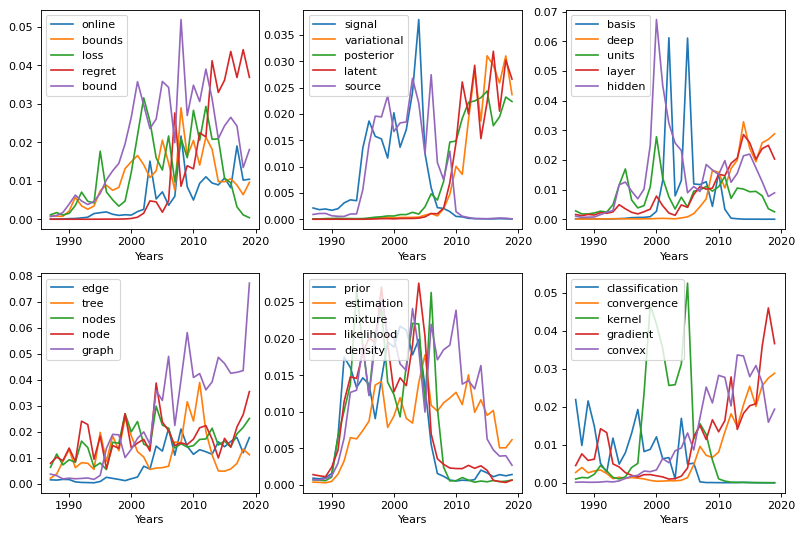

In [47]:
x = np.linspace(times[0],times[-1],times.shape[0])
result = beta[:,best_topics_rank, :].squeeze(1)[:,:,best_vocab_rank].detach().cpu().numpy()

plt.figure(figsize=(12, 8), dpi=80)

for i in range(1,7):
    plt.subplot(2,3,i)
    plt.plot(x,result[:,i-1,i-1,:],label=best_vocab[i-1])
    plt.legend(loc='upper left')
    plt.xlabel('Years')
    #plt.ylabel('Stack')

plt.savefig('scatter.png')
plt.show()

In [ ]:
test_ts.float()

In [ ]:
best_topics_rank.detach().cpu().numpy()

In [ ]:
model.decoder.fcrho.weight().shape, theta.shape
rho = model.decoder.fcrho.weight().detach().cpu().numpy()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1154 samples in 0.004s...
[t-SNE] Computed neighbors for 1154 samples in 0.091s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1154
[t-SNE] Computed conditional probabilities for sample 1154 / 1154
[t-SNE] Mean sigma: 0.166862
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.391167
[t-SNE] KL divergence after 1000 iterations: 0.695827


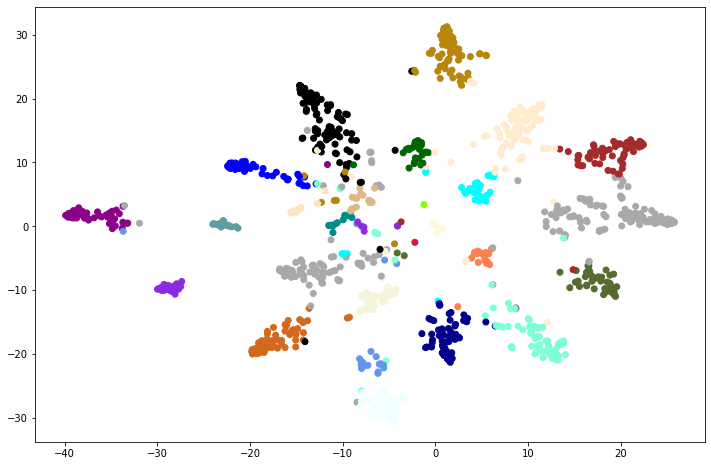

In [48]:
import matplotlib

import bokeh.plotting as bp

from bokeh.plotting import save
from bokeh.models import HoverTool

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
# project to 2D
tsne_lda = tsne_model.fit_transform(theta)
colormap = []
for name, hex in matplotlib.colors.cnames.items():
    colormap.append(hex)

colormap = colormap[:len(theta[0, :])]
colormap = np.array(colormap)
title = '20 newsgroups TE embedding V viz'
plot_lda = bp.figure(plot_width=1400, plot_height=1100,
                 title=title,
                 tools="pan,wheel_zoom,box_zoom,reset,hover",
                 x_axis_type=None, y_axis_type=None, min_border=1)
plt.figure(figsize=(12,8))
plt.scatter(x=tsne_lda[:, 0], y=tsne_lda[:, 1],
                    color=colormap[theta.argsort(-1)[:,-1]%148])
plt.savefig('tsne1.png')
plt.show()

In [ ]:
s = lambda x: "#Topic: "+str(x)
list(map(s, best_topics_rank.detach().cpu().numpy().tolist()))

In [ ]:
s = list(map(" ".join, best_vocab))
# s = ['Topic 0: Graph',
#     'Topic 1: Cognitive Science',
#     'Topic 9: Embeddings',
#     'Topic 13: Visual & Signaling',
#     'Topic 16: Bayesian Statistics',
#     'Topic 17: Decision Theory',]

AttributeError: 'Line2D' object has no property 'labels'

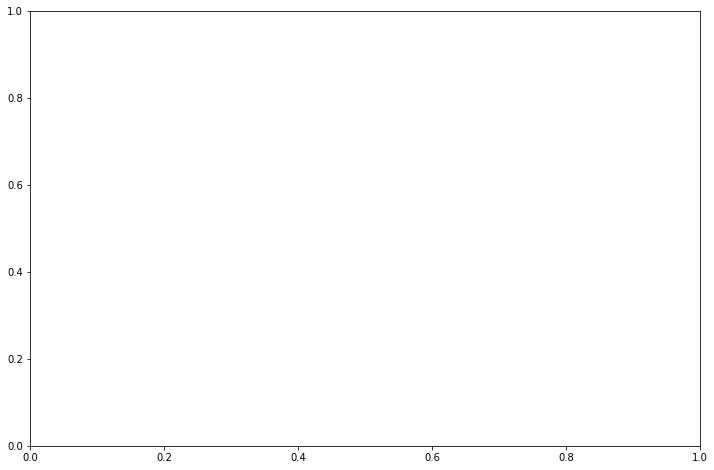

In [49]:
import matplotlib.pyplot as plt
# time range
x = np.linspace(times[0],times[-1],times.shape[0])
# select the (topic, topic-words)
# topic word vocab
plt.figure(figsize=(12,8))
for i in range(0,6):
    plt.plot(x, eta.T[best_topics_rank.detach().cpu().numpy()[i],:], 
              labels=best_vocab)
             #label=s[i])
# plt.stackplot(x, eta.T[best_topics_rank.detach().cpu().numpy(),:], 
#               labels=best_vocab)
plt.legend(loc='upper left')
plt.xlabel('Year')
#plt.ylabel('Stack')
plt.title('Topic representation over time')
plt.savefig('topic_scatter.png')
plt.show()

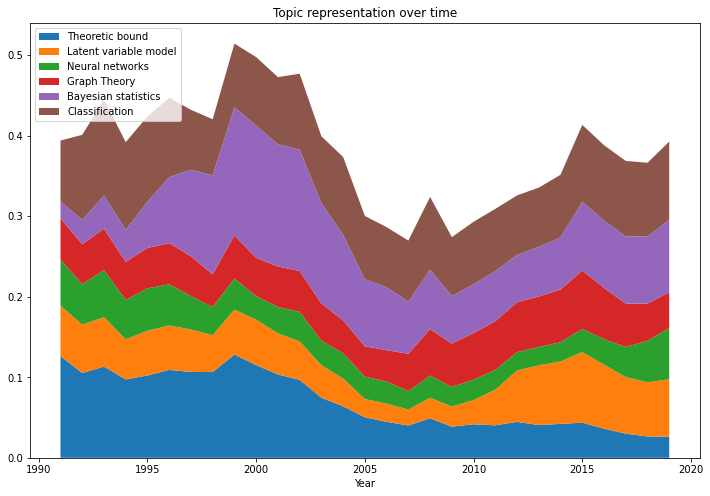

In [76]:
import matplotlib.pyplot as plt
# time range
x = np.linspace(times[0],times[-1],times.shape[0])
# select the (topic, topic-words)
# topic word vocab
plt.figure(figsize=(12,8))
res = pd.DataFrame(eta.T[best_topics_rank.detach().cpu().numpy(),:].T).rolling(window=5).mean()#.plot(label="20SMA", legend=True)
custom_title = ['Theoretic bound','Latent variable model', 'Neural networks', 'Graph Theory', 'Bayesian statistics','Classification']
plt.stackplot(x, res.T,labels=custom_title)
#plt.stackplot(x, eta.T[best_topics_rank.detach().cpu().numpy(),:],labels=best_vocab)
plt.legend(loc='upper left')
plt.xlabel('Year')
#plt.ylabel('Stack')
plt.title('Topic representation over time')
plt.savefig('topic_stack_plot.png')
plt.show()

In [62]:
pd.DataFrame(eta.T[best_topics_rank.detach().cpu().numpy(),:].T).rolling(window=5).mean().T

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,NaN,NaN,NaN,NaN,0.126277,0.105195,0.113277,0.097286,0.102157,0.109046,...,0.041640,0.040339,0.044595,0.040645,0.042099,0.043588,0.036217,0.029973,0.026467,0.026042
1,NaN,NaN,NaN,NaN,0.062396,0.060029,0.061288,0.049815,0.055575,0.055202,...,0.030001,0.044173,0.063721,0.074095,0.077462,0.087599,0.079368,0.070176,0.067244,0.071382
2,NaN,NaN,NaN,NaN,0.057361,0.050407,0.058437,0.048748,0.052650,0.051043,...,0.025342,0.024527,0.022833,0.022815,0.023805,0.028822,0.031683,0.037392,0.051544,0.063598
3,NaN,NaN,NaN,NaN,0.051073,0.049398,0.051279,0.047371,0.050048,0.051067,...,0.057786,0.060517,0.061993,0.062579,0.065390,0.072572,0.063690,0.053697,0.046133,0.044366
4,NaN,NaN,NaN,NaN,0.021173,0.030225,0.041161,0.039647,0.057403,0.081957,...,0.060599,0.062158,0.058739,0.061618,0.064759,0.085276,0.083421,0.083509,0.083200,0.090017
5,NaN,NaN,NaN,NaN,0.075462,0.105609,0.119407,0.108919,0.105876,0.098495,...,0.077580,0.077217,0.073784,0.073582,0.077785,0.095347,0.093593,0.093717,0.091576,0.097099


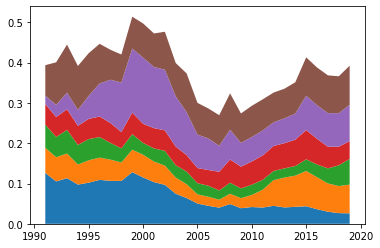

In [ ]:
!pip install pyvis

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(16,12))
#sb.heatmap(pd.DataFrame(filtered_beta.T).corr(),vmin=-1,annot=True)
sb.heatmap(pd.DataFrame(model.L_Omega[30].cpu().numpy()),vmin=-1,annot=True)

In [ ]:
def get_top_words(k, top=5):
  # KxTxL
  alpha = model.mu_q_alpha.clone().contiguous()
  alpha = alpha.permute(1,0,2)
  #alpha = model.get_alpha()[0]

  beta = model.get_beta(alpha, torch.arange(0,len(times)))
  # select best 4 words from those topics
  best_vocab_rank = beta[:,k,:-3].sum(0).argsort(-1)[-top:]
  # check beta
  best_vocab = np.array(vocab)[best_vocab_rank.detach().cpu().numpy()]
  return best_vocab.tolist()

get_top_words(2)

In [ ]:
li = model.L_Omega[0][10].cpu().tolist()
li.pop(10)
len(li)

In [ ]:
from pyvis.network import Network

num_topics = 30
time_t = 26
# Let's visualize the result
g = Network(width=800, height=800, font_color="#333")
correl = model.L_Omega[time_t].reshape([-1]).cpu().tolist()
correl.sort()
top_tenth = num_topics * (num_topics - 1) // 10
top_tenth = correl[-num_topics - top_tenth]

for k in range(num_topics):
    label = "#{}".format(k)
    title= ' '.join(word for word in get_top_words(k, top=6))
    print('Topic', label, title)
    g.add_node(k, label=label, title=title, shape='ellipse')
    li = model.L_Omega[time_t][k].cpu().tolist()
    li.pop(k)
    for l, correlation in zip(range(k - 1), li):
        if correlation < top_tenth: continue
        g.add_edge(k, l, value=float(correlation), title='{:.02}'.format(correlation))

g.barnes_hut(gravity=-1000, spring_length=20)
g.show_buttons()
g.show("topic_network.html")

In [ ]:
eta = torch.from_numpy(eta).softmax(-1).detach().numpy()


x = np.linspace(times[0],times[-1],times.shape[0])

plt.figure(figsize=(12, 8), dpi=80)

for i in range(1,21):
    plt.subplot(5,4,i)
    plt.plot(x,eta[:,i-1])
    #plt.legend(loc='upper left')
    #plt.xlabel('Years')
    #plt.ylabel('Stack')

In [ ]:
data_file = os.path.join('./', 'min_df_{}'.format(100))
vocab, train, valid, test = get_data(data_file, temporal=True)
vocab, count

In [ ]:
# KxTxL
alpha = model.mu_q_alpha.clone().contiguous()
alpha = alpha.permute(1,0,2)
#alpha = model.get_alpha()[0]
beta = model.get_beta(alpha)
print(beta.shape)

cnt = 0
tc = 0
beta = beta[:,:,:-3]
for time in range(0,beta.shape[0]):
    beta_t = beta[time,:,:]
    cnt+=1
    tc_k=get_topic_coherence(beta_t, train_cvz)
    print(tc_k)
    tc+=tc_k

tc/=cnt
print(f'tc: {tc}')

#print_top_words(beta[:,:,:-3],vocab)
def _diversity_helper(beta, num_tops):
    list_w = torch.zeros((int(beta.shape[0]), num_tops))
    for k in range(int(beta.shape[0])):
        gamma = beta[k, :]
        top_words = gamma.argsort()[-num_tops:]
        list_w[k, :] = top_words
    list_w = list_w.reshape(-1)
    n_unique = len(list_w.unique())
    diversity = n_unique / (beta.shape[0] * num_tops)
    return diversity

td = 0
for t in range(beta.shape[0]):
    d=_diversity_helper(beta[t],25)
    td+=d
    print(d)
print(f'TD: {td/beta.shape[0]}')

In [ ]:
cvz.shape

In [ ]:
# note that this helper function does three different things:
# (i) plots the observed data;
# (ii) plots the predictions from the learned GP after conditioning on data;
# (iii) plots samples from the GP prior (with no conditioning on observed data)

def plot(plot_observed_data=False, plot_predictions=False, n_prior_samples=0,
         model=None, kernel=None, n_test=500):

    plt.figure(figsize=(12, 6))
    if plot_observed_data:
        plt.plot(X.numpy(), y.numpy(), 'kx')
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        plt.plot(Xtest.numpy(), mean.numpy(), 'r', lw=2)  # plot the mean
        plt.fill_between(Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
                         (mean - 2.0 * sd).numpy(),
                         (mean + 2.0 * sd).numpy(),
                         color='C0', alpha=0.3)
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (model.noise if type(model) != gp.models.VariationalSparseGP
                 else model.likelihood.variance)
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(torch.zeros(n_test), covariance_matrix=cov)\
                      .sample(sample_shape=(n_prior_samples,))
        plt.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    plt.xlim(-0.5, 5.5)